# This script identifies LG analogues in the halo catalogue and extracts the merger tree data from the tree file, in preparation for plotting.

### Running this script requires the Mini-Uchuu z=0 halo catalog and merger tree files, which are available at skiesanduniverses.org.

Note that some steps take a lot of time (mostly due to reading files from disk). If you don't want to rerun them each time, skip those cells. This script is designed to save intermediate results to disk and read them from disk.

You are free to use any part of this script. If you use any of it in your own scientific work, we would appreciate a citation to our paper, by Sawala, Penarrubia, Liao and Johansson.

For any questions, please email: till.sawala@helsinki.fi, or contact me via github.

### Define path for local modules

This will depend on your particular environment and will not be necessary if you have all packages that are imported below in your standard python path.

In [ ]:
import sys
print(sys.path)

sys.path.append('C:/Users/equel/AppData/Local/Packages/PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0/LocalCache/local-packages/Python313/site-packages')

print("now:", sys.path)


### Imports

In [2]:
import numpy as np
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal
from scipy.stats import norm


from scipy.signal import savgol_filter   


import math

from scipy import optimize
from scipy.optimize import fsolve
from scipy import spatial

import heapq

import timeit
import glob
from tqdm import tqdm

import os
import pickle
import psutil

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value

print ("loaded modules")

loaded modules


### Parameters

In [3]:
# File for the z=0 LG data.
LG_data_file = 'LG_data_filtered.npz'  # files selected by m200, includes the gravity calculation

LG_tree_file = 'new_MiniUchu_treedata_set.npz'

cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3, Tcmb0=2.725)

hubble = .6774

G = 4300700 # for M in units of 10^12
max_residual = 1e-4 # for the TA solution
bounds = [(1e-2, 2*np.pi)] # bounds on eta for slsqp solver

boxSize = 2000. / hubble * 1000. 

m_MW_min = 0.7e12  # minimum mass for MW at z=0
m_MW_max = 1.5e12 # maximum mass for MW at z=0
m_M31_min = 1.0e12 # same for M31
m_M31_max = 2.0e12

m_min = min(m_MW_min, m_M31_min)
m_max = max(m_MW_max, m_M31_max)

# the pamameters below are for the pre-selection of LG analogues. We later define 'broad' and 'strict' subsets.

r_gravity = 5000. # this is the radius within which we look for haloes that dominate the gravitational force.
r_limit = 2000. # this is the radius within which we want no third object
r_max = 920. # this is the maximum separation between the MW and M31 in kpc.
r_min = 620. # this is the minimum separation between the MW and M31.
vr_max = -80
vr_min = -140
vt_max = 110
vt_min = 50

# These are the selection criteria we use later for the 'broad' and 'strict' subsets.
r_min_strict = .77 - .15
r_max_strict = .77 + .15
vr_min_strict = -110 - 30
vr_max_strict = -110 + 30
vt_max_strict = 60

r_min_broad = .77 - .3
r_max_broad = .77 + .3
vr_min_broad = -110 - 90
vr_max_broad = -110 + 90
vt_max_broad = 150  

snapshots = np.array([50,45,40,30,20,15,12])
particle_index = np.arange(0,len(snapshots))   # for indexing the particle data
tree_index = 50 - snapshots                    # for indexing the tree data

fine_index = np.arange(0,max(tree_index)+1)

print ("tree indices:", tree_index, "particle indices:", particle_index)
print ("fine index:", fine_index)

# ages to display
ages = np.array([13, 10, 8, 6, 5, 4, 3, 2, 1])*u.Gyr
ageticks = [1 / (1 + z_at_value(cosmo.age, age)) for age in ages]

# redshifts to display 
label_redshifts = np.array([4,3,2,1,0.5,0.2,0])
label_redshifts_str = ["4","3","2","1","0.5","0.2","0"]
label_scales = 1 / (label_redshifts + 1)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


m_min_gravity = 0.2e12 # consider perturbers above 2 x 10^11

basePath = '/scratch/project_2010958/uchuu_catalogues/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/RockstarExtendedM200c1e11/halodir_050/'

tree indices: [ 0  5 10 20 30 35 38] particle indices: [0 1 2 3 4 5 6]
fine index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


### Custom Functions

In [4]:
# We solve the eta equation, and then calculate a, M_TA and e.

# solve to obtain eta from t, r, vr, vt
def EtaEquation(eta, *data):
    r, vr, vt, t = data

    epsilon = 1e-10

    c = vt**2 / vr**2
    eqn = t * vr / r - np.sin(eta) * ( eta * (c * np.sin(eta)*np.sin(eta) + 1)**.5 - np.sin(eta)) / ((np.cos(eta) - (c * np.sin(eta) * np.sin(eta) + 1)**.5)**2+epsilon)
    
    eqn = np.abs(eqn)
    
    return eqn


# The full TA equations, only used to check results
def TAequations(variables, *data):
    
    r, vr, vt, t = data[0]
    G = 4300700 # for M in units of 10^12
    
    a, e, eta, M = variables
    
    a = a * 1000 # to have a in Mpc
    
    eqn_1 = (a * (1. - e * np.cos(eta) ) - r) 
    eqn_2 = ( (a**3 / (G * M) )**.5 * (eta - e * np.sin(eta) ) - t ) 
    eqn_3 = ((G * M) / a)**.5 * e * np.sin(eta)  / (1. - e * np.cos (eta) + 1.e-12) - vr
    eqn_4 = ((G * M) / a)**.5 * (1. - e**2)**.5 / (1. - e * np.cos(eta) + 1.e-12) - vt
    return [eqn_1, eqn_2, eqn_3, eqn_4]


def evalTA(p, *data): # evaluate the general TA given the parameters and the data
    return abs(sum(np.array(TAequations(p, data))**2))

### Read the Uchuu scale factors

In [5]:
'''f = open('Uchuu_redshift_scalefactors.txt', 'r')

lines = f.readlines()
scale = []
                  
for line in lines:
    columns = line.split()
    scale.append(float(columns[2]))

scale = np.flip(scale)
print ("scalefactors:", scale)'''

'f = open(\'Uchuu_redshift_scalefactors.txt\', \'r\')\n\nlines = f.readlines()\nscale = []\n                  \nfor line in lines:\n    columns = line.split()\n    scale.append(float(columns[2]))\n\nscale = np.flip(scale)\nprint ("scalefactors:", scale)'

In [6]:
scale = [0.999887, 0.977848, 0.956412, 0.914941, 0.87523, 0.837539, 0.801034, 0.766456,
 0.733135, 0.701575, 0.671151, 0.642035, 0.614153, 0.587537, 0.562099, 0.537713,
 0.514356, 0.49213, 0.470773, 0.450389, 0.430727, 0.412155, 0.394333, 0.377182,
 0.360886, 0.34528, 0.330255, 0.315864, 0.30214, 0.289175, 0.276536, 0.264684,
 0.253086, 0.242223, 0.231799, 0.216898, 0.202878, 0.189856, 0.177649, 0.162519,
 0.148772, 0.136158, 0.124496, 0.113967, 0.104325, 0.095413, 0.087363, 0.079949,
 0.073131, 0.066964]

scale = np.array(scale)

### Read the halo catalogue.
#### This is done in addition to the tree file, as it contains the tidal information. 

In [61]:
# select all the files
files = glob.glob(basePath + 'halolist_z0p00_m200c1e11_*.h5')
files = np.sort(files)
N_volumes = len(files)
print(f"{N_volumes} files found")

# Lists to concatenate
all_x, all_y, all_z = [], [], []
all_vx, all_vy, all_vz = [], [], []
all_m200 = []
all_pid, all_ID, all_TidalID = [], [], []

# Looping on all the files
print("Reading files...")
for i in tqdm(range(N_volumes)):
    with h5py.File(files[i], 'r') as hf:
        all_x.append(np.array(hf['x']) / hubble * 1000.)
        all_y.append(np.array(hf['y']) / hubble * 1000.)
        all_z.append(np.array(hf['z']) / hubble * 1000.)

        all_vx.append(np.array(hf['vx']))
        all_vy.append(np.array(hf['vy']))
        all_vz.append(np.array(hf['vz']))

        all_m200.append(np.array(hf['M200c']) / hubble)

        all_pid.append(np.array(hf['pid']))
        all_ID.append(np.array(hf['id']))
        all_TidalID.append(np.array(hf['Tidal_ID']))

        hf.close()
        
print("Concatenation ...")

# Concatenation in 1D array 
x = np.concatenate(all_x)
y = np.concatenate(all_y)
z = np.concatenate(all_z)

vx = np.concatenate(all_vx)
vy = np.concatenate(all_vy)
vz = np.concatenate(all_vz)

pos = np.array([x,y,z]).T
vel = np.array([vx,vy,vz]).T

m200 = np.concatenate(all_m200)

pid = np.concatenate(all_pid)
ID = np.concatenate(all_ID)
TidalID = np.concatenate(all_TidalID)

print("All files red.")
print(f"Total number of halos : {len(x):_}".replace('_', ' '))

100 files found
Reading files...


100%|██████████| 100/100 [12:17<00:00,  7.38s/it]


Concatenation ...
All files red.
Total number of halos : 264 675 366


### Find pairs in the halo catalogue

In [62]:
print ("ID > 0", len(TidalID[ID > 0]))
print ("TidalID > 0", len(TidalID[TidalID > 0]))
print ("TidalID < 0", len(TidalID[TidalID < 0]))


# Select subhalo samples

totNum = len(m200)

print ("total number of halos:", totNum)

selectIndex = np.full(totNum, False)
selectIndex[m200 > m_min] = True
selectIndex[m200 > m_max] = False

selectNum = len(m200[selectIndex])

print('Number of selected halos:', selectNum)

print('Minimum mass:', min(m200[selectIndex]) / 1.e12, ' x 10^12' )
print('Maximum mass:', max(m200[selectIndex]) / 1.e12, ' x 10^12' )

gravityIndex = np.full(totNum, False)
gravityIndex[m200 > m_min] = True

gravityNum = len(m200[gravityIndex])

print('Number of gravity halos:', gravityNum)

# First, the accelerations
allPos = pos[gravityIndex]
allVel = vel[gravityIndex]
allm200 = m200[gravityIndex]

print ("Building tree...")

allPos = allPos.T
for i in range(3):
    allPos[i][allPos[i] >= boxSize] = allPos[i][allPos[i] >= boxSize] - boxSize
    allPos[i][allPos[i] < 0.0] = allPos[i][allPos[i] < 0.0] + boxSize

allPos = allPos.T
tree = spatial.cKDTree(allPos, boxsize=boxSize)

selectPos = pos[selectIndex]
selectm200 = m200[selectIndex]

print ("Tree built.")

# We calculate the max. gravity acceleration in a separate loop, so we know them for both haloes by the time we look for pairs.

MaxAcceleration = np.zeros(selectNum, dtype='float')

print ("Computing Max Accelerations")

for i in tqdm(range(selectNum)):
    GravityNeighbourList = tree.query_ball_point(selectPos[i], r_gravity)

    Accelerations = []

    for j in range (len(GravityNeighbourList)):

        r2 = (selectPos[i][0] - allPos[GravityNeighbourList[j]][0] )**2. + (selectPos[i][1] - allPos[GravityNeighbourList[j]][1] )**2. + (selectPos[i][2] - allPos[GravityNeighbourList[j]][2] )**2.

        if r2 > 0.000001:  # exclude the halo itself.
            Accelerations.append(allm200[GravityNeighbourList[j]] / r2)

        if len(Accelerations) > 1:
            MaxAcceleration[i] = heapq.nlargest(2, Accelerations)[1]         # the second highest acceleration in the list.
        else:
            MaxAcceleration[i] = 1.e-6

# Now, the LG identification

print ("Finding pairs")

LG_r = []
LG_vr = []
LG_vt = []
LG_M_MW = []
LG_M_M31 = []

LG_center = []

LG_pos_MW = []
LG_pos_M31 = []

LG_ID_MW = []
LG_ID_M31 = []

LG_TidalID_MW = []
LG_TidalID_M31 = []

LG_ForceRatio_MW = []
LG_ForceRatio_M31 = []

Number_Neighbours = np.zeros(selectNum, dtype='float64')

allPos = pos[selectIndex]
allVel = vel[selectIndex]

Number_pairs = 0

print ("Building tree...")

allPos = allPos.T
for i in range(3):
    allPos[i][allPos[i] >= boxSize] = allPos[i][allPos[i] >= boxSize] - boxSize
    allPos[i][allPos[i] < 0.0] = allPos[i][allPos[i] < 0.0] + boxSize

allPos = allPos.T
tree = spatial.cKDTree(allPos, boxsize=boxSize)

selectPos = pos[selectIndex]
selectVel = vel[selectIndex]
selectm200 = m200[selectIndex]

selectID = ID[selectIndex]
selectTidalID = TidalID[selectIndex]


print ("Tree built.")


for i in tqdm(range(selectNum)):

    FarNeighbourList = tree.query_ball_point(selectPos[i], r_limit)
    CloseNeighbourList = tree.query_ball_point(selectPos[i], r_min)   # we subtract these from the FarNeighborList,
                                                                                # to get the objects in the shell
    Number_Neighbours[i] = len(FarNeighbourList)
    
    if Number_Neighbours[i] > 1:
        allNeighbourList = [x for x in FarNeighbourList if x not in CloseNeighbourList]
        Number_Neighbours[i] = len(allNeighbourList)

        if Number_Neighbours[i] == 1:
            Neighbour = allNeighbourList[0]
            if i < Neighbour:                
                radius =  np.sqrt ((selectPos[i][0] - allPos[Neighbour][0] )**2. +
                                   (selectPos[i][1] - allPos[Neighbour][1] )**2. +
                                   (selectPos[i][2] - allPos[Neighbour][2] )**2. )
                
                vtot =  np.sqrt ((selectVel[i][0] - allVel[Neighbour][0] )**2. +
                                 (selectVel[i][1] - allVel[Neighbour][1] )**2. +
                                 (selectVel[i][2] - allVel[Neighbour][2] )**2. ) 
                
                vr = ((selectVel[i][0] - allVel[Neighbour][0]) * (selectPos[i][0] - allPos[Neighbour][0]) + 
                      (selectVel[i][1] - allVel[Neighbour][1] ) * (selectPos[i][1] - allPos[Neighbour][1]) + 
                      (selectVel[i][2] - allVel[Neighbour][2] ) * (selectPos[i][2] - allPos[Neighbour][2])) / radius
                          
                vt = np.sqrt (vtot**2 - vr**2)
                
                vr = vr + radius / 1000 * 100 * hubble  # Add h * 100 km/s / Mpc to account for the hubble flow.
                
                if (m_MW_min < selectm200[i] < m_MW_max and m_M31_min < selectm200[Neighbour] < m_M31_max):
                    idx_MW = i
                    idx_M31 = Neighbour
                elif (m_MW_min < selectm200[Neighbour] < m_MW_max and m_M31_min < selectm200[i] < m_M31_max):
                    idx_MW = Neighbour
                    idx_M31 = i
                else:
                    continue

                LG_r.append(radius)
                LG_vr.append(vr)
                LG_vt.append(vt)
                                       
                LG_center.append([(selectPos[i][0] + allPos[Neighbour][0]) * .5,
                                 (selectPos[i][1] + allPos[Neighbour][1]) * .5,
                                 (selectPos[i][2] + allPos[Neighbour][2]) * .5] )
                
                Number_pairs = Number_pairs + 1

                LG_ForceRatio_MW.append(np.round(MaxAcceleration[i] / (selectm200[Neighbour] / radius**2.), 5))
                LG_ForceRatio_M31.append(np.round(MaxAcceleration[Neighbour] / (selectm200[i] / radius**2.), 5))
                    
                LG_M_MW.append(selectm200[idx_MW])
                LG_M_M31.append(selectm200[idx_M31])
                        
                LG_pos_MW.append([selectPos[idx_MW][0], selectPos[idx_MW][1], selectPos[idx_MW][2]])
                LG_pos_M31.append([allPos[idx_M31][0], allPos[idx_M31][1], allPos[idx_M31][2]])
                        
                LG_ID_MW.append(selectID[idx_MW])
                LG_ID_M31.append(selectID[idx_M31])
                
                LG_TidalID_MW.append(selectTidalID[idx_MW])
                LG_TidalID_M31.append(selectTidalID[idx_M31])

                
# delete the tree
tree = 0
                    
# transform the lists to numpy array and remove objects that are not LG-like:
LG_r = np.array(LG_r)
LG_vr = np.array(LG_vr)
LG_vt = np.array(LG_vt)

LG_M_MW = np.array(LG_M_MW)
LG_M_M31 = np.array(LG_M_M31)

LG_center = np.array(LG_center)
LG_pos_MW = np.array(LG_pos_MW)
LG_pos_M31 = np.array(LG_pos_M31)

LG_ID_MW = np.array(LG_ID_MW)
LG_ID_M31 = np.array(LG_ID_M31)

LG_TidalID_MW = np.array(LG_TidalID_MW)
LG_TidalID_M31 = np.array(LG_TidalID_M31)

LG_ForceRatio_MW = np.array(LG_ForceRatio_MW)
LG_ForceRatio_M31 = np.array(LG_ForceRatio_M31)

indices = np.where( (LG_r > r_min) & (LG_r < r_max) & (LG_vr > vr_min) & (LG_vr < vr_max) & (LG_vt > vt_min) & (LG_vt < vt_max))[0]

LG_r = LG_r[indices]
LG_vr = LG_vr[indices]
LG_vt = LG_vt[indices]
LG_M_MW = LG_M_MW[indices]
LG_M_M31 = LG_M_M31[indices]

LG_ID_MW = LG_ID_MW[indices]
LG_ID_M31 = LG_ID_M31[indices]

LG_TidalID_MW = LG_TidalID_MW[indices]
LG_TidalID_M31 = LG_TidalID_M31[indices]

LG_ForceRatio_MW = LG_ForceRatio_MW[indices]
LG_ForceRatio_M31 = LG_ForceRatio_M31[indices]

LG_center =  LG_center[indices][:]
LG_pos_MW =  LG_pos_MW[indices][:]
LG_pos_M31 =  LG_pos_M31[indices][:]

Number_LG = len(indices)

# compute the LG centre and total mass:

LG_M_tot = LG_M_MW + LG_M_M31

print ("N pairs:", Number_pairs)
print ("N LG analogues:", Number_LG)

print ("done")

# Isolation criterion

selectIndex = np.full(totNum, False)
selectIndex[m200 > 1e13] = True

allPos = pos[selectIndex]

print ("len:", len(allPos), "constructing tree")

allPos = allPos.T
for i in range(3):
    allPos[i][allPos[i] >= boxSize] = allPos[i][allPos[i] >= boxSize] - boxSize
    allPos[i][allPos[i] < 0.0] = allPos[i][allPos[i] < 0.0] + boxSize
    
allPos = allPos.T
tree = spatial.cKDTree(allPos, boxsize=boxSize)

print ("tree construction done")

LG_N_sub = []

for i in range(len(indices)):
    NeighbourList = tree.query_ball_point(LG_center[i], 5000)
        # to get the objects in the shell
    Number_Neighbours = len(NeighbourList)
    LG_N_sub.append(Number_Neighbours)
    
LG_N_sub = np.array(LG_N_sub)

free = np.where (LG_N_sub == 0)[0]

# Compute tidal status

LG_TidalStatus = np.zeros(Number_LG, dtype=int)

for i in range (Number_LG):
    if (LG_TidalID_M31[i] == LG_ID_MW[i] or LG_TidalID_MW[i] == LG_ID_M31[i]):
        LG_TidalStatus[i] = 0
    else:
        LG_TidalStatus[i] = 1

# select LG analogues that are isolated, tidally dominant and with low force rations ("true LGs")  
        
selection_tidal = np.where(LG_TidalStatus == 0)[0]

print ("N free:", len(free))

print ("N tidal:", len(selection_tidal))

selection_force_MW = np.where(LG_ForceRatio_MW < 0.5)[0]
selection_force_M31 = np.where(LG_ForceRatio_M31 < 0.5)[0]

selection = list(set(selection_tidal) & set(selection_force_MW) & set (selection_force_M31) & set(free) )

print ("N true:", len(selection) )

print ("done identifying LG analogues")

ID > 0 264675366
TidalID > 0 263539273
TidalID < 0 1136093
total number of halos: 264675366
Number of selected halos: 40443182
Minimum mass: 0.7004723944493653  x 10^12
Maximum mass: 2.0  x 10^12
Number of gravity halos: 64397004
Building tree...
Tree built.
Computing Max Accelerations


100%|██████████| 40443182/40443182 [23:07<00:00, 29146.07it/s]


Finding pairs
Building tree...
Tree built.


100%|██████████| 40443182/40443182 [12:34<00:00, 53591.70it/s]


N pairs: 3384643
N LG analogues: 27932
done
len: 4772932 constructing tree
tree construction done
N free: 23293
N tidal: 25912
N true: 19499
done identifying LG analogues


In [70]:
print (len(selection))
print (len(LG_r))

19499
19499


### Save z=0 data to file

In [64]:
print ("file:", LG_data_file)

file: LG_data_filtered.npz


In [65]:
LG_r = LG_r[selection]
LG_vr = LG_vr[selection]
LG_vt = LG_vt[selection]
LG_M_MW = LG_M_MW[selection]
LG_M_M31 = LG_M_M31[selection]

LG_ID_MW = LG_ID_MW[selection]
LG_ID_M31 = LG_ID_M31[selection]

#print ("N:", len(LG_r))
print ("min MW mass", min(LG_M_MW) / 1.e12, ' x 10^12' )
print ("max MW mass", max(LG_M_MW) / 1.e12, ' x 10^12' )
print("----------")
print ("min M31 mass", min(LG_M_M31) / 1.e12, ' x 10^12' )
print ("max M31 mass", max(LG_M_M31) / 1.e12, ' x 10^12' ) 

print("----------")
print("min r", min(LG_r))
print("max r", max(LG_r))
print("----------")
print("min vr", min(LG_vr))
print("max vr", max(LG_vr))
print("----------")
print("min vt", min(LG_vt))
print("max vt", max(LG_vt))

np.savez(LG_data_file, allow_pickle = True,
         LG_ID_MW = LG_ID_MW, LG_ID_M31 = LG_ID_M31, LG_r = LG_r, 
         LG_vr = LG_vr, LG_vt = LG_vt, LG_M_MW = LG_M_MW, LG_M_M31 = LG_M_M31)

print ('done writing LG file')

min MW mass 0.7004723944493653  x 10^12
max MW mass 1.4998523767345733  x 10^12
min M31 mass 1.000265721877768  x 10^12
max M31 mass 1.9995571302037203  x 10^12
done writing LG file


### Read the LG data file back

In [6]:
data = np.load(LG_data_file)  # files selected by m200, includes the gravity calculation

print (list(data.keys()))

LG_ID_MW = data['LG_ID_MW']
LG_ID_M31 = data['LG_ID_M31']
LG_r = data['LG_r']
LG_vr = data['LG_vr']
LG_vt = data['LG_vt']
LG_M_MW = data['LG_M_MW']
LG_M_M31 = data['LG_M_M31']

Num_LG = len(LG_r)

print ("Num_LG", Num_LG)

print ('done reading LG file')

['allow_pickle', 'LG_ID_MW', 'LG_ID_M31', 'LG_r', 'LG_vr', 'LG_vt', 'LG_M_MW', 'LG_M_M31']
Num_LG 19499
done reading LG file


In [8]:
file_path = '/scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_0.h5'

with h5py.File(file_path, 'r') as f:
    print("Content keys of the .h5 files :")
    for key in f.keys():
        print(f"  - {key} : {type(f[key])}")
        
        if isinstance(f[key], h5py.Dataset):
            print(f"    -> shape: {f[key].shape}, dtype: {f[key].dtype}")
        elif isinstance(f[key], h5py.Group):
            print(f"    -> group countaining {len(f[key])} sub-elements")

    forests_group = f['Forests']
    print(f"Ket : {list(forests_group.keys())}")

Content keys of the .h5 files :
  - ForestInfo : <class 'h5py._hl.dataset.Dataset'>
    -> shape: (1530564,), dtype: [('ForestID', '<i8'), ('ForestHalosOffset', '<i8'), ('ForestNhalos', '<i8'), ('ForestNtrees', '<i8')]
  - Forests : <class 'h5py._hl.group.Group'>
    -> group countaining 67 sub-elements
  - TreeInfo : <class 'h5py._hl.dataset.Dataset'>
    -> shape: (1961530,), dtype: [('ForestID', '<i8'), ('TreeRootID', '<i8'), ('TreeHalosOffset', '<i8'), ('TreeNhalos', '<i8'), ('Input_Filename', 'S1024'), ('Input_FileDateStamp', '<f8'), ('Input_TreeByteOffset', '<i8'), ('Input_TreeNbytes', '<i8')]
  - simulation_params : <class 'h5py._hl.group.Group'>
    -> group countaining 0 sub-elements
Ket : ['A_x', 'A_x_500c', 'A_y', 'A_y_500c', 'A_z', 'A_z_500c', 'Breadth_first_ID', 'Depth_first_ID', 'Descendant', 'FirstHaloInFOFgroup', 'FirstProgenitor', 'FofID', 'Halfmass_Radius', 'Jx', 'Jy', 'Jz', 'Last_mainleaf_depthfirst_ID', 'Last_progenitor_depthfirst_ID', 'M200b', 'M200c', 'M2500c', 'M

### Load select and save the tree files.
#### First, make an halo index file to link a halo ID to its position in the tree files

In [7]:
import os
import h5py
import pickle
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from time import perf_counter
import psutil
import gc
import shelve
from multiprocessing import Pool

# PARAMETERS
treefiles = [f"/scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_{i}.h5" for i in range(178)]
output_file_template = "trees2_{}.h5"
desc_map_file_template = "desc_map_shelve_{}.db"
LG_data_file = "LG_data_filtered.npz"
fields = ['id', 'desc_id', 'M200c', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Snap_idx']
chunk_size = 1_000_000
num_process = 40

In [8]:
# Print the memory used
def print_mem_usage(tag=""):
    mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2   # takes the used memory in MB
    print(f"[{tag}] Used memory : {mem:.2f} MB")                    # print


# Free the memory used for objects given in arguments
def clean_mem(*args):
    for arg in args:
        del arg     # delete each object
    gc.collect()    # memory cleaning


def make_desc_index(file_id, treefile, halo_ids_to_follow, desc_map_file):
    '''
    Create a desc index => for each halo ID, look to see which halo has its desc_id = ID

    Parameters :
        file_id (int) : ID of the file being read (used to locate the halo)
        treefile (str) : Path of the .h5 containing the merger tree data
        halo_ids_to_follow (set of int) : Set of halo IDs selected to look for progenitors
        desc_map_file (str) : Path to the shelve file where the index will be saved

    Returns :
        a shelve dictionary saved on disk, for example :
            {"123456789" : [(0,1200,48), (0,1389,47), (1,69456,48)],  # the halo 123456789 has 3 progenitors for example file 0, No.1200, snap 48
             "987654321" : [(1,401,32)],                              # the halo 987654321 has 1 progenitor
             ...
            }
    '''
    to_follow = set(halo_ids_to_follow)                    # IDs to follow
    seen = set()                                           # avoid duplications
    if os.path.exists(desc_map_file):
        os.remove(desc_map_file)                           # we delete the given file if it already exists

    with shelve.open(desc_map_file) as desc_map:           # open a "persistent dictionary"
        with h5py.File(treefile, 'r') as f:
            group = f['Forests']
            total = len(group['id'])
            
            for start in range(0, total, chunk_size):      # we're cutting the reading into chunks
                end = min(start + chunk_size, total)
                ids = group['id'][start:end]
                desc_ids = group['desc_id'][start:end]
                snaps = group['Snap_idx'][start:end]

                for i in range(end - start):              # go through the halos of a chunk to make the descendants index
                    this_id = int(ids[i])
                    desc_id = int(desc_ids[i])
                    if this_id in to_follow or desc_id in to_follow:
                        key = str(desc_id)
                        if key not in desc_map:
                            desc_map[key] = []
                        entry = desc_map[key]
                        entry.append((file_id, start + i, int(snaps[i])))
                        desc_map[key] = entry

                        if this_id not in seen:
                            to_follow.add(this_id)
                            seen.add(this_id)
                            
                clean_mem(ids, desc_ids, snaps)
                
    print_mem_usage(f"Indexation desc_id terminée pour fichier {file_id}")


def make_halo_id_index(treefile, halo_ids_to_follow):
    '''
    Create a halo IDs index => link each halo ID in halo_ids_to_follow to its position in the .h5 file

    Parameters :
        treefile (str) : Path to the .h5 file containing the merger tree data
        halo_ids_to_follow (list/set of int) : Halo IDs to locate in the file

    Returns :
        a dictionary, for example :
            {123456789 : 1000,          # the halo 123456789 is located at the position 100 in the dataset
             987654321 : 20346,
             ...
            }
    '''
    halo_ids_to_follow_set = set(halo_ids_to_follow)
    index = {}
    with h5py.File(treefile, 'r') as f:
        ids_dataset = f['Forests']['id']
        total = len(ids_dataset)
        for start in range(0, total, chunk_size):
            end = min(start + chunk_size, total)
            ids_chunk = ids_dataset[start:end]
            for i, halo_id in enumerate(ids_chunk):
                hid = int(halo_id)
                if hid in halo_ids_to_follow_set:
                    index[hid] = start + i
            clean_mem(ids_chunk)
    return index


# Load the main branch of a halo from its index
def load_branch(treefile, file_id, idx, id_indexes, desc_map_file):
    '''
    Load the main progenitor branch of a given halo

    Parameters :
        treefile (str) : Path to the .h5 merger tree file containing the initial halo
        file_id (int) : ID of the file where the halo is located
    '''
    t_start = perf_counter()
    branch_data = {k: [] for k in fields}
    visited_ids = set()
    current_treefile = treefiles[file_id]
    current_file = h5py.File(current_treefile, 'r')
    group = current_file['Forests']
    
    current_id = int(group['id'][idx])
    current_snap = int(group['Snap_idx'][idx])
    visited_ids.add(current_id)

    with shelve.open(desc_map_file) as desc_map:
        while True:
            for k in fields:
                branch_data[k].append(group[k][idx])

            key = str(current_id)
            if key not in desc_map:
                break

            # Collect all progenitors with snap < current_snap
            candidates = [(fid, i, snap) for fid, i, snap in desc_map[key] if snap < current_snap]
            if not candidates:
                break

            # Among those, find the one from the closest previous snapshot
            prev_snap = max(snap for _, _, snap in candidates)
            best_mass = 0
            best = None

            for fid, i, snap in candidates:
                if snap == prev_snap:
                    candidate_treefile = treefiles[fid]
                    with h5py.File(candidate_treefile, 'r') as f:
                        mass = f['Forests']['M200c'][i]
                        if mass > best_mass:
                            best_mass = mass
                            best = (fid, i)

            if best is None:
                break

            file_id, idx = best
            next_treefile = treefiles[file_id]

            if next_treefile != current_treefile:
                current_file.close()
                current_file = h5py.File(next_treefile, 'r')
                current_treefile = next_treefile
                group = current_file['Forests']
                
            current_id = int(group['id'][idx])
            current_snap = int(group['Snap_idx'][idx])
            if current_id in visited_ids:
                print(f"Boucle détectée pour ID {current_id}")
                break
            visited_ids.add(current_id)

    current_file.close()
    print(f"[Profiling] Halo {branch_data['id'][0]} extrait en {perf_counter() - t_start:.2f} s")
    return branch_data


# Write branch data to an output .h5 file
def write_branch_to_file(out_file, local_id, branch_data):
    grp = out_file.create_group(f"branch_{local_id}")
    grp.attrs['z0_id'] = local_id
    for k in fields:
        data = np.asarray(branch_data[k])
        grp.create_dataset(k, data=data)
        del data
    del grp
    gc.collect()

# Function called to process a file : several processors can work on several files at the same time
def process_treefile(file_id):
    gc.collect()
    treefile = treefiles[file_id]
    output_file = output_file_template.format(file_id)
    desc_map_file = desc_map_file_template.format(file_id)

    print(f"[Worker {file_id}] Démarrage traitement fichier: {treefile}")

    LG_data = np.load(LG_data_file)
    LG_ID_MW = LG_data['LG_ID_MW']
    LG_ID_M31 = LG_data['LG_ID_M31']
    z0_ids_available = set(np.unique(np.concatenate((LG_data["LG_ID_MW"], LG_data["LG_ID_M31"]))))

    LG_ID_MW_filtered = np.array([hid for hid in LG_ID_MW if hid in z0_ids_available])
    LG_ID_M31_filtered = np.array([hid for hid in LG_ID_M31 if hid in z0_ids_available])
    halo_IDs_to_follow = list(LG_ID_MW_filtered) + list(LG_ID_M31_filtered)
    halo_id_set = set(halo_IDs_to_follow)

    id_index = make_halo_id_index(treefile, halo_id_set)
    make_desc_index(file_id, treefile, halo_id_set, desc_map_file)

    with h5py.File(treefile, 'r') as f:
        ids_dataset = f['Forests']['id']
        id_to_idx = {}
        for start in range(0, len(ids_dataset), chunk_size):
            end = min(start + chunk_size, len(ids_dataset))
            chunk = ids_dataset[start:end]
            for i, halo_id in enumerate(chunk):
                hid = int(halo_id)
                if hid in halo_id_set:
                    id_to_idx[hid] = start + i
            clean_mem(chunk)

    with h5py.File(output_file, 'w') as out:
        for local_id, local_idx in tqdm(id_to_idx.items(), desc=f"Extraction fichier {file_id}"):
            branch = load_branch(treefile, file_id, local_idx, id_index, desc_map_file)
            write_branch_to_file(out, local_id, branch)
            clean_mem(branch)

    print(f"[Worker {file_id}] Terminé. Résultat : '{output_file}'")

def main():
    with Pool(processes=num_process) as pool:
        pool.map(process_treefile, range(len(treefiles)))

In [9]:
if __name__ == '__main__':
    main()

[Worker 0] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_0.h5
[Worker 42] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_42.h5
[Worker 6] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_6.h5
[Worker 40] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_40.h5[Worker 2] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_2.h5
[Worker 10] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_10.h5
[Worker 50] Démarrage traitement fichier: /scratch/pr

Extraction fichier 62:   0%|          | 0/22 [00:00<?, ?it/s]

[Indexation desc_id terminée pour fichier 4] Used memory : 191.89 MB


Extraction fichier 12:   0%|          | 0/18 [00:00<?, ?it/s]

[Indexation desc_id terminée pour fichier 34] Used memory : 212.55 MB
[Indexation desc_id terminée pour fichier 10] Used memory : 215.16 MB


Extraction fichier 34:   0%|          | 0/28 [00:00<?, ?it/s]

[Profiling] Halo 10754685515900 extrait en 75.38 s


Extraction fichier 78:   6%|▌         | 1/18 [01:15<21:24, 75.58s/it]

[Profiling] Halo 1683721403685 extrait en 89.89 s


Extraction fichier 12:   6%|▌         | 1/18 [01:30<25:32, 90.13s/it]

[Profiling] Halo 8521306145447 extrait en 94.39 s


Extraction fichier 62:   5%|▍         | 1/22 [01:34<33:06, 94.60s/it]

[Profiling] Halo 10479812911300 extrait en 80.39 s


Extraction fichier 76:  17%|█▋        | 1/6 [01:20<06:43, 80.69s/it]

[Profiling] Halo 9655178530522 extrait en 60.28 s


Extraction fichier 70:   7%|▋         | 1/14 [01:00<13:06, 60.53s/it]

[Profiling] Halo 5772531571126 extrait en 81.66 s


Extraction fichier 42:   5%|▍         | 1/22 [01:21<28:40, 81.94s/it]

[Profiling] Halo 34448160997 extrait en 92.05 s


Extraction fichier 0:   6%|▌         | 1/18 [01:32<26:09, 92.33s/it]

[Profiling] Halo 7696676030032 extrait en 93.22 s


Extraction fichier 56:   4%|▍         | 1/24 [01:33<35:50, 93.52s/it]

[Profiling] Halo 6322284282640 extrait en 90.43 s
[Profiling] Halo 9895697265503 extrait en 84.00 s


Extraction fichier 72:   7%|▋         | 1/14 [01:24<18:15, 84.26s/it]

[Profiling] Halo 4947895277836 extrait en 91.65 s


Extraction fichier 36:   6%|▋         | 1/16 [01:31<22:59, 91.94s/it]

[Profiling] Halo 1924238871890 extrait en 80.66 s


Extraction fichier 14:   5%|▌         | 1/20 [01:20<25:37, 80.93s/it]

[Profiling] Halo 5497655672533 extrait en 91.15 s


Extraction fichier 40:   5%|▍         | 1/22 [01:31<31:58, 91.37s/it]

[Profiling] Halo 9345939923358 extrait en 83.88 s


Extraction fichier 68:   7%|▋         | 1/14 [01:24<18:14, 84.17s/it]

[Profiling] Halo 8796185460136 extrait en 85.11 s
[Profiling] Halo 8246438232701 extrait en 96.65 s


Extraction fichier 64:   6%|▋         | 1/16 [01:25<21:19, 85.33s/it]

[Profiling] Halo 6872041491752 extrait en 91.80 s


Extraction fichier 50:   6%|▌         | 1/18 [01:32<26:06, 92.12s/it]

[Profiling] Halo 3848387100033 extrait en 91.13 s


Extraction fichier 28:   5%|▍         | 1/22 [01:31<31:59, 91.42s/it]

[Profiling] Halo 2267841250297 extrait en 95.44 s


Extraction fichier 16:   6%|▌         | 1/18 [01:35<27:06, 95.70s/it]

[Profiling] Halo 3573505595981 extrait en 85.79 s


Extraction fichier 26:   8%|▊         | 1/12 [01:26<15:46, 86.03s/it]

[Profiling] Halo 4123264997289 extrait en 99.01 s
[Profiling] Halo 6047410279631 extrait en 87.01 s


Extraction fichier 44:   5%|▌         | 1/20 [01:27<27:39, 87.32s/it]

[Profiling] Halo 6597164129247 extrait en 94.00 s


Extraction fichier 48:   6%|▋         | 1/16 [01:34<23:33, 94.22s/it]

[Profiling] Halo 7456156535424 extrait en 98.17 s
[Profiling] Halo 4398131419721 extrait en 94.12 s


Extraction fichier 32:   3%|▎         | 1/38 [01:34<58:09, 94.32s/it]

[Profiling] Halo 3298631505953 extrait en 96.28 s


Extraction fichier 24:   4%|▎         | 1/28 [01:36<43:25, 96.49s/it]

[Profiling] Halo 2748882032864 extrait en 90.43 s


Extraction fichier 20:   5%|▍         | 1/22 [01:30<31:45, 90.72s/it]

[Profiling] Halo 824733122991 extrait en 83.45 s


Extraction fichier 6:   5%|▌         | 1/20 [01:23<26:30, 83.69s/it]

[Profiling] Halo 5222769521334 extrait en 95.48 s


Extraction fichier 38:   5%|▍         | 1/22 [01:35<33:31, 95.78s/it]

[Profiling] Halo 10170579013530 extrait en 87.03 s


Extraction fichier 74:   4%|▍         | 1/24 [01:27<33:27, 87.29s/it]

[Profiling] Halo 1099600917654 extrait en 94.66 s


Extraction fichier 8:   6%|▌         | 1/18 [01:34<26:54, 94.95s/it]

[Profiling] Halo 7146920771751 extrait en 96.26 s
[Profiling] Halo 9071067184509 extrait en 93.97 s


Extraction fichier 66:   6%|▌         | 1/18 [01:34<26:42, 94.27s/it]

[Profiling] Halo 274974020610 extrait en 103.33 s
[Profiling] Halo 2473990930749 extrait en 96.87 s
[Profiling] Halo 3023754170941 extrait en 91.13 s


Extraction fichier 18:   7%|▋         | 1/14 [01:37<21:03, 97.17s/it]

[Profiling] Halo 7971553188304 extrait en 96.60 s


Extraction fichier 58:   5%|▌         | 1/20 [01:36<30:41, 96.90s/it]

[Profiling] Halo 549857255625 extrait en 95.90 s


Extraction fichier 4:   4%|▍         | 1/26 [01:36<40:03, 96.13s/it]

[Profiling] Halo 4673022878820 extrait en 92.87 s


Extraction fichier 34:   4%|▎         | 1/28 [01:33<41:53, 93.11s/it]

[Profiling] Halo 1374490123725 extrait en 99.32 s


Extraction fichier 10:   3%|▎         | 1/32 [01:39<51:27, 99.58s/it]

[Profiling] Halo 10754685515893 extrait en 78.77 s


Extraction fichier 78:  11%|█         | 2/18 [02:34<20:42, 77.64s/it]

[Profiling] Halo 10479812911299 extrait en 82.11 s


Extraction fichier 76:  33%|███▎      | 2/6 [02:43<05:26, 81.66s/it]

[Profiling] Halo 1683721401633 extrait en 92.19 s


Extraction fichier 12:  11%|█         | 2/18 [03:02<24:23, 91.47s/it]

[Profiling] Halo 9655178530519 extrait en 83.24 s


Extraction fichier 70:  14%|█▍        | 2/14 [02:24<14:48, 74.03s/it]

[Profiling] Halo 8521306146082 extrait en 93.46 s


Extraction fichier 62:   9%|▉         | 2/22 [03:08<31:20, 94.05s/it]

[Profiling] Halo 5772531571137 extrait en 82.97 s


Extraction fichier 42:   9%|▉         | 2/22 [02:45<27:33, 82.69s/it]

[Profiling] Halo 7696676030028 extrait en 84.43 s
[Profiling] Halo 9895697265265 extrait en 83.63 s


Extraction fichier 72:  14%|█▍        | 2/14 [02:48<16:48, 84.04s/it]

[Profiling] Halo 9345939923907 extrait en 83.42 s


Extraction fichier 68:  14%|█▍        | 2/14 [02:47<16:46, 83.87s/it]

[Profiling] Halo 3848387100067 extrait en 82.76 s


Extraction fichier 28:   9%|▉         | 2/22 [02:54<28:49, 86.50s/it]

[Profiling] Halo 4947895231789 extrait en 91.82 s


Extraction fichier 36:  12%|█▎        | 2/16 [03:03<21:28, 92.00s/it]

[Profiling] Halo 5497655672536 extrait en 87.33 s


Extraction fichier 40:   9%|▉         | 2/22 [02:58<29:43, 89.17s/it]

[Profiling] Halo 6322284282636 extrait en 95.52 s


Extraction fichier 46:  12%|█▎        | 2/16 [03:06<21:51, 93.68s/it]

[Profiling] Halo 34448161057 extrait en 97.90 s


Extraction fichier 0:  11%|█         | 2/18 [03:10<25:32, 95.77s/it]

[Profiling] Halo 2267841250272 extrait en 87.29 s


Extraction fichier 16:  11%|█         | 2/18 [03:03<24:14, 90.90s/it]

[Profiling] Halo 1924238871907 extrait en 95.22 s


Extraction fichier 14:  10%|█         | 2/20 [02:56<26:50, 89.49s/it]

[Profiling] Halo 3573505595987 extrait en 88.32 s


Extraction fichier 26:  17%|█▋        | 2/12 [02:54<14:35, 87.55s/it]

[Profiling] Halo 8796185460122 extrait en 93.71 s


Extraction fichier 64:  12%|█▎        | 2/16 [02:59<21:05, 90.38s/it]

[Profiling] Halo 2748882033040 extrait en 84.81 s


Extraction fichier 20:   9%|▉         | 2/22 [02:55<29:08, 87.42s/it]

[Profiling] Halo 10170579013553 extrait en 82.50 s


Extraction fichier 74:   8%|▊         | 2/24 [02:50<31:01, 84.63s/it]

[Profiling] Halo 2473990930842 extrait en 76.17 s


Extraction fichier 18:  14%|█▍        | 2/14 [02:53<16:59, 84.97s/it]

[Profiling] Halo 4398131419732 extrait en 87.80 s


Extraction fichier 32:   5%|▌         | 2/38 [03:02<54:24, 90.67s/it]

[Profiling] Halo 6872041805633 extrait en 96.96 s


Extraction fichier 50:  11%|█         | 2/18 [03:09<25:21, 95.11s/it]

[Profiling] Halo 6047410279704 extrait en 92.15 s


Extraction fichier 44:  10%|█         | 2/20 [02:59<27:06, 90.36s/it]

[Profiling] Halo 4123264997308 extrait en 93.37 s


Extraction fichier 30:  14%|█▍        | 2/14 [03:12<19:11, 95.97s/it]

[Profiling] Halo 6597164129374 extrait en 93.30 s


Extraction fichier 48:  12%|█▎        | 2/16 [03:07<21:53, 93.80s/it]

[Profiling] Halo 3298631505978 extrait en 92.07 s


Extraction fichier 24:   7%|▋         | 2/28 [03:08<40:45, 94.07s/it]

[Profiling] Halo 1099600917676 extrait en 86.91 s


Extraction fichier 8:  11%|█         | 2/18 [03:02<24:05, 90.37s/it]

[Profiling] Halo 9071067184504 extrait en 84.65 s
[Profiling] Halo 8246438232712 extrait en 102.35 s


Extraction fichier 60:  14%|█▍        | 2/14 [03:19<20:03, 100.29s/it]

[Profiling] Halo 7456156535573 extrait en 95.28 s


Extraction fichier 54:   8%|▊         | 2/24 [03:14<35:28, 96.77s/it]

[Profiling] Halo 7146920771746 extrait en 86.55 s
[Profiling] Halo 824733122990 extrait en 92.59 s


Extraction fichier 6:  10%|█         | 2/20 [02:56<26:43, 89.07s/it]]

[Profiling] Halo 5222769521443 extrait en 93.43 s


Extraction fichier 38:   9%|▉         | 2/22 [03:09<31:31, 94.59s/it]

[Profiling] Halo 3023754170955 extrait en 89.46 s


Extraction fichier 22:  12%|█▎        | 2/16 [03:01<21:05, 90.41s/it]

[Profiling] Halo 4673022879753 extrait en 81.85 s


Extraction fichier 34:   7%|▋         | 2/28 [02:55<37:33, 86.66s/it]

[Profiling] Halo 274974020602 extrait en 98.28 s


Extraction fichier 2:  20%|██        | 2/10 [03:22<13:25, 100.64s/it]

[Profiling] Halo 549857580343 extrait en 89.22 s


Extraction fichier 4:   8%|▊         | 2/26 [03:05<36:52, 92.19s/it]

[Profiling] Halo 7971553188314 extrait en 95.27 s


Extraction fichier 58:  10%|█         | 2/20 [03:12<28:49, 96.08s/it]

[Profiling] Halo 1374490123868 extrait en 89.55 s


Extraction fichier 10:   6%|▋         | 2/32 [03:09<46:55, 93.84s/it]

[Profiling] Halo 10754685583798 extrait en 83.55 s


Extraction fichier 78:  17%|█▋        | 3/18 [03:58<20:07, 80.48s/it]

[Profiling] Halo 10514175318147 extrait en 84.50 s


Extraction fichier 76:  50%|█████     | 3/6 [04:07<04:09, 83.09s/it]

[Profiling] Halo 9895697602068 extrait en 81.36 s


Extraction fichier 72:  21%|██▏       | 3/14 [04:09<15:12, 82.94s/it]

[Profiling] Halo 7696676064460 extrait en 82.58 s


Extraction fichier 56:  12%|█▎        | 3/24 [04:21<30:02, 85.85s/it]

[Profiling] Halo 9655178538957 extrait en 89.64 s


Extraction fichier 70:  21%|██▏       | 3/14 [03:53<14:54, 81.29s/it]

[Profiling] Halo 1683721401627 extrait en 92.85 s


Extraction fichier 12:  17%|█▋        | 3/18 [04:35<23:03, 92.24s/it]

[Profiling] Halo 8521306193961 extrait en 90.06 s


Extraction fichier 62:  14%|█▎        | 3/22 [04:38<29:14, 92.32s/it]

[Profiling] Halo 9380303008552 extrait en 82.65 s


Extraction fichier 68:  21%|██▏       | 3/14 [04:10<15:17, 83.44s/it]

[Profiling] Halo 4947895231786 extrait en 82.79 s


Extraction fichier 36:  19%|█▉        | 3/16 [04:26<19:02, 87.89s/it]

[Profiling] Halo 3848387817076 extrait en 83.60 s
[Profiling] Halo 5772531725971 extrait en 97.52 s


Extraction fichier 28:  14%|█▎        | 3/22 [04:18<27:00, 85.31s/it]

[Profiling] Halo 2267841938072 extrait en 81.82 s


Extraction fichier 16:  17%|█▋        | 3/18 [04:25<21:43, 86.87s/it]

[Profiling] Halo 6322284727315 extrait en 86.96 s


Extraction fichier 46:  19%|█▉        | 3/16 [04:33<19:39, 90.76s/it]

[Profiling] Halo 10170579120122 extrait en 79.54 s


Extraction fichier 74:  12%|█▎        | 3/24 [04:09<28:50, 82.43s/it]

[Profiling] Halo 5497655926635 extrait en 92.42 s


Extraction fichier 40:  14%|█▎        | 3/22 [04:31<28:44, 90.79s/it]

[Profiling] Halo 3607869169136 extrait en 87.59 s


Extraction fichier 26:  25%|██▌       | 3/12 [04:22<13:09, 87.69s/it]

[Profiling] Halo 8796185465771 extrait en 87.96 s


Extraction fichier 64:  19%|█▉        | 3/16 [04:27<19:21, 89.38s/it]

[Profiling] Halo 1958596076958 extrait en 91.95 s


Extraction fichier 14:  15%|█▌        | 3/20 [04:28<25:42, 90.73s/it]

[Profiling] Halo 4398131662663 extrait en 87.10 s


Extraction fichier 32:   8%|▊         | 3/38 [04:29<52:00, 89.15s/it]

[Profiling] Halo 6047410406237 extrait en 86.75 s


Extraction fichier 44:  15%|█▌        | 3/20 [04:26<25:09, 88.82s/it]

[Profiling] Halo 2473990975135 extrait en 90.61 s
[Profiling] Halo 2748882240774 extrait en 92.29 s


Extraction fichier 20:  14%|█▎        | 3/22 [04:28<28:25, 89.75s/it]

[Profiling] Halo 8280789971742 extrait en 84.69 s


Extraction fichier 60:  21%|██▏       | 3/14 [04:44<17:06, 93.28s/it] 

[Profiling] Halo 4123265132273 extrait en 91.23 s


Extraction fichier 30:  21%|██▏       | 3/14 [04:44<17:13, 93.95s/it]

[Profiling] Halo 5222769536590 extrait en 85.16 s
[Profiling] Halo 7456156575048 extrait en 87.50 s


Extraction fichier 54:  12%|█▎        | 3/24 [04:41<32:26, 92.68s/it]

[Profiling] Halo 34448621834 extrait en 104.51 s


Extraction fichier 0:  17%|█▋        | 3/18 [04:55<24:58, 99.90s/it]

[Profiling] Halo 6597164795643 extrait en 96.27 s


Extraction fichier 48:  19%|█▉        | 3/16 [04:44<20:35, 95.07s/it]

[Profiling] Halo 3298632152534 extrait en 96.67 s


Extraction fichier 24:  11%|█         | 3/28 [04:45<39:44, 95.36s/it]

[Profiling] Halo 7146921104059 extrait en 95.18 s


Extraction fichier 52:  19%|█▉        | 3/16 [04:38<20:08, 92.94s/it]

[Profiling] Halo 4673023310448 extrait en 88.95 s


Extraction fichier 34:  11%|█         | 3/28 [04:24<36:36, 87.84s/it]

[Profiling] Halo 824733173347 extrait en 97.06 s
[Profiling] Halo 9071067915130 extrait en 99.09 s


Extraction fichier 66:  17%|█▋        | 3/18 [04:38<23:23, 93.56s/it]

[Profiling] Halo 3023755149538 extrait en 93.53 s


Extraction fichier 22:  19%|█▉        | 3/16 [04:34<19:55, 91.97s/it]

[Profiling] Halo 1099601204913 extrait en 104.33 s
[Profiling] Halo 6872041887174 extrait en 108.80 s


Extraction fichier 50:  17%|█▋        | 3/18 [04:58<25:22, 101.50s/it]

[Profiling] Halo 274974461915 extrait en 92.61 s


Extraction fichier 2:  30%|███       | 3/10 [04:54<11:19, 97.08s/it] 

[Profiling] Halo 549857399411 extrait en 92.53 s


Extraction fichier 4:  12%|█▏        | 3/26 [04:38<35:27, 92.49s/it]

[Profiling] Halo 10754685583792 extrait en 79.69 s


Extraction fichier 78:  22%|██▏       | 4/18 [05:18<18:44, 80.29s/it]

[Profiling] Halo 1374490444204 extrait en 88.04 s


Extraction fichier 10:   9%|▉         | 3/32 [04:37<44:07, 91.31s/it]

[Profiling] Halo 7971553564750 extrait en 101.35 s


Extraction fichier 58:  15%|█▌        | 3/20 [04:54<27:56, 98.63s/it]

[Profiling] Halo 10514175318141 extrait en 83.61 s


Extraction fichier 76:  67%|██████▋   | 4/6 [05:31<02:46, 83.42s/it]

[Profiling] Halo 9895697602291 extrait en 83.99 s


Extraction fichier 72:  29%|██▊       | 4/14 [05:34<13:54, 83.46s/it]

[Profiling] Halo 8521306192979 extrait en 82.13 s


Extraction fichier 62:  18%|█▊        | 4/22 [06:00<26:31, 88.42s/it]

[Profiling] Halo 1683721404706 extrait en 83.84 s


Extraction fichier 12:  22%|██▏       | 4/18 [05:59<20:46, 89.01s/it]

[Profiling] Halo 9655178538963 extrait en 87.48 s


Extraction fichier 70:  29%|██▊       | 4/14 [05:21<13:58, 83.84s/it]

[Profiling] Halo 4947895277730 extrait en 81.71 s
[Profiling] Halo 7696676064466 extrait en 92.84 s


Extraction fichier 56:  17%|█▋        | 4/24 [05:54<29:34, 88.73s/it]

[Profiling] Halo 5772531725964 extrait en 89.88 s


Extraction fichier 42:  18%|█▊        | 4/22 [05:53<26:56, 89.81s/it]

[Profiling] Halo 9380303008550 extrait en 94.11 s


Extraction fichier 68:  29%|██▊       | 4/14 [05:45<14:37, 87.75s/it]

[Profiling] Halo 2267841938939 extrait en 88.75 s
[Profiling] Halo 3848387817105 extrait en 91.83 s
[Profiling] Halo 10170579120111 extrait en 85.25 s


Extraction fichier 74:  17%|█▋        | 4/24 [05:35<27:53, 83.65s/it]

[Profiling] Halo 6322284727320 extrait en 89.85 s


Extraction fichier 46:  25%|██▌       | 4/16 [06:03<18:05, 90.48s/it]

[Profiling] Halo 3607869169171 extrait en 87.74 s


Extraction fichier 26:  33%|███▎      | 4/12 [05:50<11:42, 87.83s/it]

[Profiling] Halo 5497655926735 extrait en 90.87 s


Extraction fichier 40:  18%|█▊        | 4/22 [06:02<27:16, 90.94s/it]

[Profiling] Halo 1958596077026 extrait en 87.79 s


Extraction fichier 14:  20%|██        | 4/20 [05:56<23:54, 89.68s/it]

[Profiling] Halo 4398131662615 extrait en 89.33 s


Extraction fichier 32:  11%|█         | 4/38 [05:59<50:36, 89.30s/it]

[Profiling] Halo 8796185465805 extrait en 94.60 s


Extraction fichier 64:  25%|██▌       | 4/16 [06:02<18:18, 91.56s/it]

[Profiling] Halo 5222769536691 extrait en 87.29 s
[Profiling] Halo 8280789971726 extrait en 91.05 s


Extraction fichier 60:  29%|██▊       | 4/14 [06:15<15:25, 92.52s/it]

[Profiling] Halo 2748882240764 extrait en 94.07 s
[Profiling] Halo 6047410406224 extrait en 95.75 s


Extraction fichier 44:  20%|██        | 4/20 [06:02<24:27, 91.69s/it]

[Profiling] Halo 6597164795641 extrait en 85.78 s
[Profiling] Halo 2473990975172 extrait en 95.63 s


Extraction fichier 18:  29%|██▊       | 4/14 [06:00<15:09, 90.90s/it]

[Profiling] Halo 3023755149528 extrait en 79.62 s
[Profiling] Halo 34448621830 extrait en 90.19 s


Extraction fichier 0:  22%|██▏       | 4/18 [06:25<22:26, 96.18s/it]]

[Profiling] Halo 7456156575010 extrait en 96.39 s
[Profiling] Halo 1099601204923 extrait en 81.78 s


Extraction fichier 8:  22%|██▏       | 4/18 [06:08<21:14, 91.02s/it]]

[Profiling] Halo 4123265132279 extrait en 99.11 s


Extraction fichier 30:  29%|██▊       | 4/14 [06:23<16:01, 96.11s/it]

[Profiling] Halo 6872041887468 extrait en 85.15 s


Extraction fichier 50:  22%|██▏       | 4/18 [06:23<22:12, 95.17s/it] 

[Profiling] Halo 7146921104076 extrait en 92.60 s


Extraction fichier 52:  25%|██▌       | 4/16 [06:11<18:34, 92.89s/it]

[Profiling] Halo 3298632152509 extrait en 95.03 s


Extraction fichier 24:  14%|█▍        | 4/28 [06:21<38:07, 95.33s/it]

[Profiling] Halo 9071067915358 extrait en 92.41 s


Extraction fichier 66:  22%|██▏       | 4/18 [06:11<21:45, 93.23s/it]

[Profiling] Halo 4673023310544 extrait en 97.01 s
[Profiling] Halo 824733173499 extrait en 96.88 s


Extraction fichier 6:  20%|██        | 4/20 [06:10<25:12, 94.54s/it]]

[Profiling] Halo 274974461938 extrait en 90.11 s


Extraction fichier 2:  40%|████      | 4/10 [06:25<09:26, 94.44s/it]

[Profiling] Halo 10754685605467 extrait en 89.72 s


Extraction fichier 78:  28%|██▊       | 5/18 [06:48<18:09, 83.81s/it]

[Profiling] Halo 1374490444206 extrait en 89.21 s


Extraction fichier 10:  12%|█▎        | 4/32 [06:07<42:16, 90.59s/it]

[Profiling] Halo 549857399414 extrait en 95.51 s


Extraction fichier 4:  15%|█▌        | 4/26 [06:14<34:23, 93.80s/it]

[Profiling] Halo 7971553564793 extrait en 84.47 s


Extraction fichier 58:  20%|██        | 4/20 [06:18<24:50, 93.16s/it]

[Profiling] Halo 10514175996991 extrait en 86.29 s


Extraction fichier 76:  83%|████████▎ | 5/6 [06:58<01:24, 84.53s/it]

[Profiling] Halo 9930056398313 extrait en 84.75 s


Extraction fichier 72:  36%|███▌      | 5/14 [06:59<12:36, 84.02s/it]

[Profiling] Halo 8521306282113 extrait en 87.78 s


Extraction fichier 62:  23%|██▎       | 5/22 [07:29<25:01, 88.30s/it]

[Profiling] Halo 7696676308094 extrait en 83.39 s


Extraction fichier 56:  21%|██        | 5/24 [07:17<27:30, 86.89s/it]

[Profiling] Halo 1683722033174 extrait en 93.55 s


Extraction fichier 12:  28%|██▊       | 5/18 [07:33<19:39, 90.73s/it]

[Profiling] Halo 9689545610397 extrait en 95.32 s


Extraction fichier 70:  36%|███▌      | 5/14 [06:57<13:12, 88.07s/it]

[Profiling] Halo 5772532033428 extrait en 85.38 s


Extraction fichier 42:  23%|██▎       | 5/22 [07:18<25:00, 88.29s/it]

[Profiling] Halo 4947895326539 extrait en 94.29 s


Extraction fichier 36:  31%|███▏      | 5/16 [07:23<16:16, 88.82s/it]

[Profiling] Halo 2267842301449 extrait en 86.77 s


Extraction fichier 16:  28%|██▊       | 5/18 [07:21<18:57, 87.47s/it]

[Profiling] Halo 10170579166068 extrait en 87.14 s


Extraction fichier 74:  21%|██        | 5/24 [07:02<26:55, 85.00s/it]

[Profiling] Halo 6322284894152 extrait en 86.01 s


Extraction fichier 46:  31%|███▏      | 5/16 [07:30<16:18, 88.98s/it]

[Profiling] Halo 3848387828735 extrait en 91.47 s


Extraction fichier 28:  23%|██▎       | 5/22 [07:22<25:18, 89.32s/it]

[Profiling] Halo 9380303398949 extrait en 95.28 s


Extraction fichier 68:  36%|███▌      | 5/14 [07:20<13:35, 90.57s/it]

[Profiling] Halo 8830545103092 extrait en 82.82 s


Extraction fichier 64:  31%|███▏      | 5/16 [07:25<16:13, 88.52s/it]

[Profiling] Halo 5497656079142 extrait en 90.95 s


Extraction fichier 40:  23%|██▎       | 5/22 [07:34<25:47, 91.05s/it]

[Profiling] Halo 3642231210730 extrait en 95.90 s


Extraction fichier 26:  42%|████▏     | 5/12 [07:26<10:35, 90.83s/it]

[Profiling] Halo 3023755304301 extrait en 82.53 s


Extraction fichier 22:  31%|███▏      | 5/16 [07:17<15:41, 85.62s/it]

[Profiling] Halo 8280790154374 extrait en 89.20 s


Extraction fichier 60:  36%|███▌      | 5/14 [07:45<13:42, 91.42s/it]

[Profiling] Halo 5222769968409 extrait en 90.78 s


Extraction fichier 38:  23%|██▎       | 5/22 [07:33<25:27, 89.87s/it]

[Profiling] Halo 4398131668190 extrait en 97.33 s[Profiling] Halo 1992958765211 extrait en 100.05 s



Extraction fichier 32:  13%|█▎        | 5/38 [07:36<50:45, 92.30s/it]

[Profiling] Halo 1099601274537 extrait en 82.70 s


Extraction fichier 8:  28%|██▊       | 5/18 [07:31<19:05, 88.11s/it]

[Profiling] Halo 6597164798067 extrait en 90.12 s


Extraction fichier 48:  31%|███▏      | 5/16 [07:40<16:42, 91.10s/it]

[Profiling] Halo 6047410718914 extrait en 93.88 s
[Profiling] Halo 34448766958 extrait en 92.49 s


Extraction fichier 44:  25%|██▌       | 5/20 [07:37<23:08, 92.59s/it]

[Profiling] Halo 2748882611538 extrait en 94.46 s


Extraction fichier 20:  23%|██▎       | 5/22 [07:37<26:15, 92.70s/it]

[Profiling] Halo 7146921780325 extrait en 83.78 s
[Profiling] Halo 2473991222452 extrait en 94.08 s


Extraction fichier 18:  36%|███▌      | 5/14 [07:34<13:49, 92.15s/it]

[Profiling] Halo 7456156593285 extrait en 91.76 s


Extraction fichier 54:  21%|██        | 5/24 [07:50<29:35, 93.44s/it]

[Profiling] Halo 6906404601282 extrait en 88.17 s


Extraction fichier 50:  28%|██▊       | 5/18 [07:52<20:05, 92.76s/it]

[Profiling] Halo 4157624643296 extrait en 91.30 s


Extraction fichier 30:  36%|███▌      | 5/14 [07:55<14:10, 94.48s/it]

[Profiling] Halo 10754685605602 extrait en 79.16 s


Extraction fichier 78:  33%|███▎      | 6/18 [08:08<16:27, 82.33s/it]

[Profiling] Halo 4673023647082 extrait en 85.97 s


Extraction fichier 34:  18%|█▊        | 5/28 [07:28<34:22, 89.67s/it]

[Profiling] Halo 9071068066151 extrait en 90.76 s


Extraction fichier 66:  28%|██▊       | 5/18 [07:42<20:01, 92.45s/it]

[Profiling] Halo 859100763641 extrait en 89.18 s


Extraction fichier 6:  25%|██▌       | 5/20 [07:40<23:10, 92.70s/it]

[Profiling] Halo 3332984463464 extrait en 95.79 s


Extraction fichier 24:  18%|█▊        | 5/28 [07:57<36:38, 95.60s/it]

[Profiling] Halo 343694841924 extrait en 89.29 s


Extraction fichier 2:  50%|█████     | 5/10 [07:54<07:43, 92.69s/it]

[Profiling] Halo 1374490521304 extrait en 89.47 s


Extraction fichier 10:  16%|█▌        | 5/32 [07:36<40:37, 90.28s/it]

[Profiling] Halo 549857538122 extrait en 90.24 s


Extraction fichier 4:  19%|█▉        | 5/26 [07:44<32:25, 92.63s/it]

[Profiling] Halo 8005919926675 extrait en 89.81 s


Extraction fichier 58:  25%|██▌       | 5/20 [07:48<23:00, 92.06s/it]

[Profiling] Halo 10514175996968 extrait en 86.94 s


Extraction fichier 76: 100%|██████████| 6/6 [08:25<00:00, 84.25s/it]


[Worker 76] Terminé. Résultat : 'trees2_76.h5'
[Worker 77] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_77.h5
[Profiling] Halo 9930056398308 extrait en 81.30 s


Extraction fichier 72:  43%|████▎     | 6/14 [08:20<11:05, 83.18s/it]

[Profiling] Halo 4947895326536 extrait en 71.75 s


Extraction fichier 36:  38%|███▊      | 6/16 [08:35<13:51, 83.12s/it]

[Profiling] Halo 10170579166173 extrait en 71.03 s


Extraction fichier 74:  25%|██▌       | 6/24 [08:14<24:06, 80.35s/it]

[Profiling] Halo 8521306282173 extrait en 89.62 s


Extraction fichier 62:  27%|██▋       | 6/22 [08:58<23:41, 88.85s/it]

[Profiling] Halo 7696676308089 extrait en 86.51 s


Extraction fichier 56:  25%|██▌       | 6/24 [08:44<26:03, 86.86s/it]

[Profiling] Halo 1683722033181 extrait en 89.11 s


Extraction fichier 12:  33%|███▎      | 6/18 [09:02<18:03, 90.26s/it]

[Profiling] Halo 2267842301450 extrait en 86.83 s


Extraction fichier 16:  33%|███▎      | 6/18 [08:48<17:28, 87.34s/it]

[Profiling] Halo 9689545610378 extrait en 95.90 s
[Profiling] Halo 9380303399075 extrait en 82.07 s


Extraction fichier 68:  43%|████▎     | 6/14 [08:43<11:42, 87.77s/it]

[Profiling] Halo 5772532033418 extrait en 93.40 s


Extraction fichier 42:  27%|██▋       | 6/22 [08:52<24:02, 90.13s/it]

[Profiling] Halo 6322284894151 extrait en 89.00 s


Extraction fichier 46:  38%|███▊      | 6/16 [08:59<14:50, 89.08s/it]

[Profiling] Halo 3848387828743 extrait en 91.16 s


Extraction fichier 28:  27%|██▋       | 6/22 [08:53<24:01, 90.07s/it]

[Profiling] Halo 5497656079185 extrait en 88.05 s


Extraction fichier 40:  27%|██▋       | 6/22 [09:02<24:02, 90.13s/it]

[Profiling] Halo 8830545103164 extrait en 93.09 s


Extraction fichier 64:  38%|███▊      | 6/16 [08:58<15:01, 90.18s/it]

[Profiling] Halo 3023755304338 extrait en 89.12 s
[Profiling] Halo 8280790154375 extrait en 86.23 s


Extraction fichier 60:  43%|████▎     | 6/14 [09:11<11:58, 89.76s/it]

[Profiling] Halo 5222769968351 extrait en 85.33 s


Extraction fichier 38:  27%|██▋       | 6/22 [08:59<23:34, 88.43s/it]

[Profiling] Halo 1992958765246 extrait en 85.92 s


Extraction fichier 14:  30%|███       | 6/20 [09:03<21:14, 91.02s/it]

[Profiling] Halo 6597164798061 extrait en 88.01 s


Extraction fichier 48:  38%|███▊      | 6/16 [09:09<15:01, 90.16s/it]

[Profiling] Halo 4398131668160 extrait en 90.60 s
[Profiling] Halo 3642231210473 extrait en 96.86 s


Extraction fichier 26:  50%|█████     | 6/12 [09:03<09:17, 92.98s/it]

[Profiling] Halo 2473991222460 extrait en 85.86 s


Extraction fichier 18:  43%|████▎     | 6/14 [09:00<12:00, 90.11s/it]

[Profiling] Halo 1099601274810 extrait en 93.31 s


Extraction fichier 8:  33%|███▎      | 6/18 [09:05<17:59, 89.97s/it]

[Profiling] Halo 6047410718935 extrait en 90.37 s
[Profiling] Halo 7146921780324 extrait en 89.45 s


Extraction fichier 52:  38%|███▊      | 6/16 [09:05<14:57, 89.73s/it]

[Profiling] Halo 6906404601441 extrait en 86.23 s


Extraction fichier 50:  33%|███▎      | 6/18 [09:18<18:07, 90.64s/it]

[Profiling] Halo 4157624643301 extrait en 85.57 s


Extraction fichier 30:  43%|████▎     | 6/14 [09:21<12:12, 91.56s/it]

[Profiling] Halo 4673023647080 extrait en 82.77 s


Extraction fichier 34:  21%|██▏       | 6/28 [08:51<32:02, 87.41s/it]

[Profiling] Halo 2748882611735 extrait en 92.38 s
[Profiling] Halo 34448766948 extrait en 92.80 s


Extraction fichier 0:  33%|███▎      | 6/18 [09:31<18:51, 94.31s/it]]

[Profiling] Halo 7456156592969 extrait en 89.21 s


Extraction fichier 54:  25%|██▌       | 6/24 [09:19<27:37, 92.07s/it]

[Profiling] Halo 10789045857037 extrait en 88.86 s


Extraction fichier 78:  39%|███▉      | 7/18 [09:37<15:29, 84.54s/it]

[Profiling] Halo 9071068066147 extrait en 86.94 s


Extraction fichier 66:  33%|███▎      | 6/18 [09:09<18:08, 90.69s/it]

[Profiling] Halo 343694842166 extrait en 87.46 s


Extraction fichier 2:  60%|██████    | 6/10 [09:22<06:04, 91.02s/it]

[Profiling] Halo 859100763863 extrait en 92.66 s
[Profiling] Halo 3332984463486 extrait en 91.87 s


Extraction fichier 24:  21%|██▏       | 6/28 [09:29<34:37, 94.43s/it]

[Profiling] Halo 549857538146 extrait en 87.61 s


Extraction fichier 4:  23%|██▎       | 6/26 [09:12<30:20, 91.01s/it]

[Profiling] Halo 9930056898341 extrait en 82.78 s


Extraction fichier 72:  50%|█████     | 7/14 [09:43<09:41, 83.14s/it]

[Profiling] Halo 1374490521305 extrait en 99.97 s


Extraction fichier 10:  19%|█▉        | 6/32 [09:17<40:35, 93.66s/it]

[Profiling] Halo 8005919926679 extrait en 95.94 s


Extraction fichier 58:  30%|███       | 6/20 [09:25<21:48, 93.48s/it]

[Profiling] Halo 10204946349854 extrait en 84.42 s


Extraction fichier 74:  29%|██▉       | 7/24 [09:38<23:10, 81.77s/it]

[Profiling] Halo 4947895506861 extrait en 91.79 s


Extraction fichier 36:  44%|████▍     | 7/16 [10:07<12:54, 86.03s/it]

[Profiling] Halo 7731035058124 extrait en 88.53 s


Extraction fichier 56:  29%|██▉       | 7/24 [10:13<24:47, 87.50s/it]

[Profiling] Halo 8521306789284 extrait en 96.32 s


Extraction fichier 62:  32%|███▏      | 7/22 [10:35<22:50, 91.39s/it]

[Profiling] Halo 1718078839057 extrait en 93.48 s


Extraction fichier 12:  39%|███▉      | 7/18 [10:36<16:45, 91.41s/it]

[Profiling] Halo 5772532045986 extrait en 85.15 s


Extraction fichier 42:  32%|███▏      | 7/22 [10:17<22:08, 88.59s/it]

[Profiling] Halo 9689545705841 extrait en 88.14 s


Extraction fichier 70:  50%|█████     | 7/14 [10:01<10:30, 90.03s/it]

[Profiling] Halo 2267842343693 extrait en 91.90 s


Extraction fichier 16:  39%|███▉      | 7/18 [10:20<16:18, 88.92s/it]

[Profiling] Halo 9380303749480 extrait en 90.61 s


Extraction fichier 68:  50%|█████     | 7/14 [10:13<10:21, 88.78s/it]

[Profiling] Halo 6356647443795 extrait en 89.27 s


Extraction fichier 46:  44%|████▍     | 7/16 [10:28<13:23, 89.25s/it]

[Profiling] Halo 8280790233156 extrait en 79.51 s
[Profiling] Halo 5222770075812 extrait en 79.16 s


Extraction fichier 38:  32%|███▏      | 7/22 [10:18<21:22, 85.50s/it]

[Profiling] Halo 3882744591724 extrait en 91.53 s


Extraction fichier 28:  32%|███▏      | 7/22 [10:25<22:39, 90.62s/it]

[Profiling] Halo 3023755321862 extrait en 83.41 s


Extraction fichier 22:  44%|████▍     | 7/16 [10:10<12:52, 85.85s/it]

[Profiling] Halo 1992958792757 extrait en 85.39 s


Extraction fichier 14:  35%|███▌      | 7/20 [10:28<19:20, 89.27s/it]

[Profiling] Halo 5497656348528 extrait en 95.19 s


Extraction fichier 40:  32%|███▏      | 7/22 [10:38<22:58, 91.91s/it]

[Profiling] Halo 8830545771540 extrait en 93.82 s


Extraction fichier 64:  44%|████▍     | 7/16 [10:32<13:43, 91.47s/it]

[Profiling] Halo 7215642841881 extrait en 81.27 s


Extraction fichier 52:  44%|████▍     | 7/16 [10:26<13:03, 87.04s/it]

[Profiling] Halo 1133964698796 extrait en 84.30 s


Extraction fichier 8:  39%|███▉      | 7/18 [10:29<16:10, 88.20s/it]

[Profiling] Halo 6631527927035 extrait en 89.61 s


Extraction fichier 48:  44%|████▍     | 7/16 [10:38<13:30, 90.08s/it]

[Profiling] Halo 4191987729906 extrait en 84.17 s


Extraction fichier 30:  50%|█████     | 7/14 [10:45<10:24, 89.22s/it]

[Profiling] Halo 3642231347044 extrait en 91.83 s


Extraction fichier 26:  58%|█████▊    | 7/12 [10:35<07:43, 92.68s/it]

[Profiling] Halo 10789045857049 extrait en 82.27 s


Extraction fichier 78:  44%|████▍     | 8/18 [10:59<13:58, 83.88s/it]

[Profiling] Halo 4398131741902 extrait en 92.78 s


Extraction fichier 32:  18%|█▊        | 7/38 [10:40<47:38, 92.22s/it]

[Profiling] Halo 7490515187872 extrait en 85.49 s


Extraction fichier 54:  29%|██▉       | 7/24 [10:45<25:30, 90.02s/it]

[Profiling] Halo 2473991269396 extrait en 92.86 s


Extraction fichier 18:  50%|█████     | 7/14 [10:33<10:37, 91.10s/it]

[Profiling] Halo 4707379019448 extrait en 91.21 s


Extraction fichier 34:  25%|██▌       | 7/28 [10:22<31:03, 88.71s/it]

[Profiling] Halo 6116126504482 extrait en 94.70 s
[Profiling] Halo 2748882733656 extrait en 92.72 s


Extraction fichier 20:  32%|███▏      | 7/22 [10:43<23:11, 92.79s/it]

[Profiling] Halo 34449102919 extrait en 94.61 s
[Profiling] Halo 6906404760323 extrait en 96.29 s


Extraction fichier 50:  39%|███▉      | 7/18 [10:55<16:58, 92.56s/it]

[Profiling] Halo 9105428815188 extrait en 93.19 s


Extraction fichier 66:  39%|███▉      | 7/18 [10:42<16:47, 91.60s/it]

[Indexation desc_id terminée pour fichier 77] Used memory : 195.63 MB
[Profiling] Halo 3332984516235 extrait en 92.50 s


Extraction fichier 24:  25%|██▌       | 7/28 [11:02<32:51, 93.87s/it]

[Profiling] Halo 9930056898365 extrait en 85.29 s


Extraction fichier 72:  57%|█████▋    | 8/14 [11:09<08:23, 83.91s/it]

[Profiling] Halo 859101131781 extrait en 95.58 s


Extraction fichier 6:  35%|███▌      | 7/20 [10:49<20:19, 93.77s/it]

[Profiling] Halo 343695666859 extrait en 99.00 s


Extraction fichier 2:  70%|███████   | 7/10 [11:01<04:41, 93.70s/it]

[Profiling] Halo 10204946349864 extrait en 78.04 s


Extraction fichier 74:  33%|███▎      | 8/24 [10:57<21:30, 80.67s/it]

[Profiling] Halo 8005919979185 extrait en 88.79 s


Extraction fichier 58:  35%|███▌      | 7/20 [10:54<19:56, 92.02s/it]

[Profiling] Halo 549858406279 extrait en 99.12 s


Extraction fichier 4:  27%|██▋       | 7/26 [10:52<29:41, 93.76s/it]

[Profiling] Halo 1374491107040 extrait en 98.65 s


Extraction fichier 10:  22%|██▏       | 7/32 [10:56<39:44, 95.37s/it]

[Profiling] Halo 4947895506691 extrait en 84.22 s


Extraction fichier 36:  50%|█████     | 8/16 [11:32<11:24, 85.52s/it]

[Profiling] Halo 7731035058418 extrait en 91.24 s


Extraction fichier 56:  33%|███▎      | 8/24 [11:45<23:40, 88.78s/it]

[Profiling] Halo 5772532046017 extrait en 81.55 s


Extraction fichier 42:  36%|███▋      | 8/22 [11:39<20:09, 86.43s/it]

[Profiling] Halo 1718078839301 extrait en 85.69 s


Extraction fichier 12:  44%|████▍     | 8/18 [12:02<14:56, 89.68s/it]

[Profiling] Halo 6356647443810 extrait en 80.47 s


Extraction fichier 46:  50%|█████     | 8/16 [11:49<11:32, 86.55s/it]

[Profiling] Halo 8521306789285 extrait en 95.36 s


Extraction fichier 62:  36%|███▋      | 8/22 [12:11<21:38, 92.73s/it]

[Profiling] Halo 9689545705842 extrait en 90.06 s


Extraction fichier 70:  57%|█████▋    | 8/14 [11:32<09:00, 90.13s/it]

[Profiling] Halo 9380303749490 extrait en 88.00 s


Extraction fichier 68:  57%|█████▋    | 8/14 [11:42<08:51, 88.61s/it]

[Profiling] Halo 5497656348534 extrait en 73.75 s


Extraction fichier 77:   0%|          | 0/22 [00:00<?, ?it/s]

[Profiling] Halo 1992958793046 extrait en 76.14 s


Extraction fichier 14:  40%|████      | 8/20 [11:45<17:02, 85.18s/it]

[Profiling] Halo 2267842343732 extrait en 95.76 s


Extraction fichier 16:  44%|████▍     | 8/18 [11:56<15:11, 91.18s/it]

[Profiling] Halo 5222770078670 extrait en 89.49 s


Extraction fichier 38:  36%|███▋      | 8/22 [11:48<20:16, 86.87s/it]

[Profiling] Halo 3882744591727 extrait en 93.26 s


Extraction fichier 28:  36%|███▋      | 8/22 [11:59<21:21, 91.57s/it]

[Profiling] Halo 8280790233183 extrait en 95.36 s


Extraction fichier 60:  57%|█████▋    | 8/14 [12:07<08:56, 89.39s/it]

[Profiling] Halo 8830545771541 extrait en 85.41 s


Extraction fichier 64:  50%|█████     | 8/16 [11:58<11:57, 89.63s/it]

[Profiling] Halo 10789046059744 extrait en 80.41 s


Extraction fichier 78:  50%|█████     | 9/18 [12:20<12:26, 82.90s/it]

[Profiling] Halo 6631527927042 extrait en 84.79 s


Extraction fichier 48:  50%|█████     | 8/16 [12:04<11:47, 88.47s/it]

[Profiling] Halo 3023755321899 extrait en 97.46 s


Extraction fichier 22:  50%|█████     | 8/16 [11:48<11:56, 89.62s/it]

[Profiling] Halo 7215642841937 extrait en 89.03 s


Extraction fichier 52:  50%|█████     | 8/16 [11:56<11:41, 87.74s/it]

[Profiling] Halo 6116126504600 extrait en 76.36 s


Extraction fichier 44:  40%|████      | 8/20 [11:59<17:33, 87.77s/it]

[Profiling] Halo 4191987729917 extrait en 86.37 s


Extraction fichier 30:  57%|█████▋    | 8/14 [12:12<08:50, 88.38s/it]

[Profiling] Halo 2748882733711 extrait en 77.81 s


Extraction fichier 20:  36%|███▋      | 8/22 [12:01<20:33, 88.12s/it]

[Profiling] Halo 1133964698833 extrait en 92.82 s


Extraction fichier 8:  44%|████▍     | 8/18 [12:02<14:57, 89.75s/it]

[Profiling] Halo 3642231347148 extrait en 91.16 s


Extraction fichier 26:  67%|██████▋   | 8/12 [12:07<06:09, 92.29s/it]

[Profiling] Halo 4398131741878 extrait en 93.72 s


Extraction fichier 32:  21%|██        | 8/38 [12:14<46:23, 92.78s/it]

[Profiling] Halo 7490515187909 extrait en 94.91 s


Extraction fichier 54:  33%|███▎      | 8/24 [12:20<24:26, 91.68s/it]

[Profiling] Halo 2473991269400 extrait en 94.59 s


Extraction fichier 18:  57%|█████▋    | 8/14 [12:08<09:13, 92.29s/it]

[Profiling] Halo 9964423204341 extrait en 79.30 s


Extraction fichier 72:  64%|██████▍   | 9/14 [12:28<06:52, 82.55s/it]

[Profiling] Halo 9105428815062 extrait en 89.45 s


Extraction fichier 66:  44%|████▍     | 8/18 [12:12<15:10, 91.00s/it]

[Profiling] Halo 4707379019457 extrait en 97.55 s


Extraction fichier 34:  29%|██▊       | 8/28 [12:00<30:32, 91.63s/it]

[Profiling] Halo 34449102921 extrait en 96.24 s


Extraction fichier 0:  44%|████▍     | 8/18 [12:43<15:51, 95.14s/it]

[Profiling] Halo 6906404760322 extrait en 98.44 s


Extraction fichier 50:  44%|████▍     | 8/18 [12:34<15:45, 94.50s/it]

[Profiling] Halo 10204946790376 extrait en 82.37 s


Extraction fichier 74:  38%|███▊      | 9/24 [12:19<20:19, 81.29s/it]

[Profiling] Halo 859101131793 extrait en 88.54 s
[Profiling] Halo 3332984516274 extrait en 91.69 s


Extraction fichier 24:  29%|██▊       | 8/28 [12:33<31:04, 93.25s/it]

[Profiling] Halo 343695665708 extrait en 91.33 s
[Profiling] Halo 8005919979220 extrait en 84.89 s


Extraction fichier 58:  40%|████      | 8/20 [12:19<17:57, 89.83s/it]

[Profiling] Halo 549858406292 extrait en 92.54 s


Extraction fichier 4:  31%|███       | 8/26 [12:24<28:02, 93.45s/it]

[Profiling] Halo 1374491107057 extrait en 91.49 s


Extraction fichier 10:  25%|██▌       | 8/32 [12:27<37:41, 94.22s/it]

[Profiling] Halo 4982252111596 extrait en 95.22 s


Extraction fichier 36:  56%|█████▋    | 9/16 [13:07<10:20, 88.65s/it]

[Profiling] Halo 7765391064379 extrait en 90.06 s


Extraction fichier 56:  38%|███▊      | 9/24 [13:15<22:19, 89.28s/it]

[Profiling] Halo 9689546051766 extrait en 80.08 s


Extraction fichier 70:  64%|██████▍   | 9/14 [12:52<07:15, 87.07s/it]

[Profiling] Halo 5806881544769 extrait en 95.17 s


Extraction fichier 42:  41%|████      | 9/22 [13:15<19:20, 89.23s/it]

[Profiling] Halo 9380303825961 extrait en 84.56 s


Extraction fichier 68:  64%|██████▍   | 9/14 [13:06<07:17, 87.42s/it]

[Profiling] Halo 10582893186077 extrait en 82.80 s


Extraction fichier 77:   5%|▍         | 1/22 [01:23<29:03, 83.02s/it]

[Profiling] Halo 1718079563761 extrait en 95.68 s


Extraction fichier 12:  50%|█████     | 9/18 [13:38<13:44, 91.63s/it]

[Profiling] Halo 6356647457680 extrait en 93.93 s


Extraction fichier 46:  56%|█████▋    | 9/16 [13:23<10:22, 88.93s/it]

[Profiling] Halo 8555660055669 extrait en 96.72 s


Extraction fichier 62:  41%|████      | 9/22 [13:48<20:22, 94.04s/it]

[Profiling] Halo 5497656556255 extrait en 93.59 s
[Profiling] Halo 5257129087712 extrait en 87.85 s


Extraction fichier 38:  41%|████      | 9/22 [13:16<18:54, 87.27s/it]

[Profiling] Halo 1992958926762 extrait en 94.28 s


Extraction fichier 14:  45%|████▌     | 9/20 [13:19<16:09, 88.11s/it]

[Profiling] Halo 10789046059757 extrait en 82.37 s


Extraction fichier 78:  56%|█████▌    | 10/18 [13:42<11:02, 82.80s/it]

[Profiling] Halo 8315149509769 extrait en 87.21 s


Extraction fichier 60:  64%|██████▍   | 9/14 [13:34<07:24, 88.80s/it]

[Profiling] Halo 3058114461084 extrait en 85.10 s


Extraction fichier 22:  56%|█████▋    | 9/16 [13:13<10:17, 88.28s/it]

[Profiling] Halo 2302193641933 extrait en 100.71 s


Extraction fichier 16:  50%|█████     | 9/18 [13:37<14:08, 94.25s/it]

[Profiling] Halo 3882745203747 extrait en 95.32 s


Extraction fichier 28:  41%|████      | 9/22 [13:34<20:06, 92.81s/it]

[Profiling] Halo 6665888669151 extrait en 89.39 s


Extraction fichier 48:  56%|█████▋    | 9/16 [13:33<10:21, 88.82s/it]

[Profiling] Halo 6150490425738 extrait en 88.40 s


Extraction fichier 44:  45%|████▌     | 9/20 [13:28<16:08, 88.06s/it]

[Profiling] Halo 7215643171269 extrait en 89.61 s


Extraction fichier 52:  56%|█████▋    | 9/16 [13:26<10:18, 88.42s/it]

[Profiling] Halo 2748882953420 extrait en 87.78 s


Extraction fichier 20:  41%|████      | 9/22 [13:29<19:05, 88.09s/it]

[Profiling] Halo 8864909466783 extrait en 94.60 s


Extraction fichier 64:  56%|█████▋    | 9/16 [13:33<10:38, 91.28s/it]

[Profiling] Halo 9964423210220 extrait en 75.64 s


Extraction fichier 72:  71%|███████▏  | 10/14 [13:44<05:22, 80.51s/it]

[Profiling] Halo 4191987972513 extrait en 96.60 s


Extraction fichier 30:  64%|██████▍   | 9/14 [13:49<07:35, 91.04s/it]

[Profiling] Halo 1168333273451 extrait en 96.78 s


Extraction fichier 8:  50%|█████     | 9/18 [13:39<13:48, 92.03s/it]

[Profiling] Halo 3676592212861 extrait en 94.94 s


Extraction fichier 26:  75%|███████▌  | 9/12 [13:42<04:39, 93.19s/it]

[Profiling] Halo 2508358494092 extrait en 90.36 s


Extraction fichier 18:  64%|██████▍   | 9/14 [13:39<07:38, 91.77s/it]

[Profiling] Halo 10204946790383 extrait en 76.78 s


Extraction fichier 74:  42%|████▏     | 10/24 [13:36<18:39, 79.98s/it]

[Profiling] Halo 7490515223469 extrait en 91.54 s


Extraction fichier 54:  38%|███▊      | 9/24 [13:52<22:55, 91.73s/it]

[Profiling] Halo 4398131751821 extrait en 97.46 s


Extraction fichier 32:  24%|██▎       | 9/38 [13:52<45:35, 94.34s/it]

[Profiling] Halo 4707379153809 extrait en 91.00 s


Extraction fichier 34:  32%|███▏      | 9/28 [13:31<28:59, 91.55s/it]

[Profiling] Halo 3332984735551 extrait en 84.00 s


Extraction fichier 24:  32%|███▏      | 9/28 [13:58<28:38, 90.45s/it]

[Profiling] Halo 6906405548642 extrait en 91.72 s
[Profiling] Halo 9139787854278 extrait en 98.08 s


Extraction fichier 66:  50%|█████     | 9/18 [13:51<13:59, 93.29s/it]

[Profiling] Halo 859101471223 extrait en 91.57 s


Extraction fichier 6:  45%|████▌     | 9/20 [13:49<16:52, 92.07s/it]

[Profiling] Halo 68815243093 extrait en 102.40 s
[Profiling] Halo 378053527031 extrait en 93.42 s


Extraction fichier 2:  90%|█████████ | 9/10 [14:07<01:33, 93.24s/it]

[Profiling] Halo 8005920062332 extrait en 93.95 s


Extraction fichier 58:  45%|████▌     | 9/20 [13:53<16:43, 91.21s/it]

[Profiling] Halo 7765391064384 extrait en 77.18 s


Extraction fichier 56:  42%|████▏     | 10/24 [14:32<19:58, 85.63s/it]

[Profiling] Halo 549858466019 extrait en 95.13 s


Extraction fichier 4:  35%|███▍      | 9/26 [14:00<26:38, 94.05s/it]

[Profiling] Halo 1718079563765 extrait en 72.46 s


Extraction fichier 12:  56%|█████▌    | 10/18 [14:51<11:26, 85.78s/it]

[Profiling] Halo 4982252112005 extrait en 87.88 s


Extraction fichier 36:  62%|██████▎   | 10/16 [14:35<08:50, 88.48s/it]

[Profiling] Halo 1374491144964 extrait en 92.90 s


Extraction fichier 10:  28%|██▊       | 9/32 [14:00<35:59, 93.89s/it]

[Profiling] Halo 9380303825987 extrait en 88.80 s


Extraction fichier 68:  71%|███████▏  | 10/14 [14:35<05:51, 87.92s/it]

[Profiling] Halo 5806881855356 extrait en 89.78 s


Extraction fichier 42:  45%|████▌     | 10/22 [14:45<17:53, 89.47s/it]

[Profiling] Halo 10582893186059 extrait en 90.48 s


Extraction fichier 77:   9%|▉         | 2/22 [02:53<29:10, 87.55s/it]

[Profiling] Halo 10823412163986 extrait en 76.50 s
[Profiling] Halo 6356647457694 extrait en 90.62 s


Extraction fichier 46:  62%|██████▎   | 10/16 [14:54<08:57, 89.54s/it]

[Profiling] Halo 1992958926766 extrait en 82.40 s


Extraction fichier 14:  50%|█████     | 10/20 [14:42<14:24, 86.43s/it]

[Profiling] Halo 9689546051613 extrait en 100.39 s


Extraction fichier 70:  71%|███████▏  | 10/14 [14:33<06:05, 91.27s/it]

[Profiling] Halo 8555660055718 extrait en 91.38 s


Extraction fichier 62:  45%|████▌     | 10/22 [15:19<18:39, 93.31s/it]

[Profiling] Halo 9998783731614 extrait en 71.93 s


Extraction fichier 72:  79%|███████▊  | 11/14 [14:56<03:53, 77.96s/it]

[Profiling] Halo 5257129087726 extrait en 91.47 s


Extraction fichier 38:  45%|████▌     | 10/22 [14:48<17:43, 88.66s/it]

[Profiling] Halo 5497656556261 extrait en 93.35 s


Extraction fichier 40:  45%|████▌     | 10/22 [14:59<18:01, 90.14s/it]

[Profiling] Halo 7215643171272 extrait en 79.20 s
[Profiling] Halo 1168333273445 extrait en 67.00 s

Extraction fichier 52:  62%|██████▎   | 10/16 [14:45<08:33, 85.67s/it]

Extraction fichier 8:  56%|█████▌    | 10/18 [14:47<11:15, 84.39s/it]

[Profiling] Halo 3058114461134 extrait en 86.98 s


Extraction fichier 22:  62%|██████▎   | 10/16 [14:41<08:47, 87.97s/it]

[Profiling] Halo 6150490425754 extrait en 86.10 s
[Profiling] Halo 8315149509781 extrait en 94.89 s


Extraction fichier 60:  71%|███████▏  | 10/14 [15:09<06:03, 90.76s/it]

[Profiling] Halo 8864909467575 extrait en 86.72 s


Extraction fichier 64:  62%|██████▎   | 10/16 [15:00<08:59, 89.94s/it]

[Profiling] Halo 4191987974471 extrait en 80.46 s
[Profiling] Halo 6665888669379 extrait en 90.64 s


Extraction fichier 48:  62%|██████▎   | 10/16 [15:04<08:56, 89.48s/it]

[Profiling] Halo 2748882954024 extrait en 90.86 s


Extraction fichier 20:  45%|████▌     | 10/22 [15:00<17:48, 89.02s/it]

[Profiling] Halo 2302193641935 extrait en 95.88 s


Extraction fichier 16:  56%|█████▌    | 10/18 [15:13<12:38, 94.83s/it]

[Profiling] Halo 10204947370312 extrait en 79.69 s


Extraction fichier 74:  46%|████▌     | 11/24 [14:56<17:19, 79.97s/it]

[Profiling] Halo 7490515223470 extrait en 79.79 s


Extraction fichier 54:  42%|████▏     | 10/24 [15:12<20:33, 88.13s/it]

[Profiling] Halo 3882745210058 extrait en 98.60 s


Extraction fichier 28:  45%|████▌     | 10/22 [15:13<18:56, 94.69s/it]

[Profiling] Halo 3676592212869 extrait en 84.04 s


Extraction fichier 26:  83%|████████▎ | 10/12 [15:06<03:00, 90.44s/it]

[Profiling] Halo 4398131751825 extrait en 87.06 s


Extraction fichier 32:  26%|██▋       | 10/38 [15:19<43:01, 92.18s/it]

[Profiling] Halo 4707379153843 extrait en 86.20 s


Extraction fichier 34:  36%|███▌      | 10/28 [14:58<26:59, 89.96s/it]

[Profiling] Halo 8005920062330 extrait en 74.19 s


Extraction fichier 58:  50%|█████     | 10/20 [15:08<14:20, 86.06s/it]

[Profiling] Halo 859101471230 extrait en 80.48 s


Extraction fichier 6:  50%|█████     | 10/20 [15:10<14:45, 88.58s/it]

[Profiling] Halo 2508358494182 extrait en 97.87 s


Extraction fichier 18:  71%|███████▏  | 10/14 [15:17<06:14, 93.73s/it]

[Profiling] Halo 6906405548647 extrait en 86.39 s


Extraction fichier 50:  56%|█████▌    | 10/18 [15:32<12:12, 91.56s/it]

[Profiling] Halo 9139787854327 extrait en 88.96 s


Extraction fichier 66:  56%|█████▌    | 10/18 [15:20<12:16, 92.04s/it]

[Profiling] Halo 378053527043 extrait en 81.00 s


Extraction fichier 2: 100%|██████████| 10/10 [15:28<00:00, 92.85s/it]


[Worker 2] Terminé. Résultat : 'trees2_2.h5'
[Worker 3] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_3.h5
[Profiling] Halo 3332984737561 extrait en 95.57 s


Extraction fichier 24:  36%|███▌      | 10/28 [15:34<27:38, 92.12s/it]

[Profiling] Halo 7765391532533 extrait en 78.45 s


Extraction fichier 56:  46%|████▌     | 11/24 [15:51<18:05, 83.50s/it]

[Profiling] Halo 68815243135 extrait en 91.72 s


Extraction fichier 0:  56%|█████▌    | 10/18 [15:57<12:46, 95.78s/it]

[Profiling] Halo 549858465999 extrait en 94.28 s


Extraction fichier 4:  38%|███▊      | 10/26 [15:34<25:07, 94.21s/it]

[Profiling] Halo 1374491144976 extrait en 90.54 s


Extraction fichier 10:  31%|███▏      | 10/32 [15:31<34:04, 92.94s/it]

[Profiling] Halo 4982252371007 extrait en 93.18 s


Extraction fichier 36:  69%|██████▉   | 11/16 [16:09<07:29, 89.98s/it]

[Profiling] Halo 5806881920680 extrait en 80.58 s


Extraction fichier 42:  50%|█████     | 11/22 [16:05<15:55, 86.82s/it]

[Profiling] Halo 10823412163975 extrait en 78.00 s
[Profiling] Halo 10582893533210 extrait en 80.14 s


Extraction fichier 77:  14%|█▎        | 3/22 [04:14<26:42, 84.32s/it]]

[Profiling] Halo 1752429708215 extrait en 99.79 s


Extraction fichier 12:  61%|██████    | 11/18 [16:31<10:30, 90.14s/it]

[Profiling] Halo 9414660763184 extrait en 89.05 s


Extraction fichier 68:  79%|███████▊  | 11/14 [16:05<04:25, 88.35s/it]

[Profiling] Halo 1992959083896 extrait en 86.22 s


Extraction fichier 14:  55%|█████▌    | 11/20 [16:08<12:57, 86.44s/it]

[Profiling] Halo 9723900577375 extrait en 86.34 s


Extraction fichier 70:  79%|███████▊  | 11/14 [15:59<04:29, 89.84s/it]

[Profiling] Halo 6391008548152 extrait en 93.58 s


Extraction fichier 46:  69%|██████▉   | 11/16 [16:28<07:34, 90.85s/it]

[Profiling] Halo 9998783731570 extrait en 85.17 s


Extraction fichier 72:  86%|████████▌ | 12/14 [16:22<02:40, 80.24s/it]

[Profiling] Halo 8555660532097 extrait en 89.01 s


Extraction fichier 62:  50%|█████     | 11/22 [16:49<16:52, 92.09s/it]

[Profiling] Halo 7215643872161 extrait en 89.34 s


Extraction fichier 52:  69%|██████▉   | 11/16 [16:15<07:14, 86.86s/it]

[Profiling] Halo 5497656733490 extrait en 90.19 s


Extraction fichier 40:  50%|█████     | 11/22 [16:30<16:32, 90.25s/it]

[Profiling] Halo 5257129157392 extrait en 93.13 s
[Profiling] Halo 3058114968932 extrait en 89.00 s


Extraction fichier 22:  69%|██████▉   | 11/16 [16:10<07:21, 88.37s/it]

[Profiling] Halo 1168334271365 extrait en 91.26 s


Extraction fichier 8:  61%|██████    | 11/18 [16:18<10:05, 86.57s/it]

[Profiling] Halo 4191988112672 extrait en 87.16 s


Extraction fichier 30:  79%|███████▊  | 11/14 [16:37<04:23, 87.72s/it]

[Profiling] Halo 8315150139758 extrait en 91.55 s


Extraction fichier 60:  79%|███████▊  | 11/14 [16:41<04:33, 91.08s/it]

[Profiling] Halo 6150490713880 extrait en 93.52 s


Extraction fichier 44:  55%|█████▌    | 11/20 [16:28<13:25, 89.45s/it]

[Profiling] Halo 3676592226892 extrait en 82.20 s


Extraction fichier 26:  92%|█████████▏| 11/12 [16:29<01:28, 88.01s/it]

[Profiling] Halo 8899271381692 extrait en 92.29 s


Extraction fichier 64:  69%|██████▉   | 11/16 [16:33<07:33, 90.72s/it]

[Profiling] Halo 6665889774716 extrait en 91.99 s


Extraction fichier 48:  69%|██████▉   | 11/16 [16:36<07:31, 90.34s/it]

[Profiling] Halo 10204947370348 extrait en 88.55 s


Extraction fichier 74:  50%|█████     | 12/24 [16:25<16:31, 82.66s/it]

[Profiling] Halo 7490515231543 extrait en 88.64 s


Extraction fichier 54:  46%|████▌     | 11/24 [16:41<19:08, 88.38s/it]

[Profiling] Halo 2783236075528 extrait en 92.86 s


Extraction fichier 20:  50%|█████     | 11/22 [16:33<16:33, 90.30s/it]

[Profiling] Halo 3917102657679 extrait en 91.62 s


Extraction fichier 28:  50%|█████     | 11/22 [16:45<17:12, 93.84s/it]

[Profiling] Halo 4398131877956 extrait en 82.58 s


Extraction fichier 32:  29%|██▉       | 11/38 [16:42<40:11, 89.32s/it]

[Profiling] Halo 2302193674244 extrait en 97.97 s


Extraction fichier 16:  61%|██████    | 11/18 [16:52<11:11, 95.87s/it]

[Profiling] Halo 4707379797057 extrait en 86.75 s


Extraction fichier 34:  39%|███▉      | 11/28 [16:25<25:13, 89.04s/it]

[Profiling] Halo 893449420920 extrait en 90.48 s


Extraction fichier 6:  55%|█████▌    | 11/20 [16:41<13:23, 89.24s/it]

[Profiling] Halo 8005920313134 extrait en 92.32 s


Extraction fichier 58:  55%|█████▌    | 11/20 [16:40<13:12, 88.05s/it]

[Profiling] Halo 2508358887676 extrait en 93.98 s


Extraction fichier 18:  79%|███████▊  | 11/14 [16:51<04:41, 93.90s/it]

[Profiling] Halo 7765391532558 extrait en 88.06 s


Extraction fichier 56:  50%|█████     | 12/24 [17:19<16:59, 84.98s/it]

[Profiling] Halo 6906405596915 extrait en 95.32 s
[Profiling] Halo 9139788077277 extrait en 92.74 s


Extraction fichier 66:  61%|██████    | 11/18 [16:53<10:46, 92.35s/it]

[Profiling] Halo 3332984752688 extrait en 90.74 s


Extraction fichier 24:  39%|███▉      | 11/28 [17:05<26:00, 91.79s/it]

[Profiling] Halo 68815387569 extrait en 97.24 s


Extraction fichier 0:  61%|██████    | 11/18 [17:35<11:14, 96.30s/it]

[Profiling] Halo 1408853514779 extrait en 83.97 s


Extraction fichier 10:  34%|███▍      | 11/32 [16:56<31:35, 90.28s/it]

[Profiling] Halo 10823412643632 extrait en 86.25 s


Extraction fichier 78:  72%|███████▏  | 13/18 [17:44<06:50, 82.09s/it]

[Profiling] Halo 10582893533214 extrait en 87.50 s


Extraction fichier 77:  18%|█▊        | 4/22 [05:42<25:42, 85.70s/it]

[Profiling] Halo 1992959083942 extrait en 80.02 s


Extraction fichier 14:  60%|██████    | 12/20 [17:29<11:16, 84.57s/it]

[Profiling] Halo 1752429708197 extrait en 88.49 s


Extraction fichier 12:  67%|██████▋   | 12/18 [17:59<08:58, 89.71s/it]

[Profiling] Halo 4982252371013 extrait en 94.64 s
[Profiling] Halo 9998784099601 extrait en 76.46 s


Extraction fichier 72:  93%|█████████▎| 13/14 [17:39<01:19, 79.17s/it]

[Profiling] Halo 5806881920719 extrait en 94.26 s


Extraction fichier 42:  55%|█████▍    | 12/22 [17:40<14:51, 89.17s/it]

[Profiling] Halo 9414660763143 extrait en 88.75 s


Extraction fichier 68:  86%|████████▌ | 12/14 [17:34<02:57, 88.55s/it]

[Profiling] Halo 584218973795 extrait en 101.73 s


Extraction fichier 4:  42%|████▏     | 11/26 [17:16<24:09, 96.60s/it]

[Profiling] Halo 9723900578613 extrait en 87.15 s


Extraction fichier 70:  86%|████████▌ | 12/14 [17:27<02:58, 89.11s/it]

[Profiling] Halo 8555660532088 extrait en 81.65 s


Extraction fichier 62:  55%|█████▍    | 12/22 [18:11<14:50, 89.00s/it]

[Profiling] Halo 3058114968949 extrait en 77.91 s


Extraction fichier 22:  75%|███████▌  | 12/16 [17:28<05:41, 85.28s/it]

[Profiling] Halo 5257129160056 extrait en 80.86 s


Extraction fichier 38:  55%|█████▍    | 12/22 [17:42<14:33, 87.35s/it]

[Profiling] Halo 8899271381669 extrait en 77.12 s


Extraction fichier 64:  75%|███████▌  | 12/16 [17:50<05:46, 86.65s/it]

[Profiling] Halo 6391008548150 extrait en 97.05 s


Extraction fichier 46:  75%|███████▌  | 12/16 [18:05<06:11, 92.80s/it]

[Profiling] Halo 5497656733498 extrait en 90.19 s


Extraction fichier 40:  55%|█████▍    | 12/22 [18:00<15:02, 90.30s/it]

[Profiling] Halo 4191988113065 extrait en 83.67 s


Extraction fichier 30:  86%|████████▌ | 12/14 [18:01<02:53, 86.55s/it]

[Profiling] Halo 1168334271454 extrait en 92.94 s


Extraction fichier 8:  67%|██████▋   | 12/18 [17:51<08:51, 88.58s/it]

[Profiling] Halo 7215643872142 extrait en 96.04 s
[Profiling] Halo 3676592226922 extrait en 85.05 s


Extraction fichier 26: 100%|██████████| 12/12 [17:54<00:00, 89.55s/it]


[Worker 26] Terminé. Résultat : 'trees2_26.h5'
[Worker 27] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_27.h5
[Profiling] Halo 10239301887258 extrait en 82.47 s
[Profiling] Halo 8315150139802 extrait en 88.63 s


Extraction fichier 60:  86%|████████▌ | 12/14 [18:10<03:00, 90.41s/it]

[Profiling] Halo 6150490713907 extrait en 87.63 s


Extraction fichier 44:  60%|██████    | 12/20 [17:56<11:51, 88.97s/it]

[Profiling] Halo 7490515231022 extrait en 85.19 s


Extraction fichier 54:  50%|█████     | 12/24 [18:07<17:30, 87.51s/it]

[Profiling] Halo 2783236075573 extrait en 85.45 s


Extraction fichier 20:  55%|█████▍    | 12/22 [17:59<14:49, 88.91s/it]

[Profiling] Halo 6665889774715 extrait en 91.48 s


Extraction fichier 48:  75%|███████▌  | 12/16 [18:08<06:03, 90.78s/it]

[Indexation desc_id terminée pour fichier 3] Used memory : 217.18 MB
[Profiling] Halo 893449420957 extrait en 76.94 s


Extraction fichier 6:  60%|██████    | 12/20 [17:58<11:24, 85.57s/it]

[Profiling] Halo 4707379796498 extrait en 86.49 s
[Profiling] Halo 4398131877964 extrait en 92.26 s


Extraction fichier 32:  32%|███▏      | 12/38 [18:15<39:07, 90.28s/it]

[Profiling] Halo 3917102657724 extrait en 94.59 s


Extraction fichier 28:  55%|█████▍    | 12/22 [18:20<15:41, 94.16s/it]

[Profiling] Halo 2302193674276 extrait en 93.68 s


Extraction fichier 16:  67%|██████▋   | 12/18 [18:25<09:31, 95.28s/it]

[Profiling] Halo 7765391787931 extrait en 82.14 s


Extraction fichier 56:  54%|█████▍    | 13/24 [18:42<15:26, 84.21s/it]

[Profiling] Halo 2508358887694 extrait en 86.52 s


Extraction fichier 18:  86%|████████▌ | 12/14 [18:18<03:03, 91.74s/it]

[Profiling] Halo 8005920313140 extrait en 93.57 s


Extraction fichier 58:  60%|██████    | 12/20 [18:14<11:58, 89.79s/it]

[Profiling] Halo 3332984752489 extrait en 89.54 s


Extraction fichier 24:  43%|████▎     | 12/28 [18:34<24:19, 91.19s/it]

[Profiling] Halo 6906405596944 extrait en 92.83 s


Extraction fichier 50:  67%|██████▋   | 12/18 [18:41<09:17, 92.91s/it]

[Profiling] Halo 9139788077284 extrait en 93.41 s


Extraction fichier 66:  67%|██████▋   | 12/18 [18:26<09:16, 92.74s/it]

[Profiling] Halo 1992959150005 extrait en 74.04 s


Extraction fichier 14:  65%|██████▌   | 13/20 [18:43<09:30, 81.46s/it]

[Profiling] Halo 10582893789774 extrait en 78.43 s


Extraction fichier 77:  23%|██▎       | 5/22 [07:00<23:33, 83.16s/it]

[Profiling] Halo 10823412643651 extrait en 82.80 s


Extraction fichier 78:  78%|███████▊  | 14/18 [19:07<05:29, 82.37s/it]

[Profiling] Halo 68815387581 extrait en 91.02 s


Extraction fichier 0:  67%|██████▋   | 12/18 [19:06<09:28, 94.78s/it]

[Profiling] Halo 9998784099925 extrait en 80.94 s


Extraction fichier 72: 100%|██████████| 14/14 [19:00<00:00, 81.45s/it]


[Worker 72] Terminé. Résultat : 'trees2_72.h5'
[Worker 73] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_73.h5
[Profiling] Halo 1752430441689 extrait en 85.53 s


Extraction fichier 12:  72%|███████▏  | 13/18 [19:25<07:22, 88.51s/it]

[Profiling] Halo 7250000115170 extrait en 59.51 s
[Profiling] Halo 1408853514776 extrait en 99.54 s


Extraction fichier 10:  38%|███▊      | 12/32 [18:35<31:03, 93.18s/it]

[Profiling] Halo 5016613852766 extrait en 88.13 s


Extraction fichier 3:   0%|          | 0/12 [00:00<?, ?it/s]90.54s/it]

[Profiling] Halo 3092480655163 extrait en 81.26 s


Extraction fichier 22:  81%|████████▏ | 13/16 [18:50<04:12, 84.15s/it]

[Profiling] Halo 5841248311704 extrait en 96.83 s


Extraction fichier 42:  59%|█████▉    | 13/22 [19:17<13:44, 91.56s/it]

[Profiling] Halo 9723900686521 extrait en 93.48 s


Extraction fichier 70:  93%|█████████▎| 13/14 [19:00<01:30, 90.51s/it]

[Profiling] Halo 8590025755127 extrait en 93.39 s
[Profiling] Halo 584218973768 extrait en 95.54 s


Extraction fichier 4:  46%|████▌     | 12/26 [18:52<22:29, 96.37s/it]]

[Profiling] Halo 5532010150720 extrait en 79.37 s
[Profiling] Halo 8899271616344 extrait en 81.80 s


Extraction fichier 64:  81%|████████▏ | 13/16 [19:12<04:15, 85.24s/it]

[Profiling] Halo 9449016633518 extrait en 98.93 s


Extraction fichier 68:  93%|█████████▎| 13/14 [19:13<01:31, 91.78s/it]

[Profiling] Halo 4226343703509 extrait en 84.55 s


Extraction fichier 30:  93%|█████████▎| 13/14 [19:26<01:26, 86.04s/it]

[Profiling] Halo 7490515297724 extrait en 75.74 s


Extraction fichier 54:  54%|█████▍    | 13/24 [19:23<15:24, 84.01s/it]

[Profiling] Halo 10239301887291 extrait en 81.65 s


Extraction fichier 74:  58%|█████▊    | 14/24 [19:10<13:44, 82.45s/it]

[Profiling] Halo 6425363405390 extrait en 92.55 s


Extraction fichier 46:  81%|████████▏ | 13/16 [19:38<04:38, 92.81s/it]

[Profiling] Halo 5291496483075 extrait en 100.24 s


Extraction fichier 38:  59%|█████▉    | 13/22 [19:23<13:42, 91.35s/it]

[Profiling] Halo 1202689260941 extrait en 90.22 s


Extraction fichier 8:  72%|███████▏  | 13/18 [19:22<07:25, 89.16s/it]

[Profiling] Halo 8349508093102 extrait en 90.58 s


Extraction fichier 60:  93%|█████████▎| 13/14 [19:41<01:30, 90.55s/it]

[Profiling] Halo 6700239617176 extrait en 85.80 s


Extraction fichier 48:  81%|████████▏ | 13/16 [19:34<04:28, 89.34s/it]

[Profiling] Halo 6150490814741 extrait en 98.72 s


Extraction fichier 44:  65%|██████▌   | 13/20 [19:35<10:44, 92.02s/it]

[Profiling] Halo 3917102947227 extrait en 83.76 s


Extraction fichier 28:  59%|█████▉    | 13/22 [19:44<13:39, 91.09s/it]

[Profiling] Halo 4741739641540 extrait en 86.01 s


Extraction fichier 34:  46%|████▋     | 13/28 [19:18<21:55, 87.72s/it]

[Profiling] Halo 893449495656 extrait en 88.76 s
[Profiling] Halo 4398131934233 extrait en 86.22 s


Extraction fichier 32:  34%|███▍      | 13/38 [19:41<37:08, 89.14s/it]

[Profiling] Halo 2817592831722 extrait en 98.19 s


Extraction fichier 20:  59%|█████▉    | 13/22 [19:37<13:46, 91.79s/it]

[Profiling] Halo 2577085108220 extrait en 77.04 s


Extraction fichier 18:  93%|█████████▎| 13/14 [19:35<01:27, 87.37s/it]

[Profiling] Halo 2302193844704 extrait en 92.79 s


Extraction fichier 16:  72%|███████▏  | 13/18 [19:59<07:53, 94.61s/it]

[Profiling] Halo 7765391787935 extrait en 86.85 s


Extraction fichier 56:  58%|█████▊    | 14/24 [20:09<14:11, 85.10s/it]

[Profiling] Halo 8040280685645 extrait en 93.26 s


Extraction fichier 58:  65%|██████▌   | 13/20 [19:48<10:36, 90.94s/it]

[Profiling] Halo 3332985344916 extrait en 92.35 s


Extraction fichier 24:  46%|████▋     | 13/28 [20:07<22:54, 91.63s/it]

[Profiling] Halo 10582893789787 extrait en 81.22 s


Extraction fichier 77:  27%|██▋       | 6/22 [08:22<22:01, 82.60s/it]

[Profiling] Halo 9139788771436 extrait en 92.81 s


Extraction fichier 66:  72%|███████▏  | 13/18 [20:00<07:44, 92.85s/it]

[Profiling] Halo 6906405604474 extrait en 94.43 s


Extraction fichier 50:  72%|███████▏  | 13/18 [20:16<07:47, 93.44s/it]

[Profiling] Halo 10823412894091 extrait en 85.32 s


Extraction fichier 78:  83%|████████▎ | 15/18 [20:33<04:09, 83.33s/it]

[Profiling] Halo 1992959150031 extrait en 91.13 s


Extraction fichier 14:  70%|███████   | 14/20 [20:14<08:26, 84.46s/it]

[Profiling] Halo 68815657391 extrait en 92.28 s


Extraction fichier 0:  72%|███████▏  | 13/18 [20:38<07:50, 94.10s/it]

[Profiling] Halo 1752430441744 extrait en 88.04 s


Extraction fichier 12:  78%|███████▊  | 14/18 [20:53<05:53, 88.43s/it]

[Profiling] Halo 5016613852764 extrait en 86.98 s


Extraction fichier 36:  88%|████████▊ | 14/16 [20:39<02:59, 89.56s/it]

[Profiling] Halo 7250000115203 extrait en 92.59 s


Extraction fichier 52:  88%|████████▊ | 14/16 [20:24<02:48, 84.36s/it]

[Profiling] Halo 1408853739726 extrait en 93.28 s


Extraction fichier 10:  41%|████      | 13/32 [20:09<29:32, 93.29s/it]

[Profiling] Halo 3092480655151 extrait en 90.67 s


Extraction fichier 22:  88%|████████▊ | 14/16 [20:20<02:52, 86.19s/it]

[Profiling] Halo 8590025755193 extrait en 82.91 s


Extraction fichier 62:  64%|██████▎   | 14/22 [21:07<11:45, 88.22s/it]

[Profiling] Halo 8899271616354 extrait en 82.54 s


Extraction fichier 64:  88%|████████▊ | 14/16 [20:35<02:48, 84.49s/it]

[Profiling] Halo 412414245946 extrait en 93.60 s


Extraction fichier 3:   8%|▊         | 1/12 [01:33<17:11, 93.81s/it]

[Profiling] Halo 9449016633537 extrait en 84.19 s


Extraction fichier 68: 100%|██████████| 14/14 [20:37<00:00, 88.43s/it]


[Worker 68] Terminé. Résultat : 'trees2_68.h5'
[Worker 69] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_69.h5
[Profiling] Halo 5841248311713 extrait en 90.21 s


Extraction fichier 42:  64%|██████▎   | 14/22 [20:47<12:09, 91.22s/it]

[Profiling] Halo 5532010150742 extrait en 87.92 s


Extraction fichier 40:  64%|██████▎   | 14/22 [20:48<11:39, 87.42s/it]

[Profiling] Halo 618575329634 extrait en 90.26 s


Extraction fichier 4:  50%|█████     | 13/26 [20:23<20:29, 94.59s/it]

[Profiling] Halo 7490515297720 extrait en 86.39 s


Extraction fichier 54:  58%|█████▊    | 14/24 [20:50<14:08, 84.83s/it]

[Indexation desc_id terminée pour fichier 27] Used memory : 197.45 MB
[Profiling] Halo 10239302049704 extrait en 85.19 s


Extraction fichier 74:  62%|██████▎   | 15/24 [20:35<12:30, 83.35s/it]

[Profiling] Halo 9723900686517 extrait en 100.14 s


Extraction fichier 70: 100%|██████████| 14/14 [20:41<00:00, 88.67s/it]


[Worker 70] Terminé. Résultat : 'trees2_70.h5'
[Worker 71] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_71.h5
[Profiling] Halo 4226343703512 extrait en 94.80 s
[Profiling] Halo 6425363405441 extrait en 88.90 s


Extraction fichier 30: 100%|██████████| 14/14 [21:01<00:00, 90.09s/it]


[Worker 30] Terminé. Résultat : 'trees2_30.h5'


Extraction fichier 46:  88%|████████▊ | 14/16 [21:07<03:03, 91.73s/it]

[Worker 31] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_31.h5
[Profiling] Halo 6150490814989 extrait en 75.23 s


Extraction fichier 44:  70%|███████   | 14/20 [20:50<08:42, 87.04s/it]

[Profiling] Halo 8349508093114 extrait en 85.17 s


Extraction fichier 60: 100%|██████████| 14/14 [21:06<00:00, 90.49s/it]


[Worker 60] Terminé. Résultat : 'trees2_60.h5'
[Worker 61] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_61.h5
[Profiling] Halo 5291496483092 extrait en 92.51 s


Extraction fichier 38:  64%|██████▎   | 14/22 [20:55<12:14, 91.77s/it]

[Profiling] Halo 1202689260947 extrait en 91.23 s


Extraction fichier 8:  78%|███████▊  | 14/18 [20:53<05:59, 89.87s/it]

[Profiling] Halo 2817592831822 extrait en 77.83 s


Extraction fichier 20:  64%|██████▎   | 14/22 [20:55<11:41, 87.67s/it]

[Profiling] Halo 6700239617042 extrait en 90.18 s


Extraction fichier 48:  88%|████████▊ | 14/16 [21:05<02:59, 89.66s/it]

[Profiling] Halo 4741739655059 extrait en 86.04 s


Extraction fichier 34:  50%|█████     | 14/28 [20:44<20:22, 87.31s/it]

[Profiling] Halo 3917102947315 extrait en 87.89 s


Extraction fichier 28:  64%|██████▎   | 14/22 [21:12<12:01, 90.19s/it]

[Profiling] Halo 893449495648 extrait en 89.44 s


Extraction fichier 6:  70%|███████   | 14/20 [20:57<08:45, 87.54s/it]

[Profiling] Halo 7765391986725 extrait en 80.22 s


Extraction fichier 56:  62%|██████▎   | 15/24 [21:29<12:33, 83.70s/it]

[Profiling] Halo 2302193844960 extrait en 87.12 s


Extraction fichier 16:  78%|███████▊  | 14/18 [21:26<06:09, 92.43s/it]

[Profiling] Halo 4398131934245 extrait en 97.08 s


Extraction fichier 32:  37%|███▋      | 14/38 [21:19<36:39, 91.63s/it]

[Profiling] Halo 2577085108230 extrait en 97.44 s


Extraction fichier 18: 100%|██████████| 14/14 [21:13<00:00, 90.97s/it]


[Worker 18] Terminé. Résultat : 'trees2_18.h5'
[Worker 19] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_19.h5
[Profiling] Halo 10823412894084 extrait en 78.02 s


Extraction fichier 27:   0%|          | 0/22 [00:00<?, ?it/s]1.83s/it]

[Profiling] Halo 2027313929284 extrait en 79.98 s


Extraction fichier 14:  75%|███████▌  | 15/20 [21:35<06:55, 83.18s/it]

[Profiling] Halo 10617258660488 extrait en 89.06 s


Extraction fichier 77:  32%|███▏      | 7/22 [09:51<21:12, 84.82s/it]

[Profiling] Halo 8040280685489 extrait en 92.52 s


Extraction fichier 58:  70%|███████   | 14/20 [21:20<09:09, 91.51s/it]

[Profiling] Halo 3332985344918 extrait en 92.26 s


Extraction fichier 24:  50%|█████     | 14/28 [21:40<21:26, 91.89s/it]

[Profiling] Halo 9139788771440 extrait en 89.42 s


Extraction fichier 66:  78%|███████▊  | 14/18 [21:29<06:07, 91.91s/it]

[Profiling] Halo 6906405604484 extrait en 89.05 s


Extraction fichier 50:  78%|███████▊  | 14/18 [21:45<06:08, 92.20s/it]

[Worker 80] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_80.h5
[Indexation desc_id terminée pour fichier 73] Used memory : 214.28 MB
[Profiling] Halo 8590026306079 extrait en 76.69 s


Extraction fichier 62:  68%|██████▊   | 15/22 [22:24<09:53, 84.84s/it]

[Profiling] Halo 1752430446169 extrait en 88.84 s


Extraction fichier 12:  83%|████████▎ | 15/18 [22:23<04:25, 88.63s/it]

[Profiling] Halo 7250000240560 extrait en 86.10 s
[Profiling] Halo 5016614790164 extrait en 90.60 s
[Profiling] Halo 1408853739712 extrait en 85.44 s


Extraction fichier 10:  44%|████▍     | 14/32 [21:35<27:17, 90.99s/it]

[Profiling] Halo 68815657392 extrait en 95.88 s


Extraction fichier 0:  78%|███████▊  | 14/18 [22:15<06:18, 94.71s/it]]

[Profiling] Halo 3126830631446 extrait en 90.92 s


Extraction fichier 22:  94%|█████████▍| 15/16 [21:52<01:27, 87.70s/it]

[Profiling] Halo 8899271735982 extrait en 90.46 s


Extraction fichier 64:  94%|█████████▍| 15/16 [22:05<01:26, 86.38s/it]

[Profiling] Halo 5875607531789 extrait en 89.31 s


Extraction fichier 42:  68%|██████▊   | 15/22 [22:17<10:34, 90.71s/it]

[Profiling] Halo 6425364338641 extrait en 76.84 s
[Profiling] Halo 618575329625 extrait en 88.11 s


Extraction fichier 4:  54%|█████▍    | 14/26 [21:51<18:32, 92.70s/it]]

[Profiling] Halo 412414245956 extrait en 94.82 s


Extraction fichier 3:  17%|█▋        | 2/12 [03:08<15:45, 94.59s/it]

[Profiling] Halo 10239302049701 extrait en 85.34 s


Extraction fichier 74:  67%|██████▋   | 16/24 [22:01<11:12, 84.03s/it]

[Profiling] Halo 5566379368083 extrait en 94.44 s


Extraction fichier 40:  68%|██████▊   | 15/22 [22:23<10:27, 89.63s/it]

[Profiling] Halo 6150491136782 extrait en 84.89 s


Extraction fichier 44:  75%|███████▌  | 15/20 [22:15<07:12, 86.47s/it]

[Profiling] Halo 7490515610266 extrait en 100.14 s
[Profiling] Halo 5325855555774 extrait en 87.45 s


Extraction fichier 38:  68%|██████▊   | 15/22 [22:23<10:33, 90.56s/it]

[Profiling] Halo 4741739655945 extrait en 79.96 s


Extraction fichier 34:  54%|█████▎    | 15/28 [22:04<18:27, 85.16s/it]

[Profiling] Halo 2817593193433 extrait en 87.78 s


Extraction fichier 20:  68%|██████▊   | 15/22 [22:23<10:14, 87.79s/it]

[Profiling] Halo 3951456108205 extrait en 81.58 s


Extraction fichier 28:  68%|██████▊   | 15/22 [22:34<10:13, 87.66s/it]

[Profiling] Halo 6700239697198 extrait en 89.35 s


Extraction fichier 48:  94%|█████████▍| 15/16 [22:34<01:29, 89.66s/it]

[Profiling] Halo 1202689657310 extrait en 93.30 s


Extraction fichier 73:   0%|          | 0/34 [00:00<?, ?it/s].99s/it]

[Profiling] Halo 4432504455049 extrait en 80.72 s


Extraction fichier 32:  39%|███▉      | 15/38 [22:40<33:53, 88.41s/it]

[Profiling] Halo 7765391986732 extrait en 89.57 s


Extraction fichier 56:  67%|██████▋   | 16/24 [22:59<11:24, 85.54s/it]

[Profiling] Halo 10823413041074 extrait en 70.64 s


Extraction fichier 78:  94%|█████████▍| 17/18 [23:02<01:18, 78.53s/it]

[Profiling] Halo 893449814778 extrait en 96.40 s


Extraction fichier 6:  75%|███████▌  | 15/20 [22:33<07:31, 90.29s/it]

[Profiling] Halo 2302194191954 extrait en 91.69 s


Extraction fichier 16:  83%|████████▎ | 15/18 [22:58<04:36, 92.29s/it]

[Profiling] Halo 3367343365789 extrait en 74.10 s


Extraction fichier 24:  54%|█████▎    | 15/28 [22:54<18:45, 86.60s/it]

[Profiling] Halo 10617258660384 extrait en 79.96 s


Extraction fichier 77:  36%|███▋      | 8/22 [11:11<19:26, 83.34s/it]

[Profiling] Halo 8040280968229 extrait en 90.40 s


Extraction fichier 58:  75%|███████▌  | 15/20 [22:51<07:36, 91.28s/it]

[Indexation desc_id terminée pour fichier 31] Used memory : 196.70 MB
[Profiling] Halo 3710942809631 extrait en 94.71 s


Extraction fichier 27:   5%|▍         | 1/22 [01:34<33:13, 94.94s/it]

[Profiling] Halo 2027313929310 extrait en 93.92 s


Extraction fichier 14:  80%|████████  | 16/20 [23:09<05:45, 86.49s/it]

[Profiling] Halo 9174147886825 extrait en 90.79 s


Extraction fichier 66:  83%|████████▎ | 15/18 [23:00<04:34, 91.64s/it]

[Profiling] Halo 6906405693685 extrait en 96.50 s


Extraction fichier 50:  83%|████████▎ | 15/18 [23:22<04:40, 93.59s/it]

[Profiling] Halo 1752430456371 extrait en 89.66 s


Extraction fichier 12:  89%|████████▉ | 16/18 [23:52<02:58, 89.01s/it]

[Profiling] Halo 8590026306107 extrait en 90.54 s


Extraction fichier 62:  73%|███████▎  | 16/22 [23:55<08:39, 86.65s/it]

[Indexation desc_id terminée pour fichier 69] Used memory : 196.75 MB
[Profiling] Halo 103171696427 extrait en 87.21 s


Extraction fichier 0:  83%|████████▎ | 15/18 [23:42<04:37, 92.55s/it]

[Profiling] Halo 5016614790160 extrait en 88.37 s


Extraction fichier 36: 100%|██████████| 16/16 [23:39<00:00, 88.71s/it]


[Worker 36] Terminé. Résultat : 'trees2_36.h5'
[Worker 37] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_37.h5
[Profiling] Halo 6425364338692 extrait en 76.50 s


Extraction fichier 46: 100%|██████████| 16/16 [23:41<00:00, 88.87s/it]


[Worker 46] Terminé. Résultat : 'trees2_46.h5'
[Worker 47] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_47.h5
[Profiling] Halo 1443204420335 extrait en 90.41 s


Extraction fichier 10:  47%|████▋     | 15/32 [23:05<25:45, 90.90s/it]

[Profiling] Halo 7250000240622 extrait en 93.82 s


Extraction fichier 52: 100%|██████████| 16/16 [23:24<00:00, 87.79s/it]


[Worker 52] Terminé. Résultat : 'trees2_52.h5'
[Worker 53] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_53.h5
[Profiling] Halo 3126830631933 extrait en 86.43 s


Extraction fichier 22: 100%|██████████| 16/16 [23:18<00:00, 87.43s/it]


[Worker 22] Terminé. Résultat : 'trees2_22.h5'
[Worker 23] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_23.h5
[Indexation desc_id terminée pour fichier 61] Used memory : 190.85 MB
[Profiling] Halo 8899271736089 extrait en 91.45 s


Extraction fichier 64: 100%|██████████| 16/16 [23:37<00:00, 88.60s/it]


[Worker 64] Terminé. Résultat : 'trees2_64.h5'
[Worker 65] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_65.h5
[Profiling] Halo 10239302248515 extrait en 86.77 s


Extraction fichier 74:  71%|███████   | 17/24 [23:28<09:54, 84.92s/it]

[Profiling] Halo 5566379368578 extrait en 85.95 s


Extraction fichier 40:  73%|███████▎  | 16/22 [23:49<08:51, 88.61s/it]

[Indexation desc_id terminée pour fichier 19] Used memory : 199.07 MB
[Profiling] Halo 618575880420 extrait en 91.65 s


Extraction fichier 4:  58%|█████▊    | 15/26 [23:23<16:57, 92.45s/it]

[Profiling] Halo 5875607532497 extrait en 94.54 s


Extraction fichier 42:  73%|███████▎  | 16/22 [23:52<09:11, 91.96s/it]

[Profiling] Halo 10823413041073 extrait en 60.96 s


Extraction fichier 78: 100%|██████████| 18/18 [24:03<00:00, 80.19s/it]


[Worker 78] Terminé. Résultat : 'trees2_78.h5'
[Worker 79] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_79.h5


Extraction fichier 31:   0%|          | 0/16 [00:00<?, ?it/s]

[Profiling] Halo 6150491136825 extrait en 87.57 s


Extraction fichier 44:  80%|████████  | 16/20 [23:43<05:47, 86.87s/it]

[Profiling] Halo 446770992612 extrait en 97.84 s


Extraction fichier 3:  25%|██▌       | 3/12 [04:47<14:25, 96.22s/it]

[Profiling] Halo 2817593193394 extrait en 84.66 s


Extraction fichier 20:  73%|███████▎  | 16/22 [23:48<08:41, 86.94s/it]

[Profiling] Halo 5325855555842 extrait en 88.46 s


Extraction fichier 38:  73%|███████▎  | 16/22 [23:52<09:00, 90.02s/it]

[Profiling] Halo 4741739655707 extrait en 89.32 s


Extraction fichier 34:  57%|█████▋    | 16/28 [23:34<17:17, 86.50s/it]

[Profiling] Halo 7490515610265 extrait en 93.21 s
[Profiling] Halo 6700239697195 extrait en 86.76 s


Extraction fichier 48: 100%|██████████| 16/16 [24:01<00:00, 90.11s/it]


[Worker 48] Terminé. Résultat : 'trees2_48.h5'
[Worker 49] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_49.h5
[Profiling] Halo 10033135256087 extrait en 89.13 s


Extraction fichier 73:   3%|▎         | 1/34 [01:29<49:09, 89.38s/it]

[Profiling] Halo 3951456108760 extrait en 97.30 s


Extraction fichier 28:  73%|███████▎  | 16/22 [24:11<09:03, 90.64s/it]

[Profiling] Halo 1202689657311 extrait en 96.16 s


Extraction fichier 8:  89%|████████▉ | 16/18 [24:03<03:05, 92.62s/it]

[Profiling] Halo 4432504455241 extrait en 89.72 s


Extraction fichier 69:   0%|          | 0/20 [00:00<?, ?it/s]8.90s/it]

[Profiling] Halo 7765392135030 extrait en 93.01 s


Extraction fichier 56:  71%|███████   | 17/24 [24:33<10:14, 87.86s/it]

[Profiling] Halo 893449814823 extrait en 89.23 s
[Profiling] Halo 10617259123721 extrait en 80.87 s


Extraction fichier 77:  41%|████      | 9/22 [12:32<17:54, 82.64s/it]

[Profiling] Halo 2302194191956 extrait en 91.20 s


Extraction fichier 16:  89%|████████▉ | 16/18 [24:29<03:04, 92.05s/it]

[Profiling] Halo 3367343365791 extrait en 90.39 s


Extraction fichier 24:  57%|█████▋    | 16/28 [24:25<17:33, 87.80s/it]

[Indexation desc_id terminée pour fichier 80] Used memory : 222.31 MB


Extraction fichier 19:   0%|          | 0/16 [00:00<?, ?it/s]

[Profiling] Halo 3710942809637 extrait en 85.43 s


Extraction fichier 27:   9%|▉         | 2/22 [03:00<29:50, 89.53s/it]

[Profiling] Halo 6906405693904 extrait en 79.16 s


Extraction fichier 50:  89%|████████▉ | 16/18 [24:41<02:58, 89.31s/it]

[Profiling] Halo 1752430560077 extrait en 75.59 s
[Profiling] Halo 2027314259416 extrait en 89.15 s


Extraction fichier 14:  85%|████████▌ | 17/20 [24:38<04:22, 87.37s/it]

[Profiling] Halo 8040280968016 extrait en 91.52 s


Extraction fichier 58:  80%|████████  | 16/20 [24:23<06:05, 91.42s/it]

[Profiling] Halo 9174147887240 extrait en 93.72 s


Extraction fichier 66:  89%|████████▉ | 16/18 [24:34<03:04, 92.36s/it]

[Profiling] Halo 8624385389669 extrait en 91.89 s


Extraction fichier 62:  77%|███████▋  | 17/22 [25:27<07:21, 88.29s/it]

[Profiling] Halo 103171695497 extrait en 93.25 s


Extraction fichier 0:  89%|████████▉ | 16/18 [25:16<03:05, 92.84s/it]

[Profiling] Halo 1443204420305 extrait en 94.14 s


Extraction fichier 10:  50%|█████     | 16/32 [24:40<24:31, 91.95s/it]

[Profiling] Halo 5566379371045 extrait en 85.49 s


Extraction fichier 40:  77%|███████▋  | 17/22 [25:15<07:18, 87.77s/it]

[Profiling] Halo 618575880422 extrait en 87.10 s


Extraction fichier 4:  62%|██████▏   | 16/26 [24:50<15:09, 90.93s/it]

[Profiling] Halo 10239302248534 extrait en 90.98 s


Extraction fichier 80:   0%|          | 0/12 [00:00<?, ?it/s]6.82s/it]

[Profiling] Halo 4260702364628 extrait en 88.01 s


Extraction fichier 31:   6%|▋         | 1/16 [01:28<22:04, 88.31s/it]

[Profiling] Halo 4741739760769 extrait en 76.98 s
[Profiling] Halo 5875608179925 extrait en 90.42 s


Extraction fichier 34:  61%|██████    | 17/28 [24:51<15:21, 83.73s/it]

[Profiling] Halo 6150491445163 extrait en 90.34 s


Extraction fichier 44:  85%|████████▌ | 17/20 [25:14<04:24, 88.00s/it]

[Profiling] Halo 2817593380503 extrait en 89.12 s


Extraction fichier 20:  77%|███████▋  | 17/22 [25:18<07:18, 87.66s/it]

[Profiling] Halo 446770992610 extrait en 93.65 s


Extraction fichier 3:  33%|███▎      | 4/12 [06:21<12:42, 95.33s/it]

[Profiling] Halo 5325856329408 extrait en 90.03 s


Extraction fichier 38:  77%|███████▋  | 17/22 [25:22<07:30, 90.11s/it]

[Profiling] Halo 9174148534108 extrait en 42.94 s


Extraction fichier 66:  94%|█████████▍| 17/18 [25:18<01:17, 77.60s/it]

[Profiling] Halo 3951456133097 extrait en 81.41 s


Extraction fichier 28:  77%|███████▋  | 17/22 [25:33<07:19, 87.95s/it]

[Profiling] Halo 7490515830762 extrait en 91.42 s


Extraction fichier 54:  71%|███████   | 17/24 [25:35<10:36, 91.00s/it]

[Profiling] Halo 9483377803076 extrait en 79.43 s


Extraction fichier 69:   5%|▌         | 1/20 [01:19<25:14, 79.69s/it]

[Profiling] Halo 10033135256631 extrait en 86.87 s


Extraction fichier 73:   6%|▌         | 2/34 [02:56<46:57, 88.05s/it]

[Profiling] Halo 4432505023525 extrait en 84.77 s


Extraction fichier 32:  45%|████▍     | 17/38 [25:35<30:42, 87.74s/it]

[Profiling] Halo 1202689657437 extrait en 89.17 s


Extraction fichier 8:  94%|█████████▍| 17/18 [25:33<01:31, 91.65s/it]

[Profiling] Halo 2302194538444 extrait en 79.88 s


Extraction fichier 16:  94%|█████████▍| 17/18 [25:50<01:28, 88.47s/it]

[Profiling] Halo 10617259123751 extrait en 88.76 s


Extraction fichier 77:  45%|████▌     | 10/22 [14:01<16:55, 84.63s/it]

[Profiling] Halo 7765392135038 extrait en 94.48 s


Extraction fichier 56:  75%|███████▌  | 18/24 [26:07<08:59, 89.94s/it]

[Profiling] Halo 927806932047 extrait en 94.07 s


Extraction fichier 6:  85%|████████▌ | 17/20 [25:37<04:33, 91.33s/it]

[Profiling] Halo 1752430560193 extrait en 73.44 s


Extraction fichier 12: 100%|██████████| 18/18 [26:22<00:00, 87.91s/it]


[Worker 12] Terminé. Résultat : 'trees2_12.h5'
[Worker 13] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_13.h5
[Profiling] Halo 8383874133918 extrait en 90.61 s


Extraction fichier 61:   6%|▋         | 1/16 [01:30<22:43, 90.90s/it]

[Indexation desc_id terminée pour fichier 47] Used memory : 219.35 MB
[Profiling] Halo 2611439710815 extrait en 89.14 s


Extraction fichier 19:   6%|▋         | 1/16 [01:29<22:20, 89.38s/it]

[Indexation desc_id terminée pour fichier 37] Used memory : 192.57 MB
[Profiling] Halo 3367344101615 extrait en 96.40 s


Extraction fichier 24:  61%|██████    | 17/28 [26:01<16:35, 90.46s/it]

[Indexation desc_id terminée pour fichier 65] Used memory : 223.06 MB
[Profiling] Halo 3710942889057 extrait en 87.32 s


Extraction fichier 27:  14%|█▎        | 3/22 [04:28<28:04, 88.65s/it]

[Profiling] Halo 2027314259414 extrait en 84.36 s


Extraction fichier 14:  90%|█████████ | 18/20 [26:03<02:53, 86.55s/it]

[Profiling] Halo 6975112205740 extrait en 88.41 s


Extraction fichier 50:  94%|█████████▍| 17/18 [26:10<01:29, 89.13s/it]

[Indexation desc_id terminée pour fichier 23] Used memory : 188.88 MB
[Profiling] Halo 8074633543435 extrait en 89.61 s


Extraction fichier 58:  85%|████████▌ | 17/20 [25:53<04:32, 90.96s/it]

[Indexation desc_id terminée pour fichier 53] Used memory : 214.94 MB
[Profiling] Halo 446771651731 extrait en 52.77 s


Extraction fichier 3:  42%|████▏     | 5/12 [07:14<09:20, 80.09s/it]

[Profiling] Halo 8624385389664 extrait en 92.16 s


Extraction fichier 62:  82%|████████▏ | 18/22 [27:00<05:58, 89.55s/it]

[Indexation desc_id terminée pour fichier 79] Used memory : 222.46 MB
[Profiling] Halo 5566379370862 extrait en 82.56 s
[Profiling] Halo 652925468490 extrait en 80.46 s
[Profiling] Halo 10239302856337 extrait en 79.85 s

Extraction fichier 40:  82%|████████▏ | 18/22 [26:37<05:45, 86.27s/it]

Extraction fichier 74:  79%|███████▉  | 19/24 [26:19<07:04, 84.80s/it]

[Profiling] Halo 1443204464711 extrait en 90.65 s
[Profiling] Halo 10995211539020 extrait en 81.37 s


Extraction fichier 80:   8%|▊         | 1/12 [01:21<14:58, 81.65s/it]]

[Profiling] Halo 103171740955 extrait en 97.53 s


Extraction fichier 47:   0%|          | 0/12 [00:00<?, ?it/s].34s/it]

[Indexation desc_id terminée pour fichier 49] Used memory : 196.36 MB
[Profiling] Halo 5875608179946 extrait en 88.65 s
[Profiling] Halo 4741739760786 extrait en 88.87 s

Extraction fichier 42:  82%|████████▏ | 18/22 [26:51<06:03, 90.78s/it]

Extraction fichier 37:   0%|          | 0/16 [00:00<?, ?it/s]5.38s/it]

[Profiling] Halo 9174148534126 extrait en 77.13 s


Extraction fichier 66: 100%|██████████| 18/18 [26:35<00:00, 88.64s/it]


[Worker 66] Terminé. Résultat : 'trees2_66.h5'
[Worker 67] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_67.h5
[Profiling] Halo 4260702364632 extrait en 91.54 s
[Profiling] Halo 6150491445182 extrait en 87.16 s


Extraction fichier 65:   0%|          | 0/14 [00:00<?, ?it/s]7.82s/it]

[Profiling] Halo 3951456133108 extrait en 80.43 s


Extraction fichier 28:  82%|████████▏ | 18/22 [26:54<05:43, 85.77s/it]

[Profiling] Halo 10033135542169 extrait en 81.31 s


Extraction fichier 73:   9%|▉         | 3/34 [04:18<43:58, 85.10s/it]

[Profiling] Halo 2817593380510 extrait en 91.75 s


Extraction fichier 20:  82%|████████▏ | 18/22 [26:50<05:55, 88.96s/it]

[Profiling] Halo 7490515830791 extrait en 84.30 s


Extraction fichier 54:  75%|███████▌  | 18/24 [27:00<08:54, 89.05s/it]

[Profiling] Halo 9483377803330 extrait en 85.75 s
[Profiling] Halo 5325856329421 extrait en 92.13 s


Extraction fichier 69:  10%|█         | 2/20 [02:45<25:01, 83.42s/it]

[Profiling] Halo 1202689657442 extrait en 78.57 s


Extraction fichier 8: 100%|██████████| 18/18 [26:52<00:00, 89.57s/it]]


[Worker 8] Terminé. Résultat : 'trees2_8.h5'
[Worker 9] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_9.h5
[Profiling] Halo 4432505023588 extrait en 83.09 s


Extraction fichier 53:   0%|          | 0/22 [00:00<?, ?it/s]6.43s/it]

[Profiling] Halo 10617259486013 extrait en 84.87 s


Extraction fichier 79:   0%|          | 0/32 [00:00<?, ?it/s]4.80s/it]

[Profiling] Halo 3367344102006 extrait en 74.60 s


Extraction fichier 24:  64%|██████▍   | 18/28 [27:16<14:17, 85.79s/it]

[Profiling] Halo 2302194538450 extrait en 93.21 s


Extraction fichier 16: 100%|██████████| 18/18 [27:23<00:00, 91.30s/it]


[Worker 16] Terminé. Résultat : 'trees2_16.h5'
[Worker 17] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_17.h5
[Profiling] Halo 927806932042 extrait en 90.20 s


Extraction fichier 6:  90%|█████████ | 18/20 [27:08<03:02, 91.07s/it]

[Profiling] Halo 7799757818046 extrait en 92.80 s


Extraction fichier 56:  79%|███████▉  | 19/24 [27:40<07:34, 90.89s/it]

[Profiling] Halo 2611439710823 extrait en 90.08 s


Extraction fichier 49:   0%|          | 0/22 [00:00<?, ?it/s].95s/it]

[Profiling] Halo 3710942889105 extrait en 86.32 s


Extraction fichier 27:  18%|█▊        | 4/22 [05:54<26:20, 87.83s/it]

[Profiling] Halo 8383874133956 extrait en 98.56 s


Extraction fichier 61:  12%|█▎        | 2/16 [03:09<22:17, 95.56s/it]

[Profiling] Halo 2027314817283 extrait en 91.66 s


Extraction fichier 14:  95%|█████████▌| 19/20 [27:35<01:28, 88.16s/it]

[Profiling] Halo 6975112205748 extrait en 94.76 s


Extraction fichier 50: 100%|██████████| 18/18 [27:45<00:00, 92.53s/it]


[Worker 50] Terminé. Résultat : 'trees2_50.h5'
[Worker 51] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_51.h5
[Profiling] Halo 8074633543557 extrait en 94.29 s


Extraction fichier 58:  90%|█████████ | 18/20 [27:27<03:04, 92.06s/it]

[Profiling] Halo 446771651730 extrait en 87.48 s


Extraction fichier 3:  50%|█████     | 6/12 [08:41<08:16, 82.71s/it]

[Profiling] Halo 652925468487 extrait en 74.92 s


Extraction fichier 4:  69%|██████▉   | 18/26 [27:26<11:12, 84.07s/it]

[Profiling] Halo 8624385733585 extrait en 83.63 s


Extraction fichier 62:  86%|████████▋ | 19/22 [28:24<04:23, 87.86s/it]

[Profiling] Halo 10239302856339 extrait en 85.76 s


Extraction fichier 74:  83%|████████▎ | 20/24 [27:45<05:40, 85.17s/it]

[Profiling] Halo 10995211539451 extrait en 85.87 s


Extraction fichier 80:  17%|█▋        | 2/12 [02:47<14:02, 84.30s/it]

[Profiling] Halo 1443204464783 extrait en 88.34 s


Extraction fichier 10:  56%|█████▋    | 18/32 [27:39<21:10, 90.76s/it]

[Profiling] Halo 5566379942440 extrait en 93.34 s


Extraction fichier 40:  86%|████████▋ | 19/22 [28:11<04:25, 88.46s/it]

[Profiling] Halo 103171740959 extrait en 88.12 s


Extraction fichier 0: 100%|██████████| 18/18 [28:22<00:00, 94.57s/it]


[Worker 0] Terminé. Résultat : 'trees2_0.h5'
[Worker 1] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_1.h5
[Profiling] Halo 4260702392996 extrait en 81.56 s


Extraction fichier 31:  19%|█▉        | 3/16 [04:22<18:44, 86.50s/it]

[Profiling] Halo 6150491459393 extrait en 85.73 s


Extraction fichier 44:  95%|█████████▌| 19/20 [28:07<01:27, 87.28s/it]

[Profiling] Halo 4741739899713 extrait en 90.72 s


Extraction fichier 34:  68%|██████▊   | 19/28 [27:51<13:03, 87.05s/it]

[Profiling] Halo 6494082767235 extrait en 96.42 s


Extraction fichier 47:   8%|▊         | 1/12 [01:36<17:43, 96.65s/it]

[Profiling] Halo 10033135542228 extrait en 83.29 s


Extraction fichier 73:  12%|█▏        | 4/34 [05:41<42:14, 84.49s/it]

[Profiling] Halo 5085331426587 extrait en 93.86 s


Extraction fichier 37:   6%|▋         | 1/16 [01:34<23:32, 94.15s/it]

[Profiling] Halo 7490515858992 extrait en 84.28 s
[Profiling] Halo 3195551045761 extrait en 86.80 s


Extraction fichier 23:   7%|▋         | 1/14 [01:27<18:51, 87.04s/it]]

[Profiling] Halo 5875608392232 extrait en 97.07 s


Extraction fichier 42:  86%|████████▋ | 19/22 [28:29<04:38, 92.76s/it]

[Profiling] Halo 3951456413496 extrait en 93.68 s


Extraction fichier 28:  86%|████████▋ | 19/22 [28:28<04:24, 88.24s/it]

[Profiling] Halo 7284359372930 extrait en 77.92 s


Extraction fichier 53:   5%|▍         | 1/22 [01:18<27:21, 78.15s/it]

[Profiling] Halo 2817593498616 extrait en 92.51 s


Extraction fichier 20:  86%|████████▋ | 19/22 [28:23<04:30, 90.12s/it]

[Profiling] Halo 4432505449458 extrait en 89.32 s


Extraction fichier 32:  50%|█████     | 19/38 [28:28<27:40, 87.39s/it]

[Profiling] Halo 9483378439373 extrait en 91.10 s


Extraction fichier 69:  15%|█▌        | 3/20 [04:17<24:39, 87.05s/it]

[Profiling] Halo 8933629481976 extrait en 102.67 s
[Indexation desc_id terminée pour fichier 13] Used memory : 220.38 MB


Extraction fichier 65:   7%|▋         | 1/14 [01:42<22:17, 102.89s/it]

[Profiling] Halo 5325856527982 extrait en 95.30 s


Extraction fichier 38:  86%|████████▋ | 19/22 [28:30<04:36, 92.23s/it]

[Profiling] Halo 10617259488688 extrait en 82.44 s


Extraction fichier 77:  55%|█████▍    | 12/22 [16:49<14:01, 84.15s/it]

[Profiling] Halo 3367344148490 extrait en 82.63 s


Extraction fichier 24:  68%|██████▊   | 19/28 [28:39<12:44, 84.91s/it]

[Profiling] Halo 10857776538481 extrait en 90.38 s


Extraction fichier 79:   3%|▎         | 1/32 [01:30<46:51, 90.68s/it]

[Profiling] Halo 927807177696 extrait en 89.00 s


Extraction fichier 6:  95%|█████████▌| 19/20 [28:37<01:30, 90.53s/it]

[Profiling] Halo 7799757818006 extrait en 90.16 s


Extraction fichier 56:  83%|████████▎ | 20/24 [29:11<06:02, 90.74s/it]

[Profiling] Halo 3745312661328 extrait en 86.65 s


Extraction fichier 27:  23%|██▎       | 5/22 [07:21<24:47, 87.51s/it]

[Profiling] Halo 2027314817282 extrait en 80.88 s


Extraction fichier 14: 100%|██████████| 20/20 [28:56<00:00, 86.82s/it]


[Worker 14] Terminé. Résultat : 'trees2_14.h5'
[Worker 15] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_15.h5
[Profiling] Halo 2611440751996 extrait en 93.25 s


Extraction fichier 19:  19%|█▉        | 3/16 [04:33<19:50, 91.58s/it]

[Profiling] Halo 6734598015038 extrait en 93.10 s


Extraction fichier 49:   5%|▍         | 1/22 [01:33<32:41, 93.42s/it]

[Profiling] Halo 8383874202075 extrait en 89.87 s


Extraction fichier 61:  19%|█▉        | 3/16 [04:39<20:10, 93.09s/it]

[Profiling] Halo 10273660239241 extrait en 74.63 s


Extraction fichier 74:  88%|████████▊ | 21/24 [29:00<04:06, 82.09s/it]

[Profiling] Halo 8074633629521 extrait en 89.23 s


Extraction fichier 13:   0%|          | 0/26 [00:00<?, ?it/s]1.30s/it]

[Profiling] Halo 652925794520 extrait en 93.29 s


Extraction fichier 4:  73%|███████▎  | 19/26 [29:00<10:08, 86.91s/it]

[Profiling] Halo 481128078865 extrait en 95.47 s
[Profiling] Halo 10995212489639 extrait en 80.05 s


Extraction fichier 80:  25%|██▌       | 3/12 [04:08<12:22, 82.47s/it]

[Profiling] Halo 8624385732918 extrait en 93.17 s


Extraction fichier 62:  91%|█████████ | 20/22 [29:57<02:59, 89.52s/it]

[Indexation desc_id terminée pour fichier 67] Used memory : 217.58 MB
[Profiling] Halo 1443205411188 extrait en 90.69 s


Extraction fichier 10:  59%|█████▉    | 19/32 [29:10<19:40, 90.82s/it]

[Profiling] Halo 6150491459418 extrait en 83.10 s


Extraction fichier 44: 100%|██████████| 20/20 [29:31<00:00, 88.56s/it]


[Worker 44] Terminé. Résultat : 'trees2_44.h5'
[Worker 45] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_45.h5
[Profiling] Halo 10033135564123 extrait en 83.09 s


Extraction fichier 73:  15%|█▍        | 5/34 [07:05<40:38, 84.10s/it]

[Profiling] Halo 4260702392993 extrait en 93.45 s


Extraction fichier 31:  25%|██▌       | 4/16 [05:55<17:52, 89.36s/it]

[Profiling] Halo 5566379942454 extrait en 97.60 s


Extraction fichier 40:  91%|█████████ | 20/22 [29:49<03:02, 91.29s/it]

[Profiling] Halo 4741739899710 extrait en 89.58 s
[Indexation desc_id terminée pour fichier 17] Used memory : 223.34 MB


Extraction fichier 34:  71%|███████▏  | 20/28 [29:21<11:43, 87.91s/it]

[Profiling] Halo 3195551045771 extrait en 84.93 s


Extraction fichier 23:  14%|█▍        | 2/14 [02:52<17:11, 85.97s/it]

[Profiling] Halo 6494082767279 extrait en 92.59 s


Extraction fichier 47:  17%|█▋        | 2/12 [03:09<15:44, 94.44s/it]

[Profiling] Halo 4432505449515 extrait en 80.24 s


Extraction fichier 32:  53%|█████▎    | 20/38 [29:48<25:36, 85.34s/it]

[Profiling] Halo 5085331426598 extrait en 93.10 s
[Profiling] Halo 7490515858898 extrait en 91.62 s


Extraction fichier 54:  83%|████████▎ | 20/24 [29:56<05:55, 88.95s/it]

[Profiling] Halo 7284359373150 extrait en 88.35 s
[Profiling] Halo 5875608392296 extrait en 92.93 s


Extraction fichier 42:  91%|█████████ | 20/22 [30:02<03:05, 92.90s/it]

[Profiling] Halo 2817593498594 extrait en 87.90 s


Extraction fichier 20:  91%|█████████ | 20/22 [29:51<02:59, 89.53s/it]

[Profiling] Halo 5325856529069 extrait en 84.15 s
[Profiling] Halo 9483378439367 extrait en 88.68 s


Extraction fichier 69:  20%|██        | 4/20 [05:46<23:24, 87.81s/it]]

[Profiling] Halo 3951456413863 extrait en 95.55 s


Extraction fichier 28:  91%|█████████ | 20/22 [30:03<03:01, 90.51s/it]

[Profiling] Halo 10617259835997 extrait en 86.92 s


Extraction fichier 77:  59%|█████▉    | 13/22 [18:16<12:45, 85.06s/it]

[Profiling] Halo 8933629481978 extrait en 91.35 s


Extraction fichier 65:  14%|█▍        | 2/14 [03:14<19:14, 96.23s/it] 

[Profiling] Halo 3367344148498 extrait en 88.59 s


Extraction fichier 24:  71%|███████▏  | 20/28 [30:08<11:28, 86.11s/it]

[Profiling] Halo 10857776538544 extrait en 84.90 s


Extraction fichier 79:   6%|▋         | 2/32 [02:55<43:43, 87.46s/it]

[Indexation desc_id terminée pour fichier 51] Used memory : 183.18 MB
[Indexation desc_id terminée pour fichier 9] Used memory : 202.15 MB
[Profiling] Halo 927807177711 extrait en 80.09 s


Extraction fichier 6: 100%|██████████| 20/20 [29:57<00:00, 89.89s/it]


[Worker 6] Terminé. Résultat : 'trees2_6.h5'
[Worker 7] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_7.h5


Extraction fichier 67:   0%|          | 0/8 [00:00<?, ?it/s]

[Profiling] Halo 6734598015039 extrait en 82.66 s
[Profiling] Halo 8383874202188 extrait en 81.59 s


Extraction fichier 17:   0%|          | 0/22 [00:00<?, ?it/s].66s/it]

[Profiling] Halo 3745312661591 extrait en 89.66 s


Extraction fichier 27:  27%|██▋       | 6/22 [08:51<23:33, 88.33s/it]

[Profiling] Halo 7799758358071 extrait en 92.90 s


Extraction fichier 56:  88%|████████▊ | 21/24 [30:44<04:34, 91.45s/it]

[Profiling] Halo 2611440751997 extrait en 90.52 s


Extraction fichier 19:  25%|██▌       | 4/16 [06:04<18:15, 91.29s/it]

[Profiling] Halo 10273660239288 extrait en 79.54 s


Extraction fichier 74:  92%|█████████▏| 22/24 [30:20<02:42, 81.41s/it]

[Profiling] Halo 8074633629514 extrait en 82.04 s


Extraction fichier 58: 100%|██████████| 20/20 [30:19<00:00, 90.98s/it]


[Worker 58] Terminé. Résultat : 'trees2_58.h5'
[Worker 59] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_59.h5
[Indexation desc_id terminée pour fichier 1] Used memory : 214.46 MB
[Profiling] Halo 10995212489611 extrait en 79.49 s


Extraction fichier 80:  33%|███▎      | 4/12 [05:27<10:51, 81.39s/it]

[Profiling] Halo 1786789043929 extrait en 92.46 s


Extraction fichier 51:   0%|          | 0/16 [00:00<?, ?it/s].75s/it]

[Profiling] Halo 481128078867 extrait en 94.08 s


Extraction fichier 3:  67%|██████▋   | 8/12 [11:52<05:57, 89.33s/it]

[Profiling] Halo 652925794424 extrait en 95.15 s


Extraction fichier 4:  77%|███████▋  | 20/26 [30:35<08:56, 89.47s/it]

[Profiling] Halo 8624385732914 extrait en 92.31 s


Extraction fichier 62:  95%|█████████▌| 21/22 [31:30<01:30, 90.45s/it]

[Profiling] Halo 10033135564117 extrait en 80.61 s


Extraction fichier 73:  18%|█▊        | 6/34 [08:25<38:44, 83.00s/it]

[Profiling] Halo 4741739950787 extrait en 77.20 s


Extraction fichier 34:  75%|███████▌  | 21/28 [30:39<09:53, 84.79s/it]

[Profiling] Halo 3195551312655 extrait en 77.37 s


Extraction fichier 9:   0%|          | 0/34 [00:00<?, ?it/s]2.15s/it]

[Profiling] Halo 5875608403448 extrait en 73.77 s
[Profiling] Halo 1443205411195 extrait en 94.54 s


Extraction fichier 10:  62%|██████▎   | 20/32 [30:45<18:24, 92.01s/it]

[Profiling] Halo 5600731328287 extrait en 88.49 s


Extraction fichier 40:  95%|█████████▌| 21/22 [31:18<01:30, 90.54s/it]

[Profiling] Halo 4260703324560 extrait en 89.84 s


Extraction fichier 31:  31%|███▏      | 5/16 [07:25<16:26, 89.65s/it]

[Profiling] Halo 3951456738810 extrait en 73.79 s


Extraction fichier 28:  95%|█████████▌| 21/22 [31:18<01:25, 85.58s/it]

[Profiling] Halo 10617259836006 extrait en 73.70 s


Extraction fichier 77:  64%|██████▎   | 14/22 [19:30<10:53, 81.69s/it]

[Profiling] Halo 5085331473291 extrait en 84.41 s


Extraction fichier 37:  19%|█▉        | 3/16 [04:32<19:24, 89.57s/it]

[Profiling] Halo 6494083540689 extrait en 91.18 s


Extraction fichier 47:  25%|██▌       | 3/12 [04:40<13:57, 93.06s/it]

[Profiling] Halo 4432505465887 extrait en 91.46 s


Extraction fichier 32:  55%|█████▌    | 21/38 [31:20<24:43, 87.24s/it]

[Profiling] Halo 5325856574594 extrait en 83.22 s


Extraction fichier 38:  95%|█████████▌| 21/22 [31:18<01:27, 87.95s/it]

[Profiling] Halo 1786789044439 extrait en 31.18 s


Extraction fichier 1:   0%|          | 0/16 [00:00<?, ?it/s]6.71s/it]

[Profiling] Halo 2817593528941 extrait en 89.20 s


Extraction fichier 20:  95%|█████████▌| 21/22 [31:20<01:29, 89.50s/it]

[Profiling] Halo 9483378440567 extrait en 87.60 s
[Profiling] Halo 7284359512742 extrait en 91.73 s


Extraction fichier 53:  14%|█▎        | 3/22 [04:18<27:48, 87.81s/it]

[Profiling] Halo 7490516211483 extrait en 96.42 s


Extraction fichier 54:  88%|████████▊ | 21/24 [31:33<04:33, 91.29s/it]

[Indexation desc_id terminée pour fichier 15] Used memory : 209.43 MB
[Profiling] Halo 8933630515956 extrait en 94.11 s


Extraction fichier 65:  21%|██▏       | 3/14 [04:48<17:28, 95.36s/it]

[Profiling] Halo 3401708102465 extrait en 93.52 s


Extraction fichier 24:  75%|███████▌  | 21/28 [31:42<10:18, 88.42s/it]

[Profiling] Halo 10857776784923 extrait en 93.92 s


Extraction fichier 79:   9%|▉         | 3/32 [04:30<43:44, 90.51s/it]

[Profiling] Halo 6734598347351 extrait en 87.03 s


Extraction fichier 49:  14%|█▎        | 3/22 [04:23<27:38, 87.28s/it]

[Profiling] Halo 7799758402823 extrait en 86.85 s


Extraction fichier 56:  92%|█████████▏| 22/24 [32:11<03:00, 90.16s/it]

[Profiling] Halo 2370911063628 extrait en 91.54 s


Extraction fichier 17:   5%|▍         | 1/22 [01:31<32:07, 91.80s/it]

[Profiling] Halo 9208503644118 extrait en 100.80 s


Extraction fichier 67:  12%|█▎        | 1/8 [01:41<11:47, 101.09s/it]

[Profiling] Halo 10273660603394 extrait en 85.95 s


Extraction fichier 74:  96%|█████████▌| 23/24 [31:46<01:22, 82.85s/it]

[Profiling] Halo 8383874531597 extrait en 95.69 s
[Profiling] Halo 3745312887442 extrait en 93.98 s


Extraction fichier 27:  32%|███▏      | 7/22 [10:25<22:33, 90.26s/it]

[Indexation desc_id terminée pour fichier 45] Used memory : 208.92 MB
[Profiling] Halo 2645788816943 extrait en 95.48 s


Extraction fichier 19:  31%|███▏      | 5/16 [07:39<17:01, 92.89s/it]

[Profiling] Halo 11063932630415 extrait en 90.54 s


Extraction fichier 15:   0%|          | 0/20 [00:00<?, ?it/s].78s/it]

[Profiling] Halo 3951456739483 extrait en 68.65 s
[Profiling] Halo 7009481698270 extrait en 90.05 s


Extraction fichier 28: 100%|██████████| 22/22 [32:26<00:00, 88.50s/it]


[Worker 28] Terminé. Résultat : 'trees2_28.h5'


Extraction fichier 51:   6%|▋         | 1/16 [01:30<22:34, 90.28s/it]

[Worker 29] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_29.h5
[Profiling] Halo 10033135570151 extrait en 84.54 s


Extraction fichier 73:  21%|██        | 7/34 [09:50<37:37, 83.59s/it]

[Profiling] Halo 8624385733512 extrait en 90.78 s


Extraction fichier 62: 100%|██████████| 22/22 [33:01<00:00, 90.06s/it]


[Profiling] Halo 515492002612 extrait en 93.97 s[Worker 62] Terminé. Résultat : 'trees2_62.h5'

[Worker 63] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_63.h5


Extraction fichier 3:  75%|███████▌  | 9/12 [13:26<04:32, 90.85s/it]

[Profiling] Halo 1477561313564 extrait en 82.82 s


Extraction fichier 10:  66%|██████▌   | 21/32 [32:08<16:22, 89.33s/it]

[Profiling] Halo 4741739950693 extrait en 90.48 s


Extraction fichier 34:  79%|███████▊  | 22/28 [32:09<08:39, 86.59s/it]

[Profiling] Halo 3195551629599 extrait en 92.41 s


Extraction fichier 23:  29%|██▊       | 4/14 [05:42<14:22, 86.30s/it]

[Profiling] Halo 652925870377 extrait en 101.72 s


Extraction fichier 4:  81%|████████  | 21/26 [32:17<07:46, 93.24s/it]

[Profiling] Halo 5875608403334 extrait en 90.95 s
[Profiling] Halo 1237052573981 extrait en 95.10 s


Extraction fichier 42: 100%|██████████| 22/22 [32:47<00:00, 89.44s/it]


[Worker 42] Terminé. Résultat : 'trees2_42.h5'
[Worker 43] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_43.h5


Extraction fichier 9:   3%|▎         | 1/34 [01:35<52:26, 95.34s/it]

[Profiling] Halo 10651618270147 extrait en 85.57 s


Extraction fichier 77:  68%|██████▊   | 15/22 [20:56<09:40, 82.95s/it]

[Profiling] Halo 4260703324502 extrait en 92.30 s


Extraction fichier 31:  38%|███▊      | 6/16 [08:58<15:06, 90.62s/it]

[Profiling] Halo 5085331473572 extrait en 87.82 s


Extraction fichier 45:   0%|          | 0/14 [00:00<?, ?it/s].00s/it]

[Profiling] Halo 5600731328495 extrait en 97.43 s


Extraction fichier 40: 100%|██████████| 22/22 [32:55<00:00, 89.81s/it]


[Worker 40] Terminé. Résultat : 'trees2_40.h5'
[Worker 41] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_41.h5
[Profiling] Halo 9483378440556 extrait en 83.02 s
[Profiling] Halo 1786789048523 extrait en 85.59 s


Extraction fichier 13:  12%|█▏        | 3/26 [03:30<26:50, 70.01s/it]

[Profiling] Halo 137535952214 extrait en 86.36 s
[Profiling] Halo 4432505465889 extrait en 90.02 s


Extraction fichier 32:  58%|█████▊    | 22/38 [32:50<23:30, 88.18s/it]

[Profiling] Halo 7490516211492 extrait en 84.29 s


Extraction fichier 54:  92%|█████████▏| 22/24 [32:57<02:58, 89.27s/it]

[Profiling] Halo 2817593528951 extrait en 92.02 s


Extraction fichier 20: 100%|██████████| 22/22 [32:52<00:00, 89.67s/it]


[Worker 20] Terminé. Résultat : 'trees2_20.h5'
[Worker 21] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_21.h5
[Profiling] Halo 6494083540715 extrait en 98.33 s


Extraction fichier 47:  33%|███▎      | 4/12 [06:19<12:42, 95.26s/it]

[Indexation desc_id terminée pour fichier 7] Used memory : 210.95 MB
[Profiling] Halo 5325856574597 extrait en 97.58 s


Extraction fichier 38: 100%|██████████| 22/22 [32:56<00:00, 89.84s/it]


[Worker 38] Terminé. Résultat : 'trees2_38.h5'
[Worker 39] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_39.h5
[Profiling] Halo 7284359512755 extrait en 93.12 s


Extraction fichier 53:  18%|█▊        | 4/22 [05:52<27:00, 90.03s/it]

[Indexation desc_id terminée pour fichier 59] Used memory : 226.14 MB
[Profiling] Halo 10857776784908 extrait en 84.23 s


Extraction fichier 79:  12%|█▎        | 4/32 [05:54<41:08, 88.15s/it]

[Profiling] Halo 3401708102471 extrait en 87.58 s


Extraction fichier 24:  79%|███████▊  | 22/28 [33:10<08:49, 88.26s/it]

[Profiling] Halo 8933630515978 extrait en 96.29 s


Extraction fichier 65:  29%|██▊       | 4/14 [06:25<15:58, 95.82s/it]

[Profiling] Halo 6734598347628 extrait en 85.12 s


Extraction fichier 49:  18%|█▊        | 4/22 [05:49<25:57, 86.54s/it]

[Profiling] Halo 7799758711412 extrait en 87.96 s


Extraction fichier 56:  96%|█████████▌| 23/24 [33:39<01:29, 89.57s/it]

[Profiling] Halo 2370911063635 extrait en 88.55 s


Extraction fichier 17:   9%|▉         | 2/22 [03:00<30:00, 90.04s/it]

[Profiling] Halo 8383874531607 extrait en 85.38 s


Extraction fichier 61:  38%|███▊      | 6/16 [09:03<14:53, 89.37s/it]

[Profiling] Halo 3745312887438 extrait en 85.80 s


Extraction fichier 27:  36%|███▋      | 8/22 [11:52<20:45, 88.93s/it]

[Profiling] Halo 10273660603386 extrait en 89.34 s


Extraction fichier 74: 100%|██████████| 24/24 [33:16<00:00, 83.17s/it]


[Worker 74] Terminé. Résultat : 'trees2_74.h5'
[Worker 75] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_75.h5
[Profiling] Halo 9208503644120 extrait en 91.66 s


Extraction fichier 67:  25%|██▌       | 2/8 [03:13<09:34, 95.72s/it] 

[Profiling] Halo 11063932630425 extrait en 78.56 s


Extraction fichier 80:  50%|█████     | 6/12 [08:17<08:16, 82.76s/it]

[Profiling] Halo 2645788816931 extrait en 87.63 s


Extraction fichier 19:  38%|███▊      | 6/16 [09:07<15:11, 91.19s/it]

[Profiling] Halo 2061685714823 extrait en 79.12 s


Extraction fichier 59:   0%|          | 0/22 [00:00<?, ?it/s].38s/it]

[Profiling] Halo 7009481698299 extrait en 83.67 s


Extraction fichier 51:  12%|█▎        | 2/16 [02:54<20:11, 86.57s/it]

[Profiling] Halo 10033135878840 extrait en 82.34 s


Extraction fichier 7:   0%|          | 0/12 [00:00<?, ?it/s]3.28s/it]

[Profiling] Halo 515492230891 extrait en 86.94 s
[Profiling] Halo 4741740210764 extrait en 82.99 s


Extraction fichier 34:  82%|████████▏ | 23/28 [33:33<07:08, 85.61s/it]

[Profiling] Halo 1477561313586 extrait en 87.75 s


Extraction fichier 10:  69%|██████▉   | 22/32 [33:36<14:49, 88.94s/it]

[Profiling] Halo 10651618270137 extrait en 84.31 s


Extraction fichier 77:  73%|███████▎  | 16/22 [22:21<08:20, 83.45s/it]

[Profiling] Halo 4295054055742 extrait en 84.13 s
[Profiling] Halo 1237052943931 extrait en 89.10 s


Extraction fichier 9:   6%|▌         | 2/34 [03:04<48:58, 91.82s/it]]

[Profiling] Halo 652925870385 extrait en 96.85 s
[Profiling] Halo 3229911182175 extrait en 98.37 s


Extraction fichier 23:  36%|███▌      | 5/14 [07:21<13:36, 90.74s/it]

[Profiling] Halo 6184846669546 extrait en 87.85 s


Extraction fichier 45:   7%|▋         | 1/14 [01:28<19:05, 88.15s/it]

[Profiling] Halo 1786789048727 extrait en 86.73 s


Extraction fichier 13:  15%|█▌        | 4/26 [04:57<28:07, 76.70s/it]

[Profiling] Halo 5119699813332 extrait en 92.21 s


Extraction fichier 37:  31%|███▏      | 5/16 [07:32<16:32, 90.26s/it]

[Profiling] Halo 7524877861241 extrait en 89.16 s
[Profiling] Halo 9517743332446 extrait en 93.91 s


Extraction fichier 69:  35%|███▌      | 7/20 [10:11<19:15, 88.86s/it]]

[Profiling] Halo 6528437608406 extrait en 86.03 s


Extraction fichier 47:  42%|████▏     | 5/12 [07:45<10:44, 92.04s/it]

[Profiling] Halo 137535952529 extrait en 95.10 s


Extraction fichier 1:  12%|█▎        | 2/16 [03:02<21:24, 91.77s/it]

[Profiling] Halo 10857777180249 extrait en 79.64 s


Extraction fichier 79:  16%|█▌        | 5/32 [07:14<38:19, 85.17s/it]

[Profiling] Halo 4432505489681 extrait en 96.64 s


Extraction fichier 32:  61%|██████    | 23/38 [34:27<22:42, 90.81s/it]

[Profiling] Halo 7284359816268 extrait en 95.33 s


Extraction fichier 53:  23%|██▎       | 5/22 [07:27<26:04, 92.03s/it]

[Profiling] Halo 3401708298608 extrait en 93.53 s


Extraction fichier 24:  82%|████████▏ | 23/28 [34:43<07:29, 89.93s/it]

[Profiling] Halo 9242862254184 extrait en 74.39 s
[Profiling] Halo 6734598610904 extrait en 87.34 s


Extraction fichier 49:  23%|██▎       | 5/22 [07:16<24:37, 86.92s/it]

[Profiling] Halo 7799758711415 extrait en 85.60 s


Extraction fichier 56: 100%|██████████| 24/24 [35:05<00:00, 87.73s/it]


[Worker 56] Terminé. Résultat : 'trees2_56.h5'
[Worker 57] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_57.h5
[Profiling] Halo 3779670943217 extrait en 84.89 s


Extraction fichier 27:  41%|████      | 9/22 [13:17<19:00, 87.77s/it]

[Profiling] Halo 9002344270914 extrait en 97.72 s


Extraction fichier 65:  36%|███▌      | 5/14 [08:03<14:29, 96.58s/it]

[Profiling] Halo 11098292022361 extrait en 82.28 s


Extraction fichier 80:  58%|█████▊    | 7/12 [09:40<06:53, 82.70s/it]

[Profiling] Halo 8383875166161 extrait en 89.18 s


Extraction fichier 61:  44%|████▍     | 7/16 [10:32<13:24, 89.39s/it]

[Indexation desc_id terminée pour fichier 29] Used memory : 203.35 MB
[Profiling] Halo 2370911177303 extrait en 100.32 s
[Profiling] Halo 2645789490199 extrait en 92.50 s


Extraction fichier 17:  14%|█▎        | 3/22 [04:41<30:02, 94.86s/it]

[Indexation desc_id terminée pour fichier 43] Used memory : 189.46 MB
[Profiling] Halo 2061685714835 extrait en 94.12 s


Extraction fichier 15:  10%|█         | 2/20 [02:53<26:27, 88.20s/it]

[Profiling] Halo 10033135631574 extrait en 85.22 s


Extraction fichier 73:  26%|██▋       | 9/34 [12:38<34:59, 83.97s/it]

[Profiling] Halo 962170328331 extrait en 87.01 s


Extraction fichier 7:   8%|▊         | 1/12 [01:27<15:59, 87.25s/it]

[Profiling] Halo 7043847667537 extrait en 90.82 s
[Indexation desc_id terminée pour fichier 63] Used memory : 218.51 MB


Extraction fichier 51:  19%|█▉        | 3/16 [04:25<19:12, 88.68s/it]

[Profiling] Halo 8108988203122 extrait en 93.16 s


Extraction fichier 59:   5%|▍         | 1/22 [01:33<32:42, 93.47s/it]

[Indexation desc_id terminée pour fichier 41] Used memory : 212.97 MB
[Profiling] Halo 4741740210923 extrait en 93.31 s


Extraction fichier 34:  86%|████████▌ | 24/28 [35:06<05:52, 88.01s/it]

[Profiling] Halo 10651618922760 extrait en 86.60 s
[Profiling] Halo 515492231027 extrait en 96.47 s


Extraction fichier 3:  92%|█████████▏| 11/12 [16:30<01:31, 91.88s/it]]

[Profiling] Halo 1237052637936 extrait en 84.00 s


Extraction fichier 9:   9%|▉         | 3/34 [04:28<45:39, 88.36s/it]

[Profiling] Halo 1477561371140 extrait en 93.96 s


Extraction fichier 10:  72%|███████▏  | 23/32 [35:10<13:34, 90.53s/it]

[Profiling] Halo 7524877861230 extrait en 72.14 s


Extraction fichier 54: 100%|██████████| 24/24 [35:39<00:00, 89.16s/it]


[Worker 54] Terminé. Résultat : 'trees2_54.h5'
[Worker 55] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_55.h5
[Profiling] Halo 1786789121691 extrait en 81.29 s


Extraction fichier 13:  19%|█▉        | 5/26 [06:18<27:27, 78.44s/it]

[Profiling] Halo 5119699813333 extrait en 83.07 s
[Profiling] Halo 3229911182147 extrait en 85.99 s


Extraction fichier 29:   0%|          | 0/24 [00:00<?, ?it/s].23s/it]

[Profiling] Halo 10857777180253 extrait en 76.63 s


Extraction fichier 79:  19%|█▉        | 6/32 [08:31<35:41, 82.37s/it]

[Profiling] Halo 4295054055696 extrait en 96.27 s


Extraction fichier 31:  50%|█████     | 8/16 [11:59<12:08, 91.10s/it]

[Profiling] Halo 9517743332462 extrait en 82.94 s


Extraction fichier 69:  40%|████      | 8/20 [11:34<17:24, 87.06s/it]

[Profiling] Halo 6528437608482 extrait en 82.48 s


Extraction fichier 47:  50%|█████     | 6/12 [09:08<08:53, 88.86s/it]

[Indexation desc_id terminée pour fichier 39] Used memory : 216.65 MB


Extraction fichier 43:   0%|          | 0/18 [00:00<?, ?it/s]

[Profiling] Halo 652925891875 extrait en 96.02 s


Extraction fichier 4:  88%|████████▊ | 23/26 [35:31<04:45, 95.03s/it]

[Profiling] Halo 6184846669913 extrait en 95.21 s


Extraction fichier 45:  14%|█▍        | 2/14 [03:03<18:29, 92.48s/it]

[Indexation desc_id terminée pour fichier 21] Used memory : 186.16 MB
[Profiling] Halo 206252409537 extrait en 92.78 s
[Profiling] Halo 4432505491455 extrait en 91.32 s


Extraction fichier 32:  63%|██████▎   | 24/38 [35:59<21:14, 91.03s/it]

[Profiling] Halo 7284359816276 extrait en 87.55 s


Extraction fichier 63:   0%|          | 0/16 [00:00<?, ?it/s].61s/it]

[Profiling] Halo 6734598611030 extrait en 83.48 s


Extraction fichier 49:  27%|██▋       | 6/22 [08:40<22:53, 85.85s/it]

[Indexation desc_id terminée pour fichier 75] Used memory : 215.83 MB
[Profiling] Halo 9242862254260 extrait en 86.88 s
[Profiling] Halo 3401708298612 extrait en 88.73 s


Extraction fichier 24:  86%|████████▌ | 24/28 [36:12<05:58, 89.68s/it]

[Profiling] Halo 3779670944318 extrait en 85.35 s[Profiling] Halo 11098292022348 extrait en 84.04 s



Extraction fichier 27:  45%|████▌     | 10/22 [14:42<17:25, 87.11s/it]

[Profiling] Halo 9002344270918 extrait en 86.00 s


Extraction fichier 41:   0%|          | 0/18 [00:00<?, ?it/s].06s/it]

[Profiling] Halo 8383875166160 extrait en 88.48 s


Extraction fichier 61:  50%|█████     | 8/16 [12:01<11:53, 89.19s/it]

[Profiling] Halo 2645789490329 extrait en 83.30 s


Extraction fichier 39:   0%|          | 0/28 [00:00<?, ?it/s].12s/it]

[Profiling] Halo 2370911177281 extrait en 92.31 s
[Profiling] Halo 10033135631329 extrait en 83.59 s


Extraction fichier 73:  29%|██▉       | 10/34 [14:02<33:34, 83.94s/it]

[Profiling] Halo 2061685994363 extrait en 92.09 s


Extraction fichier 15:  15%|█▌        | 3/20 [04:26<25:31, 90.10s/it]

[Profiling] Halo 7043847667065 extrait en 88.60 s


Extraction fichier 51:  25%|██▌       | 4/16 [05:54<17:44, 88.74s/it]

[Profiling] Halo 8108988203129 extrait en 88.68 s


Extraction fichier 21:   0%|          | 0/28 [00:00<?, ?it/s].84s/it]

[Profiling] Halo 962170328520 extrait en 96.56 s


Extraction fichier 7:  17%|█▋        | 2/12 [03:04<15:28, 92.89s/it]

[Profiling] Halo 10651618922826 extrait en 80.66 s


Extraction fichier 75:   0%|          | 0/20 [00:00<?, ?it/s]3.44s/it]

[Profiling] Halo 515492286600 extrait en 88.73 s


Extraction fichier 3: 100%|██████████| 12/12 [17:59<00:00, 89.93s/it]


[Worker 3] Terminé. Résultat : 'trees2_3.h5'
[Worker 82] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_82.h5
[Profiling] Halo 4776099696204 extrait en 94.24 s


Extraction fichier 34:  89%|████████▉ | 25/28 [36:41<04:29, 89.95s/it]

[Profiling] Halo 5119700154335 extrait en 86.91 s


Extraction fichier 37:  44%|████▍     | 7/16 [10:23<13:09, 87.68s/it]

[Profiling] Halo 1786789121690 extrait en 90.77 s
[Profiling] Halo 3985825086418 extrait en 85.80 s


Extraction fichier 29:   4%|▍         | 1/24 [01:26<33:00, 86.09s/it]

[Profiling] Halo 10892133085709 extrait en 85.37 s
[Profiling] Halo 1237052637945 extrait en 96.20 s


Extraction fichier 9:  12%|█▏        | 4/34 [06:05<45:46, 91.57s/it]]

[Profiling] Halo 3229911513133 extrait en 91.49 s


Extraction fichier 23:  50%|█████     | 7/14 [10:19<10:30, 90.05s/it]

[Profiling] Halo 1477561371157 extrait en 100.33 s


Extraction fichier 10:  75%|███████▌  | 24/32 [36:51<12:28, 93.55s/it]

[Profiling] Halo 4295054326921 extrait en 93.50 s


Extraction fichier 31:  56%|█████▋    | 9/16 [13:33<10:43, 91.95s/it]

[Profiling] Halo 5909960738703 extrait en 90.47 s


Extraction fichier 43:   6%|▌         | 1/18 [01:30<25:41, 90.70s/it]

[Profiling] Halo 652925891884 extrait en 90.55 s


Extraction fichier 4:  92%|█████████▏| 24/26 [37:02<03:07, 93.78s/it]

[Profiling] Halo 9517743385494 extrait en 96.28 s
[Profiling] Halo 6528438160737 extrait en 95.75 s


Extraction fichier 47:  58%|█████▊    | 7/12 [10:44<07:36, 91.21s/it]

[Indexation desc_id terminée pour fichier 57] Used memory : 200.08 MB
[Profiling] Halo 206252477169 extrait en 87.20 s


Extraction fichier 1:  25%|██▌       | 4/16 [06:02<18:05, 90.42s/it]

[Profiling] Halo 4466866105867 extrait en 88.99 s


Extraction fichier 32:  66%|██████▌   | 25/38 [37:28<19:36, 90.49s/it]

[Profiling] Halo 7284359816567 extrait en 88.39 s


Extraction fichier 53:  32%|███▏      | 7/22 [10:24<22:29, 89.98s/it]

[Profiling] Halo 6184846921574 extrait en 101.79 s


Extraction fichier 45:  21%|██▏       | 3/14 [04:45<17:45, 96.83s/it]

[Profiling] Halo 3401709022210 extrait en 83.72 s


Extraction fichier 24:  89%|████████▉ | 25/28 [37:36<04:23, 87.98s/it]

[Profiling] Halo 9311586621010 extrait en 87.19 s


Extraction fichier 67:  62%|██████▎   | 5/8 [07:22<04:20, 86.88s/it]

[Profiling] Halo 11098292494923 extrait en 81.98 s


Extraction fichier 80:  75%|███████▌  | 9/12 [12:26<04:08, 82.91s/it]

[Profiling] Halo 6734598965720 extrait en 92.16 s


Extraction fichier 49:  32%|███▏      | 7/22 [10:12<22:00, 88.01s/it]

[Profiling] Halo 8693112372302 extrait en 97.60 s


Extraction fichier 63:   6%|▋         | 1/16 [01:37<24:27, 97.82s/it]

[Profiling] Halo 9002344913760 extrait en 87.58 s


Extraction fichier 65:  50%|█████     | 7/14 [10:57<10:39, 91.34s/it]

[Profiling] Halo 5635085235616 extrait en 92.05 s


Extraction fichier 41:   6%|▌         | 1/18 [01:32<26:10, 92.36s/it]

[Profiling] Halo 3814028281528 extrait en 97.60 s


Extraction fichier 27:  50%|█████     | 11/22 [16:20<16:34, 90.40s/it]

[Profiling] Halo 2680147889199 extrait en 87.47 s


Extraction fichier 19:  56%|█████▋    | 9/16 [13:31<10:20, 88.69s/it]

[Profiling] Halo 10033135644161 extrait en 83.96 s


Extraction fichier 73:  32%|███▏      | 11/34 [15:26<32:12, 84.02s/it]

[Profiling] Halo 8418235272371 extrait en 98.86 s


Extraction fichier 61:  56%|█████▋    | 9/16 [13:40<10:46, 92.29s/it]

[Profiling] Halo 2370911785354 extrait en 86.17 s


Extraction fichier 57:   0%|          | 0/34 [00:00<?, ?it/s].25s/it]

[Profiling] Halo 7043847697178 extrait en 87.47 s


Extraction fichier 51:  31%|███▏      | 5/16 [07:22<16:12, 88.40s/it]

[Indexation desc_id terminée pour fichier 55] Used memory : 221.68 MB
[Profiling] Halo 10685973474939 extrait en 81.55 s


Extraction fichier 77:  86%|████████▋ | 19/22 [26:31<04:08, 82.94s/it]

[Profiling] Halo 5360221976010 extrait en 99.74 s


Extraction fichier 39:   4%|▎         | 1/28 [01:40<45:01, 100.05s/it]

[Profiling] Halo 2061685994389 extrait en 93.87 s


Extraction fichier 15:  20%|██        | 4/20 [06:00<24:27, 91.69s/it]

[Profiling] Halo 10892133085936 extrait en 73.05 s


Extraction fichier 79:  25%|██▌       | 8/32 [11:10<32:05, 80.22s/it]

[Profiling] Halo 8108989000502 extrait en 97.71 s


Extraction fichier 59:  14%|█▎        | 3/22 [04:40<29:48, 94.11s/it]

[Profiling] Halo 10308015947784 extrait en 90.93 s


Extraction fichier 75:   5%|▌         | 1/20 [01:31<28:52, 91.18s/it]

[Profiling] Halo 2886312018824 extrait en 96.56 s


Extraction fichier 21:   4%|▎         | 1/28 [01:36<43:34, 96.83s/it]

[Profiling] Halo 996536858801 extrait en 98.36 s


Extraction fichier 7:  25%|██▌       | 3/12 [04:42<14:19, 95.52s/it]

[Profiling] Halo 4776099696198 extrait en 88.49 s


Extraction fichier 34:  93%|█████████▎| 26/28 [38:10<02:59, 89.60s/it]

[Profiling] Halo 3229911513149 extrait en 81.12 s


Extraction fichier 23:  57%|█████▋    | 8/14 [11:40<08:43, 87.28s/it]

[Profiling] Halo 1477561751998 extrait en 80.99 s


Extraction fichier 10:  78%|███████▊  | 25/32 [38:12<10:29, 89.86s/it]

[Profiling] Halo 1237052774010 extrait en 86.28 s


Extraction fichier 9:  15%|█▍        | 5/34 [07:31<43:23, 89.76s/it]

[Profiling] Halo 5119700154395 extrait en 89.27 s


Extraction fichier 37:  50%|█████     | 8/16 [11:52<11:46, 88.30s/it]

[Profiling] Halo 1821164004796 extrait en 93.16 s


Extraction fichier 13:  27%|██▋       | 7/26 [09:23<27:18, 86.23s/it]

[Profiling] Halo 3985825086410 extrait en 93.93 s


Extraction fichier 29:   8%|▊         | 2/24 [03:00<33:19, 90.87s/it]

[Profiling] Halo 5909960738677 extrait en 85.16 s


Extraction fichier 43:  11%|█         | 2/18 [02:56<23:22, 87.63s/it]

[Profiling] Halo 3401709022216 extrait en 75.70 s


Extraction fichier 24:  93%|█████████▎| 26/28 [38:52<02:48, 84.37s/it]

[Profiling] Halo 4295054327001 extrait en 92.35 s


Extraction fichier 31:  62%|██████▎   | 10/16 [15:05<09:12, 92.14s/it]

[Profiling] Halo 6528438160742 extrait en 90.91 s
[Profiling] Halo 9517743385781 extrait en 91.20 s


Extraction fichier 69:  50%|█████     | 10/20 [14:42<15:04, 90.47s/it]

[Profiling] Halo 11098292494918 extrait en 79.49 s
[Profiling] Halo 6184846921522 extrait en 85.29 s


Extraction fichier 45:  29%|██▊       | 4/14 [06:11<15:23, 92.40s/it]]

[Profiling] Halo 652926129876 extrait en 97.25 s


Extraction fichier 4:  96%|█████████▌| 25/26 [38:39<01:34, 94.92s/it]

[Profiling] Halo 206252672222 extrait en 95.30 s
[Profiling] Halo 4466866105870 extrait en 93.40 s

Extraction fichier 55:   0%|          | 0/14 [00:00<?, ?it/s]

Extraction fichier 32:  68%|██████▊   | 26/38 [39:02<18:17, 91.43s/it]

[Profiling] Halo 9002344913993 extrait en 80.37 s


Extraction fichier 65:  57%|█████▋    | 8/14 [12:17<08:47, 87.92s/it]

[Profiling] Halo 9311586621014 extrait en 89.87 s


Extraction fichier 67:  75%|███████▌  | 6/8 [08:52<02:55, 87.97s/it]

[Profiling] Halo 7284359816578 extrait en 97.88 s


Extraction fichier 53:  36%|███▋      | 8/22 [12:02<21:36, 92.59s/it]

[Profiling] Halo 6734598965996 extrait en 92.71 s


Extraction fichier 49:  36%|███▋      | 8/22 [11:45<20:54, 89.61s/it]

[Profiling] Halo 8693112372522 extrait en 93.32 s


Extraction fichier 63:  12%|█▎        | 2/16 [03:11<22:14, 95.29s/it]

[Profiling] Halo 5635085235628 extrait en 84.61 s


Extraction fichier 41:  11%|█         | 2/18 [02:57<23:27, 87.98s/it]

[Profiling] Halo 10033135644164 extrait en 75.20 s


Extraction fichier 73:  35%|███▌      | 12/34 [16:42<29:51, 81.45s/it]

[Profiling] Halo 3814028281524 extrait en 91.28 s


Extraction fichier 27:  55%|█████▍    | 12/22 [17:52<15:07, 90.75s/it]

[Profiling] Halo 2680147889188 extrait en 97.76 s


Extraction fichier 19:  62%|██████▎   | 10/16 [15:09<09:09, 91.57s/it]

[Profiling] Halo 2370911788569 extrait en 90.65 s


Extraction fichier 17:  27%|██▋       | 6/22 [09:11<24:18, 91.14s/it]

[Profiling] Halo 8418235272449 extrait en 97.30 s


Extraction fichier 61:  62%|██████▎   | 10/16 [15:18<09:23, 93.92s/it]

[Indexation desc_id terminée pour fichier 82] Used memory : 197.05 MB
[Profiling] Halo 10892133240142 extrait en 80.29 s


Extraction fichier 79:  28%|██▊       | 9/32 [12:30<30:47, 80.34s/it]

[Profiling] Halo 7834112644675 extrait en 93.67 s


Extraction fichier 57:   3%|▎         | 1/34 [01:33<51:38, 93.91s/it]

[Profiling] Halo 10685973474950 extrait en 89.28 s


Extraction fichier 77:  91%|█████████ | 20/22 [28:00<02:49, 84.94s/it]

[Profiling] Halo 7043847697137 extrait en 92.95 s


Extraction fichier 51:  38%|███▊      | 6/16 [08:55<15:00, 90.02s/it]

[Profiling] Halo 2061686027422 extrait en 92.37 s
[Profiling] Halo 5360221976006 extrait en 94.00 s


Extraction fichier 39:   7%|▋         | 2/28 [03:14<41:52, 96.64s/it] 

[Profiling] Halo 10308015947790 extrait en 84.01 s


Extraction fichier 75:  10%|█         | 2/20 [02:55<26:07, 87.11s/it]

[Profiling] Halo 2886312018832 extrait en 86.11 s


Extraction fichier 21:   7%|▋         | 2/28 [03:03<39:17, 90.69s/it]

[Profiling] Halo 8108989000521 extrait en 89.22 s


Extraction fichier 59:  18%|█▊        | 4/22 [06:09<27:40, 92.27s/it]

[Profiling] Halo 1237052774019 extrait en 85.05 s


Extraction fichier 9:  18%|█▊        | 6/34 [08:57<41:11, 88.26s/it]

[Profiling] Halo 5154065005694 extrait en 85.96 s


Extraction fichier 37:  56%|█████▋    | 9/16 [13:19<10:13, 87.64s/it]

[Profiling] Halo 11098292848145 extrait en 65.53 s


Extraction fichier 80:  92%|█████████▏| 11/12 [14:52<01:17, 77.00s/it]

[Profiling] Halo 996536910699 extrait en 94.75 s
[Profiling] Halo 3264268670354 extrait en 92.44 s


Extraction fichier 23:  64%|██████▍   | 9/14 [13:13<07:24, 88.99s/it]

[Profiling] Halo 4776099876943 extrait en 94.30 s


Extraction fichier 34:  96%|█████████▋| 27/28 [39:44<01:31, 91.10s/it]

[Profiling] Halo 3401709044757 extrait en 77.21 s


Extraction fichier 24:  96%|█████████▋| 27/28 [40:10<01:22, 82.33s/it]

[Profiling] Halo 1821164004818 extrait en 87.98 s


Extraction fichier 13:  31%|███       | 8/26 [10:51<26:03, 86.88s/it]

[Profiling] Halo 1477561432030 extrait en 95.18 s


Extraction fichier 10:  81%|████████▏ | 26/32 [39:48<09:09, 91.53s/it]

[Profiling] Halo 3985826181576 extrait en 90.57 s


Extraction fichier 29:  12%|█▎        | 3/24 [04:31<31:48, 90.88s/it]

[Profiling] Halo 5909960769134 extrait en 94.18 s


Extraction fichier 43:  17%|█▋        | 3/18 [04:30<22:41, 90.73s/it]

[Profiling] Halo 4329414209077 extrait en 92.88 s


Extraction fichier 31:  69%|██████▉   | 11/16 [16:38<07:42, 92.47s/it]

[Profiling] Halo 6562800535489 extrait en 90.77 s


Extraction fichier 47:  75%|███████▌  | 9/12 [13:46<04:33, 91.15s/it]

[Profiling] Halo 9311586666254 extrait en 76.85 s


Extraction fichier 67:  88%|████████▊ | 7/8 [10:09<01:24, 84.44s/it]

[Profiling] Halo 9517743589413 extrait en 94.04 s


Extraction fichier 69:  55%|█████▌    | 11/20 [16:16<13:44, 91.65s/it]

[Profiling] Halo 6184847230939 extrait en 94.53 s


Extraction fichier 45:  36%|███▌      | 5/14 [07:46<13:59, 93.25s/it]

[Profiling] Halo 7559240680420 extrait en 92.27 s


Extraction fichier 55:   7%|▋         | 1/14 [01:32<20:02, 92.50s/it]

[Profiling] Halo 206252672224 extrait en 94.95 s


Extraction fichier 1:  38%|███▊      | 6/16 [09:13<15:32, 93.26s/it]

[Profiling] Halo 652926129952 extrait en 98.14 s


Extraction fichier 4: 100%|██████████| 26/26 [40:18<00:00, 93.01s/it]


[Worker 4] Terminé. Résultat : 'trees2_4.h5'
[Worker 5] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_5.h5
[Profiling] Halo 10033135958171 extrait en 81.24 s


Extraction fichier 73:  38%|███▊      | 13/34 [18:03<28:30, 81.47s/it]

[Profiling] Halo 4466866235004 extrait en 98.79 s


Extraction fichier 32:  71%|███████   | 27/38 [40:41<17:11, 93.73s/it]

[Profiling] Halo 6768966085674 extrait en 88.47 s


Extraction fichier 49:  41%|████      | 9/22 [13:14<19:21, 89.32s/it]

[Profiling] Halo 9036701873209 extrait en 96.67 s


Extraction fichier 65:  64%|██████▍   | 9/14 [13:54<07:33, 90.75s/it]

[Profiling] Halo 7318724195018 extrait en 93.31 s


Extraction fichier 53:  41%|████      | 9/22 [13:36<20:07, 92.89s/it]

[Profiling] Halo 8693113023351 extrait en 93.23 s


Extraction fichier 63:  19%|█▉        | 3/16 [04:44<20:27, 94.45s/it]

[Profiling] Halo 5635085417749 extrait en 93.88 s


Extraction fichier 41:  17%|█▋        | 3/18 [04:31<22:42, 90.81s/it]

[Profiling] Halo 3814028321125 extrait en 96.55 s


Extraction fichier 27:  59%|█████▉    | 13/22 [19:29<13:53, 92.58s/it]

[Profiling] Halo 2680147940965 extrait en 89.20 s
[Profiling] Halo 2405271896235 extrait en 88.90 s

Extraction fichier 19:  69%|██████▉   | 11/16 [16:39<07:34, 90.94s/it]

Extraction fichier 17:  32%|███▏      | 7/22 [10:40<22:37, 90.50s/it]

[Profiling] Halo 10685973502406 extrait en 80.71 s


Extraction fichier 77:  95%|█████████▌| 21/22 [29:21<01:23, 83.76s/it]

[Profiling] Halo 10892133240139 extrait en 84.42 s


Extraction fichier 79:  31%|███▏      | 10/32 [13:55<29:56, 81.67s/it]

[Profiling] Halo 11098292848982 extrait en 67.98 s


Extraction fichier 80: 100%|██████████| 12/12 [16:00<00:00, 80.03s/it]


[Worker 80] Terminé. Résultat : 'trees2_80.h5'
[Worker 81] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_81.h5
[Profiling] Halo 7834112644867 extrait en 89.94 s


Extraction fichier 57:   6%|▌         | 2/34 [03:04<48:56, 91.76s/it]

[Profiling] Halo 8418236275586 extrait en 94.26 s


Extraction fichier 61:  69%|██████▉   | 11/16 [16:52<07:50, 94.11s/it]

[Profiling] Halo 8143352774118 extrait en 83.16 s


Extraction fichier 59:  23%|██▎       | 5/22 [07:33<25:14, 89.06s/it]

[Profiling] Halo 10308015988451 extrait en 90.69 s


Extraction fichier 75:  15%|█▌        | 3/20 [04:26<25:10, 88.86s/it]

[Profiling] Halo 7078198837969 extrait en 97.96 s


Extraction fichier 51:  44%|████▍     | 7/16 [10:33<13:54, 92.71s/it]

[Profiling] Halo 2061686027521 extrait en 95.81 s
[Profiling] Halo 3401709044687 extrait en 78.27 s


Extraction fichier 24: 100%|██████████| 28/28 [41:29<00:00, 88.89s/it]


[Worker 24] Terminé. Résultat : 'trees2_24.h5'
[Worker 25] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_25.h5
[Profiling] Halo 2920675507057 extrait en 95.78 s


Extraction fichier 21:  11%|█         | 3/28 [04:39<38:48, 93.15s/it]

[Profiling] Halo 3264268670366 extrait en 85.77 s


Extraction fichier 23:  71%|███████▏  | 10/14 [14:39<05:52, 88.07s/it]

[Profiling] Halo 1237052940994 extrait en 91.32 s


Extraction fichier 9:  21%|██        | 7/34 [10:28<40:12, 89.34s/it]

[Profiling] Halo 5360222079196 extrait en 101.97 s


Extraction fichier 39:  11%|█         | 3/28 [04:56<41:20, 99.21s/it]

[Profiling] Halo 5154065005683 extrait en 92.18 s


Extraction fichier 37:  62%|██████▎   | 10/16 [14:51<08:54, 89.13s/it]

[Profiling] Halo 1030898364818 extrait en 91.26 s


Extraction fichier 7:  42%|████▏     | 5/12 [07:49<10:57, 93.94s/it]

[Profiling] Halo 3985826181564 extrait en 85.91 s


Extraction fichier 29:  17%|█▋        | 4/24 [05:57<29:40, 89.01s/it]

[Profiling] Halo 4776099876956 extrait en 92.30 s


Extraction fichier 34: 100%|██████████| 28/28 [41:17<00:00, 88.48s/it]


[Worker 34] Terminé. Résultat : 'trees2_34.h5'
[Worker 35] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_35.h5
[Profiling] Halo 1477561432044 extrait en 93.57 s


Extraction fichier 10:  84%|████████▍ | 27/32 [41:21<07:41, 92.22s/it]

[Profiling] Halo 11270089339088 extrait en 79.22 s


Extraction fichier 82:   4%|▍         | 1/24 [01:19<30:29, 79.52s/it]

[Profiling] Halo 1821164022501 extrait en 100.25 s


Extraction fichier 13:  35%|███▍      | 9/26 [12:31<25:49, 91.13s/it]

[Profiling] Halo 9311586666317 extrait en 89.59 s


Extraction fichier 67: 100%|██████████| 8/8 [11:39<00:00, 87.44s/it]


[Worker 67] Terminé. Résultat : 'trees2_67.h5'
[Worker 84] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_84.h5
[Profiling] Halo 6562800535307 extrait en 90.71 s
[Profiling] Halo 9517743589420 extrait en 87.58 s

Extraction fichier 47:  83%|████████▎ | 10/12 [15:17<03:02, 91.08s/it]

Extraction fichier 69:  60%|██████    | 12/20 [17:44<12:03, 90.50s/it]

[Profiling] Halo 10033135958202 extrait en 77.38 s


Extraction fichier 73:  41%|████      | 14/34 [19:21<26:46, 80.32s/it]

[Profiling] Halo 5909960769150 extrait en 97.21 s


Extraction fichier 43:  22%|██▏       | 4/18 [06:08<21:47, 93.41s/it]

[Profiling] Halo 4329414209098 extrait en 94.24 s


Extraction fichier 31:  75%|███████▌  | 12/16 [18:13<06:12, 93.07s/it]

[Profiling] Halo 6184847230949 extrait en 85.98 s


Extraction fichier 45:  43%|████▎     | 6/14 [09:12<12:06, 90.85s/it]

[Profiling] Halo 206252808714 extrait en 87.23 s


Extraction fichier 1:  44%|████▍     | 7/16 [10:40<13:42, 91.36s/it]

[Profiling] Halo 7318724197152 extrait en 82.83 s


Extraction fichier 53:  45%|████▌     | 10/22 [14:59<17:58, 89.88s/it]

[Profiling] Halo 7559240683170 extrait en 94.28 s


Extraction fichier 55:  14%|█▍        | 2/14 [03:06<18:44, 93.67s/it]

[Profiling] Halo 5635085419889 extrait en 82.56 s


Extraction fichier 41:  22%|██▏       | 4/18 [05:54<20:27, 87.67s/it]

[Profiling] Halo 4466866235018 extrait en 92.55 s


Extraction fichier 32:  74%|███████▎  | 28/38 [42:14<15:34, 93.47s/it]

[Profiling] Halo 6768966085685 extrait en 92.39 s


Extraction fichier 49:  45%|████▌     | 10/22 [14:47<18:04, 90.37s/it]

[Profiling] Halo 8693113023359 extrait en 91.57 s


Extraction fichier 63:  25%|██▌       | 4/16 [06:16<18:41, 93.43s/it]

[Profiling] Halo 9036701873367 extrait en 101.23 s


Extraction fichier 65:  71%|███████▏  | 10/14 [15:36<06:16, 94.06s/it]

[Profiling] Halo 3814028321314 extrait en 82.37 s


Extraction fichier 27:  64%|██████▎   | 14/22 [20:51<11:56, 89.58s/it]

[Profiling] Halo 2680147940966 extrait en 87.56 s


Extraction fichier 19:  75%|███████▌  | 12/16 [18:07<05:59, 89.99s/it]

[Profiling] Halo 10685973502689 extrait en 88.17 s


Extraction fichier 77: 100%|██████████| 22/22 [30:50<00:00, 84.10s/it]


[Worker 77] Terminé. Résultat : 'trees2_77.h5'
[Worker 86] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_86.h5
[Profiling] Halo 10892133876352 extrait en 87.54 s


Extraction fichier 79:  34%|███▍      | 11/32 [15:23<29:14, 83.53s/it]

[Profiling] Halo 2405271896752 extrait en 91.57 s


Extraction fichier 17:  36%|███▋      | 8/22 [12:12<21:12, 90.92s/it]

[Profiling] Halo 8418236275583 extrait en 87.54 s


Extraction fichier 61:  75%|███████▌  | 12/16 [18:20<06:08, 92.19s/it]

[Profiling] Halo 7834112687257 extrait en 89.54 s


Extraction fichier 57:   9%|▉         | 3/34 [04:33<46:56, 90.86s/it]

[Profiling] Halo 10308015988428 extrait en 81.54 s


Extraction fichier 75:  20%|██        | 4/20 [05:48<22:57, 86.06s/it]

[Profiling] Halo 2920675507054 extrait en 75.82 s


Extraction fichier 21:  14%|█▍        | 4/28 [05:55<34:34, 86.43s/it]

[Profiling] Halo 8143352774124 extrait en 90.90 s


Extraction fichier 59:  27%|██▋       | 6/22 [09:04<23:56, 89.80s/it]

[Profiling] Halo 7078198837957 extrait en 89.26 s


Extraction fichier 51:  50%|█████     | 8/16 [12:03<12:13, 91.71s/it]

[Profiling] Halo 2061686626182 extrait en 91.23 s
[Profiling] Halo 5360222079202 extrait en 85.21 s


Extraction fichier 39:  14%|█▍        | 4/28 [06:22<37:31, 93.81s/it]

[Profiling] Halo 11270089339119 extrait en 76.68 s


Extraction fichier 82:   8%|▊         | 2/24 [02:36<28:36, 78.03s/it]

[Profiling] Halo 5154065016637 extrait en 86.89 s


Extraction fichier 37:  69%|██████▉   | 11/16 [16:18<07:22, 88.54s/it]

[Profiling] Halo 4020181399326 extrait en 85.04 s


Extraction fichier 29:  21%|██        | 5/24 [07:22<27:46, 87.69s/it]

[Profiling] Halo 1030898371938 extrait en 88.51 s


Extraction fichier 7:  50%|█████     | 6/12 [09:17<09:13, 92.18s/it]

[Profiling] Halo 3264268829080 extrait en 94.32 s
[Profiling] Halo 1237052941011 extrait en 94.11 s


Extraction fichier 23:  79%|███████▊  | 11/14 [16:13<04:30, 90.08s/it]

[Profiling] Halo 1477561440402 extrait en 82.66 s


Extraction fichier 10:  88%|████████▊ | 28/32 [42:44<05:57, 89.44s/it]

[Indexation desc_id terminée pour fichier 5] Used memory : 222.77 MB
[Profiling] Halo 1821164022475 extrait en 89.48 s


Extraction fichier 13:  38%|███▊      | 10/26 [14:01<24:11, 90.69s/it]

[Profiling] Halo 9552109375706 extrait en 86.24 s


Extraction fichier 69:  65%|██████▌   | 13/20 [19:11<10:25, 89.29s/it]

[Profiling] Halo 6562800829423 extrait en 90.04 s


Extraction fichier 47:  92%|█████████▏| 11/12 [16:48<01:30, 90.83s/it]

[Profiling] Halo 10033136099089 extrait en 89.83 s
[Profiling] Halo 5944329094116 extrait en 88.51 s


Extraction fichier 43:  28%|██▊       | 5/18 [07:36<19:52, 91.74s/it]]

[Profiling] Halo 4329414314605 extrait en 90.49 s


Extraction fichier 31:  81%|████████▏ | 13/16 [19:44<04:37, 92.39s/it]

[Profiling] Halo 7318724873144 extrait en 85.81 s


Extraction fichier 53:  50%|█████     | 11/22 [16:25<16:16, 88.73s/it]

[Profiling] Halo 6219205727995 extrait en 92.81 s


Extraction fichier 45:  50%|█████     | 7/14 [10:45<10:40, 91.56s/it]

[Profiling] Halo 5669446941735 extrait en 82.47 s


Extraction fichier 41:  28%|██▊       | 5/18 [07:17<18:36, 85.90s/it]

[Profiling] Halo 206252808779 extrait en 91.23 s


Extraction fichier 1:  50%|█████     | 8/16 [12:12<12:11, 91.39s/it]

[Profiling] Halo 3814028542341 extrait en 76.46 s


Extraction fichier 27:  68%|██████▊   | 15/22 [22:08<10:00, 85.72s/it]

[Profiling] Halo 7559241652167 extrait en 94.15 s


Extraction fichier 55:  21%|██▏       | 3/14 [04:41<17:13, 93.99s/it]

[Profiling] Halo 6768966127964 extrait en 89.45 s


Extraction fichier 49:  50%|█████     | 11/22 [16:17<16:32, 90.18s/it]

[Profiling] Halo 4501218689807 extrait en 92.10 s


Extraction fichier 32:  76%|███████▋  | 29/38 [43:46<13:58, 93.15s/it]

[Profiling] Halo 8727475117943 extrait en 91.60 s


Extraction fichier 63:  31%|███▏      | 5/16 [07:48<17:01, 92.89s/it]

[Profiling] Halo 9036701936414 extrait en 89.22 s


Extraction fichier 65:  79%|███████▊  | 11/14 [17:05<04:37, 92.66s/it]

[Indexation desc_id terminée pour fichier 25] Used memory : 188.74 MB
[Profiling] Halo 2405271972688 extrait en 83.33 s


Extraction fichier 17:  41%|████      | 9/22 [13:35<19:12, 88.63s/it]

[Profiling] Halo 10892133876380 extrait en 85.65 s


Extraction fichier 79:  38%|███▊      | 12/32 [16:49<28:04, 84.24s/it]

[Indexation desc_id terminée pour fichier 81] Used memory : 206.73 MB
[Profiling] Halo 2680148522241 extrait en 95.24 s


Extraction fichier 5:   0%|          | 0/20 [00:00<?, ?it/s]91.67s/it]

[Profiling] Halo 10308015991149 extrait en 86.98 s


Extraction fichier 75:  25%|██▌       | 5/20 [07:15<21:37, 86.50s/it]

[Profiling] Halo 7834112687253 extrait en 89.42 s


Extraction fichier 57:  12%|█▏        | 4/34 [06:03<45:12, 90.42s/it]

[Indexation desc_id terminée pour fichier 35] Used memory : 219.30 MB
[Profiling] Halo 8452586867191 extrait en 96.48 s


Extraction fichier 61:  81%|████████▏ | 13/16 [19:57<04:40, 93.57s/it]

[Profiling] Halo 8143353357579 extrait en 92.44 s


Extraction fichier 59:  32%|███▏      | 7/22 [10:37<22:41, 90.76s/it]

[Profiling] Halo 1065251598660 extrait en 77.55 s


Extraction fichier 7:  58%|█████▊    | 7/12 [10:35<07:17, 87.48s/it]

[Profiling] Halo 2920675848253 extrait en 99.72 s


Extraction fichier 21:  18%|█▊        | 5/28 [07:35<35:00, 91.33s/it]

[Profiling] Halo 5360222707011 extrait en 88.57 s
[Profiling] Halo 7078199337970 extrait en 91.58 s


Extraction fichier 51:  56%|█████▋    | 9/16 [13:34<10:42, 91.74s/it]

[Profiling] Halo 2061686626188 extrait en 90.29 s


Extraction fichier 15:  40%|████      | 8/20 [12:10<18:24, 92.07s/it]

[Profiling] Halo 11270089637019 extrait en 88.87 s


Extraction fichier 82:  12%|█▎        | 3/24 [04:05<29:05, 83.12s/it]

[Profiling] Halo 3264268829086 extrait en 84.66 s


Extraction fichier 23:  86%|████████▌ | 12/14 [17:38<02:57, 88.51s/it]

[Profiling] Halo 5154065016710 extrait en 95.24 s


Extraction fichier 37:  75%|███████▌  | 12/16 [17:54<06:02, 90.67s/it]

[Profiling] Halo 1477561440826 extrait en 91.87 s


Extraction fichier 10:  91%|█████████ | 29/32 [44:17<04:30, 90.24s/it]

[Profiling] Halo 1237053127982 extrait en 92.67 s


Extraction fichier 9:  26%|██▋       | 9/34 [13:36<38:09, 91.58s/it]

[Profiling] Halo 4020181399330 extrait en 96.18 s


Extraction fichier 29:  25%|██▌       | 6/24 [08:59<27:12, 90.67s/it]

[Indexation desc_id terminée pour fichier 84] Used memory : 204.85 MB
[Profiling] Halo 9552109375707 extrait en 84.03 s


Extraction fichier 25:   0%|          | 0/8 [00:00<?, ?it/s]87.78s/it]

[Profiling] Halo 4329414314669 extrait en 78.26 s


Extraction fichier 31:  88%|████████▊ | 14/16 [21:02<02:56, 88.21s/it]

[Profiling] Halo 10033136099088 extrait en 83.01 s


Extraction fichier 81:   0%|          | 0/18 [00:00<?, ?it/s]3.27s/it]

[Profiling] Halo 6562800829563 extrait en 91.12 s


Extraction fichier 47: 100%|██████████| 12/12 [18:19<00:00, 91.62s/it]


[Worker 47] Terminé. Résultat : 'trees2_47.h5'
[Worker 88] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_88.h5
[Profiling] Halo 1821164673207 extrait en 97.97 s


Extraction fichier 13:  42%|████▏     | 11/26 [15:39<23:15, 93.01s/it]

[Profiling] Halo 7318724873254 extrait en 89.04 s


Extraction fichier 53:  55%|█████▍    | 12/22 [17:54<14:48, 88.90s/it]

[Profiling] Halo 5669446941946 extrait en 88.50 s


Extraction fichier 41:  33%|███▎      | 6/18 [08:45<17:22, 86.87s/it]

[Profiling] Halo 5944329094167 extrait en 96.83 s


Extraction fichier 43:  33%|███▎      | 6/18 [09:13<18:42, 93.55s/it]

[Profiling] Halo 6219205728000 extrait en 92.30 s


Extraction fichier 45:  57%|█████▋    | 8/14 [12:17<09:11, 91.86s/it]

[Profiling] Halo 7559241652175 extrait en 84.60 s


Extraction fichier 55:  29%|██▊       | 4/14 [06:06<15:03, 90.37s/it]

[Profiling] Halo 3814028542485 extrait en 91.49 s[Profiling] Halo 6768966127965 extrait en 89.41 s

[Profiling] Halo 206253053157 extrait en 97.88 s


Extraction fichier 1:  56%|█████▋    | 9/16 [13:50<10:54, 93.49s/it]t]

[Profiling] Halo 4501218689809 extrait en 95.59 s


Extraction fichier 32:  79%|███████▉  | 30/38 [45:22<12:31, 93.97s/it]

[Profiling] Halo 9036701945345 extrait en 88.49 s


Extraction fichier 65:  86%|████████▌ | 12/14 [18:34<03:02, 91.49s/it]

[Profiling] Halo 10926485997801 extrait en 83.92 s


Extraction fichier 79:  41%|████      | 13/32 [18:13<26:39, 84.21s/it]

[Profiling] Halo 8727475118632 extrait en 94.50 s


Extraction fichier 63:  38%|███▊      | 6/16 [09:23<15:35, 93.51s/it]

[Profiling] Halo 2405271972713 extrait en 90.52 s


Extraction fichier 17:  45%|████▌     | 10/22 [15:06<17:51, 89.30s/it]

[Indexation desc_id terminée pour fichier 86] Used memory : 194.88 MB


Extraction fichier 84:   0%|          | 0/22 [00:00<?, ?it/s]

[Profiling] Halo 10308015991582 extrait en 84.73 s


Extraction fichier 75:  30%|███       | 6/20 [08:40<20:03, 85.98s/it]

[Profiling] Halo 2680148522239 extrait en 90.15 s


Extraction fichier 19:  88%|████████▊ | 14/16 [21:13<03:02, 91.29s/it]

[Profiling] Halo 687285228029 extrait en 94.16 s[Profiling] Halo 7834112711563 extrait en 89.78 s



Extraction fichier 57:  15%|█▍        | 5/34 [07:33<43:38, 90.30s/it]

[Profiling] Halo 8143353357622 extrait en 81.48 s


Extraction fichier 59:  36%|███▋      | 8/22 [11:58<20:30, 87.88s/it]

[Profiling] Halo 1065251598696 extrait en 86.22 s
[Profiling] Halo 8452586867190 extrait en 91.88 s


Extraction fichier 61:  88%|████████▊ | 14/16 [21:29<03:06, 93.14s/it]

[Profiling] Halo 2920675848217 extrait en 85.53 s


Extraction fichier 21:  21%|██▏       | 6/28 [09:01<32:48, 89.46s/it]

[Profiling] Halo 7078199337968 extrait en 86.54 s


Extraction fichier 51:  62%|██████▎   | 10/16 [15:01<09:01, 90.21s/it]

[Profiling] Halo 5360222707037 extrait en 89.01 s


Extraction fichier 39:  21%|██▏       | 6/28 [09:20<33:24, 91.10s/it]

[Profiling] Halo 11270089637023 extrait en 88.05 s


Extraction fichier 82:  17%|█▋        | 4/24 [05:34<28:23, 85.18s/it]

[Profiling] Halo 1237053128026 extrait en 82.37 s


Extraction fichier 9:  29%|██▉       | 10/34 [14:58<35:31, 88.81s/it]

[Profiling] Halo 3264269295039 extrait en 91.30 s


Extraction fichier 23:  93%|█████████▎| 13/14 [19:10<01:29, 89.43s/it]

[Profiling] Halo 1477561752107 extrait en 84.01 s


Extraction fichier 10:  94%|█████████▍| 30/32 [45:41<02:56, 88.46s/it]

[Profiling] Halo 5154065348421 extrait en 86.81 s


Extraction fichier 37:  81%|████████▏ | 13/16 [19:21<04:28, 89.60s/it]

[Profiling] Halo 2096043669221 extrait en 97.86 s


Extraction fichier 15:  45%|████▌     | 9/20 [13:49<17:13, 93.96s/it]

[Profiling] Halo 4020181996366 extrait en 89.80 s


Extraction fichier 29:  29%|██▉       | 7/24 [10:29<25:37, 90.46s/it]

[Profiling] Halo 10067501267317 extrait en 86.13 s


Extraction fichier 73:  50%|█████     | 17/34 [23:41<23:51, 84.21s/it]

[Profiling] Halo 9552109839671 extrait en 89.58 s


Extraction fichier 69:  75%|███████▌  | 15/20 [22:05<07:21, 88.40s/it]

[Profiling] Halo 3470430846153 extrait en 91.60 s


Extraction fichier 25:  12%|█▎        | 1/8 [01:31<10:43, 91.90s/it]

[Profiling] Halo 11132658157176 extrait en 86.31 s


Extraction fichier 86:   0%|          | 0/28 [00:00<?, ?it/s].57s/it]

[Profiling] Halo 1821164673223 extrait en 88.24 s


Extraction fichier 13:  46%|████▌     | 12/26 [17:08<21:23, 91.65s/it]

[Profiling] Halo 4329414429610 extrait en 99.07 s


Extraction fichier 31:  94%|█████████▍| 15/16 [22:42<01:31, 91.55s/it]

[Profiling] Halo 4810454176283 extrait en 90.74 s


Extraction fichier 35:  17%|█▋        | 1/6 [01:31<07:35, 91.04s/it]

[Profiling] Halo 5944329521174 extrait en 91.21 s


Extraction fichier 43:  39%|███▉      | 7/18 [10:45<17:01, 92.86s/it]

[Profiling] Halo 6219205984883 extrait en 91.03 s
[Profiling] Halo 6768966469142 extrait en 82.40 s


Extraction fichier 49:  59%|█████▉    | 13/22 [19:09<13:10, 87.78s/it]

[Profiling] Halo 3814028634997 extrait en 82.88 s


Extraction fichier 27:  77%|███████▋  | 17/22 [25:03<07:11, 86.25s/it]

[Profiling] Halo 5669447108973 extrait en 94.29 s
[Profiling] Halo 7318724948947 extrait en 96.66 s


Extraction fichier 53:  59%|█████▉    | 13/22 [19:31<13:42, 91.34s/it]

[Profiling] Halo 206253053204 extrait en 86.27 s


Extraction fichier 1:  62%|██████▎   | 10/16 [15:16<09:08, 91.34s/it]

[Profiling] Halo 7627958685431 extrait en 95.92 s


Extraction fichier 55:  36%|███▌      | 5/14 [07:42<13:51, 92.44s/it]

[Profiling] Halo 9036702653420 extrait en 83.59 s


Extraction fichier 65:  93%|█████████▎| 13/14 [19:58<01:29, 89.16s/it]

[Profiling] Halo 11544964372232 extrait en 78.79 s


Extraction fichier 84:   5%|▍         | 1/22 [01:19<27:39, 79.00s/it]

[Profiling] Halo 10926485997794 extrait en 86.17 s


Extraction fichier 79:  44%|████▍     | 14/32 [19:39<25:27, 84.89s/it]

[Profiling] Halo 4501218766661 extrait en 91.04 s


Extraction fichier 32:  82%|████████▏ | 31/38 [46:53<10:52, 93.18s/it]

[Profiling] Halo 2405272021712 extrait en 83.29 s


Extraction fichier 17:  50%|█████     | 11/22 [16:30<16:02, 87.54s/it]

[Profiling] Halo 2714508991968 extrait en 85.90 s


Extraction fichier 19:  94%|█████████▍| 15/16 [22:39<01:29, 89.75s/it]

[Profiling] Halo 8727475294618 extrait en 99.42 s


Extraction fichier 63:  44%|████▍     | 7/16 [11:02<14:19, 95.51s/it]

[Profiling] Halo 3470430846209 extrait en 49.09 s


Extraction fichier 25:  25%|██▌       | 2/8 [02:21<06:41, 66.89s/it]

[Profiling] Halo 7834112711572 extrait en 85.47 s


Extraction fichier 57:  18%|█▊        | 6/34 [08:59<41:24, 88.73s/it]

[Profiling] Halo 10308016102530 extrait en 93.03 s
[Profiling] Halo 8143353679880 extrait en 84.64 s


Extraction fichier 59:  41%|████      | 9/22 [13:23<18:50, 86.94s/it]

[Profiling] Halo 687285228880 extrait en 93.30 s


Extraction fichier 5:  10%|█         | 2/20 [03:07<28:09, 93.87s/it]

[Profiling] Halo 8452587425484 extrait en 87.27 s


Extraction fichier 61:  94%|█████████▍| 15/16 [22:56<01:31, 91.45s/it]

[Profiling] Halo 2920676298142 extrait en 89.46 s


Extraction fichier 21:  25%|██▌       | 7/28 [10:31<31:20, 89.55s/it]

[Profiling] Halo 7078199346553 extrait en 88.66 s


Extraction fichier 51:  69%|██████▉   | 11/16 [16:30<07:29, 89.84s/it]

[Profiling] Halo 5360222711318 extrait en 87.70 s


Extraction fichier 39:  25%|██▌       | 7/28 [10:48<31:31, 90.09s/it]

[Profiling] Halo 11304454936532 extrait en 86.85 s


Extraction fichier 82:  21%|██        | 5/24 [07:01<27:11, 85.89s/it]

[Profiling] Halo 1065251985662 extrait en 95.62 s


Extraction fichier 7:  75%|███████▌  | 9/12 [13:38<04:29, 89.89s/it]

[Indexation desc_id terminée pour fichier 88] Used memory : 206.36 MB
[Profiling] Halo 10067501267322 extrait en 72.42 s


Extraction fichier 73:  53%|█████▎    | 18/34 [24:54<21:31, 80.74s/it]

[Profiling] Halo 5154065348472 extrait en 86.98 s


Extraction fichier 37:  88%|████████▊ | 14/16 [20:48<02:57, 88.88s/it]

[Profiling] Halo 2096043669339 extrait en 87.43 s


Extraction fichier 15:  50%|█████     | 10/20 [15:16<15:20, 92.03s/it]

[Profiling] Halo 3264269294999 extrait en 92.50 s


Extraction fichier 23: 100%|██████████| 14/14 [20:43<00:00, 88.80s/it]


[Worker 23] Terminé. Résultat : 'trees2_23.h5'
[Worker 90] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_90.h5
[Profiling] Halo 11132658157179 extrait en 77.24 s


Extraction fichier 81:  11%|█         | 2/18 [02:44<21:39, 81.24s/it]

[Profiling] Halo 1237053277785 extrait en 95.37 s


Extraction fichier 9:  32%|███▏      | 11/34 [16:34<34:50, 90.89s/it]

[Profiling] Halo 9552109839604 extrait en 82.41 s
[Profiling] Halo 1477562000656 extrait en 95.75 s


Extraction fichier 10:  97%|█████████▋| 31/32 [47:17<01:30, 90.72s/it]

[Profiling] Halo 11819845941364 extrait en 83.01 s


Extraction fichier 86:   4%|▎         | 1/28 [01:23<37:29, 83.30s/it]

[Profiling] Halo 4020181996371 extrait en 95.52 s


Extraction fichier 29:  33%|███▎      | 8/24 [12:04<24:34, 92.14s/it]

[Profiling] Halo 1855519669073 extrait en 81.14 s


Extraction fichier 13:  50%|█████     | 13/26 [18:29<19:11, 88.56s/it]

[Profiling] Halo 5944329521176 extrait en 79.15 s


Extraction fichier 43:  44%|████▍     | 8/18 [12:04<14:45, 88.57s/it]

[Profiling] Halo 4810454176353 extrait en 83.38 s


Extraction fichier 35:  33%|███▎      | 2/6 [02:54<05:46, 86.72s/it]

[Profiling] Halo 6768966469141 extrait en 82.46 s


Extraction fichier 49:  64%|██████▎   | 14/22 [20:32<11:30, 86.26s/it]

[Profiling] Halo 4329414429567 extrait en 93.86 s


Extraction fichier 31: 100%|██████████| 16/16 [24:16<00:00, 91.01s/it]


[Worker 31] Terminé. Résultat : 'trees2_31.h5'
[Worker 92] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_92.h5
[Profiling] Halo 5669447109058 extrait en 85.02 s


Extraction fichier 41:  44%|████▍     | 8/18 [11:45<14:40, 88.06s/it]

[Profiling] Halo 6219205985109 extrait en 87.62 s


Extraction fichier 45:  71%|███████▏  | 10/14 [15:17<06:02, 90.53s/it]

[Profiling] Halo 7627958685454 extrait en 81.99 s


Extraction fichier 55:  43%|████▎     | 6/14 [09:04<11:51, 88.99s/it]

[Profiling] Halo 7318724949667 extrait en 89.44 s


Extraction fichier 53:  64%|██████▎   | 14/22 [21:01<12:06, 90.84s/it]

[Profiling] Halo 11544964372214 extrait en 79.32 s


Extraction fichier 84:   9%|▉         | 2/22 [02:38<26:26, 79.32s/it]

[Profiling] Halo 3814028634970 extrait en 94.11 s


Extraction fichier 88:   0%|          | 0/10 [00:00<?, ?it/s]8.68s/it]

[Profiling] Halo 2405272022020 extrait en 85.47 s


Extraction fichier 17:  55%|█████▍    | 12/22 [17:55<14:29, 86.99s/it]

[Profiling] Halo 10926486104419 extrait en 87.96 s


Extraction fichier 79:  47%|████▋     | 15/32 [21:07<24:19, 85.88s/it]

[Profiling] Halo 4501218767493 extrait en 87.15 s


Extraction fichier 32:  84%|████████▍ | 32/38 [48:21<09:08, 91.44s/it]

[Profiling] Halo 206253120800 extrait en 100.60 s


Extraction fichier 1:  69%|██████▉   | 11/16 [16:57<07:51, 94.24s/it]

[Profiling] Halo 9036702653422 extrait en 98.18 s


Extraction fichier 65: 100%|██████████| 14/14 [21:36<00:00, 92.63s/it]


[Worker 65] Terminé. Résultat : 'trees2_65.h5'
[Worker 94] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_94.h5
[Profiling] Halo 10308016102515 extrait en 80.12 s


Extraction fichier 75:  40%|████      | 8/20 [11:34<17:10, 85.83s/it]

[Profiling] Halo 2714508997191 extrait en 90.52 s


Extraction fichier 19: 100%|██████████| 16/16 [24:10<00:00, 90.63s/it]


[Worker 19] Terminé. Résultat : 'trees2_19.h5'
[Worker 96] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_96.h5
[Profiling] Halo 8727475294615 extrait en 92.04 s


Extraction fichier 63:  50%|█████     | 8/16 [12:35<12:36, 94.50s/it]

[Profiling] Halo 8452587425541 extrait en 81.27 s


Extraction fichier 61: 100%|██████████| 16/16 [24:18<00:00, 91.16s/it]


[Worker 61] Terminé. Résultat : 'trees2_61.h5'
[Worker 98] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_98.h5
[Profiling] Halo 8143353679923 extrait en 92.46 s
[Profiling] Halo 7834113513666 extrait en 93.21 s


Extraction fichier 57:  21%|██        | 7/34 [10:32<40:37, 90.29s/it]]

[Profiling] Halo 3504790624492 extrait en 94.75 s


Extraction fichier 25:  38%|███▊      | 3/8 [03:56<06:38, 79.75s/it]

[Profiling] Halo 2920676298154 extrait en 82.76 s


Extraction fichier 21:  29%|██▊       | 8/28 [11:54<29:09, 87.47s/it]

[Profiling] Halo 7078199346556 extrait en 87.60 s


Extraction fichier 51:  75%|███████▌  | 12/16 [17:58<05:56, 89.23s/it]

[Profiling] Halo 5360222711071 extrait en 86.29 s


Extraction fichier 39:  29%|██▊       | 8/28 [12:14<29:39, 88.98s/it]

[Profiling] Halo 11304454937393 extrait en 85.12 s


Extraction fichier 82:  25%|██▌       | 6/24 [08:26<25:43, 85.73s/it]

[Profiling] Halo 1065251985653 extrait en 88.90 s


Extraction fichier 7:  83%|████████▎ | 10/12 [15:07<02:59, 89.70s/it]

[Profiling] Halo 687285585051 extrait en 99.90 s


Extraction fichier 5:  15%|█▌        | 3/20 [04:48<27:24, 96.74s/it]

[Profiling] Halo 10067501854252 extrait en 88.87 s


Extraction fichier 73:  56%|█████▌    | 19/34 [26:23<20:48, 83.26s/it]

[Profiling] Halo 11819845941350 extrait en 79.12 s


Extraction fichier 86:   7%|▋         | 2/28 [02:42<35:06, 81.02s/it]

[Profiling] Halo 11167016104052 extrait en 88.56 s


Extraction fichier 81:  17%|█▋        | 3/18 [04:12<21:10, 84.69s/it]

[Profiling] Halo 5188416272258 extrait en 94.02 s
[Profiling] Halo 1237053277850 extrait en 88.97 s

Extraction fichier 37:  94%|█████████▍| 15/16 [22:23<01:30, 90.52s/it]

Extraction fichier 9:  35%|███▌      | 12/34 [18:03<33:08, 90.39s/it]

[Profiling] Halo 1477562000662 extrait en 89.35 s


Extraction fichier 10: 100%|██████████| 32/32 [48:46<00:00, 91.47s/it]


[Worker 10] Terminé. Résultat : 'trees2_10.h5'
[Worker 11] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_11.h5
[Profiling] Halo 9586469915500 extrait en 90.04 s


Extraction fichier 69:  85%|████████▌ | 17/20 [24:58<04:23, 87.77s/it]

[Profiling] Halo 2096043991105 extrait en 98.65 s


Extraction fichier 15:  55%|█████▌    | 11/20 [16:55<14:07, 94.14s/it]

[Profiling] Halo 4054541479549 extrait en 87.71 s


Extraction fichier 29:  38%|███▊      | 9/24 [13:32<22:42, 90.83s/it]

[Profiling] Halo 1855519669008 extrait en 87.33 s


Extraction fichier 13:  54%|█████▍    | 14/26 [19:57<17:39, 88.27s/it]

[Profiling] Halo 6803323119142 extrait en 78.56 s


Extraction fichier 49:  68%|██████▊   | 15/22 [21:51<09:48, 84.03s/it]

[Profiling] Halo 4879184354964 extrait en 84.93 s
[Profiling] Halo 7662316001606 extrait en 77.30 s


Extraction fichier 55:  50%|█████     | 7/14 [10:22<09:56, 85.25s/it]

[Profiling] Halo 3814029017078 extrait en 78.28 s


Extraction fichier 27:  86%|████████▋ | 19/22 [27:56<04:16, 85.63s/it]

[Profiling] Halo 5669447114708 extrait en 88.52 s
[Profiling] Halo 5944329951699 extrait en 97.30 s


Extraction fichier 43:  50%|█████     | 9/18 [13:42<13:42, 91.39s/it]

[Profiling] Halo 7318725174839 extrait en 87.72 s
[Profiling] Halo 12094722906768 extrait en 83.18 s


Extraction fichier 88:  10%|█         | 1/10 [01:23<12:31, 83.48s/it]]

[Profiling] Halo 11544964403775 extrait en 86.98 s


Extraction fichier 84:  14%|█▎        | 3/22 [04:05<26:16, 82.95s/it]

[Profiling] Halo 6253566196216 extrait en 94.49 s


Extraction fichier 45:  79%|███████▊  | 11/14 [16:51<04:35, 91.83s/it]

[Profiling] Halo 10926486104425 extrait en 84.64 s


Extraction fichier 79:  50%|█████     | 16/32 [22:32<22:49, 85.58s/it]

[Profiling] Halo 206253120810 extrait en 91.46 s


Extraction fichier 1:  75%|███████▌  | 12/16 [18:29<06:13, 93.47s/it]

[Profiling] Halo 10342378862616 extrait en 83.22 s


Extraction fichier 75:  45%|████▌     | 9/20 [12:57<15:36, 85.10s/it]

[Profiling] Halo 4501218990714 extrait en 95.65 s


Extraction fichier 32:  87%|████████▋ | 33/38 [49:57<07:43, 92.79s/it]

[Profiling] Halo 2405272203102 extrait en 97.85 s


Extraction fichier 17:  59%|█████▉    | 13/22 [19:33<13:33, 90.36s/it]

[Indexation desc_id terminée pour fichier 90] Used memory : 200.05 MB
[Profiling] Halo 8143353738579 extrait en 88.19 s
[Profiling] Halo 2920676307999 extrait en 85.43 s


Extraction fichier 21:  32%|███▏      | 9/28 [13:19<27:31, 86.91s/it]]

[Profiling] Halo 7078199626552 extrait en 80.08 s


Extraction fichier 51:  81%|████████▏ | 13/16 [19:18<04:19, 86.52s/it]

[Profiling] Halo 8727475469244 extrait en 95.44 s


Extraction fichier 63:  56%|█████▋    | 9/16 [14:11<11:04, 94.89s/it]

[Profiling] Halo 10067501854772 extrait en 76.64 s


Extraction fichier 73:  59%|█████▉    | 20/34 [27:40<18:58, 81.35s/it]

[Profiling] Halo 11304455248343 extrait en 84.77 s


Extraction fichier 82:  29%|██▉       | 7/24 [09:51<24:13, 85.51s/it]

[Profiling] Halo 3504790624461 extrait en 95.61 s


Extraction fichier 25:  50%|█████     | 4/8 [05:32<05:44, 86.13s/it]

[Profiling] Halo 5360222854395 extrait en 88.52 s


Extraction fichier 39:  32%|███▏      | 9/28 [13:43<28:09, 88.90s/it]

[Profiling] Halo 7834113513689 extrait en 97.48 s


Extraction fichier 57:  24%|██▎       | 8/34 [12:10<40:09, 92.67s/it]

[Profiling] Halo 1065252135820 extrait en 85.80 s
[Profiling] Halo 11819846083890 extrait en 77.14 s


Extraction fichier 86:  11%|█         | 3/28 [04:00<33:04, 79.39s/it]

[Profiling] Halo 9586469915521 extrait en 80.53 s


Extraction fichier 69:  90%|█████████ | 18/20 [26:19<02:51, 85.67s/it]

[Profiling] Halo 687285585117 extrait en 93.92 s


Extraction fichier 5:  20%|██        | 4/20 [06:22<25:31, 95.71s/it]

[Profiling] Halo 11167016104154 extrait en 85.29 s


Extraction fichier 81:  22%|██▏       | 4/18 [05:38<19:50, 85.04s/it]

[Profiling] Halo 5188416272273 extrait en 87.81 s


Extraction fichier 37: 100%|██████████| 16/16 [23:51<00:00, 89.44s/it]


[Worker 37] Terminé. Résultat : 'trees2_37.h5'
[Worker 100] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_100.h5
[Indexation desc_id terminée pour fichier 92] Used memory : 225.09 MB
[Profiling] Halo 1271416712658 extrait en 90.15 s


Extraction fichier 9:  38%|███▊      | 13/34 [19:34<31:38, 90.39s/it]

[Profiling] Halo 6803323119144 extrait en 80.56 s


Extraction fichier 49:  73%|███████▎  | 16/22 [23:11<08:18, 83.09s/it]

[Profiling] Halo 2096043991108 extrait en 85.50 s


Extraction fichier 15:  60%|██████    | 12/20 [18:21<12:12, 91.60s/it]

[Profiling] Halo 1855520007290 extrait en 84.63 s


Extraction fichier 13:  58%|█████▊    | 15/26 [21:22<15:59, 87.25s/it]

[Profiling] Halo 7662316001613 extrait en 82.31 s


Extraction fichier 90:   0%|          | 0/16 [00:00<?, ?it/s].38s/it]

[Profiling] Halo 4054541479488 extrait en 93.40 s


Extraction fichier 29:  42%|████▏     | 10/24 [15:06<21:23, 91.70s/it]

[Profiling] Halo 5944329951716 extrait en 76.87 s


Extraction fichier 43:  56%|█████▌    | 10/18 [14:59<11:35, 86.98s/it]

[Profiling] Halo 3814029017061 extrait en 85.01 s
[Profiling] Halo 7318725174965 extrait en 78.76 s


Extraction fichier 53:  73%|███████▎  | 16/22 [23:48<08:40, 86.70s/it]

[Profiling] Halo 12094722906842 extrait en 79.93 s


Extraction fichier 88:  20%|██        | 2/10 [02:43<10:52, 81.57s/it]

[Profiling] Halo 4879184355004 extrait en 95.55 s


Extraction fichier 35:  67%|██████▋   | 4/6 [05:55<02:59, 89.88s/it]

[Profiling] Halo 11544964403811 extrait en 81.18 s


Extraction fichier 84:  18%|█▊        | 4/22 [05:27<24:42, 82.35s/it]

[Profiling] Halo 5669447114866 extrait en 87.67 s


Extraction fichier 41:  56%|█████▌    | 10/18 [14:42<11:45, 88.20s/it]

[Profiling] Halo 10926486111153 extrait en 81.21 s


Extraction fichier 79:  53%|█████▎    | 17/32 [23:54<21:05, 84.36s/it]

[Profiling] Halo 6253566196238 extrait en 88.88 s


Extraction fichier 45:  86%|████████▌ | 12/14 [18:20<03:02, 91.03s/it]

[Indexation desc_id terminée pour fichier 94] Used memory : 219.11 MB
[Indexation desc_id terminée pour fichier 96] Used memory : 207.52 MB
[Profiling] Halo 4501218990712 extrait en 83.25 s


Extraction fichier 32:  89%|████████▉ | 34/38 [51:20<05:59, 90.00s/it]

[Profiling] Halo 10342378862595 extrait en 88.54 s


Extraction fichier 92:   0%|          | 0/22 [00:00<?, ?it/s]6.23s/it]

[Profiling] Halo 240614271017 extrait en 95.31 s


Extraction fichier 1:  81%|████████▏ | 13/16 [20:04<04:42, 94.09s/it]

[Indexation desc_id terminée pour fichier 98] Used memory : 182.79 MB
[Profiling] Halo 2405272203161 extrait en 96.42 s


Extraction fichier 17:  64%|██████▎   | 14/22 [21:10<12:18, 92.27s/it]

[Profiling] Halo 9586469999702 extrait en 64.12 s
[Profiling] Halo 7834113640653 extrait en 74.49 s


Extraction fichier 57:  26%|██▋       | 9/34 [13:25<36:17, 87.08s/it]]

[Indexation desc_id terminée pour fichier 11] Used memory : 216.36 MB
[Profiling] Halo 10067502208559 extrait en 83.13 s


Extraction fichier 73:  62%|██████▏   | 21/34 [29:03<17:45, 81.97s/it]

[Profiling] Halo 7078199626572 extrait en 88.67 s
[Profiling] Halo 11819846083886 extrait en 77.90 s


Extraction fichier 51:  88%|████████▊ | 14/16 [20:47<02:54, 87.26s/it]

[Profiling] Halo 11304455248427 extrait en 85.28 s
[Profiling] Halo 8143353739095 extrait en 91.33 s


Extraction fichier 59:  55%|█████▍    | 12/22 [17:56<14:55, 89.56s/it]

[Profiling] Halo 2920676308004 extrait en 93.36 s


Extraction fichier 21:  36%|███▌      | 10/28 [14:53<26:41, 88.98s/it]

[Profiling] Halo 8727475469252 extrait en 93.39 s


Extraction fichier 63:  62%|██████▎   | 10/16 [15:44<09:27, 94.52s/it]

[Profiling] Halo 3504790861734 extrait en 90.30 s


Extraction fichier 25:  62%|██████▎   | 5/8 [07:02<04:23, 87.74s/it]

[Profiling] Halo 1065252135827 extrait en 93.51 s


Extraction fichier 7: 100%|██████████| 12/12 [18:07<00:00, 90.61s/it]


[Worker 7] Terminé. Résultat : 'trees2_7.h5'
[Worker 102] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_102.h5
[Profiling] Halo 5360222854398 extrait en 96.18 s


Extraction fichier 39:  36%|███▌      | 10/28 [15:20<27:22, 91.23s/it]

[Profiling] Halo 11167016290471 extrait en 85.06 s


Extraction fichier 94:   0%|          | 0/26 [00:00<?, ?it/s].15s/it]

[Profiling] Halo 721647779400 extrait en 91.46 s


Extraction fichier 5:  25%|██▌       | 5/20 [07:53<23:34, 94.28s/it]

[Profiling] Halo 1271416712666 extrait en 86.84 s


Extraction fichier 9:  41%|████      | 14/34 [21:01<29:47, 89.39s/it]

[Profiling] Halo 12369603496800 extrait en 77.89 s


Extraction fichier 90:   6%|▋         | 1/16 [01:18<19:32, 78.14s/it]

[Profiling] Halo 3814029030632 extrait en 75.28 s


Extraction fichier 27:  95%|█████████▌| 21/22 [30:37<01:22, 82.51s/it]

[Profiling] Halo 7662316327117 extrait en 86.20 s


Extraction fichier 55:  64%|██████▍   | 9/14 [13:11<07:05, 85.02s/it]

[Profiling] Halo 2096043998895 extrait en 94.16 s


Extraction fichier 15:  65%|██████▌   | 13/20 [19:55<10:47, 92.46s/it]

[Profiling] Halo 6837682955608 extrait en 96.03 s
[Profiling] Halo 1855520007311 extrait en 94.17 s


Extraction fichier 98:   0%|          | 0/26 [00:00<?, ?it/s]9.42s/it]

[Profiling] Halo 4054541845838 extrait en 88.77 s


Extraction fichier 11:   0%|          | 0/24 [00:00<?, ?it/s]0.90s/it]

[Profiling] Halo 5978695927956 extrait en 91.33 s


Extraction fichier 43:  61%|██████    | 11/18 [16:31<10:18, 88.40s/it]

[Profiling] Halo 12094723238697 extrait en 85.10 s
[Profiling] Halo 11544964576863 extrait en 81.88 s


Extraction fichier 84:  23%|██▎       | 5/22 [06:49<23:18, 82.29s/it]

[Profiling] Halo 4879185105420 extrait en 85.64 s


Extraction fichier 35:  83%|████████▎ | 5/6 [07:21<01:28, 88.43s/it]

[Profiling] Halo 10926486111172 extrait en 79.20 s


Extraction fichier 79:  56%|█████▋    | 18/32 [25:13<19:20, 82.90s/it]

[Profiling] Halo 7318725279074 extrait en 91.70 s


Extraction fichier 53:  77%|███████▋  | 17/22 [25:20<07:21, 88.30s/it]

[Profiling] Halo 5669447117687 extrait en 92.92 s


Extraction fichier 41:  61%|██████    | 11/18 [16:15<10:28, 89.74s/it]

[Profiling] Halo 6287919910192 extrait en 86.31 s


Extraction fichier 45:  93%|█████████▎| 13/14 [19:47<01:29, 89.70s/it]

[Profiling] Halo 9586470004718 extrait en 63.60 s


Extraction fichier 69: 100%|██████████| 20/20 [28:27<00:00, 85.37s/it]


[Worker 69] Terminé. Résultat : 'trees2_69.h5'
[Worker 104] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_104.h5
[Profiling] Halo 4501219092185 extrait en 81.44 s


Extraction fichier 32:  92%|█████████▏| 35/38 [52:42<04:22, 87.53s/it]

[Profiling] Halo 12644481852465 extrait en 83.34 s


Extraction fichier 92:   5%|▍         | 1/22 [01:23<29:16, 83.64s/it]

[Profiling] Halo 10342379199001 extrait en 91.17 s


Extraction fichier 75:  55%|█████▌    | 11/20 [15:57<13:10, 87.83s/it]

[Profiling] Halo 11854205708589 extrait en 77.38 s


Extraction fichier 86:  18%|█▊        | 5/28 [06:35<30:04, 78.45s/it]

[Profiling] Halo 240614271172 extrait en 91.04 s


Extraction fichier 1:  88%|████████▊ | 14/16 [21:36<03:06, 93.27s/it]

[Profiling] Halo 2955045043212 extrait en 76.56 s
[Profiling] Halo 7834113640702 extrait en 86.11 s


Extraction fichier 57:  29%|██▉       | 10/34 [14:51<34:44, 86.87s/it]

[Profiling] Halo 10067502208897 extrait en 84.32 s


Extraction fichier 73:  65%|██████▍   | 22/34 [30:28<16:33, 82.75s/it]

[Profiling] Halo 11304455471540 extrait en 84.10 s


Extraction fichier 82:  38%|███▊      | 9/24 [12:41<21:17, 85.18s/it]

[Profiling] Halo 8177718090219 extrait en 84.67 s


Extraction fichier 59:  59%|█████▉    | 13/22 [19:21<13:13, 88.14s/it]

[Profiling] Halo 7112555333798 extrait en 91.77 s


Extraction fichier 51:  94%|█████████▍| 15/16 [22:19<01:28, 88.71s/it]

[Profiling] Halo 13194231536769 extrait en 74.77 s


Extraction fichier 96:   4%|▍         | 1/24 [01:15<28:45, 75.04s/it]

[Profiling] Halo 3504790861733 extrait en 84.40 s


Extraction fichier 25:  75%|███████▌  | 6/8 [08:27<02:53, 86.69s/it]

[Profiling] Halo 2439629812563 extrait en 101.55 s


Extraction fichier 17:  68%|██████▊   | 15/22 [22:52<11:06, 95.15s/it]

[Indexation desc_id terminée pour fichier 100] Used memory : 222.12 MB
[Profiling] Halo 11167016290237 extrait en 84.77 s


Extraction fichier 81:  33%|███▎      | 6/18 [08:28<17:01, 85.12s/it]

[Profiling] Halo 12919362121680 extrait en 86.13 s


Extraction fichier 94:   4%|▍         | 1/26 [01:26<35:58, 86.35s/it]

[Profiling] Halo 1271416712765 extrait en 84.15 s


Extraction fichier 9:  44%|████▍     | 15/34 [22:25<27:49, 87.89s/it]

[Profiling] Halo 3814029030674 extrait en 79.96 s


Extraction fichier 27: 100%|██████████| 22/22 [31:57<00:00, 87.15s/it]


[Worker 27] Terminé. Résultat : 'trees2_27.h5'
[Worker 106] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_106.h5
[Profiling] Halo 5394576238495 extrait en 94.47 s
[Profiling] Halo 8727475628107 extrait en 103.41 s


Extraction fichier 63:  69%|██████▉   | 11/16 [17:28<08:06, 97.31s/it]

[Profiling] Halo 12369603496796 extrait en 86.99 s


Extraction fichier 90:  12%|█▎        | 2/16 [02:45<19:29, 83.56s/it]

[Profiling] Halo 7662316327124 extrait en 83.43 s


Extraction fichier 55:  71%|███████▏  | 10/14 [14:34<05:38, 84.62s/it]

[Profiling] Halo 2096043999534 extrait en 83.25 s
[Profiling] Halo 6837682955610 extrait en 82.17 s


Extraction fichier 49:  82%|████████▏ | 18/22 [26:10<05:42, 85.67s/it]

[Profiling] Halo 721647779455 extrait en 95.71 s


Extraction fichier 5:  30%|███       | 6/20 [09:29<22:07, 94.85s/it]

[Profiling] Halo 4879185105440 extrait en 74.15 s


Extraction fichier 35: 100%|██████████| 6/6 [08:36<00:00, 86.01s/it]


[Worker 35] Terminé. Résultat : 'trees2_35.h5'
[Worker 108] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_108.h5
[Profiling] Halo 4054541845850 extrait en 82.07 s


Extraction fichier 29:  50%|█████     | 12/24 [17:57<17:39, 88.31s/it]

[Profiling] Halo 12094723238719 extrait en 79.76 s


Extraction fichier 88:  40%|████      | 4/10 [05:29<08:12, 82.02s/it]

[Profiling] Halo 1855520137738 extrait en 86.80 s


Extraction fichier 13:  65%|██████▌   | 17/26 [24:23<13:18, 88.72s/it]

[Profiling] Halo 13469116806661 extrait en 87.80 s


Extraction fichier 98:   4%|▍         | 1/26 [01:28<36:41, 88.05s/it]

[Profiling] Halo 5978695927946 extrait en 85.18 s


Extraction fichier 43:  67%|██████▋   | 12/18 [17:56<08:45, 87.51s/it]

[Profiling] Halo 11544964576854 extrait en 87.10 s


Extraction fichier 84:  27%|██▋       | 6/22 [08:16<22:24, 84.03s/it]

[Profiling] Halo 1511918713466 extrait en 91.14 s


Extraction fichier 11:   4%|▍         | 1/24 [01:31<35:02, 91.39s/it]

[Profiling] Halo 4501219092205 extrait en 72.93 s


Extraction fichier 32:  95%|█████████▍| 36/38 [53:55<02:46, 83.24s/it]

[Profiling] Halo 6287919910209 extrait en 81.29 s


Extraction fichier 45: 100%|██████████| 14/14 [21:09<00:00, 90.66s/it]


[Worker 45] Terminé. Résultat : 'trees2_45.h5'
[Worker 110] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_110.h5
[Profiling] Halo 10926486584515 extrait en 92.80 s


Extraction fichier 79:  59%|█████▉    | 19/32 [26:46<18:37, 85.94s/it]

[Profiling] Halo 5669447117690 extrait en 87.02 s


Extraction fichier 41:  67%|██████▋   | 12/18 [17:42<08:53, 88.98s/it]

[Profiling] Halo 7318725279075 extrait en 94.75 s


Extraction fichier 100:   0%|          | 0/22 [00:00<?, ?it/s].30s/it]

[Profiling] Halo 12644481852354 extrait en 84.70 s


Extraction fichier 92:   9%|▉         | 2/22 [02:48<28:08, 84.41s/it]

[Profiling] Halo 10067502216039 extrait en 73.56 s


Extraction fichier 73:  68%|██████▊   | 23/34 [31:41<14:40, 80.08s/it]

[Profiling] Halo 10342379198999 extrait en 85.06 s


Extraction fichier 75:  60%|██████    | 12/20 [17:23<11:36, 87.07s/it]

[Profiling] Halo 11854205708629 extrait en 84.26 s


Extraction fichier 86:  21%|██▏       | 6/28 [08:00<29:31, 80.53s/it]

[Profiling] Halo 2955045043205 extrait en 83.08 s


Extraction fichier 21:  43%|████▎     | 12/28 [17:33<22:35, 84.69s/it]

[Profiling] Halo 240614329083 extrait en 85.23 s


Extraction fichier 1:  94%|█████████▍| 15/16 [23:01<01:30, 90.93s/it]

[Profiling] Halo 11304455471450 extrait en 78.62 s


Extraction fichier 82:  42%|████▏     | 10/24 [14:00<19:25, 83.23s/it]

[Profiling] Halo 8177718090177 extrait en 82.40 s


Extraction fichier 59:  64%|██████▎   | 14/22 [20:44<11:31, 86.50s/it]

[Profiling] Halo 7868464558164 extrait en 92.10 s


Extraction fichier 57:  32%|███▏      | 11/34 [16:24<33:56, 88.55s/it]

[Indexation desc_id terminée pour fichier 102] Used memory : 201.36 MB
[Profiling] Halo 7112555333795 extrait en 89.35 s


Extraction fichier 51: 100%|██████████| 16/16 [23:49<00:00, 89.34s/it]


[Worker 51] Terminé. Résultat : 'trees2_51.h5'
[Worker 112] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_112.h5
[Profiling] Halo 13194231536751 extrait en 89.37 s


Extraction fichier 96:   8%|▊         | 2/24 [02:44<30:39, 83.62s/it]

[Profiling] Halo 3539149989421 extrait en 88.74 s


Extraction fichier 25:  88%|████████▊ | 7/8 [09:56<01:27, 87.43s/it]

[Profiling] Halo 2439629812574 extrait en 89.31 s


Extraction fichier 17:  73%|███████▎  | 16/22 [24:22<09:20, 93.47s/it]

[Profiling] Halo 11167016643643 extrait en 86.68 s


Extraction fichier 81:  39%|███▉      | 7/18 [09:55<15:42, 85.71s/it]

[Profiling] Halo 12369603693915 extrait en 80.09 s


Extraction fichier 90:  19%|█▉        | 3/16 [04:05<17:47, 82.10s/it]

[Profiling] Halo 1271416712794 extrait en 86.69 s


Extraction fichier 9:  47%|████▋     | 16/34 [23:52<26:16, 87.61s/it]

[Profiling] Halo 6837683267925 extrait en 79.74 s


Extraction fichier 49:  86%|████████▋ | 19/22 [27:30<04:11, 83.96s/it]

[Profiling] Halo 12919362122173 extrait en 89.27 s
[Profiling] Halo 2096044057834 extrait en 81.02 s


Extraction fichier 15:  75%|███████▌  | 15/20 [22:40<07:16, 87.21s/it]

[Profiling] Halo 5394576238487 extrait en 87.40 s


Extraction fichier 39:  43%|████▎     | 12/28 [18:22<24:14, 90.91s/it]

[Profiling] Halo 721648399373 extrait en 80.50 s


Extraction fichier 5:  35%|███▌      | 7/20 [10:50<19:32, 90.22s/it]

[Profiling] Halo 8727475628117 extrait en 88.54 s


Extraction fichier 63:  75%|███████▌  | 12/16 [18:57<06:18, 94.71s/it]

[Profiling] Halo 12129083050246 extrait en 83.75 s


Extraction fichier 88:  50%|█████     | 5/10 [06:53<06:53, 82.74s/it]

[Profiling] Halo 13469116806742 extrait en 82.95 s


Extraction fichier 98:   8%|▊         | 2/26 [02:51<34:05, 85.21s/it]

[Profiling] Halo 7662316569299 extrait en 98.45 s


Extraction fichier 55:  79%|███████▊  | 11/14 [16:13<04:26, 88.93s/it]

[Profiling] Halo 1855520138021 extrait en 94.06 s
[Profiling] Halo 5978696614413 extrait en 89.91 s


Extraction fichier 43:  72%|███████▏  | 13/18 [19:26<07:21, 88.33s/it]

[Profiling] Halo 4501219553383 extrait en 82.04 s


Extraction fichier 32:  97%|█████████▋| 37/38 [55:17<01:22, 82.97s/it]

[Indexation desc_id terminée pour fichier 104] Used memory : 215.95 MB
[Profiling] Halo 11544964642292 extrait en 89.41 s


Extraction fichier 84:  32%|███▏      | 7/22 [09:46<21:28, 85.87s/it]

[Profiling] Halo 10926486584629 extrait en 83.18 s


Extraction fichier 79:  62%|██████▎   | 20/32 [28:10<17:02, 85.17s/it]

[Profiling] Halo 7353080577977 extrait en 80.54 s


Extraction fichier 53:  86%|████████▋ | 19/22 [28:16<04:22, 87.44s/it]

[Profiling] Halo 4054542178917 extrait en 102.73 s


Extraction fichier 29:  54%|█████▍    | 13/24 [19:41<17:00, 92.77s/it]

[Profiling] Halo 1511918713414 extrait en 99.77 s


Extraction fichier 11:   8%|▊         | 2/24 [03:11<35:22, 96.47s/it]

[Profiling] Halo 10342379316667 extrait en 71.80 s


Extraction fichier 102:   0%|          | 0/12 [00:00<?, ?it/s].52s/it]

[Profiling] Halo 10067502216452 extrait en 74.48 s


Extraction fichier 73:  71%|███████   | 24/34 [32:56<13:04, 78.48s/it]

[Profiling] Halo 5669447368994 extrait en 90.98 s


Extraction fichier 41:  72%|███████▏  | 13/18 [19:14<07:28, 89.66s/it]

[Profiling] Halo 12644482070316 extrait en 83.08 s


Extraction fichier 92:  14%|█▎        | 3/22 [04:11<26:34, 83.94s/it]

[Profiling] Halo 13743990653778 extrait en 90.20 s


Extraction fichier 100:   5%|▍         | 1/22 [01:30<31:40, 90.50s/it]

[Profiling] Halo 11854205717242 extrait en 84.74 s


Extraction fichier 86:  25%|██▌       | 7/28 [09:25<28:41, 81.98s/it]

[Profiling] Halo 240614329670 extrait en 85.27 s


Extraction fichier 1: 100%|██████████| 16/16 [24:27<00:00, 91.70s/it]


[Worker 1] Terminé. Résultat : 'trees2_1.h5'
[Worker 114] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_114.h5
[Profiling] Halo 11304455801497 extrait en 86.55 s


Extraction fichier 82:  46%|████▌     | 11/24 [15:27<18:16, 84.32s/it]

[Profiling] Halo 8177718101611 extrait en 92.10 s


Extraction fichier 59:  68%|██████▊   | 15/22 [22:16<10:17, 88.26s/it]

[Profiling] Halo 13194231547112 extrait en 79.42 s
[Profiling] Halo 12369603693920 extrait en 69.26 s


Extraction fichier 90:  25%|██▌       | 4/16 [05:15<15:25, 77.15s/it]

[Profiling] Halo 7868464558249 extrait en 89.11 s


Extraction fichier 57:  35%|███▌      | 12/34 [17:53<32:33, 88.81s/it]

[Profiling] Halo 2955045050834 extrait en 99.07 s


Extraction fichier 104:   0%|          | 0/16 [00:00<?, ?it/s].13s/it]

[Profiling] Halo 3539149989132 extrait en 84.59 s


Extraction fichier 25: 100%|██████████| 8/8 [11:21<00:00, 85.17s/it]


[Worker 25] Terminé. Résultat : 'trees2_25.h5'
[Worker 116] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_116.h5
[Indexation desc_id terminée pour fichier 106] Used memory : 218.82 MB
[Profiling] Halo 11167016643661 extrait en 82.08 s


Extraction fichier 81:  44%|████▍     | 8/18 [11:18<14:06, 84.64s/it]

[Indexation desc_id terminée pour fichier 108] Used memory : 198.29 MB
[Profiling] Halo 12919362280748 extrait en 80.89 s


Extraction fichier 94:  12%|█▏        | 3/26 [04:17<32:35, 85.02s/it]

[Profiling] Halo 12129083050254 extrait en 75.04 s


Extraction fichier 88:  60%|██████    | 6/10 [08:08<05:20, 80.23s/it]

[Profiling] Halo 1271417647769 extrait en 86.77 s


Extraction fichier 9:  50%|█████     | 17/34 [25:19<24:46, 87.45s/it]

[Profiling] Halo 6837683267928 extrait en 89.20 s
[Profiling] Halo 2439629821229 extrait en 101.04 s


Extraction fichier 17:  77%|███████▋  | 17/22 [26:03<07:59, 95.83s/it]

[Profiling] Halo 721648399704 extrait en 89.43 s


Extraction fichier 5:  40%|████      | 8/20 [12:20<18:00, 90.04s/it]

[Profiling] Halo 2096044057916 extrait en 91.43 s


Extraction fichier 15:  80%|████████  | 16/20 [24:12<05:54, 88.55s/it]

[Profiling] Halo 5394576462462 extrait en 91.67 s


Extraction fichier 39:  46%|████▋     | 13/28 [19:54<22:48, 91.23s/it]

[Indexation desc_id terminée pour fichier 110] Used memory : 204.76 MB
[Profiling] Halo 13469117138762 extrait en 86.47 s


Extraction fichier 98:  12%|█▏        | 3/26 [04:18<32:55, 85.90s/it]

[Profiling] Halo 11544964642357 extrait en 77.82 s


Extraction fichier 84:  36%|███▋      | 8/22 [11:04<19:27, 83.38s/it]

[Profiling] Halo 4501219553391 extrait en 81.30 s


Extraction fichier 32: 100%|██████████| 38/38 [56:39<00:00, 89.46s/it]


[Worker 32] Terminé. Résultat : 'trees2_32.h5'
[Worker 33] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_33.h5
[Profiling] Halo 8761830246810 extrait en 100.84 s


Extraction fichier 63:  81%|████████▏ | 13/16 [20:38<04:49, 96.63s/it]

[Profiling] Halo 1855520317109 extrait en 89.00 s


Extraction fichier 13:  73%|███████▎  | 19/26 [27:27<10:30, 90.09s/it]

[Profiling] Halo 7662316569295 extrait en 91.90 s


Extraction fichier 55:  86%|████████▌ | 12/14 [17:45<02:59, 89.92s/it]

[Profiling] Halo 10101857009713 extrait en 76.10 s


Extraction fichier 73:  74%|███████▎  | 25/34 [34:13<11:40, 77.85s/it]

[Profiling] Halo 14018873592615 extrait en 77.86 s


Extraction fichier 102:   8%|▊         | 1/12 [01:18<14:19, 78.11s/it]

[Profiling] Halo 5978696614570 extrait en 93.99 s


Extraction fichier 43:  78%|███████▊  | 14/18 [21:01<06:00, 90.12s/it]

[Profiling] Halo 10926486616191 extrait en 88.66 s


Extraction fichier 79:  66%|██████▌   | 21/32 [29:39<15:49, 86.31s/it]

[Profiling] Halo 1511918788602 extrait en 84.86 s


Extraction fichier 11:  12%|█▎        | 3/24 [04:36<31:56, 91.28s/it]

[Profiling] Halo 7353080577967 extrait en 92.92 s


Extraction fichier 53:  91%|█████████ | 20/22 [29:49<02:58, 89.15s/it]

[Profiling] Halo 4054542178995 extrait en 93.31 s


Extraction fichier 106:   0%|          | 0/14 [00:00<?, ?it/s].01s/it]

[Profiling] Halo 10342379316663 extrait en 89.04 s


Extraction fichier 75:  70%|███████   | 14/20 [20:04<08:27, 84.57s/it]

[Profiling] Halo 12644482077301 extrait en 86.45 s
[Profiling] Halo 5669447370943 extrait en 89.08 s


Extraction fichier 92:  18%|█▊        | 4/22 [05:38<25:30, 85.05s/it]]

[Profiling] Halo 13743990653753 extrait en 85.85 s


Extraction fichier 108:   0%|          | 0/10 [00:00<?, ?it/s].94s/it]

[Profiling] Halo 1511918788751 extrait en 18.00 s


Extraction fichier 11:  17%|█▋        | 4/24 [04:54<20:48, 62.45s/it]

[Profiling] Halo 12403955816484 extrait en 71.74 s


Extraction fichier 90:  31%|███▏      | 5/16 [06:27<13:48, 75.29s/it]

[Profiling] Halo 11304455801400 extrait en 84.17 s


Extraction fichier 110:   0%|          | 0/20 [00:00<?, ?it/s].36s/it]

[Indexation desc_id terminée pour fichier 112] Used memory : 223.50 MB
[Profiling] Halo 11854205717254 extrait en 93.52 s


Extraction fichier 86:  29%|██▊       | 8/28 [10:59<28:35, 85.75s/it]

[Profiling] Halo 2955045423871 extrait en 81.10 s


Extraction fichier 21:  50%|█████     | 14/28 [20:34<20:15, 86.80s/it]

[Profiling] Halo 14293745018202 extrait en 80.26 s


Extraction fichier 104:   6%|▋         | 1/16 [01:20<20:07, 80.50s/it]

[Profiling] Halo 13194231547640 extrait en 85.70 s


Extraction fichier 96:  17%|█▋        | 4/24 [05:30<27:49, 83.47s/it]

[Profiling] Halo 8177718101610 extrait en 86.95 s


Extraction fichier 59:  73%|███████▎  | 16/22 [23:43<08:47, 87.93s/it]

[Profiling] Halo 11201369227654 extrait en 88.49 s


Extraction fichier 81:  50%|█████     | 9/18 [12:46<12:53, 85.93s/it]

[Profiling] Halo 7902828567778 extrait en 97.56 s


Extraction fichier 57:  38%|███▊      | 13/34 [19:31<32:02, 91.53s/it]

[Profiling] Halo 12163437347446 extrait en 83.47 s


Extraction fichier 88:  70%|███████   | 7/10 [09:32<04:04, 81.39s/it]

[Profiling] Halo 6837683305910 extrait en 82.21 s


Extraction fichier 49:  95%|█████████▌| 21/22 [30:22<01:24, 84.65s/it]

[Profiling] Halo 12919362280794 extrait en 90.46 s


Extraction fichier 94:  15%|█▌        | 4/26 [05:47<32:00, 87.29s/it]

[Profiling] Halo 1271417647767 extrait en 89.31 s


Extraction fichier 9:  53%|█████▎    | 18/34 [26:49<23:29, 88.09s/it]

[Profiling] Halo 2439629821120 extrait en 87.49 s


Extraction fichier 17:  82%|████████▏ | 18/22 [27:31<06:13, 93.40s/it]

[Profiling] Halo 5394576469901 extrait en 84.49 s


Extraction fichier 39:  50%|█████     | 14/28 [21:19<20:49, 89.26s/it]

[Profiling] Halo 11544964644556 extrait en 79.96 s


Extraction fichier 84:  41%|████      | 9/22 [12:24<17:51, 82.40s/it]

[Profiling] Halo 13469117138928 extrait en 85.96 s


Extraction fichier 98:  15%|█▌        | 4/26 [05:44<31:32, 86.02s/it]

[Profiling] Halo 721648676268 extrait en 92.78 s


Extraction fichier 5:  45%|████▌     | 9/20 [13:53<16:40, 90.99s/it]

[Profiling] Halo 2096044444476 extrait en 95.04 s


Extraction fichier 15:  85%|████████▌ | 17/20 [25:47<04:31, 90.58s/it]

[Profiling] Halo 1855520317061 extrait en 79.60 s


Extraction fichier 112:   0%|          | 0/24 [00:00<?, ?it/s].03s/it]

[Profiling] Halo 8761830246782 extrait en 88.80 s


Extraction fichier 63:  88%|████████▊ | 14/16 [22:07<03:08, 94.36s/it]

[Profiling] Halo 10926486616207 extrait en 79.28 s


Extraction fichier 79:  69%|██████▉   | 22/32 [30:58<14:02, 84.27s/it]

[Profiling] Halo 10101857009726 extrait en 84.65 s
[Profiling] Halo 7662316693129 extrait en 85.82 s


Extraction fichier 55:  93%|█████████▎| 13/14 [19:11<01:28, 88.77s/it]

[Profiling] Halo 14018873592619 extrait en 84.65 s


Extraction fichier 102:  17%|█▋        | 2/12 [02:43<13:41, 82.12s/it]

[Profiling] Halo 12678841258416 extrait en 75.83 s


Extraction fichier 92:  23%|██▎       | 5/22 [06:54<23:11, 81.84s/it]

[Profiling] Halo 7353080626388 extrait en 82.32 s


Extraction fichier 53:  95%|█████████▌| 21/22 [31:11<01:27, 87.19s/it]

[Profiling] Halo 14568624769360 extrait en 81.54 s


Extraction fichier 106:   7%|▋         | 1/14 [01:21<17:43, 81.83s/it]

[Profiling] Halo 10376742796626 extrait en 79.25 s


Extraction fichier 75:  75%|███████▌  | 15/20 [21:24<06:55, 83.05s/it]

[Profiling] Halo 5978696643299 extrait en 91.37 s


Extraction fichier 43:  83%|████████▎ | 15/18 [22:32<04:31, 90.58s/it]

[Indexation desc_id terminée pour fichier 114] Used memory : 224.91 MB
[Profiling] Halo 4054542439347 extrait en 87.72 s


Extraction fichier 29:  62%|██████▎   | 15/24 [22:42<13:43, 91.50s/it]

[Profiling] Halo 13743990885715 extrait en 81.98 s


Extraction fichier 100:  14%|█▎        | 3/22 [04:18<27:01, 85.35s/it]

[Profiling] Halo 14843498634717 extrait en 86.70 s


Extraction fichier 108:  10%|█         | 1/10 [01:26<13:02, 86.94s/it]

[Profiling] Halo 1511918795809 extrait en 87.16 s


Extraction fichier 11:  21%|██        | 5/24 [06:22<22:37, 71.46s/it]

[Profiling] Halo 11854206368885 extrait en 79.88 s
[Profiling] Halo 15118381376552 extrait en 81.90 s


Extraction fichier 86:  32%|███▏      | 9/28 [12:19<26:36, 84.01s/it]]

[Profiling] Halo 5703815207094 extrait en 100.74 s


Extraction fichier 41:  83%|████████▎ | 15/18 [22:24<04:39, 93.03s/it]

[Profiling] Halo 12403955815866 extrait en 88.65 s


Extraction fichier 90:  38%|███▊      | 6/16 [07:56<13:19, 79.91s/it]

[Profiling] Halo 13194231605450 extrait en 78.70 s
[Profiling] Halo 11338812152313 extrait en 90.68 s


Extraction fichier 82:  54%|█████▍    | 13/24 [18:22<15:49, 86.35s/it]

[Profiling] Halo 2955045131004 extrait en 82.34 s


Extraction fichier 21:  54%|█████▎    | 15/28 [21:56<18:31, 85.53s/it]

[Profiling] Halo 14293745018187 extrait en 82.20 s


Extraction fichier 104:  12%|█▎        | 2/16 [02:42<19:03, 81.67s/it]

[Indexation desc_id terminée pour fichier 116] Used memory : 203.80 MB
[Profiling] Halo 8177718434961 extrait en 86.57 s


Extraction fichier 59:  77%|███████▋  | 17/22 [25:10<07:18, 87.62s/it]

[Profiling] Halo 7902828567787 extrait en 77.89 s


Extraction fichier 57:  41%|████      | 14/34 [20:49<29:09, 87.48s/it]

[Profiling] Halo 11201369227669 extrait en 79.68 s


Extraction fichier 81:  56%|█████▌    | 10/18 [14:06<11:12, 84.08s/it]

[Indexation desc_id terminée pour fichier 33] Used memory : 215.80 MB


Extraction fichier 114:   0%|          | 0/24 [00:00<?, ?it/s]

[Profiling] Halo 12919363157018 extrait en 82.83 s


Extraction fichier 94:  19%|█▉        | 5/26 [07:10<30:00, 85.76s/it]

[Profiling] Halo 6837683305926 extrait en 84.97 s
[Profiling] Halo 12163437347524 extrait en 89.33 s


Extraction fichier 49: 100%|██████████| 22/22 [31:47<00:00, 86.71s/it]


[Worker 49] Terminé. Résultat : 'trees2_49.h5'
[Worker 118] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_118.h5
[Profiling] Halo 11544964644571 extrait en 85.96 s


Extraction fichier 84:  45%|████▌     | 10/22 [13:51<16:43, 83.59s/it]

[Profiling] Halo 1271417859579 extrait en 91.79 s
[Profiling] Halo 5428934392409 extrait en 89.24 s


Extraction fichier 39:  54%|█████▎    | 15/28 [22:48<19:21, 89.34s/it]

[Profiling] Halo 10101857558258 extrait en 72.93 s
[Profiling] Halo 2439629856717 extrait en 91.35 s


Extraction fichier 17:  86%|████████▋ | 19/22 [29:02<04:38, 92.87s/it]

[Profiling] Halo 13469117193447 extrait en 86.52 s


Extraction fichier 98:  19%|█▉        | 5/26 [07:10<30:12, 86.30s/it]

[Profiling] Halo 10926486616233 extrait en 79.55 s


Extraction fichier 79:  72%|███████▏  | 23/32 [32:18<12:26, 82.95s/it]

[Profiling] Halo 2096044444502 extrait en 85.24 s


Extraction fichier 15:  90%|█████████ | 18/20 [27:13<02:58, 89.07s/it]

[Profiling] Halo 15393258104355 extrait en 85.28 s


Extraction fichier 112:   4%|▍         | 1/24 [01:25<32:48, 85.57s/it]

[Profiling] Halo 1889879470989 extrait en 88.94 s


Extraction fichier 13:  81%|████████  | 21/26 [30:16<07:18, 87.67s/it]

[Profiling] Halo 14018873879532 extrait en 83.45 s
[Profiling] Halo 12678841258493 extrait en 80.28 s


Extraction fichier 92:  27%|██▋       | 6/22 [08:15<21:42, 81.39s/it]]

[Profiling] Halo 721648676665 extrait en 95.98 s


Extraction fichier 116:   0%|          | 0/16 [00:00<?, ?it/s]61s/it]

[Profiling] Halo 7662316693143 extrait en 85.93 s


Extraction fichier 55: 100%|██████████| 14/14 [20:37<00:00, 88.43s/it]


[Worker 55] Terminé. Résultat : 'trees2_55.h5'
[Worker 120] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_120.h5
[Profiling] Halo 10376743157609 extrait en 81.31 s


Extraction fichier 75:  80%|████████  | 16/20 [22:45<05:30, 82.60s/it]

[Profiling] Halo 14568624769381 extrait en 84.27 s


Extraction fichier 106:  14%|█▍        | 2/14 [02:46<16:41, 83.44s/it]

[Profiling] Halo 7353080626412 extrait en 87.49 s
[Profiling] Halo 4054542439360 extrait en 81.43 s


Extraction fichier 53: 100%|██████████| 22/22 [32:39<00:00, 89.07s/it]


[Worker 53] Terminé. Résultat : 'trees2_53.h5'


Extraction fichier 29:  67%|██████▋   | 16/24 [24:04<11:48, 88.56s/it]

[Worker 122] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_122.h5
[Profiling] Halo 5978696643328 extrait en 84.80 s
[Profiling] Halo 14843498634731 extrait en 75.13 s

Extraction fichier 43:  89%|████████▉ | 16/18 [23:57<02:57, 88.93s/it]

Extraction fichier 33:   0%|          | 0/24 [00:00<?, ?it/s]0.13s/it]

[Profiling] Halo 8761830413955 extrait en 101.42 s


Extraction fichier 63:  94%|█████████▍| 15/16 [23:48<01:36, 96.56s/it]

[Profiling] Halo 15118381376583 extrait en 76.47 s
[Profiling] Halo 13743990885717 extrait en 91.20 s


Extraction fichier 100:  18%|█▊        | 4/22 [05:50<26:19, 87.76s/it]

[Profiling] Halo 1511918795825 extrait en 77.89 s


Extraction fichier 11:  25%|██▌       | 6/24 [07:40<22:07, 73.73s/it]

[Profiling] Halo 13194231605463 extrait en 76.09 s


Extraction fichier 96:  25%|██▌       | 6/24 [08:05<23:59, 79.97s/it]

[Profiling] Halo 11338812152315 extrait en 77.43 s


Extraction fichier 82:  58%|█████▊    | 14/24 [19:40<13:57, 83.75s/it]

[Profiling] Halo 11854206368845 extrait en 84.57 s


Extraction fichier 86:  36%|███▌      | 10/28 [13:44<25:16, 84.28s/it]

[Profiling] Halo 12438320350100 extrait en 88.21 s


Extraction fichier 90:  44%|████▍     | 7/16 [09:24<12:24, 82.71s/it]

[Profiling] Halo 14293745928583 extrait en 83.83 s


Extraction fichier 104:  19%|█▉        | 3/16 [04:07<17:56, 82.77s/it]

[Profiling] Halo 5703815207062 extrait en 92.66 s


Extraction fichier 41:  89%|████████▉ | 16/18 [23:57<03:06, 93.01s/it]

[Profiling] Halo 11201369267962 extrait en 78.58 s


Extraction fichier 81:  61%|██████    | 11/18 [15:25<09:37, 82.48s/it]

[Profiling] Halo 2955045131000 extrait en 95.45 s


Extraction fichier 21:  57%|█████▋    | 16/28 [23:32<17:43, 88.59s/it]

[Profiling] Halo 15668133105138 extrait en 76.69 s


Extraction fichier 114:   4%|▍         | 1/24 [01:16<29:29, 76.92s/it]

[Profiling] Halo 8177718435120 extrait en 94.54 s


Extraction fichier 59:  82%|████████▏ | 18/22 [26:45<05:59, 89.80s/it]

[Profiling] Halo 12919363157130 extrait en 81.38 s


Extraction fichier 94:  23%|██▎       | 6/26 [08:32<28:07, 84.36s/it]

[Profiling] Halo 7902828610070 extrait en 97.71 s


Extraction fichier 57:  44%|████▍     | 15/34 [22:27<28:42, 90.63s/it]

[Profiling] Halo 12197791376222 extrait en 84.09 s


Extraction fichier 88:  90%|█████████ | 9/10 [12:26<01:24, 84.09s/it]

[Profiling] Halo 10101857558205 extrait en 78.95 s


Extraction fichier 73:  82%|████████▏ | 28/34 [38:10<07:49, 78.33s/it]

[Profiling] Halo 5428934392415 extrait en 81.63 s


Extraction fichier 39:  57%|█████▋    | 16/28 [24:10<17:25, 87.10s/it]

[Profiling] Halo 15393258104354 extrait en 73.09 s


Extraction fichier 112:   8%|▊         | 2/24 [02:38<28:45, 78.43s/it]

[Profiling] Halo 10926486616144 extrait en 81.16 s


Extraction fichier 79:  75%|███████▌  | 24/32 [33:40<10:59, 82.48s/it]

[Profiling] Halo 13469117193449 extrait en 84.72 s


Extraction fichier 98:  23%|██▎       | 6/26 [08:35<28:36, 85.84s/it]

[Profiling] Halo 11579325901690 extrait en 89.56 s


Extraction fichier 84:  50%|█████     | 11/22 [15:20<15:40, 85.51s/it]

[Profiling] Halo 1271417859584 extrait en 89.69 s
[Profiling] Halo 14018873879543 extrait en 76.89 s
[Profiling] Halo 2439629856721 extrait en 88.42 s


Extraction fichier 17:  91%|█████████ | 20/22 [30:31<03:03, 91.61s/it]

[Profiling] Halo 15943021163482 extrait en 77.24 s
[Profiling] Halo 12678841554832 extrait en 78.41 s


Extraction fichier 116:   6%|▋         | 1/16 [01:17<19:23, 77.54s/it]

[Profiling] Halo 1889879470969 extrait en 83.57 s


Extraction fichier 13:  85%|████████▍ | 22/26 [31:40<05:46, 86.54s/it]

[Profiling] Halo 2164750756790 extrait en 89.14 s


Extraction fichier 15:  95%|█████████▌| 19/20 [28:42<01:29, 89.17s/it]

[Profiling] Halo 10376743422237 extrait en 83.27 s


Extraction fichier 75:  85%|████████▌ | 17/20 [24:09<04:08, 82.88s/it]

[Profiling] Halo 14568625090487 extrait en 83.55 s


Extraction fichier 106:  21%|██▏       | 3/14 [04:10<15:19, 83.62s/it]

[Profiling] Halo 13194231861934 extrait en 64.87 s


Extraction fichier 96:  29%|██▉       | 7/24 [09:10<21:17, 75.16s/it]

[Profiling] Halo 8761830413947 extrait en 77.47 s


Extraction fichier 63: 100%|██████████| 16/16 [25:06<00:00, 94.17s/it]


[Worker 63] Terminé. Résultat : 'trees2_63.h5'
[Worker 124] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_124.h5
[Profiling] Halo 756011622613 extrait en 93.14 s


Extraction fichier 5:  55%|█████▌    | 11/20 [17:03<13:55, 92.88s/it]

[Profiling] Halo 14843499021524 extrait en 84.45 s


Extraction fichier 108:  30%|███       | 3/10 [04:07<09:35, 82.24s/it]

[Profiling] Halo 13743990997232 extrait en 80.72 s


Extraction fichier 100:  23%|██▎       | 5/22 [07:11<24:10, 85.33s/it]

[Profiling] Halo 5978696731266 extrait en 94.33 s


Extraction fichier 43:  94%|█████████▍| 17/18 [25:32<01:30, 90.64s/it]

[Profiling] Halo 15118381476990 extrait en 86.29 s


Extraction fichier 110:  15%|█▌        | 3/20 [04:05<23:21, 82.46s/it]

[Profiling] Halo 4535577210305 extrait en 94.80 s


Extraction fichier 33:   4%|▍         | 1/24 [01:35<36:27, 95.10s/it]

[Profiling] Halo 4054542502219 extrait en 99.70 s


Extraction fichier 29:  71%|███████   | 17/24 [25:44<10:43, 91.98s/it]

[Profiling] Halo 1511919047755 extrait en 90.07 s


Extraction fichier 11:  29%|██▉       | 7/24 [09:10<22:25, 79.15s/it]

[Profiling] Halo 11338812283004 extrait en 84.58 s


Extraction fichier 82:  62%|██████▎   | 15/24 [21:05<12:36, 84.09s/it]

[Profiling] Halo 12438320350098 extrait en 78.37 s


Extraction fichier 90:  50%|█████     | 8/16 [10:43<10:51, 81.43s/it]

[Profiling] Halo 11854206670531 extrait en 86.19 s


Extraction fichier 86:  39%|███▉      | 11/28 [15:10<24:04, 84.96s/it]

[Profiling] Halo 11201369267971 extrait en 75.63 s


Extraction fichier 81:  67%|██████▋   | 12/18 [16:41<08:02, 80.47s/it]

[Profiling] Halo 5703815851849 extrait en 83.65 s


Extraction fichier 41:  94%|█████████▍| 17/18 [25:21<01:30, 90.28s/it]

[Profiling] Halo 15668133105164 extrait en 75.44 s


Extraction fichier 114:   8%|▊         | 2/24 [02:32<27:56, 76.19s/it]

[Profiling] Halo 14293745928586 extrait en 88.65 s


Extraction fichier 104:  25%|██▌       | 4/16 [05:35<17:02, 85.19s/it]

[Profiling] Halo 12197791376435 extrait en 67.77 s


Extraction fichier 88: 100%|██████████| 10/10 [13:34<00:00, 81.43s/it]


[Worker 88] Terminé. Résultat : 'trees2_88.h5'
[Worker 89] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_89.h5
[Indexation desc_id terminée pour fichier 118] Used memory : 190.00 MB
[Profiling] Halo 12919363208780 extrait en 80.47 s


Extraction fichier 94:  27%|██▋       | 7/26 [09:53<26:20, 83.19s/it]

[Profiling] Halo 7902828610062 extrait en 79.40 s


Extraction fichier 57:  47%|████▋     | 16/34 [23:47<26:12, 87.34s/it]

[Profiling] Halo 2955045187071 extrait en 93.01 s


Extraction fichier 21:  61%|██████    | 17/28 [25:05<16:30, 90.01s/it]

[Profiling] Halo 8177718837128 extrait en 91.93 s


Extraction fichier 59:  86%|████████▋ | 19/22 [28:17<04:31, 90.54s/it]

[Profiling] Halo 11579325901698 extrait en 75.47 s
[Profiling] Halo 15393258191720 extrait en 80.87 s


Extraction fichier 112:  12%|█▎        | 3/24 [04:00<27:53, 79.68s/it]

[Profiling] Halo 15943021163847 extrait en 73.53 s


Extraction fichier 116:  12%|█▎        | 2/16 [02:31<17:35, 75.37s/it]

[Profiling] Halo 10926486858820 extrait en 78.45 s


Extraction fichier 79:  78%|███████▊  | 25/32 [34:58<09:29, 81.33s/it]

[Profiling] Halo 12678841554869 extrait en 74.62 s


Extraction fichier 92:  36%|███▋      | 8/22 [10:48<18:21, 78.71s/it]

[Profiling] Halo 10136212495396 extrait en 86.30 s


Extraction fichier 73:  85%|████████▌ | 29/34 [39:37<06:43, 80.80s/it]

[Profiling] Halo 13469117259932 extrait en 80.88 s


Extraction fichier 98:  27%|██▋       | 7/26 [09:57<26:41, 84.30s/it]

[Profiling] Halo 14053233141460 extrait en 83.34 s


Extraction fichier 102:  42%|████▏     | 5/12 [06:47<09:31, 81.67s/it]

[Profiling] Halo 5428934625704 extrait en 96.29 s


Extraction fichier 39:  61%|██████    | 17/28 [25:47<16:29, 89.92s/it]

[Profiling] Halo 10376743422224 extrait en 79.88 s


Extraction fichier 75:  90%|█████████ | 18/20 [25:29<02:44, 82.05s/it]

[Profiling] Halo 1305771767444 extrait en 92.10 s


Extraction fichier 9:  62%|██████▏   | 21/34 [31:23<19:34, 90.34s/it]

[Profiling] Halo 14568625090492 extrait en 80.91 s


Extraction fichier 106:  29%|██▊       | 4/14 [05:31<13:46, 82.66s/it]

[Profiling] Halo 2439629871852 extrait en 93.69 s


Extraction fichier 17:  95%|█████████▌| 21/22 [32:05<01:32, 92.31s/it]

[Profiling] Halo 1889879473861 extrait en 91.32 s


Extraction fichier 13:  88%|████████▊ | 23/26 [33:12<04:24, 88.06s/it]

[Profiling] Halo 14843499021514 extrait en 78.76 s


Extraction fichier 108:  40%|████      | 4/10 [05:26<08:05, 80.98s/it]

[Profiling] Halo 2164750756794 extrait en 91.91 s


Extraction fichier 15: 100%|██████████| 20/20 [30:14<00:00, 90.74s/it]


[Worker 15] Terminé. Résultat : 'trees2_15.h5'
[Worker 126] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_126.h5
[Profiling] Halo 13194231861931 extrait en 89.18 s


Extraction fichier 96:  33%|███▎      | 8/24 [10:40<21:15, 79.71s/it]

[Profiling] Halo 5978696731279 extrait en 80.17 s


Extraction fichier 43: 100%|██████████| 18/18 [26:52<00:00, 89.60s/it]


[Worker 43] Terminé. Résultat : 'trees2_43.h5'
[Worker 128] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_128.h5
[Indexation desc_id terminée pour fichier 120] Used memory : 224.05 MB


Extraction fichier 118:   0%|          | 0/20 [00:00<?, ?it/s]

[Profiling] Halo 15118381476985 extrait en 81.05 s
[Profiling] Halo 11338812282963 extrait en 75.60 s


Extraction fichier 82:  67%|██████▋   | 16/24 [22:21<10:52, 81.60s/it]

[Profiling] Halo 756011622615 extrait en 94.77 s


Extraction fichier 5:  60%|██████    | 12/20 [18:38<12:28, 93.55s/it]

[Profiling] Halo 13743990997244 extrait en 89.19 s


Extraction fichier 100:  27%|██▋       | 6/22 [08:40<23:07, 86.74s/it]

[Profiling] Halo 11201369449143 extrait en 75.26 s


Extraction fichier 81:  72%|███████▏  | 13/18 [17:57<06:34, 78.97s/it]

[Indexation desc_id terminée pour fichier 122] Used memory : 222.04 MB
[Profiling] Halo 11854206670412 extrait en 80.56 s
[Profiling] Halo 4054542502227 extrait en 86.96 s
[Profiling] Halo 12472684319236 extrait en 82.64 s


Extraction fichier 29:  75%|███████▌  | 18/24 [27:11<09:03, 90.56s/it]

[Profiling] Halo 4535577210375 extrait en 91.63 s


Extraction fichier 33:   8%|▊         | 2/24 [03:07<34:11, 93.23s/it]

[Profiling] Halo 14328106494927 extrait en 77.06 s


Extraction fichier 104:  31%|███▏      | 5/16 [06:53<15:05, 82.34s/it]

[Profiling] Halo 1511919047822 extrait en 93.52 s


Extraction fichier 11:  33%|███▎      | 8/24 [10:44<22:20, 83.81s/it]

[Profiling] Halo 5703815851795 extrait en 84.91 s


Extraction fichier 41: 100%|██████████| 18/18 [26:46<00:00, 89.26s/it]


[Worker 41] Terminé. Résultat : 'trees2_41.h5'
[Worker 130] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_130.h5
[Profiling] Halo 15668133703665 extrait en 84.80 s


Extraction fichier 114:  12%|█▎        | 3/24 [03:57<28:05, 80.25s/it]

[Profiling] Halo 7902828668447 extrait en 78.16 s


Extraction fichier 57:  50%|█████     | 17/34 [25:05<23:59, 84.65s/it]

[Profiling] Halo 12919363208779 extrait en 87.39 s


Extraction fichier 94:  31%|███       | 8/26 [11:20<25:22, 84.60s/it]

[Profiling] Halo 11579326170168 extrait en 76.45 s


Extraction fichier 84:  59%|█████▉    | 13/22 [17:53<12:06, 80.77s/it]

[Profiling] Halo 2955045190827 extrait en 90.00 s


Extraction fichier 21:  64%|██████▍   | 18/28 [26:36<15:00, 90.08s/it]

[Profiling] Halo 15393258191733 extrait en 81.26 s


Extraction fichier 112:  17%|█▋        | 4/24 [05:21<26:48, 80.43s/it]

[Profiling] Halo 8177718837132 extrait en 89.08 s


Extraction fichier 59:  91%|█████████ | 20/22 [29:47<03:00, 90.17s/it]

[Profiling] Halo 12713203307919 extrait en 83.36 s


Extraction fichier 92:  41%|████      | 9/22 [12:12<17:23, 80.26s/it]

[Profiling] Halo 10136212495485 extrait en 85.27 s


Extraction fichier 120:   0%|          | 0/26 [00:00<?, ?it/s].22s/it]

[Profiling] Halo 15943021888668 extrait en 87.77 s


Extraction fichier 116:  19%|█▉        | 3/16 [03:59<17:35, 81.17s/it]

[Profiling] Halo 10926486858829 extrait en 89.68 s


Extraction fichier 79:  81%|████████▏ | 26/32 [36:28<08:23, 83.93s/it]

[Profiling] Halo 13469117259955 extrait en 87.26 s
[Indexation desc_id terminée pour fichier 124] Used memory : 183.18 MB


Extraction fichier 122:   0%|          | 0/34 [00:00<?, ?it/s]33s/it]

[Profiling] Halo 14053233141468 extrait en 85.11 s
[Profiling] Halo 10376743574667 extrait en 78.80 s
[Profiling] Halo 14568625129977 extrait en 75.26 s


Extraction fichier 106:  36%|███▌      | 5/14 [06:46<12:00, 80.07s/it]

[Profiling] Halo 2439629871895 extrait en 81.57 s


Extraction fichier 17: 100%|██████████| 22/22 [33:27<00:00, 91.24s/it]


[Worker 17] Terminé. Résultat : 'trees2_17.h5'
[Worker 132] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_132.h5
[Profiling] Halo 5428934625724 extrait en 87.96 s


Extraction fichier 39:  64%|██████▍   | 18/28 [27:15<14:54, 89.42s/it]

[Profiling] Halo 14912223892413 extrait en 80.26 s


Extraction fichier 108:  50%|█████     | 5/10 [06:46<06:44, 80.81s/it]

[Profiling] Halo 1889879473965 extrait en 91.70 s
[Profiling] Halo 13228594345289 extrait en 83.76 s


Extraction fichier 96:  38%|███▊      | 9/24 [12:04<20:15, 81.06s/it]]

[Profiling] Halo 1305771767463 extrait en 97.21 s


Extraction fichier 9:  65%|██████▍   | 22/34 [33:01<18:29, 92.49s/it]

[Profiling] Halo 11338812449266 extrait en 79.04 s


Extraction fichier 82:  71%|███████   | 17/24 [23:40<09:26, 80.92s/it]

[Profiling] Halo 11888567148697 extrait en 75.03 s
[Profiling] Halo 15118382404561 extrait en 82.52 s


Extraction fichier 110:  25%|██▌       | 5/20 [06:49<20:34, 82.29s/it]

[Profiling] Halo 11201369449199 extrait en 82.42 s


Extraction fichier 81:  78%|███████▊  | 14/18 [19:19<05:20, 80.10s/it]

[Profiling] Halo 16217889274311 extrait en 91.36 s


Extraction fichier 118:   5%|▌         | 1/20 [01:31<28:59, 91.58s/it]

[Profiling] Halo 12472684319238 extrait en 88.26 s


Extraction fichier 90:  62%|██████▎   | 10/16 [13:34<08:23, 83.93s/it]

[Profiling] Halo 13778349130753 extrait en 94.10 s


Extraction fichier 100:  32%|███▏      | 7/22 [10:15<22:18, 89.23s/it]

[Profiling] Halo 4088892787999 extrait en 89.56 s
[Profiling] Halo 756011891059 extrait en 96.53 s


Extraction fichier 124:   0%|          | 0/16 [00:00<?, ?it/s]54s/it]]

[Profiling] Halo 4535577647523 extrait en 90.24 s


Extraction fichier 33:  12%|█▎        | 3/24 [04:37<32:11, 91.97s/it]

[Profiling] Halo 15668133703671 extrait en 84.14 s
[Profiling] Halo 14328106494980 extrait en 89.36 s


Extraction fichier 104:  38%|███▊      | 6/16 [08:22<14:08, 84.82s/it]

[Indexation desc_id terminée pour fichier 89] Used memory : 186.65 MB
[Profiling] Halo 7902828668464 extrait en 76.79 s


Extraction fichier 57:  53%|█████▎    | 18/34 [26:22<21:58, 82.38s/it]

[Profiling] Halo 1546283395070 extrait en 98.65 s


Extraction fichier 11:  38%|███▊      | 9/24 [12:23<22:07, 88.53s/it]

[Profiling] Halo 11579326170290 extrait en 80.26 s


Extraction fichier 84:  64%|██████▎   | 14/22 [19:13<10:45, 80.71s/it]

[Profiling] Halo 12953723671418 extrait en 84.37 s


Extraction fichier 94:  35%|███▍      | 9/26 [12:45<23:58, 84.60s/it]

[Profiling] Halo 15943021888671 extrait en 70.49 s


Extraction fichier 116:  25%|██▌       | 4/16 [05:10<15:24, 77.07s/it]

[Profiling] Halo 14568625129971 extrait en 68.15 s


Extraction fichier 106:  43%|████▎     | 6/14 [07:55<10:08, 76.09s/it]

[Profiling] Halo 15427615507753 extrait en 83.75 s


Extraction fichier 112:  21%|██        | 5/24 [06:45<25:52, 81.71s/it]

[Profiling] Halo 10136212644762 extrait en 77.63 s
[Profiling] Halo 8212073320589 extrait en 82.34 s


Extraction fichier 59:  95%|█████████▌| 21/22 [31:09<01:27, 87.92s/it]

[Indexation desc_id terminée pour fichier 128] Used memory : 215.75 MB
[Profiling] Halo 2955045413441 extrait en 90.19 s


Extraction fichier 21:  68%|██████▊   | 19/28 [28:06<13:31, 90.20s/it]

[Profiling] Halo 16492774449996 extrait en 80.65 s
[Profiling] Halo 12713203308079 extrait en 83.53 s


Extraction fichier 92:  45%|████▌     | 10/22 [13:36<16:16, 81.37s/it]

[Profiling] Halo 10926486867541 extrait en 79.23 s


Extraction fichier 79:  84%|████████▍ | 27/32 [37:48<06:53, 82.62s/it]

[Profiling] Halo 13503472482057 extrait en 83.85 s
[Profiling] Halo 14087594861557 extrait en 81.47 s


Extraction fichier 102:  58%|█████▊    | 7/12 [09:34<06:52, 82.54s/it]

[Profiling] Halo 16767643856393 extrait en 82.62 s


Extraction fichier 122:   3%|▎         | 1/34 [01:22<45:38, 82.98s/it]

[Profiling] Halo 10376743574688 extrait en 83.78 s


Extraction fichier 75: 100%|██████████| 20/20 [28:12<00:00, 84.62s/it]


[Worker 75] Terminé. Résultat : 'trees2_75.h5'
[Worker 134] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_134.h5
[Profiling] Halo 13228594345380 extrait en 70.82 s


Extraction fichier 96:  42%|████▏     | 10/24 [13:15<18:11, 77.97s/it]

[Profiling] Halo 14912223893589 extrait en 84.31 s


Extraction fichier 108:  60%|██████    | 6/10 [08:11<05:28, 82.08s/it]

[Profiling] Halo 11888567148703 extrait en 69.58 s
[Indexation desc_id terminée pour fichier 126] Used memory : 211.59 MB


Extraction fichier 86:  50%|█████     | 14/28 [18:56<18:08, 77.76s/it]

[Profiling] Halo 5428934868273 extrait en 87.34 s


Extraction fichier 89:   0%|          | 0/16 [00:00<?, ?it/s]8.89s/it]

[Profiling] Halo 12472684888045 extrait en 71.63 s

[Profiling] Halo 1889880021669 extrait en 91.22 s

Extraction fichier 90:  69%|██████▉   | 11/16 [14:46<06:41, 80.25s/it]

[Profiling] Halo 11201369483140 extrait en 81.31 s


Extraction fichier 81:  83%|████████▎ | 15/18 [20:41<04:01, 80.55s/it]

[Profiling] Halo 11338812449454 extrait en 89.27 s


Extraction fichier 128:   0%|          | 0/12 [00:00<?, ?it/s].52s/it]

[Profiling] Halo 15118382404570 extrait en 89.02 s


Extraction fichier 110:  30%|███       | 6/20 [08:18<19:45, 84.68s/it]

[Profiling] Halo 13778349130821 extrait en 77.48 s
[Profiling] Halo 1305771831335 extrait en 95.89 s


Extraction fichier 9:  68%|██████▊   | 23/34 [34:37<17:09, 93.59s/it]]

[Profiling] Halo 16217889274314 extrait en 89.45 s


Extraction fichier 118:  10%|█         | 2/20 [03:01<27:08, 90.45s/it]

[Profiling] Halo 15668134084560 extrait en 78.48 s


Extraction fichier 114:  21%|██        | 5/24 [06:40<25:34, 80.76s/it]

[Profiling] Halo 17042522862591 extrait en 84.50 s


Extraction fichier 124:   6%|▋         | 1/16 [01:24<21:12, 84.81s/it]

[Profiling] Halo 756011891174 extrait en 90.33 s


Extraction fichier 5:  70%|███████   | 14/20 [21:45<09:20, 93.34s/it]

[Profiling] Halo 4088892788024 extrait en 92.31 s


Extraction fichier 29:  83%|████████▎ | 20/24 [30:13<06:04, 91.03s/it]

[Indexation desc_id terminée pour fichier 130] Used memory : 214.20 MB
[Profiling] Halo 4535577647543 extrait en 89.80 s


Extraction fichier 33:  17%|█▋        | 4/24 [06:07<30:24, 91.21s/it]

[Profiling] Halo 14328107348396 extrait en 88.29 s


Extraction fichier 104:  44%|████▍     | 7/16 [09:51<12:54, 86.04s/it]

[Profiling] Halo 7902828905978 extrait en 90.90 s


Extraction fichier 57:  56%|█████▌    | 19/34 [27:53<21:15, 85.03s/it]

[Profiling] Halo 15427615538293 extrait en 69.61 s


Extraction fichier 112:  25%|██▌       | 6/24 [07:55<23:18, 77.70s/it]

[Profiling] Halo 13503472544215 extrait en 60.68 s


Extraction fichier 126:   0%|          | 0/22 [00:00<?, ?it/s].55s/it]

[Profiling] Halo 1546283395064 extrait en 87.86 s


Extraction fichier 11:  42%|████▏     | 10/24 [13:51<20:37, 88.40s/it]

[Profiling] Halo 15977377422645 extrait en 82.85 s


Extraction fichier 116:  31%|███▏      | 5/16 [06:33<14:31, 79.24s/it]

[Profiling] Halo 12953723671420 extrait en 84.98 s


Extraction fichier 94:  38%|███▊      | 10/26 [14:10<22:36, 84.78s/it]

[Profiling] Halo 14568625184983 extrait en 82.29 s


Extraction fichier 106:  50%|█████     | 7/14 [09:17<09:07, 78.19s/it]

[Profiling] Halo 11579326192137 extrait en 88.74 s


Extraction fichier 84:  68%|██████▊   | 15/22 [20:42<09:42, 83.20s/it]

[Profiling] Halo 10926486867552 extrait en 82.97 s


Extraction fichier 79:  88%|████████▊ | 28/32 [39:11<05:31, 82.82s/it]

[Profiling] Halo 10136212644812 extrait en 88.52 s
[Profiling] Halo 12713203370658 extrait en 85.04 s


Extraction fichier 73:  94%|█████████▍| 32/34 [43:49<02:46, 83.28s/it]

[Profiling] Halo 16492774452431 extrait en 85.39 s


Extraction fichier 120:   8%|▊         | 2/26 [02:46<33:29, 83.73s/it]

[Profiling] Halo 8212073320591 extrait en 90.87 s


Extraction fichier 59: 100%|██████████| 22/22 [32:41<00:00, 89.14s/it]


[Worker 59] Terminé. Résultat : 'trees2_59.h5'
[Worker 136] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_136.h5
[Profiling] Halo 2955045413448 extrait en 89.30 s
[Profiling] Halo 14087594509380 extrait en 81.67 s


Extraction fichier 102:  67%|██████▋   | 8/12 [10:56<05:29, 82.35s/it]

[Profiling] Halo 16767643856400 extrait en 83.73 s


Extraction fichier 122:   6%|▌         | 2/34 [02:46<44:33, 83.56s/it]

[Profiling] Halo 14912224670866 extrait en 80.09 s


Extraction fichier 108:  70%|███████   | 7/10 [09:31<04:04, 81.50s/it]

[Profiling] Halo 12232161447094 extrait en 75.33 s


Extraction fichier 89:   6%|▋         | 1/16 [01:15<18:54, 75.62s/it]

[Profiling] Halo 13228594529455 extrait en 88.61 s


Extraction fichier 130:   0%|          | 0/16 [00:00<?, ?it/s].32s/it]

[Indexation desc_id terminée pour fichier 132] Used memory : 202.76 MB
[Profiling] Halo 11888567503062 extrait en 90.87 s


Extraction fichier 86:  54%|█████▎    | 15/28 [20:28<17:43, 81.81s/it]

[Profiling] Halo 11201369483147 extrait en 76.83 s


Extraction fichier 81:  89%|████████▉ | 16/18 [21:58<02:39, 79.51s/it]

[Profiling] Halo 11338813184219 extrait en 79.30 s
[Profiling] Halo 5428934867600 extrait en 95.18 s


Extraction fichier 39:  71%|███████▏  | 20/28 [30:18<12:06, 90.84s/it]

[Profiling] Halo 12472684888044 extrait en 81.74 s


Extraction fichier 90:  75%|███████▌  | 12/16 [16:08<05:23, 80.78s/it]

[Profiling] Halo 13778349299600 extrait en 79.71 s


Extraction fichier 100:  41%|████      | 9/22 [12:52<18:09, 83.82s/it]

[Profiling] Halo 1889880021841 extrait en 86.90 s


Extraction fichier 13: 100%|██████████| 26/26 [37:42<00:00, 87.02s/it]


[Worker 13] Terminé. Résultat : 'trees2_13.h5'
[Worker 138] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_138.h5
[Profiling] Halo 17626635809571 extrait en 86.92 s


Extraction fichier 128:   8%|▊         | 1/12 [01:27<15:58, 87.15s/it]

[Profiling] Halo 15152743286938 extrait en 84.79 s


Extraction fichier 110:  35%|███▌      | 7/20 [09:44<18:22, 84.82s/it]

[Profiling] Halo 17042522862586 extrait en 74.11 s


Extraction fichier 124:  12%|█▎        | 2/16 [02:39<18:21, 78.69s/it]

[Profiling] Halo 15668134084588 extrait en 82.86 s


Extraction fichier 114:  25%|██▌       | 6/24 [08:03<24:28, 81.56s/it]

[Profiling] Halo 16217889408478 extrait en 89.22 s


Extraction fichier 118:  15%|█▌        | 3/20 [04:30<25:29, 89.99s/it]

[Profiling] Halo 15427615538294 extrait en 72.74 s
[Profiling] Halo 4088893535817 extrait en 81.25 s


Extraction fichier 112:  29%|██▉       | 7/24 [09:08<21:35, 76.18s/it]

[Profiling] Halo 14328107348407 extrait en 79.51 s


Extraction fichier 104:  50%|█████     | 8/16 [11:11<11:12, 84.04s/it]

[Profiling] Halo 790370779026 extrait en 85.67 s
[Profiling] Halo 1305771831336 extrait en 99.24 s


Extraction fichier 9:  71%|███████   | 24/34 [36:16<15:53, 95.37s/it]

[Profiling] Halo 7902828906027 extrait en 86.77 s
[Profiling] Halo 15977377423318 extrait en 77.95 s


Extraction fichier 57:  59%|█████▉    | 20/34 [29:21<19:58, 85.64s/it]

[Profiling] Halo 4535577942969 extrait en 93.06 s


Extraction fichier 33:  21%|██        | 5/24 [07:40<29:07, 91.97s/it]]

[Profiling] Halo 13503472525913 extrait en 87.94 s


Extraction fichier 98:  42%|████▏     | 11/26 [15:17<20:12, 80.80s/it]

[Profiling] Halo 10136213371744 extrait en 72.00 s
[Profiling] Halo 11579326192132 extrait en 80.96 s


Extraction fichier 84:  73%|███████▎  | 16/22 [22:04<08:15, 82.59s/it]

[Profiling] Halo 12953723782074 extrait en 85.58 s


Extraction fichier 132:   0%|          | 0/22 [00:00<?, ?it/s].09s/it]

[Profiling] Halo 14568625185116 extrait en 87.20 s


Extraction fichier 106:  57%|█████▋    | 8/14 [10:45<08:06, 81.15s/it]

[Profiling] Halo 1580640145615 extrait en 93.74 s


Extraction fichier 11:  46%|████▌     | 11/24 [15:25<19:31, 90.12s/it]

[Profiling] Halo 10960849588049 extrait en 86.12 s
[Profiling] Halo 12713203370655 extrait en 85.43 s


Extraction fichier 79:  91%|█████████ | 29/32 [40:37<04:11, 83.91s/it]

[Profiling] Halo 16492774958853 extrait en 88.29 s


Extraction fichier 120:  12%|█▏        | 3/26 [04:15<32:56, 85.95s/it]

[Profiling] Halo 16767644184994 extrait en 85.36 s


Extraction fichier 122:   9%|▉         | 3/34 [04:12<43:40, 84.52s/it]

[Profiling] Halo 14087594908729 extrait en 88.18 s
[Profiling] Halo 17317399451056 extrait en 108.50 s


Extraction fichier 126:   5%|▍         | 1/22 [01:48<38:03, 108.76s/it]

[Indexation desc_id terminée pour fichier 134] Used memory : 213.57 MB
[Profiling] Halo 12232161447099 extrait en 82.81 s


Extraction fichier 89:  12%|█▎        | 2/16 [02:38<18:40, 80.03s/it]

[Profiling] Halo 2955045448325 extrait en 98.53 s
[Profiling] Halo 14912224671067 extrait en 89.07 s


Extraction fichier 21:  75%|███████▌  | 21/28 [31:14<10:48, 92.65s/it]

[Profiling] Halo 13228594529489 extrait en 83.78 s


Extraction fichier 96:  50%|█████     | 12/24 [16:08<16:25, 82.15s/it]

[Profiling] Halo 11888567502994 extrait en 79.46 s


Extraction fichier 86:  57%|█████▋    | 16/28 [21:47<16:14, 81.19s/it]

[Profiling] Halo 11338813184221 extrait en 77.72 s


Extraction fichier 82:  83%|████████▎ | 20/24 [27:47<05:24, 81.03s/it]

[Profiling] Halo 17901515410260 extrait en 87.07 s


Extraction fichier 130:   6%|▋         | 1/16 [01:27<21:50, 87.37s/it]

[Profiling] Halo 12472684962473 extrait en 79.20 s


Extraction fichier 90:  81%|████████▏ | 13/16 [17:28<04:01, 80.40s/it]

[Profiling] Halo 11235729317148 extrait en 89.34 s


Extraction fichier 81:  94%|█████████▍| 17/18 [23:28<01:22, 82.55s/it]

[Profiling] Halo 15152743286913 extrait en 79.92 s


Extraction fichier 110:  40%|████      | 8/20 [11:04<16:40, 83.36s/it]

[Profiling] Halo 17042522909473 extrait en 79.34 s


Extraction fichier 124:  19%|█▉        | 3/16 [03:58<17:08, 79.09s/it]

[Profiling] Halo 15702491973308 extrait en 73.06 s


Extraction fichier 114:  29%|██▉       | 7/24 [09:17<22:20, 78.87s/it]

[Profiling] Halo 17626635809573 extrait en 82.64 s


Extraction fichier 128:  17%|█▋        | 2/12 [02:50<14:06, 84.67s/it]

[Profiling] Halo 13778349299650 extrait en 84.68 s
[Profiling] Halo 1305772482579 extrait en 65.32 s


Extraction fichier 9:  74%|███████▎  | 25/34 [37:22<12:57, 86.43s/it]t]

[Profiling] Halo 5428935174536 extrait en 93.04 s


Extraction fichier 39:  75%|███████▌  | 21/28 [31:51<10:40, 91.57s/it]

[Profiling] Halo 16217889408450 extrait en 77.19 s


Extraction fichier 118:  20%|██        | 4/20 [05:48<22:41, 85.06s/it]

[Profiling] Halo 10136213371767 extrait en 59.48 s


Extraction fichier 73: 100%|██████████| 34/34 [46:01<00:00, 81.21s/it]


[Worker 73] Terminé. Résultat : 'trees2_73.h5'
[Profiling] Halo 4088893535738 extrait en 78.76 s
[Worker 140] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_140.h5
[Profiling] Halo 15427615550155 extrait en 78.90 s


Extraction fichier 112:  33%|███▎      | 8/24 [10:27<20:34, 77.14s/it]

[Profiling] Halo 14362470779142 extrait en 80.16 s


Extraction fichier 104:  56%|█████▋    | 9/16 [12:31<09:40, 82.90s/it]

[Indexation desc_id terminée pour fichier 136] Used memory : 201.00 MB


Extraction fichier 134:   0%|          | 0/20 [00:00<?, ?it/s]

[Profiling] Halo 790370779679 extrait en 88.86 s


Extraction fichier 5:  80%|████████  | 16/20 [24:40<06:02, 90.53s/it]

[Profiling] Halo 15977377703902 extrait en 81.96 s


Extraction fichier 116:  44%|████▍     | 7/16 [09:13<12:00, 80.00s/it]

[Profiling] Halo 11579326204993 extrait en 79.87 s


Extraction fichier 84:  77%|███████▋  | 17/22 [23:24<06:49, 81.86s/it]

[Profiling] Halo 4535577942987 extrait en 87.62 s


Extraction fichier 33:  25%|██▌       | 6/24 [09:08<27:10, 90.56s/it]

[Profiling] Halo 7902829237396 extrait en 88.25 s


Extraction fichier 57:  62%|██████▏   | 21/34 [30:49<18:44, 86.49s/it]

[Profiling] Halo 18142035995890 extrait en 80.65 s


Extraction fichier 132:   5%|▍         | 1/22 [01:20<28:19, 80.91s/it]

[Profiling] Halo 12953723782075 extrait en 83.55 s


Extraction fichier 94:  46%|████▌     | 12/26 [17:00<19:45, 84.69s/it]

[Profiling] Halo 13503472525916 extrait en 88.46 s


Extraction fichier 98:  46%|████▌     | 12/26 [16:46<19:24, 83.21s/it]

[Profiling] Halo 12713204340194 extrait en 73.78 s


Extraction fichier 92:  59%|█████▉    | 13/22 [17:41<12:05, 80.63s/it]

[Profiling] Halo 14568625238004 extrait en 83.64 s


Extraction fichier 106:  64%|██████▍   | 9/14 [12:09<06:50, 82.01s/it]

[Profiling] Halo 10960849588059 extrait en 80.42 s


Extraction fichier 79:  94%|█████████▍| 30/32 [41:58<02:45, 82.93s/it]

[Profiling] Halo 16767644184998 extrait en 75.44 s


Extraction fichier 122:  12%|█▏        | 4/34 [05:28<40:31, 81.06s/it]

[Profiling] Halo 1580640145680 extrait en 89.49 s
[Profiling] Halo 14087594908740 extrait en 77.71 s


Extraction fichier 102:  83%|████████▎ | 10/12 [13:42<02:44, 82.32s/it]

[Profiling] Halo 16492774958863 extrait en 82.69 s


Extraction fichier 120:  15%|█▌        | 4/26 [05:38<31:04, 84.76s/it]

[Profiling] Halo 14946583550579 extrait en 74.74 s


Extraction fichier 108:  90%|█████████ | 9/10 [12:15<01:21, 81.20s/it]

[Profiling] Halo 17317399451040 extrait en 85.80 s
[Profiling] Halo 12232162166637 extrait en 81.18 s


Extraction fichier 136:   0%|          | 0/20 [00:00<?, ?it/s]69s/it]] 

[Profiling] Halo 11338813221505 extrait en 76.86 s


Extraction fichier 82:  88%|████████▊ | 21/24 [29:04<03:59, 79.86s/it]

[Profiling] Halo 2955045448329 extrait en 85.19 s
[Profiling] Halo 17901515410267 extrait en 77.33 s
[Profiling] Halo 13228594708224 extrait en 85.00 s


Extraction fichier 96:  54%|█████▍    | 13/24 [17:33<15:13, 83.09s/it]

[Indexation desc_id terminée pour fichier 138] Used memory : 199.71 MB
[Profiling] Halo 11922928263884 extrait en 84.12 s


Extraction fichier 86:  61%|██████    | 17/28 [23:12<15:03, 82.14s/it]

[Profiling] Halo 17042522909497 extrait en 73.91 s


Extraction fichier 124:  25%|██▌       | 4/16 [05:12<15:25, 77.16s/it]

[Profiling] Halo 15152743601824 extrait en 76.42 s


Extraction fichier 110:  45%|████▌     | 9/20 [12:20<14:54, 81.28s/it]

[Profiling] Halo 11235729317190 extrait en 79.06 s


Extraction fichier 81: 100%|██████████| 18/18 [24:47<00:00, 82.64s/it]


[Worker 81] Terminé. Résultat : 'trees2_81.h5'
[Worker 142] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_142.h5
[Profiling] Halo 12472684962464 extrait en 87.65 s


Extraction fichier 90:  88%|████████▊ | 14/16 [18:56<02:45, 82.67s/it]

[Profiling] Halo 15702491973343 extrait en 80.18 s


Extraction fichier 114:  33%|███▎      | 8/24 [10:37<21:10, 79.38s/it]

[Profiling] Halo 17626636092060 extrait en 85.00 s


Extraction fichier 128:  25%|██▌       | 3/12 [04:15<12:44, 84.93s/it]

[Profiling] Halo 13812710990427 extrait en 86.33 s


Extraction fichier 100:  50%|█████     | 11/22 [15:44<15:34, 84.91s/it]

[Profiling] Halo 1305772482642 extrait en 86.86 s


Extraction fichier 9:  76%|███████▋  | 26/34 [38:49<11:33, 86.63s/it]

[Profiling] Halo 14362470779173 extrait en 75.91 s


Extraction fichier 104:  62%|██████▎   | 10/16 [13:47<08:04, 80.83s/it]

[Profiling] Halo 16217889421761 extrait en 85.09 s


Extraction fichier 118:  25%|██▌       | 5/20 [07:13<21:17, 85.18s/it]

[Profiling] Halo 5428935175815 extrait en 90.34 s
[Profiling] Halo 15427615792279 extrait en 81.79 s


Extraction fichier 112:  38%|███▊      | 9/24 [11:50<19:40, 78.70s/it]

[Profiling] Halo 4088893574694 extrait en 85.21 s


Extraction fichier 29:  96%|█████████▌| 23/24 [34:20<01:25, 85.45s/it]

[Profiling] Halo 18416917509580 extrait en 81.48 s


Extraction fichier 134:   5%|▌         | 1/20 [01:21<25:52, 81.73s/it]

[Profiling] Halo 11579326204985 extrait en 79.23 s


Extraction fichier 84:  82%|████████▏ | 18/22 [24:43<05:24, 81.17s/it]

[Profiling] Halo 18142035996018 extrait en 75.06 s


Extraction fichier 132:   9%|▉         | 2/22 [02:36<25:52, 77.62s/it]

[Profiling] Halo 12953723816234 extrait en 74.80 s


Extraction fichier 138:   0%|          | 0/22 [00:00<?, ?it/s].75s/it]

[Profiling] Halo 15977377703899 extrait en 89.20 s


Extraction fichier 116:  50%|█████     | 8/16 [10:43<11:04, 83.01s/it]

[Profiling] Halo 790370806616 extrait en 93.24 s


Extraction fichier 5:  85%|████████▌ | 17/20 [26:14<04:34, 91.41s/it]

[Profiling] Halo 12713204340226 extrait en 79.72 s


Extraction fichier 92:  64%|██████▎   | 14/22 [19:01<10:43, 80.45s/it]

[Profiling] Halo 16492775266965 extrait en 69.36 s


Extraction fichier 120:  19%|█▉        | 5/26 [06:47<27:44, 79.28s/it]

[Profiling] Halo 13503473539622 extrait en 84.17 s


Extraction fichier 98:  50%|█████     | 13/26 [18:11<18:06, 83.59s/it]

[Profiling] Halo 10960850088437 extrait en 79.23 s


Extraction fichier 79:  97%|█████████▋| 31/32 [43:18<01:21, 81.91s/it]

[Profiling] Halo 7902829237403 extrait en 91.35 s
[Profiling] Halo 14568625238013 extrait en 84.10 s


Extraction fichier 106:  71%|███████▏  | 10/14 [13:33<05:31, 82.75s/it]

[Profiling] Halo 14087594963198 extrait en 77.27 s


Extraction fichier 102:  92%|█████████▏| 11/12 [15:00<01:20, 80.86s/it]

[Profiling] Halo 4535578125579 extrait en 94.78 s


Extraction fichier 33:  29%|██▉       | 7/24 [10:43<26:04, 92.04s/it]

[Profiling] Halo 16802008565439 extrait en 84.86 s


Extraction fichier 122:  15%|█▍        | 5/34 [06:53<39:53, 82.53s/it]

[Profiling] Halo 12232162166650 extrait en 80.00 s


Extraction fichier 89:  25%|██▌       | 4/16 [05:20<16:06, 80.54s/it]

[Profiling] Halo 18691787004559 extrait en 77.14 s


Extraction fichier 136:   5%|▌         | 1/20 [01:17<24:31, 77.45s/it]

[Profiling] Halo 14946583550585 extrait en 86.13 s
[Profiling] Halo 17351759589600 extrait en 85.44 s


Extraction fichier 108: 100%|██████████| 10/10 [13:42<00:00, 82.22s/it]


[Worker 108] Terminé. Résultat : 'trees2_108.h5'


Extraction fichier 126:  14%|█▎        | 3/22 [04:40<28:48, 90.98s/it]

[Worker 109] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_109.h5
[Profiling] Halo 1580640769063 extrait en 94.36 s


Extraction fichier 11:  54%|█████▍    | 13/24 [18:29<16:45, 91.41s/it]

[Profiling] Halo 17901515951637 extrait en 78.38 s


Extraction fichier 130:  19%|█▉        | 3/16 [04:03<17:23, 80.27s/it]

[Profiling] Halo 11338813221506 extrait en 82.97 s


Extraction fichier 82:  92%|█████████▏| 22/24 [30:28<02:41, 80.89s/it]

[Profiling] Halo 15702492061766 extrait en 70.01 s


Extraction fichier 114:  38%|███▊      | 9/24 [11:48<19:08, 76.54s/it]

[Profiling] Halo 11922928263891 extrait en 82.48 s[Profiling] Halo 17076882503375 extrait en 78.12 s



Extraction fichier 124:  31%|███▏      | 5/16 [06:31<14:13, 77.62s/it]

[Profiling] Halo 13228594708668 extrait en 85.28 s


Extraction fichier 96:  58%|█████▊    | 14/24 [18:59<13:58, 83.83s/it]

[Profiling] Halo 15152743601859 extrait en 77.29 s


Extraction fichier 110:  50%|█████     | 10/20 [13:38<13:21, 80.14s/it]

[Profiling] Halo 2989398218653 extrait en 88.88 s


Extraction fichier 21:  82%|████████▏ | 23/28 [34:09<07:30, 90.09s/it]

[Profiling] Halo 12472685130068 extrait en 77.58 s


Extraction fichier 90:  94%|█████████▍| 15/16 [20:14<01:21, 81.21s/it]

[Profiling] Halo 17626636092106 extrait en 78.88 s


Extraction fichier 128:  33%|███▎      | 4/12 [05:34<11:01, 82.67s/it]

[Profiling] Halo 13812710990445 extrait en 81.32 s


Extraction fichier 100:  55%|█████▍    | 12/22 [17:06<13:58, 83.88s/it]

[Profiling] Halo 16217889421748 extrait en 77.39 s


Extraction fichier 118:  30%|███       | 6/20 [08:31<19:16, 82.61s/it]

[Indexation desc_id terminée pour fichier 140] Used memory : 221.75 MB
[Profiling] Halo 4088893574707 extrait en 76.59 s


Extraction fichier 29: 100%|██████████| 24/24 [35:36<00:00, 89.04s/it]


[Worker 29] Terminé. Résultat : 'trees2_29.h5'
[Worker 144] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_144.h5
[Profiling] Halo 15427615792274 extrait en 80.54 s


Extraction fichier 112:  42%|████▏     | 10/24 [13:10<18:31, 79.36s/it]

[Profiling] Halo 18416917509708 extrait en 73.96 s


Extraction fichier 134:  10%|█         | 2/20 [02:35<23:12, 77.34s/it]

[Profiling] Halo 14362471543393 extrait en 89.27 s


Extraction fichier 104:  69%|██████▉   | 11/16 [15:17<06:57, 83.50s/it]

[Profiling] Halo 5428935178163 extrait en 88.24 s


Extraction fichier 39:  82%|████████▏ | 23/28 [34:50<07:32, 90.45s/it]

[Profiling] Halo 1305772520905 extrait en 98.60 s


Extraction fichier 9:  79%|███████▉  | 27/34 [40:28<10:32, 90.31s/it]

[Profiling] Halo 11579326290256 extrait en 77.37 s


Extraction fichier 84:  86%|████████▋ | 19/22 [26:01<04:00, 80.10s/it]

[Profiling] Halo 12953723816236 extrait en 76.81 s


Extraction fichier 94:  54%|█████▍    | 14/26 [19:32<16:04, 80.37s/it]

[Profiling] Halo 18142036266838 extrait en 87.14 s


Extraction fichier 132:  14%|█▎        | 3/22 [04:03<25:59, 82.08s/it]

[Profiling] Halo 12713204341356 extrait en 82.13 s


Extraction fichier 92:  68%|██████▊   | 15/22 [20:23<09:27, 81.03s/it]

[Profiling] Halo 18966664227045 extrait en 86.79 s


Extraction fichier 138:   5%|▍         | 1/22 [01:27<30:29, 87.10s/it]

[Profiling] Halo 13503473539928 extrait en 80.32 s


Extraction fichier 98:  54%|█████▍    | 14/26 [19:31<16:32, 82.68s/it]

[Profiling] Halo 16492775266976 extrait en 85.35 s


Extraction fichier 120:  23%|██▎       | 6/26 [08:13<27:08, 81.45s/it]

[Profiling] Halo 790370806747 extrait en 89.31 s


Extraction fichier 5:  90%|█████████ | 18/20 [27:43<03:01, 90.85s/it]

[Profiling] Halo 10960850088444 extrait en 83.24 s
[Profiling] Halo 14087594963215 extrait en 81.93 s


Extraction fichier 102: 100%|██████████| 12/12 [16:22<00:00, 81.89s/it]


[Worker 102] Terminé. Résultat : 'trees2_102.h5'
[Worker 79] Terminé. Résultat : 'trees2_79.h5'
[Worker 103] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_103.h5
[Worker 146] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_146.h5
[Profiling] Halo 15977378478226 extrait en 92.10 s


Extraction fichier 116:  56%|█████▋    | 9/16 [12:15<10:01, 85.92s/it]

[Profiling] Halo 14671705575208 extrait en 84.95 s
[Profiling] Halo 7902829548648 extrait en 85.24 s


Extraction fichier 57:  68%|██████▊   | 23/34 [33:46<16:00, 87.28s/it]]

[Profiling] Halo 16802008565699 extrait en 84.78 s


Extraction fichier 122:  18%|█▊        | 6/34 [08:18<38:55, 83.40s/it]

[Profiling] Halo 4535578125576 extrait en 89.09 s


Extraction fichier 33:  33%|███▎      | 8/24 [12:13<24:19, 91.20s/it]

[Profiling] Halo 17901515952579 extrait en 73.10 s


Extraction fichier 130:  25%|██▌       | 4/16 [05:16<15:30, 77.52s/it]

[Profiling] Halo 17351759589903 extrait en 75.72 s


Extraction fichier 140:   0%|          | 0/16 [00:00<?, ?it/s].06s/it]

[Indexation desc_id terminée pour fichier 142] Used memory : 211.72 MB
[Profiling] Halo 12300879998054 extrait en 85.88 s


Extraction fichier 89:  31%|███▏      | 5/16 [06:46<15:08, 82.57s/it]

[Profiling] Halo 11373163630466 extrait en 78.94 s


Extraction fichier 82:  96%|█████████▌| 23/24 [31:47<01:20, 80.40s/it]

[Profiling] Halo 18416917645326 extrait en 53.44 s


Extraction fichier 134:  15%|█▌        | 3/20 [03:29<18:51, 66.55s/it]

[Profiling] Halo 18691787004560 extrait en 93.34 s


Extraction fichier 136:  10%|█         | 2/20 [02:51<26:05, 86.98s/it]

[Profiling] Halo 1580640769062 extrait en 90.83 s


Extraction fichier 11:  58%|█████▊    | 14/24 [20:00<15:13, 91.31s/it]

[Profiling] Halo 15187101210862 extrait en 82.61 s
[Profiling] Halo 11922928323748 extrait en 83.75 s


Extraction fichier 86:  68%|██████▊   | 19/28 [25:58<12:25, 82.84s/it]]

[Profiling] Halo 15702492061790 extrait en 86.28 s


Extraction fichier 114:  42%|████▏     | 10/24 [13:14<18:34, 79.62s/it]

[Profiling] Halo 17076882503389 extrait en 86.48 s


Extraction fichier 124:  38%|███▊      | 6/16 [07:58<13:27, 80.73s/it]

[Profiling] Halo 12472685130086 extrait en 83.21 s
[Profiling] Halo 2989398218660 extrait en 83.65 s


Extraction fichier 90: 100%|██████████| 16/16 [21:37<00:00, 81.10s/it]


[Worker 90] Terminé. Résultat : 'trees2_90.h5'
[Worker 91] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_91.h5
[Profiling] Halo 13228594733955 extrait en 88.48 s


Extraction fichier 96:  62%|██████▎   | 15/24 [20:27<12:47, 85.32s/it]

[Profiling] Halo 17626636212746 extrait en 82.25 s


Extraction fichier 128:  42%|████▏     | 5/12 [06:57<09:38, 82.61s/it]

[Profiling] Halo 16252253629199 extrait en 78.90 s


Extraction fichier 118:  35%|███▌      | 7/20 [09:50<17:39, 81.47s/it]

[Profiling] Halo 13812711539682 extrait en 86.52 s


Extraction fichier 100:  59%|█████▉    | 13/22 [18:32<12:42, 84.77s/it]

[Profiling] Halo 15427616466748 extrait en 81.60 s


Extraction fichier 142:   0%|          | 0/10 [00:00<?, ?it/s]0.14s/it]

[Profiling] Halo 14362471543388 extrait en 86.68 s


Extraction fichier 104:  75%|███████▌  | 12/16 [16:44<05:38, 84.55s/it]

[Profiling] Halo 5428935178123 extrait en 86.57 s


Extraction fichier 39:  86%|████████▌ | 24/28 [36:17<05:57, 89.38s/it]

[Profiling] Halo 1305772520833 extrait en 83.28 s


Extraction fichier 9:  82%|████████▏ | 28/34 [41:51<08:49, 88.28s/it]

[Profiling] Halo 11579326290272 extrait en 84.69 s


Extraction fichier 84:  91%|█████████ | 20/22 [27:26<02:43, 81.54s/it]

[Profiling] Halo 18142036266849 extrait en 76.75 s


Extraction fichier 132:  18%|█▊        | 4/22 [05:20<24:01, 80.09s/it]

[Profiling] Halo 12953723833652 extrait en 88.45 s


Extraction fichier 94:  58%|█████▊    | 15/26 [21:01<15:11, 82.90s/it]

[Profiling] Halo 12713204342430 extrait en 77.48 s


Extraction fichier 92:  73%|███████▎  | 16/22 [21:41<08:00, 80.03s/it]

[Profiling] Halo 16492775402651 extrait en 79.19 s


Extraction fichier 120:  27%|██▋       | 7/26 [09:32<25:35, 80.79s/it]

[Profiling] Halo 14671705575155 extrait en 77.76 s


Extraction fichier 106:  86%|████████▌ | 12/14 [16:16<02:43, 81.85s/it]

[Profiling] Halo 15977378478240 extrait en 80.70 s
[Profiling] Halo 13537830196662 extrait en 86.96 s


Extraction fichier 98:  58%|█████▊    | 15/26 [20:58<15:24, 84.06s/it]]

[Profiling] Halo 18966664227047 extrait en 88.69 s


Extraction fichier 138:   9%|▉         | 2/22 [02:56<29:23, 88.17s/it]

[Profiling] Halo 17351759979552 extrait en 74.33 s


Extraction fichier 126:  23%|██▎       | 5/22 [07:11<23:01, 81.28s/it]

[Profiling] Halo 17935876494816 extrait en 79.23 s


Extraction fichier 130:  31%|███▏      | 5/16 [06:36<14:20, 78.24s/it]

[Profiling] Halo 790370900610 extrait en 91.23 s
[Profiling] Halo 7902829548693 extrait en 87.60 s


Extraction fichier 57:  71%|███████   | 24/34 [35:14<14:34, 87.44s/it]

[Profiling] Halo 16802009101371 extrait en 84.75 s


Extraction fichier 122:  21%|██        | 7/34 [09:43<37:46, 83.94s/it]

[Indexation desc_id terminée pour fichier 109] Used memory : 221.30 MB
[Profiling] Halo 19275909123117 extrait en 82.99 s


Extraction fichier 140:   6%|▋         | 1/16 [01:23<20:49, 83.27s/it]

[Profiling] Halo 4569933589813 extrait en 86.69 s
[Profiling] Halo 18691787006244 extrait en 72.29 s


Extraction fichier 136:  15%|█▌        | 3/20 [04:03<22:47, 80.42s/it]

[Profiling] Halo 18416917645337 extrait en 79.09 s


Extraction fichier 134:  20%|██        | 4/20 [04:49<19:05, 71.61s/it]

[Profiling] Halo 11373163631102 extrait en 85.25 s


Extraction fichier 82: 100%|██████████| 24/24 [33:12<00:00, 83.03s/it]


[Worker 82] Terminé. Résultat : 'trees2_82.h5'
[Worker 83] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_83.h5
[Profiling] Halo 15187101210867 extrait en 77.80 s[Profiling] Halo 12300879998104 extrait en 89.49 s



Extraction fichier 110:  60%|██████    | 12/20 [16:19<10:40, 80.11s/it]

[Indexation desc_id terminée pour fichier 144] Used memory : 189.48 MB
[Profiling] Halo 17076883153326 extrait en 81.49 s


Extraction fichier 124:  44%|████▍     | 7/16 [09:19<12:09, 81.05s/it]

[Profiling] Halo 15702492618475 extrait en 85.23 s


Extraction fichier 114:  46%|████▌     | 11/24 [14:40<17:38, 81.43s/it]

[Profiling] Halo 13228594738127 extrait en 82.62 s


Extraction fichier 96:  67%|██████▋   | 16/24 [21:50<11:16, 84.58s/it]

[Profiling] Halo 17626636212749 extrait en 77.79 s
[Profiling] Halo 11922928323747 extrait en 89.43 s


Extraction fichier 86:  71%|███████▏  | 20/28 [27:28<11:19, 84.90s/it]

[Profiling] Halo 16252253628845 extrait en 76.88 s


Extraction fichier 118:  40%|████      | 8/20 [11:07<16:00, 80.07s/it]

[Profiling] Halo 1580640818934 extrait en 97.12 s


Extraction fichier 11:  62%|██████▎   | 15/24 [21:38<13:58, 93.14s/it]

[Profiling] Halo 13812711539702 extrait en 76.79 s


Extraction fichier 100:  64%|██████▎   | 14/22 [19:49<10:59, 82.46s/it]

[Profiling] Halo 15427616466745 extrait en 78.02 s


Extraction fichier 112:  50%|█████     | 12/24 [15:51<15:54, 79.57s/it]

[Profiling] Halo 2989398813660 extrait en 100.11 s


Extraction fichier 21:  89%|████████▉ | 25/28 [37:13<04:35, 91.90s/it]

[Profiling] Halo 14362471715851 extrait en 75.11 s


Extraction fichier 104:  81%|████████▏ | 13/16 [17:59<04:05, 81.76s/it]

[Profiling] Halo 19516419950904 extrait en 76.97 s


Extraction fichier 142:  10%|█         | 1/10 [01:17<11:35, 77.23s/it]

[Profiling] Halo 11648050105946 extrait en 73.79 s


Extraction fichier 84:  95%|█████████▌| 21/22 [28:40<01:19, 79.31s/it]

[Indexation desc_id terminée pour fichier 103] Used memory : 220.64 MB


Extraction fichier 109:   0%|          | 0/16 [00:00<?, ?it/s]

[Indexation desc_id terminée pour fichier 146] Used memory : 202.26 MB
[Profiling] Halo 18142036339412 extrait en 80.55 s


Extraction fichier 132:  23%|██▎       | 5/22 [06:41<22:45, 80.35s/it]

[Profiling] Halo 1340127106732 extrait en 88.16 s
[Profiling] Halo 12953723833650 extrait en 80.31 s


Extraction fichier 94:  62%|██████▏   | 16/26 [22:21<13:41, 82.18s/it]

[Profiling] Halo 5463297513110 extrait en 91.22 s


Extraction fichier 144:   0%|          | 0/12 [00:00<?, ?it/s].02s/it]

[Profiling] Halo 12747557633613 extrait en 87.42 s


Extraction fichier 92:  77%|███████▋  | 17/22 [23:09<06:51, 82.34s/it]

[Profiling] Halo 14671706445359 extrait en 77.90 s


Extraction fichier 106:  93%|█████████▎| 13/14 [17:35<01:20, 80.72s/it]

[Profiling] Halo 17351759979629 extrait en 75.84 s


Extraction fichier 126:  27%|██▋       | 6/22 [08:27<21:12, 79.52s/it]

[Profiling] Halo 16492775402650 extrait en 85.00 s


Extraction fichier 120:  31%|███       | 8/26 [10:58<24:39, 82.21s/it]

[Profiling] Halo 16011736374140 extrait en 84.59 s


Extraction fichier 116:  69%|██████▉   | 11/16 [15:01<07:02, 84.50s/it]

[Profiling] Halo 13537830196643 extrait en 85.51 s


Extraction fichier 98:  62%|██████▏   | 16/26 [22:24<14:05, 84.58s/it]

[Profiling] Halo 18966664475641 extrait en 85.05 s


Extraction fichier 138:  14%|█▎        | 3/22 [04:21<27:30, 86.87s/it]

[Profiling] Halo 16802009101431 extrait en 76.56 s


Extraction fichier 122:  24%|██▎       | 8/34 [11:00<35:23, 81.68s/it]

[Indexation desc_id terminée pour fichier 91] Used memory : 222.53 MB
[Profiling] Halo 19275909123119 extrait en 77.64 s


Extraction fichier 140:  12%|█▎        | 2/16 [02:41<18:41, 80.12s/it]

[Profiling] Halo 790370900609 extrait en 85.23 s


Extraction fichier 5: 100%|██████████| 20/20 [30:40<00:00, 92.03s/it]


[Worker 5] Terminé. Résultat : 'trees2_5.h5'
[Worker 148] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_148.h5
[Profiling] Halo 17935876494854 extrait en 90.25 s


Extraction fichier 130:  38%|███▊      | 6/16 [08:07<13:44, 82.43s/it]

[Profiling] Halo 7902829559985 extrait en 90.21 s


Extraction fichier 57:  74%|███████▎  | 25/34 [36:44<13:14, 88.33s/it]

[Profiling] Halo 18691787006227 extrait en 85.10 s


Extraction fichier 103:   0%|          | 0/26 [00:00<?, ?it/s].38s/it]

[Profiling] Halo 17076883153332 extrait en 70.92 s


Extraction fichier 124:  50%|█████     | 8/16 [10:31<10:23, 77.90s/it]

[Profiling] Halo 15187101239135 extrait en 79.21 s


Extraction fichier 110:  65%|██████▌   | 13/20 [17:38<09:19, 79.90s/it]

[Profiling] Halo 4569933275464 extrait en 89.48 s


Extraction fichier 33:  42%|████▏     | 10/24 [15:09<20:57, 89.81s/it]

[Profiling] Halo 18451279654103 extrait en 85.21 s


Extraction fichier 146:   0%|          | 0/18 [00:00<?, ?it/s].61s/it]

[Profiling] Halo 12300879998553 extrait en 82.96 s


Extraction fichier 89:  44%|████▍     | 7/16 [09:39<12:39, 84.41s/it]

[Profiling] Halo 13228595044646 extrait en 74.22 s


Extraction fichier 96:  71%|███████   | 17/24 [23:05<09:30, 81.55s/it]

[Profiling] Halo 15702492618492 extrait en 83.21 s


Extraction fichier 114:  50%|█████     | 12/24 [16:03<16:24, 82.06s/it]

[Profiling] Halo 17626636556677 extrait en 82.49 s


Extraction fichier 128:  58%|█████▊    | 7/12 [09:37<06:48, 81.63s/it]

[Profiling] Halo 11922928507345 extrait en 83.54 s


Extraction fichier 86:  75%|███████▌  | 21/28 [28:52<09:52, 84.58s/it]

[Profiling] Halo 16286609405507 extrait en 84.64 s


Extraction fichier 118:  45%|████▌     | 9/20 [12:32<14:57, 81.57s/it]

[Profiling] Halo 13847065919551 extrait en 78.98 s


Extraction fichier 100:  68%|██████▊   | 15/22 [21:09<09:30, 81.48s/it]

[Profiling] Halo 15461983519626 extrait en 80.78 s


Extraction fichier 112:  54%|█████▍    | 13/24 [17:12<14:40, 80.02s/it]

[Profiling] Halo 1580640818974 extrait en 86.75 s


Extraction fichier 91:   0%|          | 0/18 [00:00<?, ?it/s]1.30s/it]

[Profiling] Halo 11648050108100 extrait en 77.35 s


Extraction fichier 84: 100%|██████████| 22/22 [29:57<00:00, 81.73s/it]


[Worker 84] Terminé. Résultat : 'trees2_84.h5'
[Worker 85] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_85.h5
[Profiling] Halo 14362471715817 extrait en 84.61 s


Extraction fichier 104:  88%|████████▊ | 14/16 [19:24<02:45, 82.70s/it]

[Profiling] Halo 19516419950900 extrait en 84.88 s


Extraction fichier 142:  20%|██        | 2/10 [02:42<10:55, 81.89s/it]

[Profiling] Halo 2989398813377 extrait en 92.37 s


Extraction fichier 21:  93%|█████████▎| 26/28 [38:46<03:04, 92.12s/it]

[Profiling] Halo 14980937710130 extrait en 80.44 s


Extraction fichier 109:   6%|▋         | 1/16 [01:20<20:11, 80.75s/it]

[Profiling] Halo 18142036339376 extrait en 83.07 s


Extraction fichier 132:  27%|██▋       | 6/22 [08:04<21:41, 81.36s/it]

[Profiling] Halo 19791301016752 extrait en 83.71 s


Extraction fichier 144:   8%|▊         | 1/12 [01:24<15:24, 84.00s/it]

[Profiling] Halo 16011736374123 extrait en 71.62 s


Extraction fichier 116:  75%|███████▌  | 12/16 [16:13<05:22, 80.65s/it]

[Profiling] Halo 14671706445356 extrait en 81.85 s


Extraction fichier 106: 100%|██████████| 14/14 [18:57<00:00, 81.22s/it]


[Worker 106] Terminé. Résultat : 'trees2_106.h5'
[Worker 107] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_107.h5
[Profiling] Halo 17386123298599 extrait en 81.78 s


Extraction fichier 126:  32%|███▏      | 7/22 [09:49<20:05, 80.34s/it]

[Profiling] Halo 12988074046303 extrait en 93.99 s
[Profiling] Halo 18966664475655 extrait en 76.17 s


Extraction fichier 138:  18%|█▊        | 4/22 [05:37<24:49, 82.75s/it]

[Profiling] Halo 16527132306567 extrait en 82.58 s


Extraction fichier 120:  35%|███▍      | 9/26 [12:20<23:21, 82.42s/it]

[Profiling] Halo 5463297513103 extrait en 94.76 s


Extraction fichier 39:  93%|█████████▎| 26/28 [39:24<03:03, 91.53s/it]

[Profiling] Halo 1340127106747 extrait en 96.64 s


Extraction fichier 9:  88%|████████▊ | 30/34 [44:57<06:03, 90.90s/it]

[Profiling] Halo 12747557633614 extrait en 89.46 s


Extraction fichier 92:  82%|████████▏ | 18/22 [24:38<05:38, 84.55s/it]

[Profiling] Halo 16802009390331 extrait en 79.21 s


Extraction fichier 122:  26%|██▋       | 9/34 [12:19<33:44, 80.98s/it]

[Profiling] Halo 13572192989180 extrait en 82.05 s


Extraction fichier 98:  65%|██████▌   | 17/26 [23:46<12:35, 83.90s/it]

[Profiling] Halo 19275909408312 extrait en 77.38 s


Extraction fichier 140:  19%|█▉        | 3/16 [03:58<17:06, 78.99s/it]

[Indexation desc_id terminée pour fichier 83] Used memory : 221.21 MB
[Profiling] Halo 18691787744419 extrait en 73.57 s


Extraction fichier 136:  25%|██▌       | 5/20 [06:42<19:49, 79.32s/it]

[Profiling] Halo 20066186490269 extrait en 71.72 s


Extraction fichier 146:   6%|▌         | 1/18 [01:11<20:23, 71.95s/it]

[Profiling] Halo 17935876840612 extrait en 81.97 s


Extraction fichier 130:  44%|████▍     | 7/16 [09:29<12:21, 82.35s/it]

[Profiling] Halo 17111245169089 extrait en 81.72 s


Extraction fichier 124:  56%|█████▋    | 9/16 [11:52<09:14, 79.16s/it]

[Profiling] Halo 15187101239118 extrait en 81.75 s


Extraction fichier 110:  70%|███████   | 14/20 [19:01<08:03, 80.55s/it]

[Profiling] Halo 4569933616648 extrait en 82.49 s


Extraction fichier 33:  46%|████▌     | 11/24 [16:32<18:59, 87.66s/it]

[Profiling] Halo 14156303176618 extrait en 88.13 s
[Profiling] Halo 18451279654134 extrait en 83.05 s


Extraction fichier 103:   4%|▍         | 1/26 [01:28<36:49, 88.39s/it]

[Profiling] Halo 17626636556730 extrait en 72.52 s


Extraction fichier 128:  67%|██████▋   | 8/12 [10:50<05:15, 78.82s/it]

[Profiling] Halo 13228595044688 extrait en 83.41 s


Extraction fichier 96:  75%|███████▌  | 18/24 [24:29<08:13, 82.19s/it]

[Profiling] Halo 7902829560003 extrait en 93.16 s


Extraction fichier 57:  76%|███████▋  | 26/34 [38:18<11:58, 89.84s/it]

[Profiling] Halo 15736855190657 extrait en 81.54 s


Extraction fichier 114:  54%|█████▍    | 13/24 [17:25<15:01, 81.99s/it]

[Profiling] Halo 11922928507274 extrait en 79.49 s
[Profiling] Halo 15461983519602 extrait en 72.94 s


Extraction fichier 112:  58%|█████▊    | 14/24 [18:25<12:59, 77.97s/it]

[Profiling] Halo 12300879998569 extrait en 93.52 s


Extraction fichier 89:  50%|█████     | 8/16 [11:13<11:39, 87.40s/it]

[Profiling] Halo 13847065919554 extrait en 79.58 s


Extraction fichier 100:  73%|███████▎  | 16/22 [22:28<08:05, 80.98s/it]

[Profiling] Halo 16286609405495 extrait en 80.99 s


Extraction fichier 118:  50%|█████     | 10/20 [13:53<13:34, 81.48s/it]

[Profiling] Halo 12507042072000 extrait en 80.96 s


Extraction fichier 91:   6%|▌         | 1/18 [01:21<23:00, 81.21s/it]

[Profiling] Halo 19619508104281 extrait en 78.35 s
[Profiling] Halo 14396831575965 extrait en 80.26 s


Extraction fichier 83:   0%|          | 0/14 [00:00<?, ?it/s]82.05s/it]

[Profiling] Halo 1614994561696 extrait en 98.14 s


Extraction fichier 11:  71%|███████   | 17/24 [24:43<10:54, 93.43s/it]

[Profiling] Halo 2989399177527 extrait en 84.91 s


Extraction fichier 21:  96%|█████████▋| 27/28 [40:11<01:30, 90.04s/it]

[Profiling] Halo 17386123298791 extrait en 67.73 s
[Profiling] Halo 14980937710135 extrait en 85.89 s


Extraction fichier 109:  12%|█▎        | 2/16 [02:46<19:35, 83.96s/it]

[Profiling] Halo 18176400747426 extrait en 79.52 s


Extraction fichier 132:  32%|███▏      | 7/22 [09:24<20:12, 80.85s/it]

[Profiling] Halo 5463297935708 extrait en 65.87 s


Extraction fichier 39:  96%|█████████▋| 27/28 [40:30<01:23, 83.93s/it]

[Profiling] Halo 7937191229841 extrait en 47.89 s


Extraction fichier 57:  79%|███████▉  | 27/34 [39:06<09:01, 77.34s/it]

[Profiling] Halo 18966664706599 extrait en 77.77 s


Extraction fichier 138:  23%|██▎       | 5/22 [06:55<22:57, 81.03s/it]

[Profiling] Halo 12747558454293 extrait en 78.29 s


Extraction fichier 92:  86%|████████▋ | 19/22 [25:57<04:08, 82.76s/it]

[Profiling] Halo 16527132306566 extrait en 82.03 s


Extraction fichier 120:  38%|███▊      | 10/26 [13:43<21:58, 82.39s/it]

[Profiling] Halo 16011736506249 extrait en 91.36 s


Extraction fichier 116:  81%|████████▏ | 13/16 [17:44<04:11, 83.99s/it]

[Profiling] Halo 19791301016795 extrait en 92.52 s


Extraction fichier 144:  17%|█▋        | 2/12 [02:56<14:51, 89.19s/it]

[Indexation desc_id terminée pour fichier 148] Used memory : 202.48 MB
[Profiling] Halo 20066186490277 extrait en 74.26 s


Extraction fichier 146:  11%|█         | 2/18 [02:26<19:34, 73.43s/it]

[Profiling] Halo 1340127157566 extrait en 87.69 s


Extraction fichier 9:  91%|█████████ | 31/34 [46:25<04:30, 90.02s/it]

[Profiling] Halo 19275909408313 extrait en 85.22 s


Extraction fichier 140:  25%|██▌       | 4/16 [05:24<16:18, 81.57s/it]

[Profiling] Halo 13572192989339 extrait en 86.17 s


Extraction fichier 98:  69%|██████▉   | 18/26 [25:13<11:17, 84.66s/it]

[Profiling] Halo 12988074046312 extrait en 92.51 s


Extraction fichier 94:  69%|██████▉   | 18/26 [25:28<11:43, 87.90s/it]

[Profiling] Halo 16802009390323 extrait en 88.28 s
[Profiling] Halo 18691787744530 extrait en 81.85 s


Extraction fichier 136:  30%|███       | 6/20 [08:05<18:44, 80.30s/it]]

[Profiling] Halo 17935876840707 extrait en 78.36 s


Extraction fichier 130:  50%|█████     | 8/16 [10:47<10:49, 81.15s/it]

[Profiling] Halo 14156303176605 extrait en 76.78 s


Extraction fichier 103:   8%|▊         | 2/26 [02:45<32:41, 81.73s/it]

[Profiling] Halo 15221461001566 extrait en 85.47 s


Extraction fichier 110:  75%|███████▌  | 15/20 [20:26<06:50, 82.10s/it]

[Profiling] Halo 18451279881092 extrait en 82.71 s


Extraction fichier 134:  35%|███▌      | 7/20 [09:00<17:22, 80.22s/it]

[Profiling] Halo 17695352869043 extrait en 81.57 s


Extraction fichier 128:  75%|███████▌  | 9/12 [12:12<03:59, 79.76s/it]

[Profiling] Halo 17111245169061 extrait en 89.45 s


Extraction fichier 124:  62%|██████▎   | 10/16 [13:22<08:14, 82.43s/it]

[Profiling] Halo 13262951325902 extrait en 81.37 s


Extraction fichier 96:  79%|███████▉  | 19/24 [25:50<06:50, 82.03s/it]

[Profiling] Halo 11922928567008 extrait en 79.81 s


Extraction fichier 86:  82%|████████▏ | 23/28 [31:32<06:51, 82.22s/it]

[Indexation desc_id terminée pour fichier 85] Used memory : 207.08 MB
[Profiling] Halo 15461983950566 extrait en 81.04 s


Extraction fichier 112:  62%|██████▎   | 15/24 [19:46<11:50, 78.97s/it]

[Profiling] Halo 19619508104337 extrait en 64.98 s
[Profiling] Halo 4569933616679 extrait en 94.05 s


Extraction fichier 142:  40%|████      | 4/10 [05:06<07:26, 74.40s/it]

[Profiling] Halo 15736855190719 extrait en 84.29 s


Extraction fichier 114:  58%|█████▊    | 14/24 [18:49<13:47, 82.76s/it]

[Profiling] Halo 13847065989825 extrait en 80.91 s


Extraction fichier 100:  77%|███████▋  | 17/22 [23:50<06:45, 81.02s/it]

[Profiling] Halo 16286609695564 extrait en 82.98 s


Extraction fichier 118:  55%|█████▌    | 11/20 [15:16<12:18, 82.01s/it]

[Profiling] Halo 12300880529944 extrait en 85.38 s


Extraction fichier 89:  56%|█████▋    | 9/16 [12:39<10:07, 86.84s/it]

[Profiling] Halo 11441884023316 extrait en 79.74 s


Extraction fichier 83:   7%|▋         | 1/14 [01:20<17:20, 80.04s/it]

[Profiling] Halo 14396831576859 extrait en 80.14 s


Extraction fichier 104: 100%|██████████| 16/16 [22:05<00:00, 82.84s/it]


[Worker 104] Terminé. Résultat : 'trees2_104.h5'
[Worker 105] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_105.h5


Extraction fichier 148:   0%|          | 0/22 [00:00<?, ?it/s]

[Profiling] Halo 5463297935715 extrait en 69.22 s
[Profiling] Halo 12507042072020 extrait en 87.18 s


Extraction fichier 39: 100%|██████████| 28/28 [41:39<00:00, 89.28s/it]


[Worker 39] Terminé. Résultat : 'trees2_39.h5'


Extraction fichier 91:  11%|█         | 2/18 [02:48<22:38, 84.89s/it]

[Worker 150] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_150.h5
[Profiling] Halo 17386123441048 extrait en 78.47 s
[Profiling] Halo 14980937977298 extrait en 78.50 s


Extraction fichier 109:  19%|█▉        | 3/16 [04:05<17:40, 81.57s/it]

[Profiling] Halo 18176400747446 extrait en 78.45 s


Extraction fichier 132:  36%|███▋      | 8/22 [10:43<18:42, 80.17s/it]

[Profiling] Halo 2989399178031 extrait en 84.65 s


Extraction fichier 21: 100%|██████████| 28/28 [41:36<00:00, 89.17s/it]


[Worker 21] Terminé. Résultat : 'trees2_21.h5'
[Worker 152] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_152.h5
[Profiling] Halo 1614994561694 extrait en 85.73 s


Extraction fichier 11:  75%|███████▌  | 18/24 [26:09<09:07, 91.20s/it]

[Profiling] Halo 18966664706584 extrait en 79.57 s


Extraction fichier 138:  27%|██▋       | 6/22 [08:15<21:30, 80.63s/it]

[Profiling] Halo 12747558454247 extrait en 77.36 s


Extraction fichier 85:   0%|          | 0/16 [00:00<?, ?it/s]1.21s/it]

[Profiling] Halo 16527132318144 extrait en 78.93 s


Extraction fichier 120:  42%|████▏     | 11/26 [15:02<20:21, 81.42s/it]

[Profiling] Halo 19825665608956 extrait en 77.41 s


Extraction fichier 144:  25%|██▌       | 3/12 [04:14<12:35, 83.94s/it]

[Profiling] Halo 7937191229862 extrait en 87.27 s


Extraction fichier 57:  82%|████████▏ | 28/34 [40:34<08:02, 80.43s/it]

[Profiling] Halo 16011736506314 extrait en 83.29 s


Extraction fichier 116:  88%|████████▊ | 14/16 [19:08<02:47, 83.85s/it]

[Profiling] Halo 16802009569635 extrait en 79.03 s


Extraction fichier 122:  32%|███▏      | 11/34 [15:07<31:27, 82.06s/it]

[Profiling] Halo 15221461001599 extrait en 66.30 s
[Profiling] Halo 19275909967153 extrait en 82.71 s


Extraction fichier 140:  31%|███▏      | 5/16 [06:47<15:02, 82.07s/it]]

[Profiling] Halo 17935876846411 extrait en 78.94 s


Extraction fichier 130:  56%|█████▋    | 9/16 [12:07<09:23, 80.56s/it]

[Profiling] Halo 13572193377879 extrait en 84.42 s


Extraction fichier 98:  73%|███████▎  | 19/26 [26:38<09:52, 84.67s/it]

[Profiling] Halo 18691788007157 extrait en 85.40 s


Extraction fichier 136:  35%|███▌      | 7/20 [09:30<17:46, 82.04s/it]

[Profiling] Halo 12988074200895 extrait en 87.06 s
[Indexation desc_id terminée pour fichier 107] Used memory : 219.94 MB


Extraction fichier 94:  73%|███████▎  | 19/26 [26:56<10:14, 87.73s/it]

[Profiling] Halo 20066186809229 extrait en 92.63 s


Extraction fichier 146:  17%|█▋        | 3/18 [03:59<20:35, 82.34s/it]

[Profiling] Halo 17111245729420 extrait en 73.23 s


Extraction fichier 124:  69%|██████▉   | 11/16 [14:36<06:38, 79.70s/it]

[Profiling] Halo 1340127157586 extrait en 93.16 s


Extraction fichier 9:  94%|█████████▍| 32/34 [47:58<03:02, 91.04s/it]

[Profiling] Halo 18451279881148 extrait en 79.67 s


Extraction fichier 134:  40%|████      | 8/20 [10:20<16:01, 80.14s/it]

[Profiling] Halo 19619508115314 extrait en 72.25 s


Extraction fichier 142:  50%|█████     | 5/10 [06:18<06:08, 73.73s/it]

[Profiling] Halo 17695352869137 extrait en 82.40 s


Extraction fichier 128:  83%|████████▎ | 10/12 [13:35<02:41, 80.65s/it]

[Profiling] Halo 15461983950559 extrait en 76.52 s


Extraction fichier 112:  67%|██████▋   | 16/24 [21:03<10:26, 78.29s/it]

[Profiling] Halo 15736855474517 extrait en 75.34 s
[Profiling] Halo 13262951325900 extrait en 84.02 s


Extraction fichier 96:  83%|████████▎ | 20/24 [27:14<05:30, 82.70s/it]]

[Profiling] Halo 14156303256008 extrait en 92.14 s


Extraction fichier 103:  12%|█▏        | 3/26 [04:17<33:11, 86.60s/it]

[Profiling] Halo 11922928567493 extrait en 80.54 s


Extraction fichier 86:  86%|████████▌ | 24/28 [32:53<05:27, 81.81s/it]

[Profiling] Halo 16286609695674 extrait en 79.61 s


Extraction fichier 118:  60%|██████    | 12/20 [16:36<10:50, 81.35s/it]

[Profiling] Halo 12300880530032 extrait en 81.84 s


Extraction fichier 89:  62%|██████▎   | 10/16 [14:01<08:32, 85.37s/it]

[Profiling] Halo 13847065989902 extrait en 86.48 s


Extraction fichier 100:  82%|████████▏ | 18/22 [25:16<05:31, 82.76s/it]

[Profiling] Halo 12507042425597 extrait en 73.68 s


Extraction fichier 91:  17%|█▋        | 3/18 [04:02<19:58, 79.90s/it]

[Profiling] Halo 4604295389969 extrait en 94.61 s


Extraction fichier 33:  54%|█████▍    | 13/24 [19:41<16:43, 91.23s/it]

[Profiling] Halo 11441884023409 extrait en 84.58 s


Extraction fichier 83:  14%|█▍        | 2/14 [02:44<16:34, 82.89s/it]

[Profiling] Halo 20341061177787 extrait en 82.93 s


Extraction fichier 148:   5%|▍         | 1/22 [01:23<29:07, 83.23s/it]

[Profiling] Halo 14980937977953 extrait en 80.77 s


Extraction fichier 109:  25%|██▌       | 4/16 [05:26<16:16, 81.37s/it]

[Profiling] Halo 17386123441076 extrait en 82.01 s


Extraction fichier 126:  45%|████▌     | 10/22 [13:38<15:44, 78.72s/it]

[Profiling] Halo 18176400807842 extrait en 86.24 s


Extraction fichier 107:   0%|          | 0/22 [00:00<?, ?it/s].15s/it]

[Profiling] Halo 12747558598342 extrait en 77.14 s


Extraction fichier 92:  95%|█████████▌| 21/22 [28:32<01:20, 80.08s/it]

[Profiling] Halo 7937191700013 extrait en 72.80 s


Extraction fichier 57:  85%|████████▌ | 29/34 [41:47<06:31, 78.24s/it]

[Profiling] Halo 19825665608638 extrait en 76.07 s


Extraction fichier 144:  33%|███▎      | 4/12 [05:30<10:47, 80.95s/it]

[Profiling] Halo 18966665096177 extrait en 87.16 s
[Profiling] Halo 16011736781515 extrait en 76.15 s


Extraction fichier 116:  94%|█████████▍| 15/16 [20:24<01:21, 81.59s/it]

[Profiling] Halo 16527132318323 extrait en 85.46 s
[Profiling] Halo 11682407410922 extrait en 86.47 s


Extraction fichier 85:   6%|▋         | 1/16 [01:26<21:41, 86.77s/it]t]

[Profiling] Halo 15221461323911 extrait en 75.43 s


Extraction fichier 110:  85%|████████▌ | 17/20 [22:48<03:50, 76.88s/it]

[Profiling] Halo 1614994585407 extrait en 100.67 s


Extraction fichier 11:  79%|███████▉  | 19/24 [27:50<07:50, 94.13s/it]

[Profiling] Halo 16802009569648 extrait en 78.95 s


Extraction fichier 122:  35%|███▌      | 12/34 [16:26<29:46, 81.20s/it]

[Profiling] Halo 12988074201026 extrait en 73.25 s


Extraction fichier 94:  77%|███████▋  | 20/26 [28:09<08:20, 83.45s/it]

[Profiling] Halo 17935876846591 extrait en 80.90 s


Extraction fichier 130:  62%|██████▎   | 10/16 [13:28<08:04, 80.75s/it]

[Profiling] Halo 13572193377883 extrait en 81.81 s
[Profiling] Halo 19275909967136 extrait en 84.35 s


Extraction fichier 140:  38%|███▊      | 6/16 [08:11<13:49, 82.93s/it]

[Profiling] Halo 17111245729422 extrait en 79.63 s


Extraction fichier 124:  75%|███████▌  | 12/16 [15:56<05:19, 79.77s/it]

[Profiling] Halo 18691788007158 extrait en 85.24 s


Extraction fichier 136:  40%|████      | 8/20 [10:56<16:37, 83.16s/it]

[Profiling] Halo 1340127220735 extrait en 82.74 s


Extraction fichier 9:  97%|█████████▋| 33/34 [49:21<01:28, 88.63s/it]

[Indexation desc_id terminée pour fichier 105] Used memory : 186.71 MB
[Profiling] Halo 19619508115307 extrait en 76.35 s


Extraction fichier 142:  60%|██████    | 6/10 [07:35<04:58, 74.71s/it]

[Profiling] Halo 15736855482303 extrait en 73.29 s


Extraction fichier 114:  67%|██████▋   | 16/24 [21:19<10:27, 78.48s/it]

[Profiling] Halo 18485638237750 extrait en 79.66 s[Profiling] Halo 20066186809238 extrait en 86.21 s



Extraction fichier 134:  45%|████▌     | 9/20 [11:40<14:40, 80.07s/it]

[Profiling] Halo 13297314697176 extrait en 79.84 s


Extraction fichier 96:  88%|████████▊ | 21/24 [28:35<04:05, 81.92s/it]

[Profiling] Halo 11922928725957 extrait en 79.99 s


Extraction fichier 86:  89%|████████▉ | 25/28 [34:13<04:04, 81.35s/it]

[Profiling] Halo 17695353053951 extrait en 87.53 s
[Profiling] Halo 15496332710981 extrait en 85.83 s


Extraction fichier 112:  71%|███████   | 17/24 [22:29<09:24, 80.62s/it]

[Profiling] Halo 14156303255611 extrait en 88.05 s


Extraction fichier 103:  15%|█▌        | 4/26 [05:46<32:00, 87.28s/it]

[Profiling] Halo 12300880833322 extrait en 80.84 s


Extraction fichier 89:  69%|██████▉   | 11/16 [15:22<07:00, 84.07s/it]

[Profiling] Halo 16320979742939 extrait en 84.14 s


Extraction fichier 118:  65%|██████▌   | 13/20 [18:01<09:36, 82.29s/it]

[Profiling] Halo 13847066033646 extrait en 83.78 s


Extraction fichier 100:  86%|████████▋ | 19/22 [26:40<04:09, 83.15s/it]

[Profiling] Halo 12507042425613 extrait en 84.09 s


Extraction fichier 91:  22%|██▏       | 4/18 [05:27<19:03, 81.67s/it]

[Profiling] Halo 4604295132013 extrait en 83.32 s


Extraction fichier 33:  58%|█████▊    | 14/24 [21:05<14:49, 88.94s/it]

[Profiling] Halo 14980938094954 extrait en 76.76 s
[Profiling] Halo 14706069107107 extrait en 68.75 s


Extraction fichier 107:   5%|▍         | 1/22 [01:08<24:08, 68.98s/it]

[Profiling] Halo 20341061178653 extrait en 84.38 s


Extraction fichier 148:   9%|▉         | 2/22 [02:47<28:00, 84.04s/it]

[Profiling] Halo 11441884225587 extrait en 85.71 s


Extraction fichier 83:  21%|██▏       | 3/14 [04:10<15:27, 84.31s/it]

[Profiling] Halo 18176400807853 extrait en 72.13 s


Extraction fichier 132:  45%|████▌     | 10/22 [13:22<15:49, 79.14s/it]

[Profiling] Halo 17386123645248 extrait en 79.55 s


Extraction fichier 105:   0%|          | 0/12 [00:00<?, ?it/s]9.06s/it]

[Profiling] Halo 12747558598927 extrait en 73.84 s


Extraction fichier 92: 100%|██████████| 22/22 [29:46<00:00, 81.21s/it]


[Worker 92] Terminé. Résultat : 'trees2_92.h5'
[Worker 93] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_93.h5
[Indexation desc_id terminée pour fichier 150] Used memory : 215.02 MB
[Profiling] Halo 18966665096181 extrait en 73.48 s


Extraction fichier 138:  36%|███▋      | 8/22 [10:56<18:39, 79.97s/it]

[Profiling] Halo 19860016384113 extrait en 81.65 s


Extraction fichier 144:  42%|████▏     | 5/12 [06:52<09:29, 81.31s/it]

[Profiling] Halo 7937191700033 extrait en 86.50 s


Extraction fichier 57:  88%|████████▊ | 30/34 [43:13<05:23, 80.82s/it]

[Profiling] Halo 16527132468588 extrait en 81.02 s


Extraction fichier 120:  50%|█████     | 13/26 [17:49<17:49, 82.29s/it]

[Profiling] Halo 15221461323934 extrait en 80.43 s
[Profiling] Halo 16836375180995 extrait en 78.54 s


Extraction fichier 110:  90%|█████████ | 18/20 [24:09<02:36, 78.03s/it]

[Profiling] Halo 19275910016449 extrait en 73.33 s


Extraction fichier 140:  44%|████▍     | 7/16 [09:25<11:58, 79.87s/it]

[Profiling] Halo 17935877099026 extrait en 76.44 s


Extraction fichier 130:  69%|██████▉   | 11/16 [14:44<06:37, 79.51s/it]

[Profiling] Halo 16011736781514 extrait en 88.67 s
[Profiling] Halo 13022437004143 extrait en 80.76 s


Extraction fichier 116: 100%|██████████| 16/16 [21:53<00:00, 82.11s/it]


[Worker 116] Terminé. Résultat : 'trees2_116.h5'


Extraction fichier 94:  81%|████████  | 21/26 [29:30<06:53, 82.70s/it]

[Worker 117] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_117.h5
[Indexation desc_id terminée pour fichier 152] Used memory : 222.26 MB
[Profiling] Halo 11922928726091 extrait en 59.46 s
[Profiling] Halo 11682407411026 extrait en 88.69 s


Extraction fichier 85:  12%|█▎        | 2/16 [02:55<20:32, 88.03s/it]]

[Profiling] Halo 17145605802060 extrait en 74.22 s


Extraction fichier 124:  81%|████████▏ | 13/16 [17:10<03:54, 78.15s/it]

[Profiling] Halo 15736855509266 extrait en 72.06 s


Extraction fichier 114:  71%|███████   | 17/24 [22:31<08:56, 76.63s/it]

[Profiling] Halo 13572193535092 extrait en 87.78 s


Extraction fichier 98:  81%|████████  | 21/26 [29:28<07:05, 85.13s/it]

[Profiling] Halo 1614994585434 extrait en 97.41 s


Extraction fichier 11:  83%|████████▎ | 20/24 [29:28<06:20, 95.20s/it]

[Profiling] Halo 19619508182945 extrait en 82.67 s


Extraction fichier 142:  70%|███████   | 7/10 [08:58<03:52, 77.39s/it]

[Profiling] Halo 20066187344873 extrait en 81.86 s


Extraction fichier 146:  28%|██▊       | 5/18 [06:47<18:02, 83.31s/it]

[Profiling] Halo 18485638237741 extrait en 82.40 s


Extraction fichier 134:  50%|█████     | 10/20 [13:03<13:28, 80.87s/it]

[Profiling] Halo 18726145081750 extrait en 88.08 s


Extraction fichier 136:  45%|████▌     | 9/20 [12:24<15:32, 84.79s/it]

[Profiling] Halo 17695353053953 extrait en 78.76 s


Extraction fichier 128: 100%|██████████| 12/12 [16:22<00:00, 81.84s/it]


[Profiling] Halo 15496332710983 extrait en 78.98 s
[Worker 128] Terminé. Résultat : 'trees2_128.h5'
[Worker 129] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_129.h5


Extraction fichier 112:  75%|███████▌  | 18/24 [23:48<08:01, 80.22s/it]

[Profiling] Halo 13297314697170 extrait en 84.54 s


Extraction fichier 150:   0%|          | 0/16 [00:00<?, ?it/s].80s/it]

[Profiling] Halo 1340127220739 extrait en 94.37 s


Extraction fichier 9: 100%|██████████| 34/34 [50:56<00:00, 89.89s/it]


[Worker 9] Terminé. Résultat : 'trees2_9.h5'
[Worker 154] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_154.h5
[Profiling] Halo 16320979742917 extrait en 82.39 s


Extraction fichier 118:  70%|███████   | 14/20 [19:23<08:14, 82.41s/it]

[Profiling] Halo 12300880833320 extrait en 83.93 s


Extraction fichier 89:  75%|███████▌  | 12/16 [16:46<05:36, 84.13s/it]

[Profiling] Halo 14156303960579 extrait en 89.44 s


Extraction fichier 103:  19%|█▉        | 5/26 [07:15<30:51, 88.15s/it]

[Profiling] Halo 13847066033687 extrait en 85.20 s


Extraction fichier 100:  91%|█████████ | 20/22 [28:06<02:47, 83.86s/it]

[Profiling] Halo 14706069107118 extrait en 78.13 s


Extraction fichier 107:   9%|▉         | 2/22 [02:27<24:50, 74.50s/it]

[Profiling] Halo 12507042447072 extrait en 85.60 s


Extraction fichier 91:  28%|██▊       | 5/18 [06:52<18:01, 83.17s/it]

[Profiling] Halo 14980938095388 extrait en 80.20 s


Extraction fichier 152:   0%|          | 0/20 [00:00<?, ?it/s].00s/it]

[Profiling] Halo 20341061666748 extrait en 84.91 s
[Profiling] Halo 18210768380875 extrait en 83.96 s


Extraction fichier 148:  14%|█▎        | 3/22 [04:13<26:47, 84.58s/it]]

[Profiling] Halo 14431179138027 extrait en 82.78 s


Extraction fichier 105:   8%|▊         | 1/12 [01:23<15:13, 83.02s/it]

[Profiling] Halo 11441884225592 extrait en 86.25 s


Extraction fichier 83:  29%|██▊       | 4/14 [05:37<14:11, 85.20s/it]

[Profiling] Halo 4604295132034 extrait en 95.77 s
[Profiling] Halo 17386123645251 extrait en 85.69 s


Extraction fichier 126:  55%|█████▍    | 12/22 [16:24<13:31, 81.16s/it]

[Profiling] Halo 19001032682480 extrait en 79.90 s


Extraction fichier 138:  41%|████      | 9/22 [12:16<17:20, 80.03s/it]

[Profiling] Halo 16836375180983 extrait en 72.56 s


Extraction fichier 122:  41%|████      | 14/34 [18:58<26:03, 78.17s/it]

[Profiling] Halo 16527132468431 extrait en 77.76 s


Extraction fichier 120:  54%|█████▍    | 14/26 [19:07<16:11, 80.99s/it]

[Profiling] Halo 19860016384122 extrait en 87.61 s
[Profiling] Halo 17935877099027 extrait en 77.05 s

Extraction fichier 144:  50%|█████     | 6/12 [08:20<08:21, 83.57s/it]


[Profiling] Halo 13022437004158 extrait en 75.97 s


Extraction fichier 94:  85%|████████▍ | 22/26 [30:46<05:23, 80.75s/it]]

[Profiling] Halo 7937191834082 extrait en 88.58 s


Extraction fichier 57:  91%|█████████ | 31/34 [44:42<04:09, 83.21s/it]

[Profiling] Halo 15221461330404 extrait en 85.39 s


Extraction fichier 110:  95%|█████████▌| 19/20 [25:35<01:20, 80.33s/it]

[Profiling] Halo 19275910016499 extrait en 83.74 s


Extraction fichier 140:  50%|█████     | 8/16 [10:49<10:49, 81.18s/it]

[Profiling] Halo 17145605802068 extrait en 80.85 s


Extraction fichier 124:  88%|████████▊ | 14/16 [18:31<02:38, 79.06s/it]

[Profiling] Halo 11922928871865 extrait en 87.08 s


Extraction fichier 86:  96%|█████████▋| 27/28 [36:40<01:18, 78.64s/it]

[Profiling] Halo 15736855509277 extrait en 87.01 s


Extraction fichier 114:  75%|███████▌  | 18/24 [23:58<07:58, 79.82s/it]

[Profiling] Halo 11716763358947 extrait en 93.22 s


Extraction fichier 85:  19%|█▉        | 3/16 [04:29<19:36, 90.54s/it]

[Profiling] Halo 13572193535175 extrait en 83.99 s


Extraction fichier 98:  85%|████████▍ | 22/26 [30:52<05:39, 84.86s/it]

[Profiling] Halo 19619508182479 extrait en 80.71 s


Extraction fichier 142:  80%|████████  | 8/10 [10:19<02:37, 78.52s/it]

[Profiling] Halo 20066187344879 extrait en 82.96 s


Extraction fichier 146:  33%|███▎      | 6/18 [08:11<16:39, 83.30s/it]

[Profiling] Halo 20615942967271 extrait en 77.07 s


Extraction fichier 150:   6%|▋         | 1/16 [01:17<19:19, 77.28s/it]

[Profiling] Halo 1614995160099 extrait en 89.49 s


Extraction fichier 11:  88%|████████▊ | 21/24 [30:58<04:40, 93.56s/it]

[Profiling] Halo 18485638817959 extrait en 87.07 s


Extraction fichier 134:  55%|█████▌    | 11/20 [14:30<12:25, 82.85s/it]

[Profiling] Halo 15496332761147 extrait en 83.34 s


Extraction fichier 112:  79%|███████▉  | 19/24 [25:12<06:46, 81.25s/it]

[Profiling] Halo 18726145081731 extrait en 91.70 s


Extraction fichier 136:  50%|█████     | 10/20 [13:56<14:29, 86.99s/it]

[Profiling] Halo 13297315636971 extrait en 87.64 s


Extraction fichier 96:  96%|█████████▌| 23/24 [31:27<01:24, 84.33s/it]

[Profiling] Halo 12335240546087 extrait en 81.92 s


Extraction fichier 89:  81%|████████▏ | 13/16 [18:08<04:10, 83.55s/it]

[Profiling] Halo 16320979810986 extrait en 83.96 s


Extraction fichier 118:  75%|███████▌  | 15/20 [20:48<06:54, 82.97s/it]

[Indexation desc_id terminée pour fichier 93] Used memory : 205.64 MB
[Profiling] Halo 14156303962719 extrait en 82.19 s


Extraction fichier 103:  23%|██▎       | 6/26 [08:38<28:44, 86.21s/it]

[Profiling] Halo 12507042447069 extrait en 76.60 s


Extraction fichier 91:  33%|███▎      | 6/18 [08:09<16:12, 81.04s/it]

[Profiling] Halo 13847066502571 extrait en 84.42 s


Extraction fichier 100:  95%|█████████▌| 21/22 [29:31<01:24, 84.12s/it]

[Profiling] Halo 14706069366116 extrait en 79.13 s


Extraction fichier 107:  14%|█▎        | 3/22 [03:46<24:17, 76.72s/it]

[Profiling] Halo 20925179012967 extrait en 78.00 s


Extraction fichier 152:   5%|▌         | 1/20 [01:18<24:47, 78.29s/it]

[Profiling] Halo 18210768380927 extrait en 82.26 s
[Profiling] Halo 20341061666523 extrait en 82.29 s


Extraction fichier 148:  18%|█▊        | 4/22 [05:35<25:08, 83.79s/it]]

[Profiling] Halo 17386123768765 extrait en 78.84 s


Extraction fichier 126:  59%|█████▉    | 13/22 [17:43<12:04, 80.55s/it]

[Profiling] Halo 15015299890701 extrait en 88.74 s


Extraction fichier 109:  44%|████▍     | 7/16 [09:33<12:26, 82.93s/it]

[Indexation desc_id terminée pour fichier 117] Used memory : 212.48 MB
[Profiling] Halo 11441884633871 extrait en 83.06 s


Extraction fichier 83:  36%|███▌      | 5/14 [07:00<12:40, 84.50s/it]

[Profiling] Halo 14431179138024 extrait en 85.62 s


Extraction fichier 105:  17%|█▋        | 2/12 [02:48<14:07, 84.71s/it]

[Profiling] Halo 16527133459122 extrait en 70.62 s


Extraction fichier 120:  58%|█████▊    | 15/26 [20:18<14:17, 77.95s/it]

[Profiling] Halo 15221461330486 extrait en 64.47 s


Extraction fichier 110: 100%|██████████| 20/20 [26:40<00:00, 80.00s/it]


[Worker 110] Terminé. Résultat : 'trees2_110.h5'
[Worker 111] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_111.h5
[Profiling] Halo 19001032682489 extrait en 85.08 s


Extraction fichier 138:  45%|████▌     | 10/22 [13:42<16:20, 81.68s/it]

[Profiling] Halo 16836375249715 extrait en 83.37 s


Extraction fichier 122:  44%|████▍     | 15/34 [20:22<25:16, 79.83s/it]

[Profiling] Halo 19860016392980 extrait en 77.28 s


Extraction fichier 144:  58%|█████▊    | 7/12 [09:38<06:47, 81.59s/it]

[Profiling] Halo 4604295337565 extrait en 95.65 s


Extraction fichier 33:  67%|██████▋   | 16/24 [24:17<12:20, 92.53s/it]

[Profiling] Halo 13022437017715 extrait en 78.49 s


Extraction fichier 93:   0%|          | 0/22 [00:00<?, ?it/s]0.16s/it]

[Profiling] Halo 17970241385236 extrait en 88.93 s


Extraction fichier 130:  81%|████████▏ | 13/16 [17:31<04:05, 81.98s/it]

[Profiling] Halo 19310271991548 extrait en 85.53 s
[Profiling] Halo 17145606063423 extrait en 83.14 s


Extraction fichier 124:  94%|█████████▍| 15/16 [19:55<01:20, 80.37s/it]

[Profiling] Halo 7937191836059 extrait en 88.87 s


Extraction fichier 57:  94%|█████████▍| 32/34 [46:11<02:49, 85.00s/it]

[Profiling] Halo 15771212396160 extrait en 78.24 s


Extraction fichier 114:  79%|███████▉  | 19/24 [25:17<06:37, 79.41s/it]

[Profiling] Halo 13572193546750 extrait en 75.75 s


Extraction fichier 98:  88%|████████▊ | 23/26 [32:08<04:06, 82.21s/it]

[Indexation desc_id terminée pour fichier 129] Used memory : 211.76 MB
[Profiling] Halo 19619508304740 extrait en 80.32 s
[Profiling] Halo 11922928872041 extrait en 87.71 s


Extraction fichier 86: 100%|██████████| 28/28 [38:08<00:00, 81.74s/it]


[Worker 86] Terminé. Résultat : 'trees2_86.h5'
[Worker 87] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_87.h5


Extraction fichier 117:   0%|          | 0/16 [00:00<?, ?it/s]

[Profiling] Halo 18485638817996 extrait en 76.14 s


Extraction fichier 134:  60%|██████    | 12/20 [15:47<10:47, 80.89s/it]

[Profiling] Halo 11716763358944 extrait en 86.54 s


Extraction fichier 85:  25%|██▌       | 4/16 [05:55<17:48, 89.05s/it]

[Profiling] Halo 20100540340228 extrait en 83.95 s


Extraction fichier 146:  39%|███▉      | 7/18 [09:35<15:19, 83.58s/it]

[Profiling] Halo 20615942967289 extrait en 80.87 s


Extraction fichier 150:  12%|█▎        | 2/16 [02:38<18:33, 79.52s/it]

[Profiling] Halo 1614995160129 extrait en 86.87 s


Extraction fichier 11:  92%|█████████▏| 22/24 [32:25<03:03, 91.63s/it]

[Profiling] Halo 13297315636982 extrait en 78.84 s


Extraction fichier 96: 100%|██████████| 24/24 [32:46<00:00, 81.95s/it]


[Worker 96] Terminé. Résultat : 'trees2_96.h5'
[Profiling] Halo 15496332761202 extrait en 83.95 s
[Worker 97] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_97.h5


Extraction fichier 112:  83%|████████▎ | 20/24 [26:36<05:28, 82.15s/it]

[Profiling] Halo 12335240546104 extrait en 77.62 s


Extraction fichier 89:  88%|████████▊ | 14/16 [19:26<02:43, 81.85s/it]

[Profiling] Halo 16320979810515 extrait en 81.16 s


Extraction fichier 118:  80%|████████  | 16/20 [22:09<05:30, 82.52s/it]

[Profiling] Halo 18726145705343 extrait en 89.99 s


Extraction fichier 136:  55%|█████▌    | 11/20 [15:26<13:12, 88.00s/it]

[Profiling] Halo 14706069366107 extrait en 75.28 s
[Profiling] Halo 14190664974517 extrait en 80.59 s


Extraction fichier 103:  27%|██▋       | 7/26 [09:59<26:44, 84.45s/it]

[Profiling] Halo 12507042514581 extrait en 78.33 s


Extraction fichier 91:  39%|███▉      | 7/18 [09:28<14:42, 80.23s/it]

[Profiling] Halo 20925179012978 extrait en 76.27 s


Extraction fichier 152:  10%|█         | 2/20 [02:34<23:10, 77.27s/it]

[Indexation desc_id terminée pour fichier 154] Used memory : 220.73 MB
[Profiling] Halo 13847066502551 extrait en 83.62 s


Extraction fichier 100: 100%|██████████| 22/22 [30:55<00:00, 84.32s/it]


[Worker 100] Terminé. Résultat : 'trees2_100.h5'
[Worker 101] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_101.h5
[Profiling] Halo 17386123768768 extrait en 72.83 s


Extraction fichier 126:  64%|██████▎   | 14/22 [18:56<10:26, 78.29s/it]

[Profiling] Halo 11441884633885 extrait en 72.97 s


Extraction fichier 83:  43%|████▎     | 6/14 [08:13<10:45, 80.65s/it]

[Profiling] Halo 15015299890703 extrait en 79.61 s


Extraction fichier 109:  50%|█████     | 8/16 [10:53<10:55, 81.97s/it]

[Profiling] Halo 18210768584753 extrait en 82.19 s


Extraction fichier 129:   0%|          | 0/14 [00:00<?, ?it/s]1.63s/it]

[Profiling] Halo 19001033323399 extrait en 72.98 s


Extraction fichier 138:  50%|█████     | 11/22 [14:55<14:29, 79.09s/it]

[Profiling] Halo 16836375249750 extrait en 71.33 s


Extraction fichier 122:  47%|████▋     | 16/34 [21:33<23:12, 77.36s/it]

[Profiling] Halo 16527133459154 extrait en 82.25 s


Extraction fichier 120:  62%|██████▏   | 16/26 [21:40<13:13, 79.36s/it]

[Profiling] Halo 20341061934990 extrait en 92.14 s


Extraction fichier 148:  23%|██▎       | 5/22 [07:08<24:37, 86.91s/it]

[Profiling] Halo 14431179560291 extrait en 88.13 s


Extraction fichier 105:  25%|██▌       | 3/12 [04:17<12:57, 86.39s/it]

[Profiling] Halo 19860016392985 extrait en 83.45 s


Extraction fichier 144:  67%|██████▋   | 8/12 [11:02<05:29, 82.28s/it]

[Profiling] Halo 19310271991547 extrait en 71.58 s


Extraction fichier 140:  62%|██████▎   | 10/16 [13:27<07:55, 79.30s/it]

[Profiling] Halo 17970241385222 extrait en 75.51 s


Extraction fichier 130:  88%|████████▊ | 14/16 [18:47<02:40, 80.12s/it]

[Profiling] Halo 13022437017678 extrait en 86.71 s


Extraction fichier 94:  92%|█████████▏| 24/26 [33:32<02:44, 82.19s/it]

[Profiling] Halo 4604295338458 extrait en 90.34 s


Extraction fichier 33:  71%|███████   | 17/24 [25:47<10:43, 91.96s/it]

[Profiling] Halo 12781914646788 extrait en 89.62 s


Extraction fichier 93:   5%|▍         | 1/22 [01:29<31:28, 89.92s/it]

[Profiling] Halo 19619508305835 extrait en 72.73 s


Extraction fichier 142: 100%|██████████| 10/10 [12:52<00:00, 77.28s/it]


[Worker 142] Terminé. Résultat : 'trees2_142.h5'
[Worker 143] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_143.h5


Extraction fichier 154:   0%|          | 0/36 [00:00<?, ?it/s]

[Profiling] Halo 15771212396144 extrait en 81.17 s


Extraction fichier 114:  83%|████████▎ | 20/24 [26:38<05:20, 80.03s/it]

[Profiling] Halo 17145606063432 extrait en 86.17 s


Extraction fichier 124: 100%|██████████| 16/16 [21:21<00:00, 80.11s/it]


[Worker 124] Terminé. Résultat : 'trees2_124.h5'
[Profiling] Halo 13572193546772 extrait en 81.99 s
[Worker 125] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_125.h5


Extraction fichier 98:  92%|█████████▏| 24/26 [33:30<02:44, 82.22s/it]

[Profiling] Halo 7937191851432 extrait en 88.93 s


Extraction fichier 57:  97%|█████████▋| 33/34 [47:41<01:26, 86.24s/it]

[Profiling] Halo 18485638835843 extrait en 77.33 s


Extraction fichier 134:  65%|██████▌   | 13/20 [17:04<09:19, 79.89s/it]

[Profiling] Halo 20615943001125 extrait en 76.66 s


Extraction fichier 150:  19%|█▉        | 3/16 [03:55<16:58, 78.31s/it]

[Profiling] Halo 16080443373015 extrait en 84.36 s


Extraction fichier 117:   6%|▋         | 1/16 [01:24<21:09, 84.65s/it]

[Profiling] Halo 11716763413143 extrait en 81.34 s


Extraction fichier 85:  31%|███▏      | 5/16 [07:17<15:50, 86.38s/it]

[Profiling] Halo 16320980528276 extrait en 65.55 s


Extraction fichier 118:  85%|████████▌ | 17/20 [23:15<03:52, 77.52s/it]

[Profiling] Halo 20100540340472 extrait en 84.20 s


Extraction fichier 146:  44%|████▍     | 8/18 [10:59<13:58, 83.88s/it]

[Profiling] Halo 15496333024995 extrait en 80.13 s


Extraction fichier 112:  88%|████████▊ | 21/24 [27:56<04:04, 81.61s/it]

[Profiling] Halo 20925179046213 extrait en 72.02 s


Extraction fichier 152:  15%|█▌        | 3/20 [03:47<21:15, 75.01s/it]

[Profiling] Halo 12507042514583 extrait en 75.81 s


Extraction fichier 91:  44%|████▍     | 8/18 [10:44<13:09, 78.91s/it]

[Profiling] Halo 14706069445963 extrait en 77.16 s


Extraction fichier 107:  23%|██▎       | 5/22 [06:19<21:43, 76.68s/it]

[Profiling] Halo 12335240768360 extrait en 86.57 s


Extraction fichier 89:  94%|█████████▍| 15/16 [20:53<01:23, 83.37s/it]

[Profiling] Halo 14190664974529 extrait en 81.26 s
[Profiling] Halo 1614995171017 extrait en 92.63 s


Extraction fichier 11:  96%|█████████▌| 23/24 [33:58<01:32, 92.02s/it]

[Profiling] Halo 18726145705340 extrait en 83.40 s


Extraction fichier 136:  60%|██████    | 12/20 [16:50<11:33, 86.69s/it]

[Profiling] Halo 17420484897990 extrait en 80.29 s


Extraction fichier 126:  68%|██████▊   | 15/22 [20:16<09:12, 78.98s/it]

[Profiling] Halo 11476244774737 extrait en 83.33 s


Extraction fichier 83:  50%|█████     | 7/14 [09:37<09:31, 81.63s/it]

[Profiling] Halo 15015300349580 extrait en 78.75 s


Extraction fichier 109:  56%|█████▋    | 9/16 [12:12<09:27, 81.06s/it]

[Profiling] Halo 19001033323400 extrait en 74.66 s


Extraction fichier 138:  55%|█████▍    | 12/22 [16:10<12:58, 77.81s/it]

[Profiling] Halo 18210768584742 extrait en 80.43 s


Extraction fichier 132:  64%|██████▎   | 14/22 [18:52<10:50, 81.35s/it]

[Profiling] Halo 17729721355151 extrait en 81.44 s


Extraction fichier 129:   7%|▋         | 1/14 [01:21<17:41, 81.66s/it]

[Indexation desc_id terminée pour fichier 111] Used memory : 219.92 MB
[Profiling] Halo 16561492748917 extrait en 80.34 s


Extraction fichier 120:  65%|██████▌   | 17/26 [23:01<11:57, 79.73s/it]

[Profiling] Halo 16836375467341 extrait en 83.79 s


Extraction fichier 122:  50%|█████     | 17/34 [22:57<22:29, 79.39s/it]

[Profiling] Halo 20341061934991 extrait en 87.61 s


Extraction fichier 148:  27%|██▋       | 6/22 [08:35<23:15, 87.25s/it]

[Indexation desc_id terminée pour fichier 87] Used memory : 212.13 MB
[Profiling] Halo 17970241679010 extrait en 80.98 s


Extraction fichier 130:  94%|█████████▍| 15/16 [20:08<01:20, 80.47s/it]

[Profiling] Halo 14431179560337 extrait en 92.63 s


Extraction fichier 105:  33%|███▎      | 4/12 [05:50<11:51, 88.95s/it]

[Profiling] Halo 19310272035823 extrait en 84.39 s


Extraction fichier 140:  69%|██████▉   | 11/16 [14:51<06:44, 80.95s/it]

[Profiling] Halo 13022437424926 extrait en 82.33 s


Extraction fichier 94:  96%|█████████▌| 25/26 [34:54<01:22, 82.30s/it]

[Profiling] Halo 19860017208931 extrait en 87.56 s


Extraction fichier 144:  75%|███████▌  | 9/12 [12:29<04:12, 84.00s/it]

[Profiling] Halo 21165696078657 extrait en 75.23 s


Extraction fichier 154:   3%|▎         | 1/36 [01:15<44:02, 75.49s/it]

[Profiling] Halo 15771212789281 extrait en 77.86 s
[Profiling] Halo 20615943001146 extrait en 70.12 s


Extraction fichier 150:  25%|██▌       | 4/16 [05:05<15:02, 75.20s/it]]

[Profiling] Halo 12781914646777 extrait en 85.62 s


Extraction fichier 93:   9%|▉         | 2/22 [02:55<29:11, 87.57s/it]

[Profiling] Halo 4604295389916 extrait en 90.52 s


Extraction fichier 33:  75%|███████▌  | 18/24 [27:18<09:09, 91.60s/it]

[Profiling] Halo 13572193619232 extrait en 84.77 s


Extraction fichier 98:  96%|█████████▌| 25/26 [34:55<01:23, 83.07s/it]

[Profiling] Halo 18485638835839 extrait en 83.52 s


Extraction fichier 134:  70%|███████   | 14/20 [18:28<08:06, 81.09s/it]

[Profiling] Halo 16080443372882 extrait en 79.45 s


Extraction fichier 117:  12%|█▎        | 2/16 [02:44<19:04, 81.78s/it]

[Profiling] Halo 20134894263620 extrait en 75.39 s


Extraction fichier 146:  50%|█████     | 9/18 [12:15<12:11, 81.30s/it]

[Profiling] Halo 11716763413144 extrait en 85.48 s


Extraction fichier 111:   0%|          | 0/16 [00:00<?, ?it/s]17s/it]

[Profiling] Halo 15496333025123 extrait en 77.79 s


Extraction fichier 112:  92%|█████████▏| 22/24 [29:14<02:41, 80.54s/it]

[Profiling] Halo 7937191851596 extrait en 93.34 s


Extraction fichier 57: 100%|██████████| 34/34 [49:14<00:00, 86.90s/it]


[Worker 57] Terminé. Résultat : 'trees2_57.h5'
[Worker 156] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_156.h5
[Profiling] Halo 16320980528285 extrait en 85.85 s
[Profiling] Halo 20925179046208 extrait en 75.15 s


Extraction fichier 118:  90%|█████████ | 18/20 [24:41<02:40, 80.11s/it]

[Indexation desc_id terminée pour fichier 97] Used memory : 209.54 MB
[Profiling] Halo 12541394830863 extrait en 76.51 s


Extraction fichier 91:  50%|█████     | 9/18 [12:01<11:44, 78.25s/it]

[Indexation desc_id terminée pour fichier 101] Used memory : 188.75 MB
[Profiling] Halo 14706069446100 extrait en 82.42 s


Extraction fichier 87:   0%|          | 0/18 [00:00<?, ?it/s]8.73s/it]

[Profiling] Halo 14190665017360 extrait en 81.23 s


Extraction fichier 103:  35%|███▍      | 9/26 [12:42<23:29, 82.88s/it]

[Profiling] Halo 18760505002541 extrait en 82.45 s


Extraction fichier 136:  65%|██████▌   | 13/20 [18:13<09:58, 85.51s/it]

[Profiling] Halo 19001033836618 extrait en 73.61 s


Extraction fichier 138:  59%|█████▉    | 13/22 [17:24<11:29, 76.63s/it]

[Profiling] Halo 15015300351044 extrait en 77.22 s


Extraction fichier 109:  62%|██████▎   | 10/16 [13:29<07:59, 79.99s/it]

[Profiling] Halo 12335240768357 extrait en 91.73 s


Extraction fichier 89: 100%|██████████| 16/16 [22:25<00:00, 84.10s/it]


[Worker 89] Terminé. Résultat : 'trees2_89.h5'
[Worker 158] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_158.h5
[Profiling] Halo 1614995171018 extrait en 92.55 s


Extraction fichier 11: 100%|██████████| 24/24 [35:30<00:00, 88.79s/it]


[Worker 11] Terminé. Résultat : 'trees2_11.h5'
[Worker 160] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_160.h5
[Profiling] Halo 17420484897964 extrait en 88.11 s


Extraction fichier 126:  73%|███████▎  | 16/22 [21:45<08:10, 81.81s/it]

[Profiling] Halo 11476244772034 extrait en 85.24 s


Extraction fichier 83:  57%|█████▋    | 8/14 [11:03<08:17, 82.85s/it]

[Profiling] Halo 18210768948470 extrait en 82.74 s


Extraction fichier 132:  68%|██████▊   | 15/22 [20:15<09:32, 81.85s/it]

[Profiling] Halo 17729721355161 extrait en 80.98 s


Extraction fichier 129:  14%|█▍        | 2/14 [02:42<16:16, 81.40s/it]

[Profiling] Halo 4604295394363 extrait en 49.58 s
[Profiling] Halo 16836375467249 extrait en 77.12 s


Extraction fichier 33:  79%|███████▉  | 19/24 [28:08<06:35, 79.08s/it]]

[Profiling] Halo 16561492748926 extrait en 79.53 s


Extraction fichier 120:  69%|██████▉   | 18/26 [24:21<10:37, 79.73s/it]

[Profiling] Halo 21165696078671 extrait en 72.10 s


Extraction fichier 154:   6%|▌         | 2/36 [02:27<41:43, 73.65s/it]

[Profiling] Halo 20341062023886 extrait en 83.80 s


Extraction fichier 101:   0%|          | 0/16 [00:00<?, ?it/s].20s/it]

[Profiling] Halo 19310272035796 extrait en 81.41 s


Extraction fichier 140:  75%|███████▌  | 12/16 [16:13<05:24, 81.17s/it]

[Profiling] Halo 13022437424754 extrait en 81.58 s


Extraction fichier 94: 100%|██████████| 26/26 [36:16<00:00, 83.73s/it]


[Worker 94] Terminé. Résultat : 'trees2_94.h5'
[Worker 95] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_95.h5
[Profiling] Halo 17970241679640 extrait en 84.81 s


Extraction fichier 130: 100%|██████████| 16/16 [21:33<00:00, 80.85s/it]


[Worker 130] Terminé. Résultat : 'trees2_130.h5'
[Worker 131] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_131.h5
[Profiling] Halo 14465540880152 extrait en 85.71 s


Extraction fichier 105:  42%|████▏     | 5/12 [07:16<10:15, 87.90s/it]

[Profiling] Halo 20615943426065 extrait en 79.34 s
[Profiling] Halo 19860017208222 extrait en 86.21 s


Extraction fichier 144:  83%|████████▎ | 10/12 [13:56<02:49, 84.75s/it]

[Indexation desc_id terminée pour fichier 125] Used memory : 217.52 MB
[Profiling] Halo 15771212789356 extrait en 86.30 s


Extraction fichier 114:  92%|█████████▏| 22/24 [29:23<02:43, 81.59s/it]

[Profiling] Halo 16320980680716 extrait en 67.09 s


Extraction fichier 118:  95%|█████████▌| 19/20 [25:48<01:16, 76.27s/it]

[Profiling] Halo 20134894263654 extrait en 76.96 s


Extraction fichier 146:  56%|█████▌    | 10/18 [13:32<10:40, 80.02s/it]

[Profiling] Halo 12781915253875 extrait en 89.46 s
[Profiling] Halo 20925179072448 extrait en 72.41 s


Extraction fichier 152:  25%|██▌       | 5/20 [06:15<18:34, 74.28s/it]

[Profiling] Halo 13572193619337 extrait en 85.65 s


Extraction fichier 98: 100%|██████████| 26/26 [36:21<00:00, 83.91s/it]


[Worker 98] Terminé. Résultat : 'trees2_98.h5'
[Worker 99] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_99.h5
[Profiling] Halo 16114809297039 extrait en 82.94 s


Extraction fichier 117:  19%|█▉        | 3/16 [04:07<17:51, 82.45s/it]

[Indexation desc_id terminée pour fichier 143] Used memory : 205.32 MB
[Profiling] Halo 15496333098972 extrait en 77.91 s


Extraction fichier 112:  96%|█████████▌| 23/24 [30:33<01:19, 79.81s/it]

[Profiling] Halo 15255821583022 extrait en 80.09 s


Extraction fichier 111:   6%|▋         | 1/16 [01:20<20:05, 80.40s/it]

[Profiling] Halo 18519994112623 extrait en 89.34 s


Extraction fichier 134:  75%|███████▌  | 15/20 [19:58<06:58, 83.65s/it]

[Profiling] Halo 11751122842681 extrait en 82.93 s


Extraction fichier 85:  44%|████▍     | 7/16 [10:06<12:46, 85.21s/it]

[Profiling] Halo 4604295394564 extrait en 51.62 s


Extraction fichier 33:  83%|████████▎ | 20/24 [29:00<04:43, 70.90s/it]

[Profiling] Halo 12541394831400 extrait en 88.42 s


Extraction fichier 91:  56%|█████▌    | 10/18 [13:29<10:51, 81.47s/it]

[Profiling] Halo 18760505002570 extrait en 79.00 s


Extraction fichier 136:  70%|███████   | 14/20 [19:32<08:21, 83.61s/it]

[Profiling] Halo 14740432451999 extrait en 84.45 s


Extraction fichier 107:  32%|███▏      | 7/22 [09:07<20:10, 80.70s/it]

[Profiling] Halo 11957279890755 extrait en 85.52 s


Extraction fichier 87:   6%|▌         | 1/18 [01:25<24:19, 85.84s/it]

[Profiling] Halo 17420484900426 extrait en 71.47 s


Extraction fichier 126:  77%|███████▋  | 17/22 [22:56<06:33, 78.78s/it]

[Profiling] Halo 14190665017446 extrait en 87.10 s


Extraction fichier 103:  38%|███▊      | 10/26 [14:09<22:28, 84.27s/it]

[Profiling] Halo 19001033836629 extrait en 81.79 s


Extraction fichier 125:   0%|          | 0/24 [00:00<?, ?it/s]8.25s/it]

[Profiling] Halo 15049665103253 extrait en 89.90 s


Extraction fichier 109:  69%|██████▉   | 11/16 [14:59<06:55, 83.12s/it]

[Profiling] Halo 18210768948498 extrait en 82.47 s


Extraction fichier 132:  73%|███████▎  | 16/22 [21:37<08:12, 82.12s/it]

[Profiling] Halo 11510599278035 extrait en 85.00 s


Extraction fichier 83:  64%|██████▍   | 9/14 [12:28<06:58, 83.62s/it]

[Profiling] Halo 16836375556419 extrait en 81.96 s


Extraction fichier 122:  56%|█████▌    | 19/34 [25:37<19:57, 79.83s/it]

[Profiling] Halo 16595849880791 extrait en 84.04 s


Extraction fichier 120:  73%|███████▎  | 19/26 [25:45<09:27, 81.09s/it]

[Profiling] Halo 17729721595113 extrait en 87.70 s
[Profiling] Halo 19894380399759 extrait en 61.15 s


Extraction fichier 144:  92%|█████████▏| 11/12 [14:57<01:17, 77.60s/it]

[Profiling] Halo 21165696558581 extrait en 76.41 s


Extraction fichier 143:   0%|          | 0/24 [00:00<?, ?it/s].02s/it]

[Profiling] Halo 20341062024066 extrait en 81.23 s


Extraction fichier 148:  36%|███▋      | 8/22 [11:21<19:46, 84.71s/it]

[Profiling] Halo 14465540880157 extrait en 75.72 s
[Profiling] Halo 20615943426269 extrait en 73.67 s


Extraction fichier 150:  38%|███▊      | 6/16 [07:39<12:38, 75.82s/it]

[Profiling] Halo 13331683838759 extrait en 84.32 s


Extraction fichier 97:   6%|▋         | 1/16 [01:24<21:08, 84.58s/it]

[Profiling] Halo 19344632958775 extrait en 83.24 s


Extraction fichier 140:  81%|████████▏ | 13/16 [17:36<04:05, 81.87s/it]

[Profiling] Halo 13881423747085 extrait en 88.25 s


Extraction fichier 101:   6%|▋         | 1/16 [01:28<22:08, 88.56s/it]

[Profiling] Halo 15771213089913 extrait en 76.41 s


Extraction fichier 114:  96%|█████████▌| 23/24 [30:40<01:20, 80.12s/it]

[Profiling] Halo 16320980680732 extrait en 75.75 s


Extraction fichier 118: 100%|██████████| 20/20 [27:04<00:00, 81.24s/it]


[Worker 118] Terminé. Résultat : 'trees2_118.h5'
[Worker 119] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_119.h5
[Profiling] Halo 15255821583126 extrait en 69.70 s


Extraction fichier 111:  12%|█▎        | 2/16 [02:30<17:19, 74.23s/it]

[Profiling] Halo 20134894273867 extrait en 83.64 s
[Profiling] Halo 20925179072556 extrait en 79.88 s


Extraction fichier 146:  61%|██████    | 11/18 [14:56<09:28, 81.22s/it]

[Profiling] Halo 12781915253880 extrait en 81.55 s


Extraction fichier 93:  18%|█▊        | 4/22 [05:47<25:46, 85.92s/it]

[Profiling] Halo 16114809296796 extrait en 82.46 s


Extraction fichier 117:  25%|██▌       | 4/16 [05:30<16:30, 82.54s/it]

[Profiling] Halo 11751122842810 extrait en 75.95 s


Extraction fichier 85:  50%|█████     | 8/16 [11:22<10:58, 82.37s/it]

[Profiling] Halo 18519994112638 extrait en 83.17 s


Extraction fichier 134:  80%|████████  | 16/20 [21:21<05:34, 83.58s/it]

[Profiling] Halo 15496333099146 extrait en 86.58 s


Extraction fichier 112: 100%|██████████| 24/24 [31:59<00:00, 79.99s/it]


[Worker 112] Terminé. Résultat : 'trees2_112.h5'
[Worker 113] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_113.h5
[Profiling] Halo 4604295946917 extrait en 80.75 s


Extraction fichier 33:  88%|████████▊ | 21/24 [30:21<03:41, 73.95s/it]

[Profiling] Halo 17420484900516 extrait en 76.24 s


Extraction fichier 126:  82%|████████▏ | 18/22 [24:13<05:12, 78.09s/it]

[Profiling] Halo 19894380399739 extrait en 56.62 s


Extraction fichier 144: 100%|██████████| 12/12 [15:54<00:00, 79.54s/it]


[Worker 144] Terminé. Résultat : 'trees2_144.h5'
[Worker 145] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_145.h5
[Profiling] Halo 12541395230552 extrait en 85.39 s


Extraction fichier 91:  61%|██████    | 11/18 [14:55<09:39, 82.76s/it]

[Profiling] Halo 14740432452011 extrait en 84.18 s


Extraction fichier 107:  36%|███▋      | 8/22 [10:31<19:06, 81.90s/it]

[Profiling] Halo 11957279890757 extrait en 84.02 s


Extraction fichier 87:  11%|█         | 2/18 [02:50<22:38, 84.90s/it]

[Profiling] Halo 17179964907711 extrait en 76.12 s
[Profiling] Halo 14190665288937 extrait en 82.91 s


Extraction fichier 103:  42%|████▏     | 11/26 [15:32<20:58, 83.93s/it]

[Profiling] Halo 18760505642580 extrait en 89.96 s


Extraction fichier 136:  75%|███████▌  | 15/20 [21:02<07:07, 85.60s/it]

[Profiling] Halo 19035397218924 extrait en 83.63 s


Extraction fichier 138:  68%|██████▊   | 15/22 [20:10<09:19, 79.97s/it]

[Indexation desc_id terminée pour fichier 160] Used memory : 223.62 MB
[Profiling] Halo 11510599277079 extrait en 78.00 s
[Profiling] Halo 18210768965478 extrait en 79.48 s


Extraction fichier 132:  77%|███████▋  | 17/22 [22:57<06:47, 81.40s/it]

[Profiling] Halo 21165696558641 extrait en 69.28 s


Extraction fichier 154:  11%|█         | 4/36 [04:54<38:51, 72.86s/it]

[Profiling] Halo 16836375556399 extrait en 79.25 s


Extraction fichier 122:  59%|█████▉    | 20/34 [26:57<18:36, 79.72s/it]

[Indexation desc_id terminée pour fichier 156] Used memory : 191.43 MB
[Profiling] Halo 16595849880798 extrait en 80.30 s


Extraction fichier 120:  77%|███████▋  | 20/26 [27:06<08:05, 80.95s/it]

[Profiling] Halo 15049665103259 extrait en 86.56 s
[Profiling] Halo 17729721595140 extrait en 79.04 s


Extraction fichier 129:  29%|██▊       | 4/14 [05:30<13:43, 82.37s/it]]

[Indexation desc_id terminée pour fichier 131] Used memory : 194.31 MB
[Profiling] Halo 20615943703242 extrait en 73.58 s


Extraction fichier 150:  44%|████▍     | 7/16 [08:53<11:16, 75.19s/it]

[Profiling] Halo 15771213089916 extrait en 67.88 s


Extraction fichier 114: 100%|██████████| 24/24 [31:48<00:00, 79.51s/it]


[Worker 114] Terminé. Résultat : 'trees2_114.h5'
[Worker 115] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_115.h5
[Profiling] Halo 14499903534891 extrait en 79.73 s


Extraction fichier 105:  58%|█████▊    | 7/12 [09:52<06:52, 82.59s/it]

[Profiling] Halo 20341062149363 extrait en 83.05 s


Extraction fichier 148:  41%|████      | 9/22 [12:44<18:15, 84.27s/it]

[Profiling] Halo 19653858621784 extrait en 86.33 s


Extraction fichier 143:   4%|▍         | 1/24 [01:26<33:11, 86.60s/it]

[Profiling] Halo 19344632958850 extrait en 79.63 s


Extraction fichier 140:  88%|████████▊ | 14/16 [18:56<02:42, 81.27s/it]

[Indexation desc_id terminée pour fichier 99] Used memory : 187.55 MB
[Profiling] Halo 13881423747089 extrait en 81.16 s


Extraction fichier 101:  12%|█▎        | 2/16 [02:50<19:41, 84.39s/it]

[Profiling] Halo 13331683838765 extrait en 86.82 s


Extraction fichier 97:  12%|█▎        | 2/16 [02:51<20:04, 86.05s/it]

[Indexation desc_id terminée pour fichier 95] Used memory : 182.98 MB
[Profiling] Halo 20925179083031 extrait en 76.80 s


Extraction fichier 152:  35%|███▌      | 7/20 [08:52<16:34, 76.53s/it]

[Indexation desc_id terminée pour fichier 158] Used memory : 204.13 MB
[Profiling] Halo 12781915632593 extrait en 78.18 s


Extraction fichier 93:  23%|██▎       | 5/22 [07:05<23:35, 83.25s/it]

[Profiling] Halo 15255822041067 extrait en 87.28 s


Extraction fichier 111:  19%|█▉        | 3/16 [03:57<17:23, 80.29s/it]

[Profiling] Halo 20134894273874 extrait en 83.78 s


Extraction fichier 146:  67%|██████▋   | 12/18 [16:20<08:12, 82.10s/it]

[Profiling] Halo 11751122898427 extrait en 84.49 s


Extraction fichier 160:   0%|          | 0/18 [00:00<?, ?it/s]11s/it]

[Profiling] Halo 16114809767343 extrait en 86.77 s


Extraction fichier 117:  31%|███▏      | 5/16 [06:57<15:25, 84.14s/it]

[Profiling] Halo 4604295947027 extrait en 80.35 s


Extraction fichier 131:   0%|          | 0/20 [00:00<?, ?it/s].94s/it]

[Profiling] Halo 18519994161114 extrait en 85.49 s


Extraction fichier 156:   0%|          | 0/24 [00:00<?, ?it/s]4.23s/it]

[Profiling] Halo 18760505642594 extrait en 66.73 s


Extraction fichier 136:  80%|████████  | 16/20 [22:09<05:19, 79.99s/it]

[Profiling] Halo 11957280369235 extrait en 71.73 s


Extraction fichier 87:  17%|█▋        | 3/18 [04:02<19:44, 78.98s/it]

[Profiling] Halo 14740433542061 extrait en 73.68 s


Extraction fichier 107:  41%|████      | 9/22 [11:45<17:12, 79.40s/it]

[Profiling] Halo 17420485215896 extrait en 86.06 s


Extraction fichier 99:   0%|          | 0/6 [00:00<?, ?it/s] 80.56s/it]

[Profiling] Halo 17179964907745 extrait en 80.82 s


Extraction fichier 125:   8%|▊         | 2/24 [02:37<29:00, 79.11s/it]

[Profiling] Halo 21165696572650 extrait en 72.86 s


Extraction fichier 154:  14%|█▍        | 5/36 [06:07<37:41, 72.96s/it]

[Profiling] Halo 19035397219006 extrait en 85.71 s


Extraction fichier 138:  73%|███████▎  | 16/22 [21:36<08:10, 81.79s/it]

[Profiling] Halo 12541395231337 extrait en 94.86 s


Extraction fichier 91:  67%|██████▋   | 12/18 [16:30<08:39, 86.52s/it]

[Profiling] Halo 18210768965429 extrait en 82.78 s
[Profiling] Halo 14190665288940 extrait en 92.76 s


Extraction fichier 103:  46%|████▌     | 12/26 [17:05<20:13, 86.69s/it]

[Profiling] Halo 16836375864594 extrait en 82.77 s


Extraction fichier 122:  62%|██████▏   | 21/34 [28:20<17:29, 80.73s/it]

[Profiling] Halo 16595849885021 extrait en 80.73 s


Extraction fichier 95:   0%|          | 0/18 [00:00<?, ?it/s]80.95s/it]

[Profiling] Halo 20615943703271 extrait en 75.76 s
[Profiling] Halo 17729721965139 extrait en 82.97 s
[Profiling] Halo 11510599328515 extrait en 89.37 s


Extraction fichier 83:  79%|███████▊  | 11/14 [15:16<04:12, 84.32s/it]

[Profiling] Halo 14499903534886 extrait en 72.65 s


Extraction fichier 105:  67%|██████▋   | 8/12 [11:05<05:18, 79.51s/it]

[Profiling] Halo 15084026318292 extrait en 87.49 s


Extraction fichier 109:  81%|████████▏ | 13/16 [17:54<04:15, 85.32s/it]

[Profiling] Halo 19344633356411 extrait en 72.24 s


Extraction fichier 140:  94%|█████████▍| 15/16 [20:09<01:18, 78.63s/it]

[Profiling] Halo 19653858621796 extrait en 74.60 s


Extraction fichier 143:   8%|▊         | 2/24 [02:41<29:13, 79.70s/it]

[Indexation desc_id terminée pour fichier 119] Used memory : 199.64 MB
[Profiling] Halo 20341062149399 extrait en 81.94 s


Extraction fichier 148:  45%|████▌     | 10/22 [14:07<16:43, 83.62s/it]

[Profiling] Halo 13881424294170 extrait en 80.73 s


Extraction fichier 101:  19%|█▉        | 3/16 [04:11<17:57, 82.85s/it]

[Profiling] Halo 20925179083034 extrait en 72.66 s


Extraction fichier 152:  40%|████      | 8/20 [10:05<15:04, 75.39s/it]

[Profiling] Halo 15255822041076 extrait en 71.59 s


Extraction fichier 111:  25%|██▌       | 4/16 [05:09<15:23, 76.98s/it]

[Profiling] Halo 13331684753635 extrait en 90.37 s


Extraction fichier 97:  19%|█▉        | 3/16 [04:22<19:06, 88.16s/it]

[Profiling] Halo 12781915632600 extrait en 80.94 s
[Indexation desc_id terminée pour fichier 113] Used memory : 207.58 MB


Extraction fichier 93:  27%|██▋       | 6/22 [08:27<22:00, 82.54s/it]

[Profiling] Halo 21990330373869 extrait en 76.01 s


Extraction fichier 160:   6%|▌         | 1/18 [01:16<21:36, 76.25s/it]

[Profiling] Halo 11751122898422 extrait en 78.97 s


Extraction fichier 85:  62%|██████▎   | 10/16 [14:06<08:11, 81.92s/it]

[Profiling] Halo 20134894786898 extrait en 85.54 s


Extraction fichier 146:  72%|███████▏  | 13/18 [17:46<06:56, 83.24s/it]

[Profiling] Halo 16114809767368 extrait en 81.84 s


Extraction fichier 117:  38%|███▊      | 6/16 [08:19<13:54, 83.46s/it]

[Indexation desc_id terminée pour fichier 145] Used memory : 220.73 MB
[Profiling] Halo 18519994161107 extrait en 80.79 s


Extraction fichier 134:  90%|█████████ | 18/20 [24:08<02:46, 83.27s/it]

[Profiling] Halo 21440570716655 extrait en 81.46 s


Extraction fichier 156:   4%|▍         | 1/24 [01:21<31:20, 81.78s/it]

[Profiling] Halo 11957280369229 extrait en 78.58 s


Extraction fichier 87:  22%|██▏       | 4/18 [05:20<18:24, 78.91s/it]

[Profiling] Halo 14740433542080 extrait en 80.95 s
[Profiling] Halo 18794865397348 extrait en 82.91 s


Extraction fichier 136:  85%|████████▌ | 17/20 [23:33<04:02, 80.96s/it]

[Profiling] Halo 13675270784752 extrait en 73.24 s
[Profiling] Halo 18004601371593 extrait en 87.57 s


Extraction fichier 119:   0%|          | 0/38 [00:00<?, ?it/s].77s/it]

[Profiling] Halo 4604296005084 extrait en 91.50 s


Extraction fichier 33:  96%|█████████▌| 23/24 [33:13<01:20, 80.70s/it]

[Profiling] Halo 17420485215880 extrait en 80.67 s


Extraction fichier 126:  91%|█████████ | 20/22 [27:00<02:41, 80.67s/it]

[Profiling] Halo 17179965491061 extrait en 80.98 s
[Profiling] Halo 21165696574094 extrait en 77.83 s


Extraction fichier 154:  17%|█▋        | 6/36 [07:25<37:21, 74.72s/it]

[Profiling] Halo 18245119677046 extrait en 78.03 s


Extraction fichier 132:  86%|████████▋ | 19/22 [25:38<04:02, 80.82s/it]

[Profiling] Halo 19069751213191 extrait en 83.72 s


Extraction fichier 138:  77%|███████▋  | 17/22 [23:00<06:52, 82.44s/it]

[Profiling] Halo 19344633360413 extrait en 67.21 s


Extraction fichier 140: 100%|██████████| 16/16 [21:16<00:00, 79.80s/it]


[Worker 140] Terminé. Résultat : 'trees2_140.h5'
[Worker 141] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_141.h5
[Profiling] Halo 20684655637258 extrait en 75.96 s


Extraction fichier 150:  56%|█████▋    | 9/16 [11:25<08:49, 75.70s/it]

[Profiling] Halo 21715454102126 extrait en 71.15 s


Extraction fichier 113:   0%|          | 0/20 [00:00<?, ?it/s].37s/it]

[Profiling] Halo 14499904538110 extrait en 76.39 s


Extraction fichier 105:  75%|███████▌  | 9/12 [12:21<03:55, 78.62s/it]

[Profiling] Halo 16595849937361 extrait en 82.45 s


Extraction fichier 120:  85%|████████▍ | 22/26 [29:49<05:25, 81.49s/it]

[Profiling] Halo 11510599328513 extrait en 80.45 s
[Profiling] Halo 16836375864598 extrait en 85.52 s


Extraction fichier 122:  65%|██████▍   | 22/34 [29:45<16:26, 82.23s/it]

[Profiling] Halo 13056797163565 extrait en 83.21 s


Extraction fichier 95:   6%|▌         | 1/18 [01:23<23:39, 83.50s/it]

[Profiling] Halo 15084026318304 extrait en 77.90 s


Extraction fichier 109:  88%|████████▊ | 14/16 [19:12<02:46, 83.17s/it]

[Profiling] Halo 12541395391096 extrait en 92.28 s


Extraction fichier 91:  72%|███████▏  | 13/18 [18:03<07:21, 88.34s/it]

[Profiling] Halo 17729721965204 extrait en 83.27 s
[Profiling] Halo 14190665640362 extrait en 89.65 s


Extraction fichier 103:  50%|█████     | 13/26 [18:35<18:59, 87.66s/it]

[Indexation desc_id terminée pour fichier 115] Used memory : 202.22 MB
[Profiling] Halo 20375420916027 extrait en 76.81 s


Extraction fichier 148:  50%|█████     | 11/22 [15:24<14:57, 81.60s/it]

[Profiling] Halo 19653859030031 extrait en 83.12 s


Extraction fichier 143:  12%|█▎        | 3/24 [04:04<28:29, 81.39s/it]

[Profiling] Halo 20925179429878 extrait en 77.73 s


Extraction fichier 152:  45%|████▌     | 9/20 [11:23<13:58, 76.21s/it]

[Profiling] Halo 13881424294519 extrait en 83.09 s


Extraction fichier 101:  25%|██▌       | 4/16 [05:34<16:36, 83.06s/it]

[Profiling] Halo 21990330374011 extrait en 72.54 s


Extraction fichier 160:  11%|█         | 2/18 [02:29<19:47, 74.21s/it]

[Profiling] Halo 15255822169647 extrait en 83.80 s


Extraction fichier 111:  31%|███▏      | 5/16 [06:33<14:35, 79.56s/it]

[Profiling] Halo 13331684753636 extrait en 82.02 s


Extraction fichier 97:  25%|██▌       | 4/16 [05:44<17:10, 85.84s/it]

[Profiling] Halo 12816273826441 extrait en 82.76 s


Extraction fichier 93:  32%|███▏      | 7/22 [09:50<20:40, 82.68s/it]

[Profiling] Halo 20134894787099 extrait en 74.54 s


Extraction fichier 146:  78%|███████▊  | 14/18 [19:01<05:22, 80.68s/it]

[Profiling] Halo 21440570715915 extrait en 70.40 s


Extraction fichier 156:   8%|▊         | 2/24 [02:32<27:34, 75.22s/it]

[Profiling] Halo 11751123033875 extrait en 82.70 s


Extraction fichier 85:  69%|██████▉   | 11/16 [15:29<06:51, 82.26s/it]

[Profiling] Halo 16149172219283 extrait en 84.75 s


Extraction fichier 117:  44%|████▍     | 7/16 [09:44<12:35, 83.96s/it]

[Profiling] Halo 13675270784754 extrait en 76.08 s


Extraction fichier 99:  33%|███▎      | 2/6 [02:29<05:00, 75.18s/it]

[Profiling] Halo 18004601371594 extrait en 76.49 s[Profiling] Halo 18519994887457 extrait en 82.38 s



Extraction fichier 131:  10%|█         | 2/20 [02:44<24:23, 81.31s/it]]

[Profiling] Halo 18794865397452 extrait en 78.18 s


Extraction fichier 115:   0%|          | 0/10 [00:00<?, ?it/s]0.19s/it]

[Profiling] Halo 14774795394325 extrait en 80.90 s


Extraction fichier 107:  50%|█████     | 11/22 [14:27<14:43, 80.34s/it]

[Profiling] Halo 16355331834705 extrait en 78.84 s


Extraction fichier 119:   3%|▎         | 1/38 [01:19<48:45, 79.08s/it]

[Profiling] Halo 21165696797273 extrait en 73.09 s


Extraction fichier 154:  19%|█▉        | 7/36 [08:38<35:53, 74.27s/it]

[Profiling] Halo 17420485237192 extrait en 77.47 s
[Profiling] Halo 11991644495534 extrait en 88.86 s


Extraction fichier 87:  28%|██▊       | 5/18 [06:49<17:53, 82.61s/it]t]

[Profiling] Halo 4604296005083 extrait en 91.41 s


Extraction fichier 33: 100%|██████████| 24/24 [34:45<00:00, 86.89s/it]


[Worker 33] Terminé. Résultat : 'trees2_33.h5'
[Worker 162] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_162.h5
[Profiling] Halo 20684655637249 extrait en 72.76 s


Extraction fichier 150:  62%|██████▎   | 10/16 [12:38<07:29, 74.88s/it]

[Profiling] Halo 17179965491123 extrait en 88.56 s


Extraction fichier 125:  17%|█▋        | 4/24 [05:27<27:50, 83.54s/it]

[Profiling] Halo 21715454102112 extrait en 74.71 s


Extraction fichier 158:   8%|▊         | 2/24 [02:26<26:57, 73.51s/it]

[Profiling] Halo 19069751266806 extrait en 82.00 s


Extraction fichier 138:  82%|████████▏ | 18/22 [24:22<05:29, 82.40s/it]

[Profiling] Halo 18245119676995 extrait en 84.08 s


Extraction fichier 132:  91%|█████████ | 20/22 [27:03<02:43, 81.88s/it]

[Profiling] Halo 15084026938028 extrait en 75.94 s


Extraction fichier 109:  94%|█████████▍| 15/16 [20:28<01:21, 81.06s/it]

[Profiling] Halo 12541395391072 extrait en 75.98 s


Extraction fichier 91:  78%|███████▊  | 14/18 [19:19<05:38, 84.69s/it]

[Profiling] Halo 16595849937451 extrait en 80.41 s


Extraction fichier 120:  88%|████████▊ | 23/26 [31:10<04:03, 81.27s/it]

[Profiling] Halo 16836375867795 extrait en 81.40 s


Extraction fichier 122:  68%|██████▊   | 23/34 [31:07<15:02, 82.08s/it]

[Profiling] Halo 11510599571460 extrait en 83.10 s


Extraction fichier 83:  93%|█████████▎| 13/14 [18:00<01:23, 83.27s/it]

[Profiling] Halo 14499904538105 extrait en 86.03 s


Extraction fichier 105:  83%|████████▎ | 10/12 [13:48<02:41, 80.99s/it]

[Profiling] Halo 15565057888330 extrait en 87.80 s
[Profiling] Halo 17729722300035 extrait en 82.70 s


Extraction fichier 113:   5%|▌         | 1/20 [01:28<27:53, 88.10s/it]

[Profiling] Halo 14190665640379 extrait en 82.78 s


Extraction fichier 103:  54%|█████▍    | 14/26 [19:58<17:15, 86.27s/it]

[Profiling] Halo 13056797163560 extrait en 85.35 s


Extraction fichier 95:  11%|█         | 2/18 [02:49<22:35, 84.72s/it]

[Profiling] Halo 20375420916028 extrait en 78.73 s


Extraction fichier 148:  55%|█████▍    | 12/22 [16:43<13:27, 80.80s/it]

[Profiling] Halo 19653859030039 extrait en 80.99 s


Extraction fichier 143:  17%|█▋        | 4/24 [05:26<27:06, 81.34s/it]

[Profiling] Halo 20925179429883 extrait en 76.77 s


Extraction fichier 152:  50%|█████     | 10/20 [12:40<12:44, 76.47s/it]

[Profiling] Halo 19963105193462 extrait en 89.84 s


Extraction fichier 145:   8%|▊         | 1/12 [01:30<16:30, 90.06s/it]

[Profiling] Halo 21990330534515 extrait en 77.49 s


Extraction fichier 160:  17%|█▋        | 3/18 [03:46<18:57, 75.82s/it]

[Profiling] Halo 15255822171124 extrait en 81.66 s


Extraction fichier 111:  38%|███▊      | 6/16 [07:55<13:23, 80.38s/it]

[Profiling] Halo 13915783010956 extrait en 88.90 s


Extraction fichier 101:  31%|███▏      | 5/16 [07:03<15:38, 85.28s/it]

[Profiling] Halo 21440570911898 extrait en 74.74 s


Extraction fichier 156:  12%|█▎        | 3/24 [03:47<26:17, 75.14s/it]

[Profiling] Halo 13366044852277 extrait en 83.53 s


Extraction fichier 97:  31%|███▏      | 5/16 [07:08<15:36, 85.11s/it]

[Profiling] Halo 20169255015015 extrait en 82.55 s


Extraction fichier 146:  83%|████████▎ | 15/18 [20:24<04:03, 81.33s/it]

[Profiling] Halo 12816273826543 extrait en 86.41 s


Extraction fichier 93:  36%|███▋      | 8/22 [11:16<19:35, 83.97s/it]

[Profiling] Halo 15805578618527 extrait en 71.29 s
[Profiling] Halo 16149172219274 extrait en 75.61 s


Extraction fichier 117:  50%|█████     | 8/16 [11:00<10:51, 81.40s/it]

[Profiling] Halo 18038952196211 extrait en 76.14 s


Extraction fichier 131:  15%|█▌        | 3/20 [04:00<22:24, 79.06s/it]

[Profiling] Halo 11751123034004 extrait en 86.86 s


Extraction fichier 85:  75%|███████▌  | 12/16 [16:57<05:34, 83.73s/it]

[Profiling] Halo 18794865745122 extrait en 78.74 s


Extraction fichier 136:  95%|█████████▌| 19/20 [26:10<01:19, 79.85s/it]

[Profiling] Halo 18519994886816 extrait en 80.06 s


Extraction fichier 134: 100%|██████████| 20/20 [26:51<00:00, 80.57s/it]


[Worker 134] Terminé. Résultat : 'trees2_134.h5'
[Worker 135] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_135.h5
[Profiling] Halo 21165696797278 extrait en 75.42 s


Extraction fichier 154:  22%|██▏       | 8/36 [09:54<34:52, 74.72s/it]

[Profiling] Halo 14774795394403 extrait en 80.03 s


Extraction fichier 107:  55%|█████▍    | 12/22 [15:48<13:23, 80.34s/it]

[Profiling] Halo 16355331834748 extrait en 80.81 s
[Profiling] Halo 13675270867412 extrait en 86.31 s


Extraction fichier 99:  50%|█████     | 3/6 [03:56<04:01, 80.39s/it]t]

[Profiling] Halo 11991644495693 extrait en 80.52 s


Extraction fichier 87:  33%|███▎      | 6/18 [08:10<16:24, 82.00s/it]

[Profiling] Halo 17420485237249 extrait en 84.06 s


Extraction fichier 126: 100%|██████████| 22/22 [29:42<00:00, 81.03s/it]


[Worker 126] Terminé. Résultat : 'trees2_126.h5'
[Worker 127] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_127.h5
[Profiling] Halo 20684656245847 extrait en 74.23 s


Extraction fichier 150:  69%|██████▉   | 11/16 [13:52<06:13, 74.75s/it]

[Profiling] Halo 21715454279219 extrait en 74.15 s


Extraction fichier 158:  12%|█▎        | 3/24 [03:40<25:53, 73.95s/it]

[Profiling] Halo 18245120085547 extrait en 80.83 s


Extraction fichier 132:  95%|█████████▌| 21/22 [28:24<01:21, 81.64s/it]

[Profiling] Halo 17729722300043 extrait en 71.03 s


Extraction fichier 129:  57%|█████▋    | 8/14 [10:51<07:55, 79.28s/it]

[Profiling] Halo 17214318692509 extrait en 86.21 s


Extraction fichier 125:  21%|██        | 5/24 [06:54<26:47, 84.61s/it]

[Indexation desc_id terminée pour fichier 141] Used memory : 189.86 MB
[Profiling] Halo 19069751438740 extrait en 85.15 s


Extraction fichier 138:  86%|████████▋ | 19/22 [25:47<04:09, 83.29s/it]

[Profiling] Halo 15084026938096 extrait en 82.72 s
[Profiling] Halo 11510599571470 extrait en 77.44 s


Extraction fichier 109: 100%|██████████| 16/16 [21:51<00:00, 82.00s/it]


[Worker 109] Terminé. Résultat : 'trees2_109.h5'


Extraction fichier 83: 100%|██████████| 14/14 [19:17<00:00, 82.71s/it]


[Worker 83] Terminé. Résultat : 'trees2_83.h5'
[Worker 164] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_164.h5
[Worker 166] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_166.h5
[Profiling] Halo 16595849943758 extrait en 82.36 s


Extraction fichier 120:  92%|█████████▏| 24/26 [32:33<02:43, 81.66s/it]

[Profiling] Halo 15565057888329 extrait en 78.47 s


Extraction fichier 113:  10%|█         | 2/20 [02:46<24:46, 82.57s/it]

[Profiling] Halo 12610115177405 extrait en 86.78 s


Extraction fichier 91:  83%|████████▎ | 15/18 [20:46<04:16, 85.41s/it]

[Profiling] Halo 16836375867918 extrait en 84.43 s


Extraction fichier 122:  71%|███████   | 24/34 [32:32<13:48, 82.85s/it]

[Profiling] Halo 20925179751136 extrait en 72.46 s


Extraction fichier 152:  55%|█████▌    | 11/20 [13:53<11:17, 75.33s/it]

[Profiling] Halo 13091158352041 extrait en 81.68 s


Extraction fichier 95:  17%|█▋        | 3/18 [04:10<20:51, 83.43s/it]

[Profiling] Halo 14534262582758 extrait en 85.32 s


Extraction fichier 105:  92%|█████████▏| 11/12 [15:13<01:22, 82.39s/it]

[Profiling] Halo 14190665646778 extrait en 85.10 s


Extraction fichier 103:  58%|█████▊    | 15/26 [21:24<15:45, 86.00s/it]

[Profiling] Halo 20409779558568 extrait en 84.13 s


Extraction fichier 148:  59%|█████▉    | 13/22 [18:07<12:16, 81.88s/it]

[Profiling] Halo 19653859062146 extrait en 84.99 s


Extraction fichier 143:  21%|██        | 5/24 [06:51<26:12, 82.74s/it]

[Profiling] Halo 19963105193529 extrait en 84.54 s


Extraction fichier 145:  17%|█▋        | 2/12 [02:54<14:29, 86.99s/it]

[Profiling] Halo 21990330534512 extrait en 80.50 s


Extraction fichier 160:  22%|██▏       | 4/18 [05:07<18:08, 77.77s/it]

[Profiling] Halo 13915783012449 extrait en 75.94 s


Extraction fichier 101:  38%|███▊      | 6/16 [08:19<13:42, 82.20s/it]

[Profiling] Halo 21440570911931 extrait en 73.75 s


Extraction fichier 156:  17%|█▋        | 4/24 [05:01<24:54, 74.71s/it]

[Profiling] Halo 15290179278869 extrait en 84.45 s
[Profiling] Halo 12816274095023 extrait en 75.02 s


Extraction fichier 93:  41%|████      | 9/22 [12:32<17:36, 81.24s/it]]

[Profiling] Halo 16149172495003 extrait en 75.84 s


Extraction fichier 117:  56%|█████▋    | 9/16 [12:16<09:18, 79.73s/it]

[Profiling] Halo 13366044852276 extrait en 86.91 s


Extraction fichier 97:  38%|███▊      | 6/16 [08:35<14:18, 85.82s/it]

[Profiling] Halo 21165696919590 extrait en 72.39 s


Extraction fichier 154:  25%|██▌       | 9/36 [11:06<33:19, 74.07s/it]

[Profiling] Halo 20169255015025 extrait en 87.40 s


Extraction fichier 146:  89%|████████▉ | 16/18 [21:51<02:46, 83.25s/it]

[Profiling] Halo 16355331837983 extrait en 70.06 s


Extraction fichier 119:   8%|▊         | 3/38 [03:50<44:08, 75.68s/it]

[Profiling] Halo 15805578618540 extrait en 82.77 s


Extraction fichier 141:   0%|          | 0/24 [00:00<?, ?it/s].30s/it]

[Profiling] Halo 18038952196221 extrait en 81.83 s


Extraction fichier 131:  20%|██        | 4/20 [05:23<21:24, 80.25s/it]

[Profiling] Halo 13675270867415 extrait en 75.07 s


Extraction fichier 99:  67%|██████▋   | 4/6 [05:11<02:36, 78.39s/it]

[Profiling] Halo 18794865745154 extrait en 83.05 s


Extraction fichier 136: 100%|██████████| 20/20 [27:33<00:00, 82.69s/it]


[Worker 136] Terminé. Résultat : 'trees2_136.h5'
[Worker 137] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_137.h5
[Profiling] Halo 11751123167339 extrait en 86.00 s


Extraction fichier 85:  81%|████████▏ | 13/16 [18:23<04:13, 84.51s/it]

[Profiling] Halo 14774795783508 extrait en 82.05 s


Extraction fichier 107:  59%|█████▉    | 13/22 [17:10<12:08, 80.93s/it]

[Profiling] Halo 21715454279326 extrait en 69.60 s


Extraction fichier 158:  17%|█▋        | 4/24 [04:50<24:06, 72.35s/it]

[Profiling] Halo 20684656245855 extrait en 76.71 s


Extraction fichier 150:  75%|███████▌  | 12/16 [15:09<05:01, 75.44s/it]

[Profiling] Halo 12026003687810 extrait en 82.62 s


Extraction fichier 87:  39%|███▉      | 7/18 [09:33<15:05, 82.30s/it]

[Profiling] Halo 18245120085551 extrait en 76.46 s


Extraction fichier 132: 100%|██████████| 22/22 [29:41<00:00, 80.96s/it]


[Worker 132] Terminé. Résultat : 'trees2_132.h5'
[Worker 133] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_133.h5
[Profiling] Halo 17798436068732 extrait en 81.52 s


Extraction fichier 129:  64%|██████▍   | 9/14 [12:13<06:40, 80.06s/it]

[Profiling] Halo 17214318692522 extrait en 81.60 s


Extraction fichier 125:  25%|██▌       | 6/24 [08:15<25:06, 83.69s/it]

[Profiling] Halo 15565058067836 extrait en 75.46 s


Extraction fichier 113:  15%|█▌        | 3/20 [04:02<22:30, 79.46s/it]

[Profiling] Halo 19069751438832 extrait en 80.26 s


Extraction fichier 138:  91%|█████████ | 20/22 [27:08<02:44, 82.47s/it]

[Profiling] Halo 12610115177414 extrait en 76.67 s


Extraction fichier 91:  89%|████████▉ | 16/18 [22:03<02:45, 82.87s/it]

[Profiling] Halo 20925179751094 extrait en 75.81 s


Extraction fichier 152:  60%|██████    | 12/20 [15:09<10:04, 75.56s/it]

[Profiling] Halo 16595850698067 extrait en 82.94 s


Extraction fichier 120:  96%|█████████▌| 25/26 [33:56<01:22, 82.14s/it]

[Profiling] Halo 13091158351975 extrait en 79.46 s


Extraction fichier 95:  22%|██▏       | 4/18 [05:30<19:07, 81.99s/it]

[Profiling] Halo 20409779558539 extrait en 75.28 s


Extraction fichier 148:  64%|██████▎   | 14/22 [19:22<10:39, 79.98s/it]

[Profiling] Halo 14534262583038 extrait en 78.50 s


Extraction fichier 105: 100%|██████████| 12/12 [16:32<00:00, 82.70s/it]


[Worker 105] Terminé. Résultat : 'trees2_105.h5'
[Worker 168] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_168.h5
[Profiling] Halo 16836375889505 extrait en 84.32 s


Extraction fichier 122:  74%|███████▎  | 25/34 [33:56<12:30, 83.35s/it]

[Profiling] Halo 19653859062140 extrait en 74.43 s


Extraction fichier 143:  25%|██▌       | 6/24 [08:06<24:00, 80.02s/it]

[Profiling] Halo 21474934478706 extrait en 65.68 s


Extraction fichier 156:  21%|██        | 5/24 [06:07<22:39, 71.53s/it]

[Profiling] Halo 14190665646841 extrait en 85.74 s


Extraction fichier 103:  62%|██████▏   | 16/26 [22:49<14:19, 85.99s/it]

[Profiling] Halo 21990330725260 extrait en 74.48 s


Extraction fichier 160:  28%|██▊       | 5/18 [06:22<16:36, 76.67s/it]

[Profiling] Halo 19963105696786 extrait en 83.10 s


Extraction fichier 145:  25%|██▌       | 3/12 [04:18<12:48, 85.35s/it]

[Profiling] Halo 15290179278859 extrait en 75.52 s


Extraction fichier 111:  50%|█████     | 8/16 [10:36<10:39, 79.90s/it]

[Profiling] Halo 13915783216700 extrait en 85.49 s


Extraction fichier 101:  44%|████▍     | 7/16 [09:45<12:30, 83.37s/it]

[Indexation desc_id terminée pour fichier 135] Used memory : 219.73 MB
[Profiling] Halo 21165696919678 extrait en 69.63 s


Extraction fichier 154:  28%|██▊       | 10/36 [12:16<31:32, 72.78s/it]

[Profiling] Halo 19378982176617 extrait en 68.32 s


Extraction fichier 141:   4%|▍         | 1/24 [01:08<26:17, 68.58s/it]

[Profiling] Halo 12816274095042 extrait en 80.35 s


Extraction fichier 93:  45%|████▌     | 10/22 [13:52<16:12, 81.06s/it]

[Profiling] Halo 13366045057046 extrait en 78.66 s


Extraction fichier 97:  44%|████▍     | 7/16 [09:54<12:32, 83.56s/it]

[Profiling] Halo 16149172495023 extrait en 83.77 s


Extraction fichier 117:  62%|██████▎   | 10/16 [13:40<08:06, 81.07s/it]

[Profiling] Halo 13709630142826 extrait en 73.22 s


Extraction fichier 99:  83%|████████▎ | 5/6 [06:25<01:16, 76.62s/it]

[Profiling] Halo 16355331838236 extrait en 79.98 s


Extraction fichier 119:  11%|█         | 4/38 [05:10<43:53, 77.46s/it]

[Profiling] Halo 20169255043231 extrait en 82.99 s


Extraction fichier 146:  94%|█████████▍| 17/18 [23:15<01:23, 83.27s/it]

[Profiling] Halo 18038952470567 extrait en 83.25 s
[Indexation desc_id terminée pour fichier 162] Used memory : 205.61 MB


Extraction fichier 131:  25%|██▌       | 5/20 [06:46<20:21, 81.42s/it]

[Profiling] Halo 15805579263212 extrait en 85.81 s


Extraction fichier 115:  30%|███       | 3/10 [04:00<09:33, 81.86s/it]

[Profiling] Halo 12026003687923 extrait en 71.79 s


Extraction fichier 87:  44%|████▍     | 8/18 [10:45<13:10, 79.06s/it]

[Profiling] Halo 21749822538203 extrait en 77.42 s
[Profiling] Halo 20719012681441 extrait en 74.05 s


Extraction fichier 158:  21%|██        | 5/24 [06:08<23:31, 74.29s/it]]

[Profiling] Halo 14774795834688 extrait en 82.00 s


Extraction fichier 107:  64%|██████▎   | 14/22 [18:32<10:50, 81.34s/it]

[Indexation desc_id terminée pour fichier 127] Used memory : 198.91 MB
[Profiling] Halo 11751123167353 extrait en 91.18 s


Extraction fichier 135:   0%|          | 0/20 [00:00<?, ?it/s].59s/it]

[Profiling] Halo 17248684446096 extrait en 76.87 s


Extraction fichier 125:  29%|██▉       | 7/24 [09:33<23:06, 81.53s/it]

[Profiling] Halo 12610115766378 extrait en 74.98 s


Extraction fichier 91:  94%|█████████▍| 17/18 [23:18<01:20, 80.59s/it]

[Profiling] Halo 19069752055695 extrait en 78.43 s
[Profiling] Halo 20959542225976 extrait en 75.88 s


Extraction fichier 152:  65%|██████▌   | 13/20 [16:25<08:50, 75.74s/it]

[Profiling] Halo 21474934479644 extrait en 69.04 s


Extraction fichier 156:  25%|██▌       | 6/24 [07:16<21:13, 70.76s/it]

[Profiling] Halo 17798436068716 extrait en 85.43 s


Extraction fichier 129:  71%|███████▏  | 10/14 [13:38<05:27, 81.78s/it]

[Profiling] Halo 16595850698076 extrait en 78.97 s


Extraction fichier 120: 100%|██████████| 26/26 [35:15<00:00, 81.38s/it]


[Worker 120] Terminé. Résultat : 'trees2_120.h5'
[Worker 121] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_121.h5
[Profiling] Halo 15565058067822 extrait en 85.95 s


Extraction fichier 113:  20%|██        | 4/20 [05:28<21:53, 82.11s/it]

[Profiling] Halo 16836375888283 extrait en 78.68 s


Extraction fichier 122:  76%|███████▋  | 26/34 [35:15<10:56, 82.04s/it]

[Profiling] Halo 20409779603856 extrait en 82.26 s


Extraction fichier 148:  68%|██████▊   | 15/22 [20:45<09:25, 80.76s/it]

[Profiling] Halo 19653859435198 extrait en 79.46 s


Extraction fichier 143:  29%|██▉       | 7/24 [09:25<22:38, 79.93s/it]

[Profiling] Halo 13091158403276 extrait en 85.51 s


Extraction fichier 95:  28%|██▊       | 5/18 [06:56<18:03, 83.36s/it]

[Indexation desc_id terminée pour fichier 166] Used memory : 219.86 MB


Extraction fichier 162:   0%|          | 0/28 [00:00<?, ?it/s]

[Profiling] Halo 14225024017203 extrait en 82.58 s


Extraction fichier 103:  65%|██████▌   | 17/26 [24:12<12:45, 85.05s/it]

[Profiling] Halo 21990330725309 extrait en 80.60 s


Extraction fichier 160:  33%|███▎      | 6/18 [07:43<15:37, 78.10s/it]

[Profiling] Halo 19963105696789 extrait en 75.22 s


Extraction fichier 145:  33%|███▎      | 4/12 [05:33<10:51, 81.47s/it]

[Profiling] Halo 13915783216718 extrait en 74.15 s


Extraction fichier 101:  50%|█████     | 8/16 [11:00<10:44, 80.51s/it]

[Indexation desc_id terminée pour fichier 164] Used memory : 218.68 MB


Extraction fichier 127:   0%|          | 0/28 [00:00<?, ?it/s]

[Profiling] Halo 21200053539178 extrait en 78.33 s


Extraction fichier 154:  31%|███       | 11/36 [13:35<31:03, 74.55s/it]

[Profiling] Halo 15324537564009 extrait en 86.60 s


Extraction fichier 111:  56%|█████▋    | 9/16 [12:03<09:34, 82.07s/it]

[Profiling] Halo 12850635041826 extrait en 83.25 s


Extraction fichier 93:  50%|█████     | 11/22 [15:16<15:00, 81.82s/it]

[Profiling] Halo 19378982176643 extrait en 85.26 s


Extraction fichier 141:   8%|▊         | 2/24 [02:34<28:48, 78.55s/it]

[Profiling] Halo 13709630142856 extrait en 76.61 s


Extraction fichier 99: 100%|██████████| 6/6 [07:42<00:00, 77.02s/it]


[Worker 99] Terminé. Résultat : 'trees2_99.h5'
[Worker 170] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_170.h5
[Profiling] Halo 16183528542281 extrait en 82.62 s


Extraction fichier 117:  69%|██████▉   | 11/16 [15:03<06:48, 81.64s/it]

[Profiling] Halo 13366045057009 extrait en 85.78 s


Extraction fichier 97:  50%|█████     | 8/16 [11:20<11:14, 84.36s/it]

[Profiling] Halo 16355332036493 extrait en 82.51 s


Extraction fichier 119:  13%|█▎        | 5/38 [06:33<43:39, 79.39s/it]

[Profiling] Halo 21749822538193 extrait en 74.59 s


Extraction fichier 158:  25%|██▌       | 6/24 [07:23<22:20, 74.47s/it]

[Profiling] Halo 20169255043247 extrait en 81.62 s
[Profiling] Halo 20719012681555 extrait en 75.49 s


Extraction fichier 146: 100%|██████████| 18/18 [24:37<00:00, 82.06s/it]


[Worker 146] Terminé. Résultat : 'trees2_146.h5'


Extraction fichier 150:  88%|████████▊ | 14/16 [17:39<02:30, 75.28s/it]

[Worker 147] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_147.h5
[Profiling] Halo 18038952473736 extrait en 79.18 s


Extraction fichier 131:  30%|███       | 6/20 [08:05<18:50, 80.73s/it]

[Profiling] Halo 14809144501548 extrait en 81.44 s
[Profiling] Halo 15805579265083 extrait en 86.40 s


Extraction fichier 115:  40%|████      | 4/10 [05:27<08:22, 83.77s/it]]

[Indexation desc_id terminée pour fichier 137] Used memory : 218.11 MB
[Profiling] Halo 12026003844043 extrait en 88.21 s


Extraction fichier 166:   0%|          | 0/20 [00:00<?, ?it/s]01s/it]

[Profiling] Halo 20959542225950 extrait en 68.90 s


Extraction fichier 152:  70%|███████   | 14/20 [17:34<07:22, 73.75s/it]

[Indexation desc_id terminée pour fichier 133] Used memory : 187.38 MB


Extraction fichier 164:   0%|          | 0/24 [00:00<?, ?it/s]

[Profiling] Halo 11785485351396 extrait en 87.83 s


Extraction fichier 85:  94%|█████████▍| 15/16 [21:22<01:27, 87.05s/it]

[Profiling] Halo 19069752055696 extrait en 78.80 s


Extraction fichier 138: 100%|██████████| 22/22 [29:46<00:00, 81.20s/it]


[Worker 138] Terminé. Résultat : 'trees2_138.h5'
[Worker 139] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_139.h5
[Profiling] Halo 21474934545621 extrait en 78.42 s


Extraction fichier 156:  29%|██▉       | 7/24 [08:35<20:47, 73.36s/it]

[Profiling] Halo 12610115766374 extrait en 84.26 s
[Profiling] Halo 15565058393894 extrait en 75.95 s


Extraction fichier 91: 100%|██████████| 18/18 [24:43<00:00, 82.41s/it]


[Worker 91] Terminé. Résultat : 'trees2_91.h5'


Extraction fichier 113:  25%|██▌       | 5/20 [06:44<19:59, 79.97s/it]

[Worker 172] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_172.h5
[Profiling] Halo 18554352098007 extrait en 89.16 s


Extraction fichier 135:   5%|▌         | 1/20 [01:29<28:18, 89.40s/it]

[Profiling] Halo 17798436159204 extrait en 80.71 s


Extraction fichier 129:  79%|███████▊  | 11/14 [14:59<04:04, 81.52s/it]

[Profiling] Halo 17248684446036 extrait en 90.76 s


Extraction fichier 125:  33%|███▎      | 8/24 [11:03<22:32, 84.54s/it]

[Profiling] Halo 19653859435454 extrait en 77.47 s


Extraction fichier 143:  33%|███▎      | 8/24 [10:43<21:07, 79.24s/it]

[Profiling] Halo 13091158403232 extrait en 76.11 s


Extraction fichier 95:  33%|███▎      | 6/18 [08:12<16:11, 80.97s/it]

[Profiling] Halo 16836376134398 extrait en 82.48 s


Extraction fichier 122:  79%|███████▉  | 27/34 [36:38<09:35, 82.26s/it]

[Profiling] Halo 22265207154365 extrait en 77.43 s
[Profiling] Halo 20409779603859 extrait en 84.77 s


Extraction fichier 148:  73%|███████▎  | 16/22 [22:10<08:12, 82.05s/it]

[Profiling] Halo 21990330755032 extrait en 77.49 s
[Profiling] Halo 21200053539191 extrait en 66.85 s


Extraction fichier 154:  33%|███▎      | 12/36 [14:42<28:55, 72.30s/it]

[Indexation desc_id terminée pour fichier 168] Used memory : 218.09 MB
[Profiling] Halo 13950150011615 extrait en 77.38 s


Extraction fichier 101:  56%|█████▋    | 9/16 [12:17<09:17, 79.63s/it]

[Profiling] Halo 14225024017306 extrait en 87.37 s


Extraction fichier 103:  69%|██████▉   | 18/26 [25:40<11:26, 85.82s/it]

[Profiling] Halo 19997458905990 extrait en 84.78 s


Extraction fichier 137:   0%|          | 0/20 [00:00<?, ?it/s].75s/it]

[Profiling] Halo 12850635042554 extrait en 78.04 s
[Profiling] Halo 15324537564010 extrait en 79.83 s


Extraction fichier 111:  62%|██████▎   | 10/16 [13:23<08:08, 81.45s/it]

[Profiling] Halo 16183528542330 extrait en 72.47 s


Extraction fichier 117:  75%|███████▌  | 12/16 [16:16<05:15, 78.92s/it]

[Profiling] Halo 16355332045768 extrait en 72.05 s


Extraction fichier 133:   0%|          | 0/12 [00:00<?, ?it/s].97s/it]

[Profiling] Halo 17454837472045 extrait en 91.91 s


Extraction fichier 127:   4%|▎         | 1/28 [01:32<41:29, 92.19s/it]

[Profiling] Halo 21749823357020 extrait en 75.14 s


Extraction fichier 158:  29%|██▉       | 7/24 [08:38<21:10, 74.76s/it]

[Profiling] Halo 19378982350992 extrait en 84.01 s


Extraction fichier 141:  12%|█▎        | 3/24 [03:58<28:24, 81.17s/it]

[Profiling] Halo 18038952508059 extrait en 79.43 s


Extraction fichier 131:  35%|███▌      | 7/20 [09:25<17:25, 80.40s/it]

[Profiling] Halo 13400394151099 extrait en 84.08 s


Extraction fichier 97:  56%|█████▋    | 9/16 [12:44<09:50, 84.36s/it]

[Profiling] Halo 20719012688407 extrait en 82.05 s


Extraction fichier 150:  94%|█████████▍| 15/16 [19:02<01:17, 77.41s/it]

[Profiling] Halo 15839937021478 extrait en 75.70 s


Extraction fichier 115:  50%|█████     | 5/10 [06:43<06:44, 80.95s/it]

[Profiling] Halo 22814965296446 extrait en 69.08 s


Extraction fichier 166:   5%|▌         | 1/20 [01:09<21:57, 69.33s/it]

[Profiling] Halo 12026003844015 extrait en 77.50 s


Extraction fichier 168:   0%|          | 0/18 [00:00<?, ?it/s].71s/it]

[Profiling] Halo 14809144501547 extrait en 84.22 s


Extraction fichier 107:  73%|███████▎  | 16/22 [21:19<08:14, 82.38s/it]

[Profiling] Halo 22540074681098 extrait en 72.37 s


Extraction fichier 164:   4%|▍         | 1/24 [01:12<27:51, 72.68s/it]

[Profiling] Halo 20959542524171 extrait en 78.87 s


Extraction fichier 152:  75%|███████▌  | 15/20 [18:53<06:16, 75.38s/it]

[Profiling] Halo 21474934545616 extrait en 75.54 s


Extraction fichier 156:  33%|███▎      | 8/24 [09:51<19:46, 74.15s/it]

[Profiling] Halo 15565058393988 extrait en 77.51 s


Extraction fichier 113:  30%|███       | 6/20 [08:02<18:29, 79.24s/it]

[Profiling] Halo 11785485351378 extrait en 87.81 s


Extraction fichier 85: 100%|██████████| 16/16 [22:50<00:00, 85.68s/it]


[Worker 85] Terminé. Résultat : 'trees2_85.h5'
[Profiling] Halo 17798436159210 extrait en 76.31 s
[Worker 174] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_174.h5
[Profiling] Halo 16836376141364 extrait en 69.19 s

Extraction fichier 129:  86%|████████▌ | 12/14 [16:16<02:40, 80.02s/it]

Extraction fichier 122:  82%|████████▏ | 28/34 [37:47<07:50, 78.40s/it]

[Profiling] Halo 18554352098018 extrait en 80.19 s


Extraction fichier 135:  10%|█         | 2/20 [02:49<25:14, 84.16s/it]

[Profiling] Halo 22265207155427 extrait en 70.11 s


Extraction fichier 162:   7%|▋         | 2/28 [02:28<31:47, 73.38s/it]

[Profiling] Halo 17248684450378 extrait en 79.29 s


Extraction fichier 125:  38%|███▊      | 9/24 [12:23<20:44, 82.97s/it]

[Indexation desc_id terminée pour fichier 121] Used memory : 205.63 MB
[Profiling] Halo 19688228845599 extrait en 80.76 s


Extraction fichier 143:  38%|███▊      | 9/24 [12:04<19:56, 79.80s/it]

[Profiling] Halo 13091159067022 extrait en 81.64 s


Extraction fichier 95:  39%|███▉      | 7/18 [09:34<14:53, 81.27s/it]

[Profiling] Halo 21200053541436 extrait en 74.98 s


Extraction fichier 154:  36%|███▌      | 13/36 [15:57<28:03, 73.19s/it]

[Profiling] Halo 20409779963179 extrait en 80.93 s


Extraction fichier 148:  77%|███████▋  | 17/22 [23:31<06:48, 81.79s/it]

[Profiling] Halo 19997458906273 extrait en 71.27 s


Extraction fichier 145:  50%|█████     | 6/12 [08:10<07:53, 78.93s/it]

[Profiling] Halo 21990330754980 extrait en 81.02 s


Extraction fichier 160:  44%|████▍     | 8/18 [10:22<13:10, 79.03s/it]

[Profiling] Halo 14225024422935 extrait en 77.29 s


Extraction fichier 103:  73%|███████▎  | 19/26 [26:57<09:43, 83.33s/it]

[Profiling] Halo 16183528930570 extrait en 76.21 s


Extraction fichier 117:  81%|████████▏ | 13/16 [17:32<03:54, 78.19s/it]

[Profiling] Halo 13950150011676 extrait en 91.19 s


Extraction fichier 101:  62%|██████▎   | 10/16 [13:49<08:19, 83.29s/it]

[Profiling] Halo 16355332336013 extrait en 79.52 s
[Profiling] Halo 19378982350994 extrait en 75.31 s


Extraction fichier 119:  18%|█▊        | 7/38 [09:05<40:14, 77.88s/it]

[Profiling] Halo 21749823357079 extrait en 75.77 s


Extraction fichier 158:  33%|███▎      | 8/24 [09:54<20:02, 75.18s/it]

[Indexation desc_id terminée pour fichier 170] Used memory : 219.66 MB
[Profiling] Halo 18829228851582 extrait en 87.94 s


Extraction fichier 137:   5%|▌         | 1/20 [01:28<27:56, 88.24s/it]

[Profiling] Halo 15324538528876 extrait en 84.56 s
[Profiling] Halo 18279471739384 extrait en 80.90 s


Extraction fichier 133:   8%|▊         | 1/12 [01:21<14:52, 81.16s/it]]

[Profiling] Halo 12850635742994 extrait en 89.25 s


Extraction fichier 93:  59%|█████▉    | 13/22 [18:04<12:30, 83.41s/it]

[Profiling] Halo 17454837472038 extrait en 84.71 s


Extraction fichier 127:   7%|▋         | 2/28 [02:57<38:06, 87.95s/it]

[Profiling] Halo 20719012688413 extrait en 76.79 s


Extraction fichier 150: 100%|██████████| 16/16 [20:19<00:00, 76.20s/it]


[Worker 150] Terminé. Résultat : 'trees2_150.h5'
[Worker 151] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_151.h5
[Profiling] Halo 13400394151102 extrait en 80.69 s


Extraction fichier 97:  62%|██████▎   | 10/16 [14:05<08:19, 83.31s/it]

[Profiling] Halo 22814965296467 extrait en 79.05 s


Extraction fichier 166:  10%|█         | 2/20 [02:28<22:34, 75.22s/it]

[Profiling] Halo 15839937021474 extrait en 80.21 s


Extraction fichier 115:  60%|██████    | 6/10 [08:03<05:23, 80.78s/it]

[Profiling] Halo 18038952507115 extrait en 85.13 s


Extraction fichier 121:   0%|          | 0/28 [00:00<?, ?it/s].01s/it]

[Profiling] Halo 23089832323755 extrait en 75.00 s


Extraction fichier 168:   6%|▌         | 1/18 [01:15<21:19, 75.26s/it]

[Profiling] Halo 20959542524199 extrait en 69.90 s
[Profiling] Halo 22540074681231 extrait en 72.60 s


Extraction fichier 152:  80%|████████  | 16/20 [20:04<04:55, 73.82s/it]

[Indexation desc_id terminée pour fichier 147] Used memory : 212.05 MB
[Profiling] Halo 12060357694282 extrait en 81.44 s


Extraction fichier 87:  61%|██████    | 11/18 [14:53<09:27, 81.03s/it]

[Profiling] Halo 14809144659345 extrait en 80.96 s


Extraction fichier 107:  77%|███████▋  | 17/22 [22:40<06:50, 82.04s/it]

[Profiling] Halo 21474934855017 extrait en 72.25 s


Extraction fichier 156:  38%|███▊      | 9/24 [11:03<18:24, 73.65s/it]

[Indexation desc_id terminée pour fichier 139] Used memory : 213.16 MB
[Profiling] Halo 15565058399634 extrait en 75.60 s
[Profiling] Halo 16870736271962 extrait en 73.61 s


Extraction fichier 122:  85%|████████▌ | 29/34 [39:01<06:25, 77.06s/it]

[Profiling] Halo 22265207526200 extrait en 70.38 s


Extraction fichier 162:  11%|█         | 3/28 [03:38<30:03, 72.15s/it]

[Profiling] Halo 21200053542656 extrait en 67.43 s


Extraction fichier 154:  39%|███▉      | 14/36 [17:05<26:13, 71.53s/it]

[Profiling] Halo 17832796998150 extrait en 82.32 s


Extraction fichier 129:  93%|█████████▎| 13/14 [17:38<01:20, 80.81s/it]

[Profiling] Halo 17248684450415 extrait en 78.59 s


Extraction fichier 125:  42%|████▏     | 10/24 [13:42<19:04, 81.71s/it]

[Profiling] Halo 18554352259740 extrait en 82.44 s


Extraction fichier 170:   0%|          | 0/8 [00:00<?, ?it/s]3.49s/it]

[Profiling] Halo 19688228845615 extrait en 82.22 s


Extraction fichier 143:  42%|████▏     | 10/24 [13:27<18:48, 80.63s/it]

[Profiling] Halo 22024688994875 extrait en 72.25 s


Extraction fichier 160:  50%|█████     | 9/18 [11:34<11:32, 76.98s/it]

[Profiling] Halo 19997458997465 extrait en 76.51 s


Extraction fichier 145:  58%|█████▊    | 7/12 [09:27<06:31, 78.23s/it]

[Profiling] Halo 20409779963196 extrait en 79.97 s


Extraction fichier 148:  82%|████████▏ | 18/22 [24:52<05:25, 81.33s/it]

[Profiling] Halo 13091159066934 extrait en 86.32 s


Extraction fichier 95:  44%|████▍     | 8/18 [11:01<13:49, 82.94s/it]

[Profiling] Halo 21749823689011 extrait en 61.08 s


Extraction fichier 158:  38%|███▊      | 9/24 [10:56<17:42, 70.84s/it]

[Profiling] Halo 14225024423110 extrait en 81.37 s


Extraction fichier 147:   0%|          | 0/32 [00:00<?, ?it/s]2.83s/it]

[Profiling] Halo 16183528930713 extrait en 73.25 s


Extraction fichier 117:  88%|████████▊ | 14/16 [18:46<02:33, 76.79s/it]

[Indexation desc_id terminée pour fichier 172] Used memory : 190.21 MB
[Profiling] Halo 13950150068669 extrait en 76.64 s


Extraction fichier 101:  69%|██████▉   | 11/16 [15:06<06:46, 81.33s/it]

[Profiling] Halo 16355332336051 extrait en 76.95 s


Extraction fichier 139:   0%|          | 0/20 [00:00<?, ?it/s].68s/it]

[Profiling] Halo 19413343856617 extrait en 78.27 s


Extraction fichier 141:  21%|██        | 5/24 [06:32<24:57, 78.81s/it]

[Profiling] Halo 18829228851587 extrait en 78.66 s


Extraction fichier 137:  10%|█         | 2/20 [02:47<24:50, 82.78s/it]

[Profiling] Halo 15324538528873 extrait en 82.11 s


Extraction fichier 111:  75%|███████▌  | 12/16 [16:10<05:29, 82.47s/it]

[Profiling] Halo 20993898228154 extrait en 67.54 s
[Profiling] Halo 18279471740086 extrait en 82.61 s


Extraction fichier 133:  17%|█▋        | 2/12 [02:44<13:41, 82.16s/it]]

[Profiling] Halo 12850635743002 extrait en 81.30 s


Extraction fichier 93:  64%|██████▎   | 14/22 [19:25<11:02, 82.87s/it]

[Profiling] Halo 22540075187473 extrait en 71.99 s


Extraction fichier 164:  12%|█▎        | 3/24 [03:37<25:22, 72.51s/it]

[Profiling] Halo 23089832323884 extrait en 75.39 s
[Profiling] Halo 22814965894914 extrait en 78.68 s


Extraction fichier 166:  15%|█▌        | 3/20 [03:47<21:47, 76.94s/it]

[Profiling] Halo 13434752924470 extrait en 81.35 s


Extraction fichier 97:  69%|██████▉   | 11/16 [15:27<06:53, 82.79s/it]

[Profiling] Halo 17454837530968 extrait en 86.14 s


Extraction fichier 127:  11%|█         | 3/28 [04:23<36:21, 87.24s/it]

[Profiling] Halo 16630205172342 extrait en 82.49 s
[Profiling] Halo 21474934855019 extrait en 69.47 s


Extraction fichier 156:  42%|████▏     | 10/24 [12:13<16:54, 72.43s/it]

[Profiling] Halo 15908659905197 extrait en 85.14 s
[Profiling] Halo 12060357694327 extrait en 79.17 s


Extraction fichier 87:  67%|██████▋   | 12/18 [16:13<08:03, 80.56s/it]

[Profiling] Halo 18073313728928 extrait en 88.44 s


Extraction fichier 131:  45%|████▌     | 9/20 [12:19<15:25, 84.12s/it]

[Profiling] Halo 14809144659343 extrait en 87.33 s
[Profiling] Halo 22265207526250 extrait en 74.71 s


Extraction fichier 162:  14%|█▍        | 4/28 [04:53<29:17, 73.25s/it]]

[Profiling] Halo 21200053692402 extrait en 69.83 s


Extraction fichier 172:   0%|          | 0/22 [00:00<?, ?it/s]1.10s/it]

[Profiling] Halo 16870736271975 extrait en 78.81 s


Extraction fichier 122:  88%|████████▊ | 30/34 [40:20<05:10, 77.67s/it]

[Profiling] Halo 15565058399678 extrait en 81.88 s


Extraction fichier 113:  40%|████      | 8/20 [10:40<15:52, 79.39s/it]

[Profiling] Halo 17832796998142 extrait en 74.92 s


Extraction fichier 129: 100%|██████████| 14/14 [18:53<00:00, 81.00s/it]


[Worker 129] Terminé. Résultat : 'trees2_129.h5'
[Worker 176] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_176.h5
[Profiling] Halo 23364717536323 extrait en 80.60 s


Extraction fichier 170:  12%|█▎        | 1/8 [01:20<09:25, 80.85s/it]

[Profiling] Halo 19722595404165 extrait en 76.85 s


Extraction fichier 143:  46%|████▌     | 11/24 [14:44<17:14, 79.55s/it]

[Profiling] Halo 22024688994879 extrait en 78.55 s
[Profiling] Halo 21749823689013 extrait en 70.16 s


Extraction fichier 158:  42%|████▏     | 10/24 [12:06<16:29, 70.70s/it]

[Profiling] Halo 18554352207556 extrait en 85.15 s


Extraction fichier 135:  20%|██        | 4/20 [05:38<22:28, 84.25s/it]

[Profiling] Halo 17248684855081 extrait en 89.58 s


Extraction fichier 125:  46%|████▌     | 11/24 [15:12<18:14, 84.20s/it]

[Profiling] Halo 19997458999577 extrait en 78.95 s


Extraction fichier 145:  67%|██████▋   | 8/12 [10:46<05:14, 78.55s/it]

[Profiling] Halo 13091159161102 extrait en 78.16 s


Extraction fichier 95:  50%|█████     | 9/18 [12:19<12:13, 81.51s/it]

[Profiling] Halo 20444141033615 extrait en 81.19 s


Extraction fichier 148:  86%|████████▋ | 19/22 [26:13<04:04, 81.38s/it]

[Profiling] Halo 16355332675444 extrait en 64.69 s


Extraction fichier 119:  24%|██▎       | 9/38 [11:27<35:37, 73.72s/it]

[Indexation desc_id terminée pour fichier 174] Used memory : 216.75 MB
[Profiling] Halo 13950150068671 extrait en 71.85 s


Extraction fichier 101:  75%|███████▌  | 12/16 [16:18<05:14, 78.51s/it]

[Profiling] Halo 20203618530685 extrait en 81.88 s


Extraction fichier 147:   3%|▎         | 1/32 [01:22<42:28, 82.20s/it]

[Profiling] Halo 16183529229016 extrait en 84.39 s
[Profiling] Halo 19104106295052 extrait en 75.00 s
[Profiling] Halo 14259387019910 extrait en 86.46 s


Extraction fichier 103:  81%|████████  | 21/26 [29:46<06:59, 84.00s/it]

[Profiling] Halo 19413343856634 extrait en 82.16 s
[Profiling] Halo 18863595277128 extrait en 81.24 s
[Profiling] Halo 21474935223175 extrait en 61.72 s


Extraction fichier 156:  46%|████▌     | 11/24 [13:15<15:00, 69.24s/it]

[Profiling] Halo 15358899783788 extrait en 76.63 s


Extraction fichier 111:  81%|████████▏ | 13/16 [17:27<04:02, 80.79s/it]

[Profiling] Halo 20993898228168 extrait en 77.10 s


Extraction fichier 152:  90%|█████████ | 18/20 [22:29<02:27, 73.64s/it]

[Profiling] Halo 22540075187509 extrait en 73.99 s


Extraction fichier 164:  17%|█▋        | 4/24 [04:51<24:23, 73.17s/it]

[Profiling] Halo 23089832862752 extrait en 73.53 s


Extraction fichier 168:  17%|█▋        | 3/18 [03:44<18:40, 74.73s/it]

[Profiling] Halo 18279472653227 extrait en 81.82 s


Extraction fichier 133:  25%|██▌       | 3/12 [04:06<12:19, 82.13s/it]

[Profiling] Halo 13434752924472 extrait en 76.69 s


Extraction fichier 97:  75%|███████▌  | 12/16 [16:44<05:24, 81.01s/it]

[Profiling] Halo 22814965894918 extrait en 79.74 s


Extraction fichier 166:  20%|██        | 4/20 [05:07<20:50, 78.16s/it]

[Profiling] Halo 16630205172351 extrait en 76.49 s


Extraction fichier 121:   7%|▋         | 2/28 [02:39<34:20, 79.24s/it]

[Profiling] Halo 17454837530990 extrait en 81.54 s


Extraction fichier 127:  14%|█▍        | 4/28 [05:45<34:02, 85.10s/it]

[Profiling] Halo 12884995729215 extrait en 88.89 s


Extraction fichier 93:  68%|██████▊   | 15/22 [20:54<09:53, 84.75s/it]

[Profiling] Halo 18073313728921 extrait en 79.49 s
[Profiling] Halo 21200053692394 extrait en 71.18 s


Extraction fichier 154:  44%|████▍     | 16/36 [19:27<23:43, 71.19s/it]

[Profiling] Halo 22265207616391 extrait en 72.25 s


Extraction fichier 162:  18%|█▊        | 5/28 [06:06<27:58, 72.96s/it]

[Profiling] Halo 23673952603143 extrait en 70.89 s


Extraction fichier 172:   5%|▍         | 1/22 [01:11<24:53, 71.12s/it]

[Indexation desc_id terminée pour fichier 151] Used memory : 202.05 MB
[Profiling] Halo 15908659905452 extrait en 87.65 s


Extraction fichier 115:  80%|████████  | 8/10 [10:57<02:48, 84.08s/it]

[Profiling] Halo 12060358007585 extrait en 90.85 s


Extraction fichier 174:   0%|          | 0/12 [00:00<?, ?it/s].77s/it]

[Profiling] Halo 16870736534225 extrait en 83.59 s


Extraction fichier 122:  91%|█████████ | 31/34 [41:44<03:58, 79.53s/it]

[Profiling] Halo 23364717536330 extrait en 71.99 s


Extraction fichier 170:  25%|██▌       | 2/8 [02:33<07:34, 75.80s/it]

[Profiling] Halo 14809144787392 extrait en 88.75 s


Extraction fichier 107:  86%|████████▋ | 19/22 [25:36<04:15, 85.31s/it]

[Profiling] Halo 15565058450839 extrait en 83.03 s


Extraction fichier 113:  45%|████▌     | 9/20 [12:03<14:46, 80.60s/it]

[Profiling] Halo 22024689752449 extrait en 70.06 s


Extraction fichier 160:  61%|██████    | 11/18 [14:03<08:47, 75.33s/it]

[Profiling] Halo 18554352207578 extrait en 75.63 s


Extraction fichier 135:  25%|██▌       | 5/20 [06:53<20:18, 81.25s/it]

[Profiling] Halo 21784180466982 extrait en 76.50 s


Extraction fichier 158:  46%|████▌     | 11/24 [13:23<15:43, 72.57s/it]

[Profiling] Halo 13091159161105 extrait en 76.67 s


Extraction fichier 95:  56%|█████▌    | 10/18 [13:36<10:40, 80.09s/it]

[Profiling] Halo 17248684855154 extrait en 79.12 s


Extraction fichier 125:  50%|█████     | 12/24 [16:31<16:32, 82.75s/it]

[Profiling] Halo 19722595404208 extrait en 87.19 s


Extraction fichier 143:  50%|█████     | 12/24 [16:11<16:23, 81.95s/it]

[Profiling] Halo 19997459259219 extrait en 85.66 s


Extraction fichier 145:  75%|███████▌  | 9/12 [12:12<04:02, 80.85s/it]

[Profiling] Halo 16183529524528 extrait en 70.09 s


Extraction fichier 117: 100%|██████████| 16/16 [21:21<00:00, 80.08s/it]


[Worker 117] Terminé. Résultat : 'trees2_117.h5'
[Profiling] Halo 20444141033608 extrait en 85.06 s


Extraction fichier 148:  91%|█████████ | 20/22 [27:38<02:45, 82.57s/it]

[Profiling] Halo 20203618530667 extrait en 75.16 s


Extraction fichier 147:   6%|▋         | 2/32 [02:37<39:05, 78.20s/it]

[Profiling] Halo 16355332675460 extrait en 83.01 s


Extraction fichier 119:  26%|██▋       | 10/38 [12:50<35:46, 76.65s/it]

[Profiling] Halo 13950150118991 extrait en 80.45 s


Extraction fichier 151:   0%|          | 0/18 [00:00<?, ?it/s]9.16s/it]

[Profiling] Halo 19104106295037 extrait en 78.18 s


Extraction fichier 139:  10%|█         | 2/20 [02:33<23:08, 77.14s/it]

[Profiling] Halo 14259387019907 extrait en 78.48 s


Extraction fichier 103:  85%|████████▍ | 22/26 [31:05<05:29, 82.42s/it]

[Profiling] Halo 21474935223237 extrait en 72.89 s


Extraction fichier 156:  50%|█████     | 12/24 [14:28<14:05, 70.42s/it]

[Profiling] Halo 18863595277129 extrait en 76.22 s


Extraction fichier 137:  20%|██        | 4/20 [05:25<21:19, 79.97s/it]

[Profiling] Halo 20993898999947 extrait en 76.42 s


Extraction fichier 152:  95%|█████████▌| 19/20 [23:45<01:14, 74.56s/it]

[Profiling] Halo 19413343864525 extrait en 78.89 s


Extraction fichier 141:  29%|██▉       | 7/24 [09:14<22:35, 79.75s/it]

[Profiling] Halo 23089832862778 extrait en 75.16 s


Extraction fichier 168:  22%|██▏       | 4/18 [05:00<17:29, 75.00s/it]

[Profiling] Halo 23673952603136 extrait en 58.31 s


Extraction fichier 172:   9%|▉         | 2/22 [02:09<21:15, 63.76s/it]

[Profiling] Halo 22814966170891 extrait en 72.57 s


Extraction fichier 166:  25%|██▌       | 5/20 [06:20<19:03, 76.25s/it]

[Profiling] Halo 22540075295692 extrait en 82.94 s


Extraction fichier 164:  21%|██        | 5/24 [06:15<24:19, 76.80s/it]

[Profiling] Halo 18279472653232 extrait en 80.59 s


Extraction fichier 133:  33%|███▎      | 4/12 [05:26<10:52, 81.62s/it]

[Profiling] Halo 15358899836009 extrait en 87.51 s


Extraction fichier 111:  88%|████████▊ | 14/16 [18:55<02:45, 82.91s/it]

[Profiling] Halo 13434753365358 extrait en 85.87 s


Extraction fichier 97:  81%|████████▏ | 13/16 [18:10<04:07, 82.56s/it]

[Profiling] Halo 17454837829938 extrait en 80.59 s


Extraction fichier 127:  18%|█▊        | 5/28 [07:06<32:01, 83.56s/it]

[Profiling] Halo 18073313787750 extrait en 77.53 s


Extraction fichier 131:  55%|█████▌    | 11/20 [14:57<12:11, 81.24s/it]

[Profiling] Halo 21200053856362 extrait en 79.26 s


Extraction fichier 154:  47%|████▋     | 17/36 [20:46<23:20, 73.69s/it]

[Profiling] Halo 12884995729096 extrait en 85.38 s
[Profiling] Halo 22265207616414 extrait en 79.40 s


Extraction fichier 162:  21%|██▏       | 6/28 [07:25<27:35, 75.25s/it]

[Profiling] Halo 16630205508007 extrait en 88.48 s


Extraction fichier 121:  11%|█         | 3/28 [04:08<34:49, 83.59s/it]

[Profiling] Halo 15908660260042 extrait en 79.46 s


Extraction fichier 115:  90%|█████████ | 9/10 [12:16<01:22, 82.71s/it]

[Profiling] Halo 23914473679473 extrait en 75.81 s


Extraction fichier 174:   8%|▊         | 1/12 [01:16<13:57, 76.10s/it]

[Profiling] Halo 12060358007657 extrait en 78.53 s


Extraction fichier 87:  78%|███████▊  | 14/18 [19:03<05:29, 82.28s/it]

[Profiling] Halo 23399078784602 extrait en 75.41 s


Extraction fichier 170:  38%|███▊      | 3/8 [03:48<06:18, 75.74s/it]

[Profiling] Halo 15565058450852 extrait en 76.99 s


Extraction fichier 113:  50%|█████     | 10/20 [13:21<13:15, 79.55s/it]

[Profiling] Halo 14809144787388 extrait en 77.68 s


Extraction fichier 107:  91%|█████████ | 20/22 [26:54<02:46, 83.11s/it]

[Profiling] Halo 22024689752437 extrait en 78.66 s


Extraction fichier 160:  67%|██████▋   | 12/18 [15:22<07:38, 76.42s/it]

[Profiling] Halo 21784180467253 extrait en 72.76 s


Extraction fichier 158:  50%|█████     | 12/24 [14:36<14:32, 72.69s/it]

[Profiling] Halo 16870736534221 extrait en 85.54 s


Extraction fichier 122:  94%|█████████▍| 32/34 [43:10<02:42, 81.42s/it]

[Indexation desc_id terminée pour fichier 176] Used memory : 185.81 MB
[Profiling] Halo 18554352256219 extrait en 84.38 s


Extraction fichier 135:  30%|███       | 6/20 [08:18<19:13, 82.40s/it]

[Profiling] Halo 19722596176967 extrait en 76.34 s


Extraction fichier 143:  54%|█████▍    | 13/24 [17:28<14:43, 80.32s/it]

[Profiling] Halo 13125519374694 extrait en 81.92 s
[Profiling] Halo 13950150119050 extrait en 69.87 s


Extraction fichier 101:  88%|████████▊ | 14/16 [18:48<02:32, 76.42s/it]

[Profiling] Halo 20753374086981 extrait en 68.11 s


Extraction fichier 151:   6%|▌         | 1/18 [01:08<19:21, 68.33s/it]

[Profiling] Halo 20203618625821 extrait en 74.29 s


Extraction fichier 147:   9%|▉         | 3/32 [03:52<36:58, 76.51s/it]

[Profiling] Halo 17283046411776 extrait en 85.70 s


Extraction fichier 125:  54%|█████▍    | 13/24 [17:57<15:20, 83.71s/it]

[Profiling] Halo 19997459259232 extrait en 81.11 s


Extraction fichier 145:  83%|████████▎ | 10/12 [13:33<02:42, 81.02s/it]

[Profiling] Halo 20444141351807 extrait en 79.03 s


Extraction fichier 148:  95%|█████████▌| 21/22 [28:58<01:21, 81.57s/it]

[Profiling] Halo 19138472987836 extrait en 73.42 s


Extraction fichier 139:  15%|█▌        | 3/20 [03:47<21:24, 75.58s/it]

[Profiling] Halo 21509291727677 extrait en 72.85 s


Extraction fichier 156:  54%|█████▍    | 13/24 [15:41<13:03, 71.25s/it]

[Profiling] Halo 16355332753661 extrait en 83.32 s


Extraction fichier 119:  29%|██▉       | 11/38 [14:14<35:27, 78.79s/it]

[Profiling] Halo 23124194616563 extrait en 70.19 s
[Profiling] Halo 14259387037616 extrait en 80.20 s


Extraction fichier 103:  88%|████████▊ | 23/26 [32:25<04:05, 81.83s/it]

[Profiling] Halo 18863595306140 extrait en 77.04 s


Extraction fichier 137:  25%|██▌       | 5/20 [06:42<19:45, 79.02s/it]

[Profiling] Halo 23673952923476 extrait en 72.11 s
[Profiling] Halo 20993898999944 extrait en 76.27 s


Extraction fichier 152: 100%|██████████| 20/20 [25:02<00:00, 75.13s/it]


[Worker 152] Terminé. Résultat : 'trees2_152.h5'
[Worker 153] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_153.h5
[Profiling] Halo 19413343864517 extrait en 77.79 s
[Profiling] Halo 15358900540611 extrait en 68.25 s


Extraction fichier 111:  94%|█████████▍| 15/16 [20:03<01:18, 78.58s/it]

[Profiling] Halo 22814966170953 extrait en 77.36 s


Extraction fichier 166:  30%|███       | 6/20 [07:38<17:53, 76.70s/it]

[Profiling] Halo 22540075295700 extrait en 80.21 s


Extraction fichier 164:  25%|██▌       | 6/24 [07:35<23:25, 78.06s/it]

[Profiling] Halo 18313829523529 extrait en 80.62 s


Extraction fichier 133:  42%|████▏     | 5/12 [06:47<09:29, 81.36s/it]

[Profiling] Halo 13434753365303 extrait en 76.00 s


Extraction fichier 176:   0%|          | 0/14 [00:00<?, ?it/s].66s/it]

[Profiling] Halo 23914473679451 extrait en 66.91 s


Extraction fichier 174:  17%|█▋        | 2/12 [02:23<11:48, 70.87s/it]

[Profiling] Halo 16630205508052 extrait en 74.69 s


Extraction fichier 121:  14%|█▍        | 4/28 [05:23<32:04, 80.20s/it]

[Profiling] Halo 12884996088047 extrait en 76.35 s


Extraction fichier 93:  77%|███████▋  | 17/22 [23:37<06:52, 82.51s/it]

[Profiling] Halo 18073313787762 extrait en 79.21 s


Extraction fichier 131:  60%|██████    | 12/20 [16:16<10:45, 80.71s/it]

[Profiling] Halo 21200053856353 extrait en 78.21 s


Extraction fichier 154:  50%|█████     | 18/36 [22:04<22:32, 75.12s/it]

[Profiling] Halo 22265208252855 extrait en 77.92 s


Extraction fichier 162:  25%|██▌       | 7/28 [08:44<26:40, 76.22s/it]

[Profiling] Halo 14809145157080 extrait en 63.51 s


Extraction fichier 107:  95%|█████████▌| 21/22 [27:58<01:17, 77.31s/it]

[Profiling] Halo 23399078784859 extrait en 68.75 s


Extraction fichier 170:  50%|█████     | 4/8 [04:57<04:52, 73.08s/it]

[Profiling] Halo 17454837829934 extrait en 88.08 s


Extraction fichier 127:  21%|██▏       | 6/28 [08:34<31:14, 85.19s/it]

[Profiling] Halo 15908660260074 extrait en 78.79 s


Extraction fichier 115: 100%|██████████| 10/10 [13:35<00:00, 81.58s/it]


[Worker 115] Terminé. Résultat : 'trees2_115.h5'
[Profiling] Halo 16870736706646 extrait en 65.15 s


Extraction fichier 122:  97%|█████████▋| 33/34 [44:16<01:16, 76.63s/it]

[Profiling] Halo 21784180548252 extrait en 71.28 s


Extraction fichier 158:  54%|█████▍    | 13/24 [15:47<13:15, 72.32s/it]

[Profiling] Halo 22024689812296 extrait en 73.18 s


Extraction fichier 160:  72%|███████▏  | 13/18 [16:36<06:17, 75.52s/it]

[Profiling] Halo 12060358174004 extrait en 86.83 s


Extraction fichier 87:  83%|████████▎ | 15/18 [20:30<04:11, 83.72s/it]

[Profiling] Halo 15565058794168 extrait en 82.73 s


Extraction fichier 113:  55%|█████▌    | 11/20 [14:44<12:05, 80.61s/it]

[Profiling] Halo 18588714250487 extrait en 72.65 s


Extraction fichier 135:  35%|███▌      | 7/20 [09:31<17:10, 79.30s/it]

[Profiling] Halo 20753374086508 extrait en 72.03 s


Extraction fichier 151:  11%|█         | 2/18 [02:20<18:50, 70.68s/it]

[Profiling] Halo 19722596177370 extrait en 81.87 s
[Profiling] Halo 20203618625890 extrait en 76.30 s


Extraction fichier 147:  12%|█▎        | 4/32 [05:08<35:42, 76.51s/it]]

[Profiling] Halo 21509291727706 extrait en 70.18 s


Extraction fichier 156:  58%|█████▊    | 14/24 [16:52<11:49, 70.99s/it]

[Profiling] Halo 13125519374635 extrait en 83.99 s
[Profiling] Halo 13950151028700 extrait en 84.01 s


Extraction fichier 101:  94%|█████████▍| 15/16 [20:13<01:18, 78.77s/it]

[Profiling] Halo 17283046211873 extrait en 79.50 s


Extraction fichier 125:  58%|█████▊    | 14/24 [19:17<13:44, 82.50s/it]

[Profiling] Halo 20031822175752 extrait en 78.85 s


Extraction fichier 145:  92%|█████████▏| 11/12 [14:52<01:20, 80.44s/it]

[Profiling] Halo 23124194616612 extrait en 70.11 s


Extraction fichier 168:  33%|███▎      | 6/18 [07:20<14:28, 72.34s/it]

[Profiling] Halo 20444141351813 extrait en 80.89 s
[Profiling] Halo 16355332753651 extrait en 75.40 s


Extraction fichier 148: 100%|██████████| 22/22 [30:19<00:00, 82.69s/it]


[Worker 148] Terminé. Résultat : 'trees2_148.h5'


Extraction fichier 119:  32%|███▏      | 12/38 [15:30<33:44, 77.85s/it]

[Worker 149] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_149.h5
[Profiling] Halo 19138472987839 extrait en 84.20 s


Extraction fichier 139:  20%|██        | 4/20 [05:11<21:05, 79.07s/it]

[Profiling] Halo 23673952923550 extrait en 74.75 s


Extraction fichier 172:  18%|█▊        | 4/22 [04:37<21:10, 70.57s/it]

[Profiling] Halo 19413344009004 extrait en 74.49 s


Extraction fichier 141:  38%|███▊      | 9/24 [11:46<19:27, 77.82s/it]

[Profiling] Halo 18863595306151 extrait en 79.58 s


Extraction fichier 137:  30%|███       | 6/20 [08:02<18:30, 79.29s/it]

[Profiling] Halo 14259387037620 extrait en 82.70 s


Extraction fichier 103:  92%|█████████▏| 24/26 [33:48<02:44, 82.17s/it]

[Profiling] Halo 15358900540608 extrait en 78.05 s


Extraction fichier 111: 100%|██████████| 16/16 [21:22<00:00, 80.13s/it]


[Worker 111] Terminé. Résultat : 'trees2_111.h5'
[Profiling] Halo 22849325007258 extrait en 74.62 s


Extraction fichier 166:  35%|███▌      | 7/20 [08:52<16:29, 76.09s/it]

[Profiling] Halo 22574441566139 extrait en 73.74 s


Extraction fichier 164:  29%|██▉       | 7/24 [08:49<21:44, 76.74s/it]

[Profiling] Halo 14809145157115 extrait en 62.26 s


Extraction fichier 107: 100%|██████████| 22/22 [29:01<00:00, 79.15s/it]


[Worker 107] Terminé. Résultat : 'trees2_107.h5'
[Profiling] Halo 24189353271806 extrait en 72.05 s


Extraction fichier 176:   7%|▋         | 1/14 [01:12<15:39, 72.28s/it]

[Profiling] Halo 18313829523525 extrait en 76.89 s


Extraction fichier 133:  50%|█████     | 6/12 [08:04<07:59, 79.93s/it]

[Profiling] Halo 23914474430944 extrait en 73.56 s
[Profiling] Halo 16870736706956 extrait en 59.02 s


Extraction fichier 122: 100%|██████████| 34/34 [45:15<00:00, 79.87s/it]


[Worker 122] Terminé. Résultat : 'trees2_122.h5'
[Worker 123] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_123.h5
[Profiling] Halo 22265208252883 extrait en 70.36 s


Extraction fichier 162:  29%|██▊       | 8/28 [09:54<24:48, 74.42s/it]

[Profiling] Halo 13434753452282 extrait en 79.89 s


Extraction fichier 97:  94%|█████████▍| 15/16 [20:47<01:20, 80.51s/it]

[Profiling] Halo 17454837994554 extrait en 67.65 s


Extraction fichier 127:  25%|██▌       | 7/28 [09:42<27:50, 79.53s/it]

[Profiling] Halo 21200054198915 extrait en 72.96 s


Extraction fichier 154:  53%|█████▎    | 19/36 [23:18<21:07, 74.54s/it]

[Profiling] Halo 23399078873408 extrait en 75.95 s


Extraction fichier 170:  62%|██████▎   | 5/8 [06:13<03:42, 74.20s/it]

[Profiling] Halo 18073313796015 extrait en 84.04 s
[Profiling] Halo 16664567830162 extrait en 85.53 s


Extraction fichier 121:  18%|█▊        | 5/28 [06:49<31:31, 82.22s/it]]

[Profiling] Halo 21784180548280 extrait en 72.66 s


Extraction fichier 158:  58%|█████▊    | 14/24 [17:00<12:04, 72.48s/it]

[Profiling] Halo 12060358174003 extrait en 69.71 s


Extraction fichier 87:  89%|████████▉ | 16/18 [21:40<02:39, 79.59s/it]

[Profiling] Halo 12884996088046 extrait en 89.71 s
[Profiling] Halo 22024689812297 extrait en 75.98 s


Extraction fichier 160:  78%|███████▊  | 14/18 [17:52<05:02, 75.74s/it]

[Profiling] Halo 15565058794172 extrait en 76.57 s


Extraction fichier 113:  60%|██████    | 12/20 [16:01<10:35, 79.47s/it]

[Profiling] Halo 20753374663356 extrait en 69.68 s


Extraction fichier 151:  17%|█▋        | 3/18 [03:30<17:35, 70.36s/it]

[Profiling] Halo 17283046211877 extrait en 69.11 s
[Profiling] Halo 18588714250520 extrait en 83.79 s


Extraction fichier 135:  40%|████      | 8/20 [10:55<16:09, 80.81s/it]]

[Profiling] Halo 21509291878261 extrait en 72.49 s


Extraction fichier 156:  62%|██████▎   | 15/24 [18:04<10:43, 71.53s/it]

[Profiling] Halo 20203618949568 extrait en 76.01 s


Extraction fichier 147:  16%|█▌        | 5/32 [06:24<34:22, 76.40s/it]

[Profiling] Halo 19722596491729 extrait en 78.87 s


Extraction fichier 143:  62%|██████▎   | 15/24 [20:09<12:03, 80.34s/it]

[Profiling] Halo 23158551668721 extrait en 73.07 s


Extraction fichier 168:  39%|███▉      | 7/18 [08:34<13:19, 72.67s/it]

[Profiling] Halo 19172833359469 extrait en 72.08 s


Extraction fichier 139:  25%|██▌       | 5/20 [06:24<19:09, 76.62s/it]

[Profiling] Halo 16389681342198 extrait en 78.44 s


Extraction fichier 119:  34%|███▍      | 13/38 [16:48<32:32, 78.12s/it]

[Profiling] Halo 13159876350333 extrait en 84.07 s


Extraction fichier 95:  72%|███████▏  | 13/18 [17:47<06:52, 82.53s/it]

[Profiling] Halo 13950151028704 extrait en 84.25 s


Extraction fichier 101: 100%|██████████| 16/16 [21:37<00:00, 81.10s/it]


[Worker 101] Terminé. Résultat : 'trees2_101.h5'
[Profiling] Halo 20031822176508 extrait en 83.82 s


Extraction fichier 145: 100%|██████████| 12/12 [16:16<00:00, 81.41s/it]


[Worker 145] Terminé. Résultat : 'trees2_145.h5'
[Profiling] Halo 23708312432727 extrait en 77.14 s


Extraction fichier 172:  23%|██▎       | 5/22 [05:54<20:41, 73.02s/it]

[Profiling] Halo 22849325007735 extrait en 70.36 s


Extraction fichier 166:  40%|████      | 8/20 [10:03<14:51, 74.32s/it]

[Indexation desc_id terminée pour fichier 153] Used memory : 221.84 MB
[Profiling] Halo 22574441566133 extrait en 68.90 s


Extraction fichier 164:  33%|███▎      | 8/24 [09:58<19:49, 74.34s/it]

[Profiling] Halo 24189353271811 extrait en 66.17 s


Extraction fichier 176:  14%|█▍        | 2/14 [02:18<13:45, 68.81s/it]

[Profiling] Halo 18863595974305 extrait en 78.38 s


Extraction fichier 137:  35%|███▌      | 7/20 [09:21<17:08, 79.08s/it]

[Profiling] Halo 14259387055276 extrait en 82.90 s


Extraction fichier 103:  96%|█████████▌| 25/26 [35:11<01:22, 82.46s/it]

[Profiling] Halo 19413344010215 extrait en 86.33 s


Extraction fichier 141:  42%|████▏     | 10/24 [13:13<18:47, 80.52s/it]

[Profiling] Halo 21200054198926 extrait en 68.67 s


Extraction fichier 154:  56%|█████▌    | 20/36 [24:27<19:25, 72.85s/it]

[Profiling] Halo 18348192049099 extrait en 78.59 s


Extraction fichier 133:  58%|█████▊    | 7/12 [09:23<06:37, 79.57s/it]

[Profiling] Halo 23399078873402 extrait en 66.17 s


Extraction fichier 170:  75%|███████▌  | 6/8 [07:20<02:23, 71.55s/it]

[Profiling] Halo 13434753452293 extrait en 74.76 s


Extraction fichier 97: 100%|██████████| 16/16 [22:02<00:00, 82.63s/it]


[Worker 97] Terminé. Résultat : 'trees2_97.h5'
[Profiling] Halo 12884996266139 extrait en 58.17 s


Extraction fichier 93:  86%|████████▋ | 19/22 [26:05<03:50, 76.85s/it]

[Profiling] Halo 22299568686274 extrait en 76.29 s


Extraction fichier 162:  32%|███▏      | 9/28 [11:11<23:46, 75.07s/it]

[Profiling] Halo 23914474430946 extrait en 80.13 s


Extraction fichier 174:  33%|███▎      | 4/12 [04:57<10:03, 75.44s/it]

[Profiling] Halo 17454837994569 extrait en 80.58 s


Extraction fichier 127:  29%|██▊       | 8/28 [11:03<26:38, 79.94s/it]

[Profiling] Halo 21784181183486 extrait en 70.02 s


Extraction fichier 158:  62%|██████▎   | 15/24 [18:10<10:46, 71.80s/it]

[Profiling] Halo 12060358738403 extrait en 70.20 s


Extraction fichier 87:  94%|█████████▍| 17/18 [22:50<01:16, 76.85s/it]

[Profiling] Halo 22059047090778 extrait en 70.85 s


Extraction fichier 160:  83%|████████▎ | 15/18 [19:03<03:43, 74.34s/it]

[Profiling] Halo 16664567830168 extrait en 79.41 s


Extraction fichier 121:  21%|██▏       | 6/28 [08:08<29:49, 81.36s/it]

[Profiling] Halo 18073313796010 extrait en 83.26 s


Extraction fichier 131:  70%|███████   | 14/20 [19:04<08:14, 82.33s/it]

[Profiling] Halo 20753374663424 extrait en 74.29 s


Extraction fichier 153:   0%|          | 0/22 [00:00<?, ?it/s].03s/it]

[Profiling] Halo 17283046411778 extrait en 69.60 s


Extraction fichier 125:  67%|██████▋   | 16/24 [21:36<10:07, 75.89s/it]

[Profiling] Halo 15633778016114 extrait en 81.52 s


Extraction fichier 113:  65%|██████▌   | 13/20 [17:22<09:21, 80.15s/it]

[Profiling] Halo 21509291878268 extrait en 75.93 s


Extraction fichier 156:  67%|██████▋   | 16/24 [19:21<09:43, 72.93s/it]

[Profiling] Halo 23158551668703 extrait en 74.70 s
[Profiling] Halo 19722596491740 extrait en 76.03 s


Extraction fichier 168:  44%|████▍     | 8/18 [09:49<12:13, 73.39s/it]]

[Profiling] Halo 20203618950924 extrait en 79.82 s
[Profiling] Halo 18588714323582 extrait en 82.17 s


Extraction fichier 135:  45%|████▌     | 9/20 [12:17<14:54, 81.31s/it]

[Indexation desc_id terminée pour fichier 149] Used memory : 206.71 MB
[Profiling] Halo 19172833359460 extrait en 73.92 s


Extraction fichier 139:  30%|███       | 6/20 [07:38<17:40, 75.77s/it]

[Profiling] Halo 18348192138590 extrait en 53.70 s
[Profiling] Halo 14259387104481 extrait en 60.44 s
[Profiling] Halo 24223706209530 extrait en 66.89 s


Extraction fichier 103: 100%|██████████| 26/26 [36:12<00:00, 83.55s/it]


[Worker 103] Terminé. Résultat : 'trees2_103.h5'


Extraction fichier 176:  21%|██▏       | 3/14 [03:25<12:28, 68.03s/it]

[Profiling] Halo 18863595974306 extrait en 66.08 s


Extraction fichier 137:  40%|████      | 8/20 [10:27<15:00, 75.01s/it]

[Profiling] Halo 22849325310169 extrait en 72.78 s


Extraction fichier 166:  45%|████▌     | 9/20 [11:16<13:32, 73.90s/it]

[Profiling] Halo 16389681342201 extrait en 79.72 s


Extraction fichier 119:  37%|███▋      | 14/38 [18:08<31:28, 78.68s/it]

[Profiling] Halo 23708312429702 extrait en 75.82 s


Extraction fichier 172:  27%|██▋       | 6/22 [07:10<19:44, 74.06s/it]

[Profiling] Halo 22574442186385 extrait en 74.20 s


Extraction fichier 164:  38%|███▊      | 9/24 [11:13<18:35, 74.38s/it]

[Profiling] Halo 13159876350332 extrait en 83.02 s


Extraction fichier 95:  78%|███████▊  | 14/18 [19:10<05:30, 82.73s/it]

[Indexation desc_id terminée pour fichier 123] Used memory : 228.06 MB
[Profiling] Halo 21200054507454 extrait en 71.63 s


Extraction fichier 154:  58%|█████▊    | 21/36 [25:38<18:08, 72.55s/it]

[Profiling] Halo 22299568686289 extrait en 67.63 s


Extraction fichier 162:  36%|███▌      | 10/28 [12:18<21:50, 72.83s/it]

[Profiling] Halo 21784181183522 extrait en 61.21 s


Extraction fichier 158:  67%|██████▋   | 16/24 [19:12<09:09, 68.67s/it]

[Profiling] Halo 23467801061818 extrait en 70.58 s


Extraction fichier 170:  88%|████████▊ | 7/8 [08:31<01:11, 71.31s/it]

[Profiling] Halo 19413344477026 extrait en 79.48 s


Extraction fichier 141:  46%|████▌     | 11/24 [14:33<17:23, 80.28s/it]

[Profiling] Halo 23948842997723 extrait en 69.61 s
[Profiling] Halo 17454838120016 extrait en 64.82 s


Extraction fichier 127:  32%|███▏      | 9/28 [12:08<23:50, 75.29s/it]

[Profiling] Halo 12060358738409 extrait en 71.75 s


Extraction fichier 87: 100%|██████████| 18/18 [24:02<00:00, 80.16s/it]


[Worker 87] Terminé. Résultat : 'trees2_87.h5'
[Profiling] Halo 22059047090776 extrait en 69.84 s


Extraction fichier 160:  89%|████████▉ | 16/18 [20:13<02:26, 73.06s/it]

[Profiling] Halo 12884996266132 extrait en 85.83 s


Extraction fichier 149:   0%|          | 0/22 [00:00<?, ?it/s].63s/it]

[Profiling] Halo 20753374940146 extrait en 72.20 s


Extraction fichier 151:  28%|██▊       | 5/18 [05:57<15:38, 72.19s/it]

[Profiling] Halo 18073314113414 extrait en 77.92 s
[Profiling] Halo 16664567872188 extrait en 81.62 s


Extraction fichier 121:  25%|██▌       | 7/28 [09:30<28:32, 81.54s/it]]

[Profiling] Halo 21509292181350 extrait en 61.55 s


Extraction fichier 156:  71%|███████   | 17/24 [20:22<08:07, 69.59s/it]

[Profiling] Halo 21028257294112 extrait en 75.02 s


Extraction fichier 123:   0%|          | 0/22 [00:00<?, ?it/s].23s/it]

[Profiling] Halo 15633778016117 extrait en 79.91 s


Extraction fichier 113:  70%|███████   | 14/20 [18:42<08:00, 80.14s/it]

[Profiling] Halo 17283046521049 extrait en 82.65 s


Extraction fichier 125:  71%|███████   | 17/24 [22:59<09:05, 77.98s/it]

[Profiling] Halo 23192912254417 extrait en 73.59 s


Extraction fichier 168:  50%|█████     | 9/18 [11:03<11:01, 73.53s/it]

[Profiling] Halo 22849325310184 extrait en 63.57 s


Extraction fichier 166:  50%|█████     | 10/20 [12:20<11:47, 70.77s/it]

[Profiling] Halo 24223706208895 extrait en 67.17 s


Extraction fichier 176:  29%|██▊       | 4/14 [04:33<11:17, 67.78s/it]

[Profiling] Halo 20203619244994 extrait en 74.55 s


Extraction fichier 147:  22%|██▏       | 7/32 [08:59<31:58, 76.73s/it]

[Profiling] Halo 19172833362272 extrait en 72.67 s


Extraction fichier 139:  35%|███▌      | 7/20 [08:51<16:12, 74.83s/it]

[Profiling] Halo 16389681571948 extrait en 67.84 s


Extraction fichier 119:  39%|███▉      | 15/38 [19:17<28:56, 75.50s/it]

[Profiling] Halo 18588714323578 extrait en 79.69 s


Extraction fichier 135:  50%|█████     | 10/20 [13:37<13:28, 80.89s/it]

[Profiling] Halo 18348192138899 extrait en 73.28 s


Extraction fichier 133:  75%|███████▌  | 9/12 [11:31<03:36, 72.06s/it]

[Profiling] Halo 18897960482544 extrait en 73.70 s


Extraction fichier 137:  45%|████▌     | 9/20 [11:41<13:41, 74.66s/it]

[Profiling] Halo 19722596646991 extrait en 82.63 s
[Profiling] Halo 22574442186386 extrait en 68.57 s


Extraction fichier 164:  42%|████▏     | 10/24 [12:22<16:57, 72.67s/it]

[Profiling] Halo 21200054507509 extrait en 63.73 s


Extraction fichier 154:  61%|██████    | 22/36 [26:42<16:19, 69.97s/it]

[Profiling] Halo 23708312763154 extrait en 75.39 s


Extraction fichier 172:  32%|███▏      | 7/22 [08:26<18:38, 74.57s/it]

[Profiling] Halo 21784181202657 extrait en 67.61 s


Extraction fichier 158:  71%|███████   | 17/24 [20:19<07:58, 68.41s/it]

[Profiling] Halo 22299569161044 extrait en 69.67 s


Extraction fichier 162:  39%|███▉      | 11/28 [13:28<20:22, 71.92s/it]

[Profiling] Halo 23467801061811 extrait en 68.87 s
[Profiling] Halo 13159876511785 extrait en 79.84 s


Extraction fichier 170: 100%|██████████| 8/8 [09:40<00:00, 72.53s/it]


[Worker 170] Terminé. Résultat : 'trees2_170.h5'
[Profiling] Halo 23948842997730 extrait en 67.79 s
[Worker 171] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_171.h5


Extraction fichier 174:  50%|█████     | 6/12 [07:15<07:09, 71.61s/it]

[Profiling] Halo 17454838120006 extrait en 70.82 s


Extraction fichier 127:  36%|███▌      | 10/28 [13:19<22:11, 73.98s/it]

[Profiling] Halo 22059047225899 extrait en 65.67 s
[Profiling] Halo 19413344477035 extrait en 78.33 s


Extraction fichier 141:  50%|█████     | 12/24 [15:51<15:57, 79.75s/it]

[Profiling] Halo 12884996552030 extrait en 72.79 s


Extraction fichier 93:  95%|█████████▌| 21/22 [28:44<01:17, 77.66s/it]

[Profiling] Halo 20478501645254 extrait en 74.29 s


Extraction fichier 149:   5%|▍         | 1/22 [01:14<26:05, 74.56s/it]

[Profiling] Halo 20753374940174 extrait en 69.61 s


Extraction fichier 151:  33%|███▎      | 6/18 [07:07<14:16, 71.41s/it]

[Profiling] Halo 21028257294000 extrait en 66.69 s


Extraction fichier 153:   9%|▉         | 2/22 [02:22<23:26, 70.33s/it]

[Profiling] Halo 16664567874273 extrait en 72.80 s
[Profiling] Halo 21509292181343 extrait en 71.45 s


Extraction fichier 156:  75%|███████▌  | 18/24 [21:34<07:01, 70.23s/it]

[Profiling] Halo 18073314113398 extrait en 74.22 s


Extraction fichier 131:  80%|████████  | 16/20 [21:37<05:16, 79.10s/it]

[Profiling] Halo 15633778620743 extrait en 66.69 s


Extraction fichier 113:  75%|███████▌  | 15/20 [19:49<06:20, 76.14s/it]

[Profiling] Halo 16905087508606 extrait en 71.69 s


Extraction fichier 123:   5%|▍         | 1/22 [01:11<25:11, 71.97s/it]

[Profiling] Halo 22849325640345 extrait en 62.64 s


Extraction fichier 166:  55%|█████▌    | 11/20 [13:23<10:15, 68.34s/it]

[Profiling] Halo 23192912254412 extrait en 68.21 s


Extraction fichier 168:  56%|█████▌    | 10/18 [12:11<09:35, 71.97s/it]

[Profiling] Halo 16389681571874 extrait en 63.95 s


Extraction fichier 119:  42%|████▏     | 16/38 [20:21<26:26, 72.10s/it]

[Profiling] Halo 24258070466516 extrait en 69.74 s


Extraction fichier 176:  36%|███▌      | 5/14 [05:43<10:17, 68.56s/it]

[Profiling] Halo 17283046521055 extrait en 77.16 s


Extraction fichier 125:  75%|███████▌  | 18/24 [24:16<07:46, 77.79s/it]

[Profiling] Halo 18348192198390 extrait en 67.61 s
[Profiling] Halo 22574442493407 extrait en 66.24 s


Extraction fichier 164:  46%|████▌     | 11/24 [13:28<15:20, 70.77s/it]

[Profiling] Halo 18897960482536 extrait en 69.00 s
[Profiling] Halo 18588714581491 extrait en 70.46 s


Extraction fichier 135:  55%|█████▌    | 11/20 [14:48<11:39, 77.77s/it]

[Profiling] Halo 19172833362287 extrait en 74.14 s


Extraction fichier 139:  40%|████      | 8/20 [10:05<14:56, 74.67s/it]

[Profiling] Halo 20203619245078 extrait en 77.70 s


Extraction fichier 147:  25%|██▌       | 8/32 [10:17<30:51, 77.13s/it]

[Profiling] Halo 22299569161042 extrait en 62.63 s


Extraction fichier 162:  43%|████▎     | 12/28 [14:31<18:26, 69.15s/it]

[Profiling] Halo 23708312763106 extrait en 70.48 s


Extraction fichier 172:  36%|███▋      | 8/22 [09:36<17:06, 73.33s/it]

[Profiling] Halo 21784181205233 extrait en 67.22 s


Extraction fichier 158:  75%|███████▌  | 18/24 [21:27<06:48, 68.11s/it]

[Profiling] Halo 21234410046360 extrait en 74.27 s


Extraction fichier 154:  64%|██████▍   | 23/36 [27:57<15:27, 71.33s/it]

[Profiling] Halo 19722596646956 extrait en 81.10 s


Extraction fichier 143:  75%|███████▌  | 18/24 [24:09<08:03, 80.56s/it]

[Profiling] Halo 24017549705617 extrait en 71.70 s


Extraction fichier 174:  58%|█████▊    | 7/12 [08:27<05:58, 71.74s/it]

[Profiling] Halo 12884996552013 extrait en 53.76 s


Extraction fichier 93: 100%|██████████| 22/22 [29:38<00:00, 80.85s/it]


[Worker 93] Terminé. Résultat : 'trees2_93.h5'
[Profiling] Halo 17489200990234 extrait en 74.09 s


Extraction fichier 127:  39%|███▉      | 11/28 [14:33<20:59, 74.09s/it]

[Profiling] Halo 13159876512071 extrait en 81.30 s


Extraction fichier 95:  89%|████████▉ | 16/18 [21:51<02:43, 81.79s/it]

[Profiling] Halo 22059047225970 extrait en 72.14 s


Extraction fichier 160: 100%|██████████| 18/18 [22:31<00:00, 75.10s/it]


[Worker 160] Terminé. Résultat : 'trees2_160.h5'
[Worker 161] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_161.h5
[Profiling] Halo 19447709624124 extrait en 74.46 s


Extraction fichier 141:  54%|█████▍    | 13/24 [17:06<14:20, 78.22s/it]

[Profiling] Halo 21028257463625 extrait en 55.75 s


Extraction fichier 153:  14%|█▎        | 3/22 [03:18<20:11, 63.76s/it]

[Profiling] Halo 20787740465285 extrait en 71.30 s


Extraction fichier 151:  39%|███▉      | 7/18 [08:19<13:06, 71.46s/it]

[Profiling] Halo 21543657156964 extrait en 69.02 s


Extraction fichier 156:  79%|███████▉  | 19/24 [22:43<05:49, 69.95s/it]

[Profiling] Halo 16664568400365 extrait en 79.75 s


Extraction fichier 121:  32%|███▏      | 9/28 [12:03<25:05, 79.21s/it]

[Profiling] Halo 22849325640362 extrait en 71.81 s


Extraction fichier 166:  60%|██████    | 12/20 [14:35<09:15, 69.45s/it]

[Profiling] Halo 18073314127698 extrait en 79.26 s


Extraction fichier 131:  85%|████████▌ | 17/20 [22:56<03:57, 79.23s/it]

[Profiling] Halo 20478501645243 extrait en 85.75 s


Extraction fichier 149:   9%|▉         | 2/22 [02:40<27:06, 81.30s/it]

[Profiling] Halo 24258070466553 extrait en 66.50 s


Extraction fichier 176:  43%|████▎     | 6/14 [06:49<09:03, 67.93s/it]

[Profiling] Halo 15633778620778 extrait en 77.46 s


Extraction fichier 113:  80%|████████  | 16/20 [21:07<05:06, 76.60s/it]

[Profiling] Halo 23192912773737 extrait en 72.21 s


Extraction fichier 168:  61%|██████    | 11/18 [13:24<08:24, 72.12s/it]

[Profiling] Halo 22574442493418 extrait en 68.14 s


Extraction fichier 164:  50%|█████     | 12/24 [14:37<14:00, 70.05s/it]

[Profiling] Halo 23708312778983 extrait en 58.79 s


Extraction fichier 172:  41%|████      | 9/22 [10:35<14:55, 68.85s/it]

[Profiling] Halo 16905087508608 extrait en 83.85 s
[Profiling] Halo 16389681575458 extrait en 76.51 s


Extraction fichier 119:  45%|████▍     | 17/38 [21:38<25:43, 73.51s/it]

[Profiling] Halo 18348192198381 extrait en 72.53 s


Extraction fichier 133:  92%|█████████▏| 11/12 [13:51<01:11, 71.37s/it]

[Indexation desc_id terminée pour fichier 171] Used memory : 206.12 MB
[Profiling] Halo 18897960737207 extrait en 71.19 s


Extraction fichier 137:  55%|█████▌    | 11/20 [14:01<10:52, 72.48s/it]

[Profiling] Halo 17283046528886 extrait en 74.63 s


Extraction fichier 125:  79%|███████▉  | 19/24 [25:31<06:24, 76.90s/it]

[Profiling] Halo 20203619492611 extrait en 73.72 s
[Profiling] Halo 19172833473890 extrait en 75.57 s


Extraction fichier 139:  45%|████▌     | 9/20 [11:21<13:45, 75.02s/it]

[Profiling] Halo 22299569201354 extrait en 70.90 s


Extraction fichier 162:  46%|████▋     | 13/28 [15:42<17:26, 69.74s/it]

[Profiling] Halo 18588714581584 extrait en 78.36 s


Extraction fichier 135:  60%|██████    | 12/20 [16:07<10:24, 78.03s/it]

[Profiling] Halo 21784181339630 extrait en 73.77 s


Extraction fichier 158:  79%|███████▉  | 19/24 [22:41<05:49, 69.87s/it]

[Profiling] Halo 19756949889654 extrait en 72.87 s
[Profiling] Halo 21234410046421 extrait en 74.33 s


Extraction fichier 154:  67%|██████▋   | 24/36 [29:11<14:27, 72.30s/it]

[Profiling] Halo 24017549705610 extrait en 72.63 s


Extraction fichier 174:  67%|██████▋   | 8/12 [09:40<04:48, 72.11s/it]

[Profiling] Halo 17489200990400 extrait en 69.20 s


Extraction fichier 127:  43%|████▎     | 12/28 [15:43<19:22, 72.68s/it]

[Profiling] Halo 21028257463613 extrait en 66.96 s


Extraction fichier 153:  18%|█▊        | 4/22 [04:25<19:31, 65.10s/it]

[Profiling] Halo 13159876818561 extrait en 75.68 s


Extraction fichier 95:  94%|█████████▍| 17/18 [23:07<01:20, 80.01s/it]

[Profiling] Halo 19447709624187 extrait en 72.71 s


Extraction fichier 141:  58%|█████▊    | 14/24 [18:19<12:46, 76.63s/it]

[Profiling] Halo 20787740465301 extrait en 61.42 s


Extraction fichier 171:   0%|          | 0/16 [00:00<?, ?it/s].35s/it]

[Profiling] Halo 21543657156972 extrait en 73.68 s


Extraction fichier 156:  83%|████████▎ | 20/24 [23:57<04:44, 71.15s/it]

[Profiling] Halo 22849325813258 extrait en 65.96 s


Extraction fichier 166:  65%|██████▌   | 13/20 [15:41<07:59, 68.45s/it]

[Profiling] Halo 23192912773747 extrait en 64.80 s


Extraction fichier 168:  67%|██████▋   | 12/18 [14:29<06:59, 69.97s/it]

[Profiling] Halo 23708312779060 extrait en 63.22 s
[Profiling] Halo 20478502462183 extrait en 71.66 s


Extraction fichier 149:  14%|█▎        | 3/22 [03:52<24:23, 77.02s/it]]

[Profiling] Halo 18073314130468 extrait en 73.50 s


Extraction fichier 131:  90%|█████████ | 18/20 [24:10<02:35, 77.59s/it]

[Profiling] Halo 16905087522254 extrait en 64.20 s


Extraction fichier 123:  14%|█▎        | 3/22 [03:40<22:56, 72.44s/it]

[Profiling] Halo 16664568400374 extrait en 77.64 s
[Profiling] Halo 24258070713440 extrait en 74.49 s


Extraction fichier 176:  50%|█████     | 7/14 [08:04<08:11, 70.14s/it]]

[Profiling] Halo 15633778627087 extrait en 75.68 s


Extraction fichier 113:  85%|████████▌ | 17/20 [22:23<03:49, 76.38s/it]

[Profiling] Halo 22608805884616 extrait en 72.40 s


Extraction fichier 164:  54%|█████▍    | 13/24 [15:49<12:59, 70.85s/it]

[Profiling] Halo 22299569201275 extrait en 63.19 s


Extraction fichier 162:  50%|█████     | 14/28 [16:46<15:49, 67.82s/it]

[Profiling] Halo 16389681575456 extrait en 72.48 s


Extraction fichier 119:  47%|████▋     | 18/38 [22:50<24:25, 73.28s/it]

[Profiling] Halo 18348192321453 extrait en 77.07 s


Extraction fichier 133: 100%|██████████| 12/12 [15:09<00:00, 75.76s/it]


[Worker 133] Terminé. Résultat : 'trees2_133.h5'
[Profiling] Halo 18897960738110 extrait en 77.80 s


Extraction fichier 137:  60%|██████    | 12/20 [15:19<09:53, 74.16s/it]

[Profiling] Halo 17283046528888 extrait en 79.33 s


Extraction fichier 125:  83%|████████▎ | 20/24 [26:50<05:10, 77.69s/it]

[Profiling] Halo 21234410083705 extrait en 66.08 s


Extraction fichier 154:  69%|██████▉   | 25/36 [30:18<12:55, 70.50s/it]

[Profiling] Halo 21784181339666 extrait en 69.20 s


Extraction fichier 158:  83%|████████▎ | 20/24 [23:50<04:38, 69.72s/it]

[Profiling] Halo 20203619492631 extrait en 77.01 s


Extraction fichier 147:  31%|███▏      | 10/32 [12:48<28:02, 76.50s/it]

[Profiling] Halo 19172833473893 extrait en 79.05 s


Extraction fichier 139:  50%|█████     | 10/20 [12:40<12:43, 76.33s/it]

[Profiling] Halo 18588714657364 extrait en 80.42 s


Extraction fichier 135:  65%|██████▌   | 13/20 [17:27<09:11, 78.82s/it]

[Profiling] Halo 19756949889656 extrait en 75.81 s


Extraction fichier 143:  83%|████████▎ | 20/24 [26:39<05:10, 77.63s/it]

[Profiling] Halo 24017550291421 extrait en 73.45 s


Extraction fichier 174:  75%|███████▌  | 9/12 [10:54<03:37, 72.61s/it]

[Profiling] Halo 17489201093761 extrait en 72.12 s


Extraction fichier 127:  46%|████▋     | 13/28 [16:55<18:08, 72.58s/it]

[Profiling] Halo 21028257515126 extrait en 72.79 s


Extraction fichier 153:  23%|██▎       | 5/22 [05:38<19:15, 67.95s/it]

[Profiling] Halo 13159876818554 extrait en 72.88 s
[Profiling] Halo 19447710089404 extrait en 72.49 s


Extraction fichier 95: 100%|██████████| 18/18 [24:20<00:00, 81.16s/it]


[Worker 95] Terminé. Résultat : 'trees2_95.h5'


Extraction fichier 141:  62%|██████▎   | 15/24 [19:32<11:19, 75.45s/it]

[Indexation desc_id terminée pour fichier 161] Used memory : 221.05 MB
[Profiling] Halo 20787741021505 extrait en 70.48 s


Extraction fichier 151:  50%|█████     | 9/18 [10:31<10:21, 69.08s/it]

[Profiling] Halo 23502155961568 extrait en 70.79 s


Extraction fichier 171:   6%|▋         | 1/16 [01:11<17:45, 71.01s/it]

[Profiling] Halo 23708313035738 extrait en 52.45 s


Extraction fichier 172:  50%|█████     | 11/22 [12:31<11:30, 62.73s/it]

[Profiling] Halo 22849325813310 extrait en 63.08 s


Extraction fichier 166:  70%|███████   | 14/20 [16:44<06:41, 66.89s/it]

[Profiling] Halo 21543657471682 extrait en 69.89 s


Extraction fichier 156:  88%|████████▊ | 21/24 [25:08<03:32, 70.86s/it]

[Profiling] Halo 24258070713418 extrait en 60.53 s


Extraction fichier 176:  57%|█████▋    | 8/14 [09:05<06:42, 67.15s/it]

[Profiling] Halo 23192913110064 extrait en 72.07 s


Extraction fichier 168:  72%|███████▏  | 13/18 [15:41<05:53, 70.68s/it]

[Profiling] Halo 20478502462404 extrait en 75.55 s


Extraction fichier 149:  18%|█▊        | 4/22 [05:08<22:57, 76.55s/it]

[Profiling] Halo 18107673895842 extrait en 74.59 s


Extraction fichier 131:  95%|█████████▌| 19/20 [25:25<01:16, 76.77s/it]

[Profiling] Halo 16664568407004 extrait en 72.36 s


Extraction fichier 121:  39%|███▉      | 11/28 [14:34<21:47, 76.92s/it]

[Profiling] Halo 22299569457250 extrait en 68.62 s


Extraction fichier 162:  54%|█████▎    | 15/28 [17:54<14:45, 68.12s/it]

[Profiling] Halo 16905087522260 extrait en 77.07 s


Extraction fichier 123:  18%|█▊        | 4/22 [04:57<22:18, 74.37s/it]

[Profiling] Halo 15633778627061 extrait en 74.41 s


Extraction fichier 113:  90%|█████████ | 18/20 [23:37<02:31, 75.84s/it]

[Profiling] Halo 22608805884608 extrait en 73.35 s


Extraction fichier 164:  58%|█████▊    | 14/24 [17:03<11:56, 71.69s/it]

[Profiling] Halo 16389681592164 extrait en 72.27 s


Extraction fichier 119:  50%|█████     | 19/38 [24:03<23:08, 73.06s/it]

[Profiling] Halo 21234410083708 extrait en 65.61 s


Extraction fichier 161:   0%|          | 0/18 [00:00<?, ?it/s]9.10s/it]

[Profiling] Halo 21784181523490 extrait en 69.18 s


Extraction fichier 158:  88%|████████▊ | 21/24 [25:00<03:28, 69.62s/it]

[Profiling] Halo 20237978340208 extrait en 71.68 s


Extraction fichier 147:  34%|███▍      | 11/32 [14:00<26:17, 75.11s/it]

[Profiling] Halo 18588714657350 extrait en 66.29 s


Extraction fichier 135:  70%|███████   | 14/20 [18:34<07:30, 75.11s/it]

[Profiling] Halo 17283046766548 extrait en 76.30 s


Extraction fichier 125:  88%|████████▊ | 21/24 [28:07<03:51, 77.33s/it]

[Profiling] Halo 18897961050717 extrait en 78.59 s


Extraction fichier 137:  65%|██████▌   | 13/20 [16:38<08:48, 75.56s/it]

[Profiling] Halo 24017550291423 extrait en 65.39 s


Extraction fichier 174:  83%|████████▎ | 10/12 [11:59<02:20, 70.47s/it]

[Profiling] Halo 19172833508252 extrait en 75.88 s


Extraction fichier 139:  55%|█████▌    | 11/20 [13:56<11:26, 76.25s/it]

[Profiling] Halo 19756950223299 extrait en 71.80 s


Extraction fichier 143:  88%|████████▊ | 21/24 [27:51<03:47, 75.95s/it]

[Profiling] Halo 21028257515017 extrait en 62.00 s


Extraction fichier 153:  27%|██▋       | 6/22 [06:40<17:35, 66.00s/it]

[Profiling] Halo 20787741021508 extrait en 66.30 s
[Profiling] Halo 17489201093751 extrait en 79.10 s


Extraction fichier 127:  50%|█████     | 14/28 [18:14<17:24, 74.62s/it]

[Profiling] Halo 19447710089424 extrait en 68.79 s


Extraction fichier 141:  67%|██████▋   | 16/24 [20:41<09:48, 73.51s/it]

[Profiling] Halo 23708313035790 extrait en 62.91 s


Extraction fichier 172:  55%|█████▍    | 12/22 [13:35<10:28, 62.85s/it]

[Profiling] Halo 23502155961564 extrait en 68.31 s


Extraction fichier 171:  12%|█▎        | 2/16 [02:19<16:13, 69.55s/it]

[Profiling] Halo 21543657471688 extrait en 63.84 s


Extraction fichier 156:  92%|█████████▏| 22/24 [26:12<02:17, 68.83s/it]

[Profiling] Halo 22883685127528 extrait en 68.75 s


Extraction fichier 166:  75%|███████▌  | 15/20 [17:53<05:37, 67.51s/it]

[Profiling] Halo 24258071144903 extrait en 66.95 s


Extraction fichier 176:  64%|██████▍   | 9/14 [10:12<05:35, 67.15s/it]

[Profiling] Halo 23192913110077 extrait en 69.95 s


Extraction fichier 168:  78%|███████▊  | 14/18 [16:51<04:42, 70.53s/it]

[Profiling] Halo 20512863741516 extrait en 66.77 s


Extraction fichier 149:  23%|██▎       | 5/22 [06:15<20:43, 73.12s/it]

[Profiling] Halo 16664568407007 extrait en 69.05 s


Extraction fichier 121:  43%|████▎     | 12/28 [15:43<19:53, 74.61s/it]

[Profiling] Halo 22299569457498 extrait en 69.72 s


Extraction fichier 162:  57%|█████▋    | 16/28 [19:04<13:43, 68.66s/it]

[Profiling] Halo 18107673895849 extrait en 74.18 s


Extraction fichier 131: 100%|██████████| 20/20 [26:40<00:00, 80.00s/it]


[Worker 131] Terminé. Résultat : 'trees2_131.h5'
[Profiling] Halo 22643165408979 extrait en 68.70 s


Extraction fichier 164:  62%|██████▎   | 15/24 [18:12<10:37, 70.87s/it]

[Profiling] Halo 16389681592185 extrait en 69.54 s


Extraction fichier 119:  53%|█████▎    | 20/38 [25:13<21:37, 72.09s/it]

[Profiling] Halo 15633778948804 extrait en 72.82 s


Extraction fichier 113:  95%|█████████▌| 19/20 [24:50<01:14, 74.99s/it]

[Profiling] Halo 22127774355739 extrait en 63.67 s


Extraction fichier 161:   6%|▌         | 1/18 [01:03<18:06, 63.89s/it]

[Profiling] Halo 21268769783708 extrait en 71.44 s


Extraction fichier 154:  75%|███████▌  | 27/36 [32:35<10:28, 69.87s/it]

[Profiling] Halo 21784181523495 extrait en 69.27 s


Extraction fichier 158:  92%|█████████▏| 22/24 [26:09<02:19, 69.57s/it]

[Profiling] Halo 16905087568616 extrait en 81.68 s


Extraction fichier 123:  23%|██▎       | 5/22 [06:19<21:50, 77.11s/it]

[Profiling] Halo 18623076154242 extrait en 70.63 s


Extraction fichier 135:  75%|███████▌  | 15/20 [19:45<06:09, 73.84s/it]

[Profiling] Halo 21028257762681 extrait en 63.15 s


Extraction fichier 153:  32%|███▏      | 7/22 [07:43<16:16, 65.13s/it]

[Profiling] Halo 19172833508207 extrait en 67.53 s


Extraction fichier 139:  60%|██████    | 12/20 [15:04<09:49, 73.66s/it]

[Profiling] Halo 24017550295185 extrait en 70.56 s


Extraction fichier 174:  92%|█████████▏| 11/12 [13:10<01:10, 70.58s/it]

[Profiling] Halo 20237978340212 extrait en 77.27 s


Extraction fichier 147:  38%|███▊      | 12/32 [15:18<25:16, 75.85s/it]

[Profiling] Halo 18897961050738 extrait en 76.56 s


Extraction fichier 137:  70%|███████   | 14/20 [17:55<07:35, 75.92s/it]

[Profiling] Halo 19756950223307 extrait en 74.54 s


Extraction fichier 143:  92%|█████████▏| 22/24 [29:05<02:31, 75.59s/it]

[Profiling] Halo 17283046766546 extrait en 81.84 s


Extraction fichier 125:  92%|█████████▏| 22/24 [29:29<02:37, 78.74s/it]

[Profiling] Halo 17489201345587 extrait en 67.97 s


Extraction fichier 127:  54%|█████▎    | 15/28 [19:23<15:44, 72.69s/it]

[Profiling] Halo 23536514444960 extrait en 65.79 s


Extraction fichier 171:  19%|█▉        | 3/16 [03:25<14:43, 67.94s/it]

[Profiling] Halo 20787741066684 extrait en 75.18 s


Extraction fichier 151:  61%|██████    | 11/18 [12:53<08:13, 70.45s/it]

[Profiling] Halo 23708313320807 extrait en 72.67 s


Extraction fichier 172:  59%|█████▉    | 13/22 [14:47<09:52, 65.88s/it]

[Profiling] Halo 21543658109280 extrait en 65.46 s


Extraction fichier 156:  96%|█████████▌| 23/24 [27:17<01:07, 67.90s/it]

[Profiling] Halo 19447710207813 extrait en 79.62 s


Extraction fichier 141:  71%|███████   | 17/24 [22:00<08:47, 75.41s/it]

[Profiling] Halo 22883685127538 extrait en 71.56 s


Extraction fichier 166:  80%|████████  | 16/20 [19:05<04:35, 68.78s/it]

[Profiling] Halo 24258071145729 extrait en 67.32 s


Extraction fichier 176:  71%|███████▏  | 10/14 [11:19<04:29, 67.27s/it]

[Profiling] Halo 23192913112324 extrait en 64.02 s


Extraction fichier 168:  83%|████████▎ | 15/18 [17:55<03:25, 68.64s/it]

[Profiling] Halo 22643165408707 extrait en 61.75 s


Extraction fichier 164:  67%|██████▋   | 16/24 [19:14<09:05, 68.20s/it]

[Profiling] Halo 22333921527160 extrait en 67.58 s


Extraction fichier 162:  61%|██████    | 17/28 [20:12<12:32, 68.39s/it]

[Profiling] Halo 16698931303296 extrait en 71.24 s


Extraction fichier 121:  46%|████▋     | 13/28 [16:55<18:25, 73.67s/it]

[Profiling] Halo 20512863743473 extrait en 77.78 s


Extraction fichier 149:  27%|██▋       | 6/22 [07:33<19:56, 74.77s/it]

[Profiling] Halo 22127774355748 extrait en 65.28 s


Extraction fichier 161:  11%|█         | 2/18 [02:09<17:17, 64.84s/it]

[Profiling] Halo 16424042125396 extrait en 68.13 s


Extraction fichier 119:  55%|█████▌    | 21/38 [26:21<20:06, 70.98s/it]

[Profiling] Halo 21268769784060 extrait en 65.03 s


Extraction fichier 154:  78%|███████▊  | 28/36 [33:41<09:07, 68.48s/it]

[Profiling] Halo 21818529553794 extrait en 66.05 s


Extraction fichier 158:  96%|█████████▌| 23/24 [27:15<01:08, 68.57s/it]

[Profiling] Halo 15633778948799 extrait en 74.49 s


Extraction fichier 113: 100%|██████████| 20/20 [26:05<00:00, 78.28s/it]


[Worker 113] Terminé. Résultat : 'trees2_113.h5'
[Profiling] Halo 18623076154277 extrait en 65.26 s


Extraction fichier 135:  80%|████████  | 16/20 [20:50<04:45, 71.33s/it]

[Profiling] Halo 21028257767032 extrait en 66.50 s


Extraction fichier 153:  36%|███▋      | 8/22 [08:50<15:18, 65.63s/it]

[Profiling] Halo 16905087568706 extrait en 71.44 s


Extraction fichier 123:  27%|██▋       | 6/22 [07:31<20:04, 75.27s/it]

[Profiling] Halo 19172834408992 extrait en 66.25 s


Extraction fichier 139:  65%|██████▌   | 13/20 [16:10<08:20, 71.47s/it]

[Profiling] Halo 24017550295192 extrait en 65.89 s


Extraction fichier 174: 100%|██████████| 12/12 [14:16<00:00, 71.40s/it]


[Worker 174] Terminé. Résultat : 'trees2_174.h5'
[Worker 175] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_175.h5
[Profiling] Halo 20237978931173 extrait en 67.85 s


Extraction fichier 147:  41%|████      | 13/32 [16:26<23:16, 73.50s/it]

[Profiling] Halo 18932317336926 extrait en 71.08 s


Extraction fichier 137:  75%|███████▌  | 15/20 [19:06<06:12, 74.52s/it]

[Profiling] Halo 17489201345590 extrait en 66.10 s


Extraction fichier 127:  57%|█████▋    | 16/28 [20:29<14:09, 70.77s/it]

[Profiling] Halo 20787741066706 extrait en 61.00 s


Extraction fichier 151:  67%|██████▋   | 12/18 [13:54<06:45, 67.63s/it]

[Profiling] Halo 23536514444992 extrait en 64.91 s


Extraction fichier 171:  25%|██▌       | 4/16 [04:30<13:21, 66.83s/it]

[Profiling] Halo 19756950277745 extrait en 74.80 s


Extraction fichier 143:  96%|█████████▌| 23/24 [30:20<01:15, 75.42s/it]

[Profiling] Halo 17283046867234 extrait en 74.24 s


Extraction fichier 125:  96%|█████████▌| 23/24 [30:43<01:17, 77.45s/it]

[Profiling] Halo 23708313321051 extrait en 69.79 s


Extraction fichier 172:  64%|██████▎   | 14/22 [15:57<08:57, 67.13s/it]

[Profiling] Halo 21543658109304 extrait en 68.75 s


Extraction fichier 156: 100%|██████████| 24/24 [28:26<00:00, 71.12s/it]


[Worker 156] Terminé. Résultat : 'trees2_156.h5'
[Worker 157] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_157.h5
[Profiling] Halo 19447710207819 extrait en 70.11 s


Extraction fichier 141:  75%|███████▌  | 18/24 [23:11<07:23, 73.89s/it]

[Profiling] Halo 22918039315628 extrait en 66.64 s


Extraction fichier 166:  85%|████████▌ | 17/20 [20:12<03:24, 68.19s/it]

[Profiling] Halo 23192913112316 extrait en 62.57 s


Extraction fichier 168:  89%|████████▉ | 16/18 [18:58<02:13, 66.89s/it]

[Profiling] Halo 24258071531137 extrait en 67.49 s


Extraction fichier 176:  79%|███████▊  | 11/14 [12:27<03:22, 67.40s/it]

[Profiling] Halo 22643165409602 extrait en 59.52 s


Extraction fichier 164:  71%|███████   | 17/24 [20:14<07:39, 65.68s/it]

[Profiling] Halo 22333921527170 extrait en 61.51 s


Extraction fichier 162:  64%|██████▍   | 18/28 [21:14<11:03, 66.38s/it]

[Profiling] Halo 21268769817549 extrait en 62.52 s


Extraction fichier 154:  81%|████████  | 29/36 [34:43<07:47, 66.76s/it]

[Profiling] Halo 21818529553795 extrait en 64.07 s
[Profiling] Halo 16698931303292 extrait en 73.76 s


Extraction fichier 158: 100%|██████████| 24/24 [28:20<00:00, 70.84s/it]


[Worker 158] Terminé. Résultat : 'trees2_158.h5'


Extraction fichier 121:  50%|█████     | 14/28 [18:09<17:12, 73.78s/it]

[Worker 159] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_159.h5
[Profiling] Halo 22127774377448 extrait en 71.30 s


Extraction fichier 161:  17%|█▋        | 3/18 [03:20<16:58, 67.89s/it]

[Profiling] Halo 16424042125397 extrait en 75.93 s


Extraction fichier 119:  58%|█████▊    | 22/38 [27:37<19:20, 72.55s/it]

[Profiling] Halo 20547218592269 extrait en 81.41 s


Extraction fichier 149:  32%|███▏      | 7/22 [08:54<19:15, 77.01s/it]

[Profiling] Halo 21028258157808 extrait en 69.15 s


Extraction fichier 153:  41%|████      | 9/22 [09:59<14:28, 66.79s/it]

[Profiling] Halo 17283046912822 extrait en 53.14 s


Extraction fichier 125: 100%|██████████| 24/24 [31:37<00:00, 79.05s/it]


[Worker 125] Terminé. Résultat : 'trees2_125.h5'
[Profiling] Halo 18623076525324 extrait en 75.97 s


Extraction fichier 135:  85%|████████▌ | 17/20 [22:06<03:38, 72.80s/it]

[Profiling] Halo 19172834408964 extrait en 74.68 s


Extraction fichier 139:  70%|███████   | 14/20 [17:25<07:15, 72.50s/it]

[Profiling] Halo 20237978931518 extrait en 69.83 s
[Profiling] Halo 16905087581163 extrait en 76.30 s


Extraction fichier 123:  32%|███▏      | 7/22 [08:48<18:55, 75.70s/it]]

[Profiling] Halo 20822090572707 extrait en 62.81 s


Extraction fichier 151:  72%|███████▏  | 13/18 [14:57<05:31, 66.23s/it]

[Profiling] Halo 18932317336910 extrait en 71.39 s


Extraction fichier 137:  80%|████████  | 16/20 [20:18<04:54, 73.63s/it]

[Profiling] Halo 23536514527756 extrait en 68.02 s


Extraction fichier 171:  31%|███▏      | 5/16 [05:38<12:20, 67.34s/it]

[Profiling] Halo 17489201417677 extrait en 72.66 s


Extraction fichier 127:  61%|██████    | 17/28 [21:42<13:05, 71.41s/it]

[Profiling] Halo 19756950277767 extrait en 68.91 s


Extraction fichier 143: 100%|██████████| 24/24 [31:29<00:00, 78.75s/it]


[Worker 143] Terminé. Résultat : 'trees2_143.h5'
[Profiling] Halo 22918039315625 extrait en 60.74 s


Extraction fichier 166:  90%|█████████ | 18/20 [21:12<02:12, 66.01s/it]

[Profiling] Halo 23742675020183 extrait en 67.06 s


Extraction fichier 172:  68%|██████▊   | 15/22 [17:05<07:50, 67.17s/it]

[Profiling] Halo 23192913124572 extrait en 67.81 s


Extraction fichier 168:  94%|█████████▍| 17/18 [20:06<01:07, 67.24s/it]

[Profiling] Halo 24258071531129 extrait en 70.74 s


Extraction fichier 176:  86%|████████▌ | 12/14 [13:38<02:16, 68.48s/it]

[Profiling] Halo 22333922476695 extrait en 60.24 s


Extraction fichier 162:  68%|██████▊   | 19/28 [22:14<09:41, 64.59s/it]

[Profiling] Halo 22643165409599 extrait en 67.15 s


Extraction fichier 164:  75%|███████▌  | 18/24 [21:21<06:37, 66.20s/it]

[Profiling] Halo 19447710295265 extrait en 79.14 s


Extraction fichier 141:  79%|███████▉  | 19/24 [24:30<06:17, 75.53s/it]

[Profiling] Halo 21268769817624 extrait en 64.28 s


Extraction fichier 154:  83%|████████▎ | 30/36 [35:48<06:36, 66.09s/it]

[Profiling] Halo 22127774378438 extrait en 67.29 s


Extraction fichier 161:  22%|██▏       | 4/18 [04:28<15:48, 67.74s/it]

[Profiling] Halo 16698931575183 extrait en 69.45 s


Extraction fichier 121:  54%|█████▎    | 15/28 [19:18<15:43, 72.55s/it]

[Profiling] Halo 21028258157870 extrait en 60.44 s


Extraction fichier 153:  45%|████▌     | 10/22 [11:00<12:58, 64.90s/it]

[Profiling] Halo 16424042354070 extrait en 68.19 s


Extraction fichier 119:  61%|██████    | 23/38 [28:46<17:49, 71.32s/it]

[Profiling] Halo 18623076525327 extrait en 66.29 s


Extraction fichier 135:  90%|█████████ | 18/20 [23:13<02:21, 70.91s/it]

[Profiling] Halo 20547218592271 extrait en 74.68 s


Extraction fichier 149:  36%|███▋      | 8/22 [10:09<17:48, 76.32s/it]

[Profiling] Halo 20237978993990 extrait en 66.66 s


Extraction fichier 147:  47%|████▋     | 15/32 [18:43<20:03, 70.80s/it]

[Profiling] Halo 23536514527751 extrait en 60.39 s


Extraction fichier 171:  38%|███▊      | 6/16 [06:39<10:50, 65.05s/it]

[Profiling] Halo 20822090572712 extrait en 66.88 s


Extraction fichier 151:  78%|███████▊  | 14/18 [16:04<04:25, 66.48s/it]

[Profiling] Halo 16905087576950 extrait en 69.27 s


Extraction fichier 123:  36%|███▋      | 8/22 [09:57<17:12, 73.74s/it]

[Profiling] Halo 19207189583776 extrait en 75.79 s


Extraction fichier 139:  75%|███████▌  | 15/20 [18:41<06:07, 73.56s/it]

[Profiling] Halo 22918039925702 extrait en 62.56 s


Extraction fichier 166:  95%|█████████▌| 19/20 [22:15<01:05, 65.03s/it]

[Profiling] Halo 23742675020182 extrait en 62.62 s


Extraction fichier 172:  73%|███████▎  | 16/22 [18:07<06:35, 65.86s/it]

[Indexation desc_id terminée pour fichier 175] Used memory : 207.41 MB
[Profiling] Halo 17489201417684 extrait en 69.28 s
[Profiling] Halo 18932317400070 extrait en 72.50 s


Extraction fichier 137:  85%|████████▌ | 17/20 [21:30<03:40, 73.35s/it]

[Profiling] Halo 23192913124574 extrait en 59.46 s


Extraction fichier 168: 100%|██████████| 18/18 [21:06<00:00, 70.35s/it]


[Worker 168] Terminé. Résultat : 'trees2_168.h5'
[Worker 169] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_169.h5
[Indexation desc_id terminée pour fichier 157] Used memory : 216.90 MB
[Profiling] Halo 22333922476616 extrait en 61.67 s
[Profiling] Halo 24292434069178 extrait en 62.38 s


Extraction fichier 176:  93%|█████████▎| 13/14 [14:41<01:06, 66.69s/it]

[Profiling] Halo 22643165838188 extrait en 68.18 s


Extraction fichier 164:  79%|███████▉  | 19/24 [22:30<05:34, 66.88s/it]

[Profiling] Halo 19447710295342 extrait en 67.92 s


Extraction fichier 141:  83%|████████▎ | 20/24 [25:38<04:53, 73.31s/it]

[Profiling] Halo 21268769819890 extrait en 70.69 s


Extraction fichier 154:  86%|████████▌ | 31/36 [36:59<05:37, 67.53s/it]

[Profiling] Halo 22196487868863 extrait en 65.04 s


Extraction fichier 161:  28%|██▊       | 5/18 [05:33<14:28, 66.84s/it]

[Indexation desc_id terminée pour fichier 159] Used memory : 209.40 MB
[Profiling] Halo 21062619240212 extrait en 66.39 s


Extraction fichier 153:  50%|█████     | 11/22 [12:07<11:59, 65.41s/it]

[Profiling] Halo 16424042354222 extrait en 63.92 s


Extraction fichier 175:   0%|          | 0/26 [00:00<?, ?it/s]9.18s/it]

[Profiling] Halo 16698931575204 extrait en 78.53 s
[Profiling] Halo 23570878508627 extrait en 61.68 s


Extraction fichier 171:  44%|████▍     | 7/16 [07:41<09:36, 64.02s/it]]

[Profiling] Halo 20547219265190 extrait en 64.05 s


Extraction fichier 157:   0%|          | 0/12 [00:00<?, ?it/s].55s/it]

[Profiling] Halo 22918039925701 extrait en 54.74 s


Extraction fichier 166: 100%|██████████| 20/20 [23:10<00:00, 69.53s/it]


[Worker 166] Terminé. Résultat : 'trees2_166.h5'
[Worker 167] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_167.h5
[Profiling] Halo 19207189583771 extrait en 57.64 s


Extraction fichier 139:  80%|████████  | 16/20 [19:39<04:35, 68.82s/it]

[Profiling] Halo 20856448542773 extrait en 65.79 s


Extraction fichier 151:  83%|████████▎ | 15/18 [17:10<03:18, 66.33s/it]

[Profiling] Halo 20237978993997 extrait en 70.82 s


Extraction fichier 147:  50%|█████     | 16/32 [19:54<18:54, 70.89s/it]

[Profiling] Halo 18623076737127 extrait en 75.80 s


Extraction fichier 135:  95%|█████████▌| 19/20 [24:29<01:12, 72.45s/it]

[Profiling] Halo 16905087912919 extrait en 70.37 s


Extraction fichier 123:  41%|████      | 9/22 [11:08<15:46, 72.77s/it]

[Profiling] Halo 23742675091010 extrait en 63.79 s


Extraction fichier 172:  77%|███████▋  | 17/22 [19:11<05:26, 65.30s/it]

[Profiling] Halo 17523565360397 extrait en 62.86 s


Extraction fichier 127:  68%|██████▊   | 19/28 [23:54<10:16, 68.51s/it]

[Profiling] Halo 22368283127076 extrait en 53.47 s


Extraction fichier 162:  75%|███████▌  | 21/28 [24:10<07:05, 60.73s/it]

[Profiling] Halo 18932317400092 extrait en 67.72 s


Extraction fichier 137:  90%|█████████ | 18/20 [22:38<02:23, 71.71s/it]

[Profiling] Halo 24292434069175 extrait en 61.69 s


Extraction fichier 176: 100%|██████████| 14/14 [15:43<00:00, 67.36s/it]


[Worker 176] Terminé. Résultat : 'trees2_176.h5'
[Worker 177] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_177.h5


Extraction fichier 159:   0%|          | 0/16 [00:00<?, ?it/s]

[Profiling] Halo 22643165837882 extrait en 67.35 s


Extraction fichier 164:  83%|████████▎ | 20/24 [23:37<04:28, 67.10s/it]

[Profiling] Halo 19482070371663 extrait en 69.74 s


Extraction fichier 141:  88%|████████▊ | 21/24 [26:48<03:36, 72.31s/it]

[Profiling] Halo 22196487869914 extrait en 60.19 s


Extraction fichier 161:  33%|███▎      | 6/18 [06:34<12:55, 64.66s/it]

[Profiling] Halo 21062619240590 extrait en 59.27 s
[Profiling] Halo 21268769819887 extrait en 66.93 s


Extraction fichier 154:  89%|████████▉ | 32/36 [38:06<04:29, 67.42s/it]

[Profiling] Halo 16424042434794 extrait en 70.66 s


Extraction fichier 119:  66%|██████▌   | 25/38 [31:01<15:06, 69.70s/it]

[Profiling] Halo 23570878508490 extrait en 63.16 s


Extraction fichier 171:  50%|█████     | 8/16 [08:44<08:30, 63.82s/it]

[Profiling] Halo 20856448542997 extrait en 60.06 s


Extraction fichier 151:  89%|████████▉ | 16/18 [18:10<02:08, 64.50s/it]

[Profiling] Halo 24051917955891 extrait en 70.56 s


Extraction fichier 175:   4%|▍         | 1/26 [01:10<29:30, 70.83s/it]

[Profiling] Halo 20547219265192 extrait en 66.79 s


Extraction fichier 149:  45%|████▌     | 10/22 [12:21<14:09, 70.83s/it]

[Profiling] Halo 19207189952045 extrait en 69.03 s
[Profiling] Halo 21612372711315 extrait en 70.72 s


Extraction fichier 139:  85%|████████▌ | 17/20 [20:48<03:26, 68.95s/it]

[Profiling] Halo 16698931694734 extrait en 72.71 s


Extraction fichier 121:  61%|██████    | 17/28 [21:50<13:33, 74.00s/it]

[Profiling] Halo 18623076737137 extrait en 64.99 s


Extraction fichier 135: 100%|██████████| 20/20 [25:34<00:00, 76.74s/it]


[Worker 135] Terminé. Résultat : 'trees2_135.h5'
[Profiling] Halo 17523565360393 extrait en 63.49 s


Extraction fichier 127:  71%|███████▏  | 20/28 [24:58<08:56, 67.07s/it]

[Profiling] Halo 22368283127079 extrait en 62.29 s


Extraction fichier 162:  79%|███████▊  | 22/28 [25:12<06:07, 61.25s/it]

[Profiling] Halo 20237979045671 extrait en 69.25 s


Extraction fichier 147:  53%|█████▎    | 17/32 [21:04<17:37, 70.48s/it]

[Profiling] Halo 23742675090759 extrait en 66.56 s


Extraction fichier 172:  82%|████████▏ | 18/22 [20:18<04:22, 65.74s/it]

[Profiling] Halo 18932317564962 extrait en 66.05 s


Extraction fichier 137:  95%|█████████▌| 19/20 [23:45<01:10, 70.07s/it]

[Profiling] Halo 16905087912922 extrait en 75.34 s


Extraction fichier 123:  45%|████▌     | 10/22 [12:23<14:43, 73.65s/it]

[Profiling] Halo 21268770489610 extrait en 44.54 s


Extraction fichier 154:  92%|█████████▏| 33/36 [38:51<03:01, 60.62s/it]

[Profiling] Halo 21887248511651 extrait en 67.16 s


Extraction fichier 159:   6%|▋         | 1/16 [01:07<16:50, 67.34s/it]

[Indexation desc_id terminée pour fichier 169] Used memory : 226.03 MB
[Profiling] Halo 22643166180616 extrait en 65.76 s


Extraction fichier 164:  88%|████████▊ | 21/24 [24:43<03:20, 66.77s/it]

[Profiling] Halo 19482070371736 extrait en 69.00 s


Extraction fichier 141:  92%|█████████▏| 22/24 [27:57<02:22, 71.38s/it]

[Profiling] Halo 22196488207541 extrait en 65.30 s


Extraction fichier 161:  39%|███▉      | 7/18 [07:39<11:54, 64.95s/it]

[Profiling] Halo 21062619503581 extrait en 69.77 s


Extraction fichier 153:  59%|█████▉    | 13/22 [14:16<09:49, 65.53s/it]

[Profiling] Halo 23570878923054 extrait en 57.41 s


Extraction fichier 171:  56%|█████▋    | 9/16 [09:42<07:13, 61.89s/it]

[Indexation desc_id terminée pour fichier 167] Used memory : 201.99 MB
[Profiling] Halo 20856448746352 extrait en 61.08 s


Extraction fichier 151:  94%|█████████▍| 17/18 [19:12<01:03, 63.52s/it]

[Profiling] Halo 16424042434751 extrait en 70.81 s


Extraction fichier 119:  68%|██████▊   | 26/38 [32:12<14:01, 70.11s/it]

[Profiling] Halo 24051917955925 extrait en 68.54 s


Extraction fichier 175:   8%|▊         | 2/26 [02:19<27:51, 69.65s/it]

[Profiling] Halo 21612372711328 extrait en 62.88 s


Extraction fichier 157:  17%|█▋        | 2/12 [02:14<11:03, 66.38s/it]

[Profiling] Halo 20547219312300 extrait en 69.19 s


Extraction fichier 149:  50%|█████     | 11/22 [13:30<12:54, 70.38s/it]

[Profiling] Halo 22368283390419 extrait en 61.12 s


Extraction fichier 162:  82%|████████▏ | 23/28 [26:13<05:06, 61.27s/it]

[Profiling] Halo 17523565516210 extrait en 63.10 s


Extraction fichier 169:   0%|          | 0/30 [00:00<?, ?it/s]5.95s/it]

[Profiling] Halo 23742675299174 extrait en 65.17 s


Extraction fichier 172:  86%|████████▋ | 19/22 [21:24<03:16, 65.63s/it]

[Profiling] Halo 20237979045791 extrait en 66.69 s


Extraction fichier 147:  56%|█████▋    | 18/32 [22:11<16:11, 69.42s/it]

[Profiling] Halo 19207189952015 extrait en 72.35 s
[Profiling] Halo 16698931694749 extrait en 72.03 s


Extraction fichier 121:  64%|██████▍   | 18/28 [23:02<12:14, 73.49s/it]

[Profiling] Halo 18932317564971 extrait en 64.72 s


Extraction fichier 137: 100%|██████████| 20/20 [24:49<00:00, 74.50s/it]


[Worker 137] Terminé. Résultat : 'trees2_137.h5'
[Profiling] Halo 16939445832267 extrait en 71.44 s
[Profiling] Halo 21268770490091 extrait en 63.91 s


Extraction fichier 154:  94%|█████████▍| 34/36 [39:55<02:03, 61.67s/it]

[Profiling] Halo 21887248511714 extrait en 65.28 s


Extraction fichier 159:  12%|█▎        | 2/16 [02:12<15:27, 66.23s/it]

[Indexation desc_id terminée pour fichier 177] Used memory : 206.66 MB
[Profiling] Halo 22643166180635 extrait en 65.43 s


Extraction fichier 164:  92%|█████████▏| 22/24 [25:49<02:12, 66.45s/it]

[Profiling] Halo 22196488207419 extrait en 57.24 s


Extraction fichier 161:  44%|████▍     | 8/18 [08:37<10:25, 62.57s/it]

[Profiling] Halo 21062619503574 extrait en 52.92 s


Extraction fichier 153:  64%|██████▎   | 14/22 [15:09<08:14, 61.78s/it]

[Profiling] Halo 19482071378172 extrait en 64.73 s


Extraction fichier 141:  96%|█████████▌| 23/24 [29:02<01:09, 69.45s/it]

[Profiling] Halo 23570878923025 extrait en 58.88 s


Extraction fichier 171:  62%|██████▎   | 10/16 [10:41<06:06, 61.03s/it]

[Profiling] Halo 20856448746377 extrait en 58.74 s


Extraction fichier 151: 100%|██████████| 18/18 [20:11<00:00, 67.28s/it]


[Worker 151] Terminé. Résultat : 'trees2_151.h5'
[Profiling] Halo 16424043022508 extrait en 58.17 s


Extraction fichier 119:  71%|███████   | 27/38 [33:10<12:12, 66.59s/it]

[Profiling] Halo 21646732460283 extrait en 56.25 s


Extraction fichier 157:  25%|██▌       | 3/12 [03:10<09:16, 61.87s/it]

[Profiling] Halo 24051918227138 extrait en 61.58 s


Extraction fichier 175:  12%|█▏        | 3/26 [03:21<25:20, 66.09s/it]

[Profiling] Halo 22368283390785 extrait en 62.63 s


Extraction fichier 162:  86%|████████▌ | 24/28 [27:16<04:06, 61.73s/it]

[Profiling] Halo 20547219312312 extrait en 64.71 s


Extraction fichier 149:  55%|█████▍    | 12/22 [14:35<11:27, 68.71s/it]

[Profiling] Halo 23227272266208 extrait en 62.88 s


Extraction fichier 169:   3%|▎         | 1/30 [01:03<30:30, 63.12s/it]

[Profiling] Halo 17523565516193 extrait en 65.39 s


Extraction fichier 127:  79%|███████▊  | 22/28 [27:07<06:35, 65.85s/it]

[Profiling] Halo 23742675299176 extrait en 61.54 s


Extraction fichier 177:   0%|          | 0/12 [00:00<?, ?it/s]4.46s/it]

[Profiling] Halo 19207190508190 extrait en 62.59 s


Extraction fichier 139:  95%|█████████▌| 19/20 [23:04<01:07, 67.85s/it]

[Profiling] Halo 20237979088194 extrait en 64.96 s


Extraction fichier 147:  59%|█████▉    | 19/32 [23:16<14:46, 68.16s/it]

[Profiling] Halo 16698931706133 extrait en 67.85 s


Extraction fichier 121:  68%|██████▊   | 19/28 [24:11<10:46, 71.87s/it]

[Profiling] Halo 21268770704404 extrait en 57.30 s


Extraction fichier 154:  97%|█████████▋| 35/36 [40:52<01:00, 60.42s/it]

[Profiling] Halo 22952392901015 extrait en 58.79 s


Extraction fichier 167:   5%|▌         | 1/20 [00:58<18:40, 58.97s/it]

[Profiling] Halo 21887248739979 extrait en 60.33 s


Extraction fichier 159:  19%|█▉        | 3/16 [03:13<13:47, 63.62s/it]

[Profiling] Halo 22196488207959 extrait en 55.13 s


Extraction fichier 161:  50%|█████     | 9/18 [09:32<09:02, 60.31s/it]

[Profiling] Halo 22643166368700 extrait en 63.68 s


Extraction fichier 164:  96%|█████████▌| 23/24 [26:53<01:05, 65.70s/it]

[Profiling] Halo 21062619823207 extrait en 59.88 s


Extraction fichier 153:  68%|██████▊   | 15/22 [16:09<07:08, 61.27s/it]

[Profiling] Halo 16939445832293 extrait en 74.74 s


Extraction fichier 123:  55%|█████▍    | 12/22 [14:50<12:16, 73.65s/it]

[Profiling] Halo 19482071378169 extrait en 66.14 s


Extraction fichier 141: 100%|██████████| 24/24 [30:09<00:00, 75.39s/it]


[Worker 141] Terminé. Résultat : 'trees2_141.h5'
[Profiling] Halo 23605229906995 extrait en 66.34 s


Extraction fichier 171:  69%|██████▉   | 11/16 [11:48<05:13, 62.72s/it]

[Profiling] Halo 16424043022512 extrait en 61.06 s


Extraction fichier 119:  74%|███████▎  | 28/38 [34:12<10:49, 64.99s/it]

[Profiling] Halo 21646732460310 extrait en 60.29 s


Extraction fichier 157:  33%|███▎      | 4/12 [04:11<08:10, 61.35s/it]

[Profiling] Halo 23227272266293 extrait en 55.60 s


Extraction fichier 169:   7%|▋         | 2/30 [01:58<27:27, 58.84s/it]

[Profiling] Halo 22368283457312 extrait en 61.66 s


Extraction fichier 162:  89%|████████▉ | 25/28 [28:18<03:05, 61.76s/it]

[Profiling] Halo 24326797247799 extrait en 57.00 s
[Profiling] Halo 23742675725844 extrait en 59.12 s
[Profiling] Halo 24051918228060 extrait en 67.69 s


Extraction fichier 175:  15%|█▌        | 4/26 [04:29<24:30, 66.83s/it]]

[Profiling] Halo 20581575633230 extrait en 64.84 s


Extraction fichier 149:  59%|█████▉    | 13/22 [15:40<10:08, 67.59s/it]

[Profiling] Halo 17557929691732 extrait en 63.52 s


Extraction fichier 127:  82%|████████▏ | 23/28 [28:11<05:26, 65.22s/it]

[Profiling] Halo 19207190508921 extrait en 66.63 s


Extraction fichier 139: 100%|██████████| 20/20 [24:10<00:00, 72.54s/it]


[Worker 139] Terminé. Résultat : 'trees2_139.h5'
[Profiling] Halo 21268770704411 extrait en 60.36 s


Extraction fichier 154: 100%|██████████| 36/36 [41:53<00:00, 69.81s/it]


[Worker 154] Terminé. Résultat : 'trees2_154.h5'
[Worker 155] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_155.h5
[Profiling] Halo 16698931706166 extrait en 63.57 s
[Profiling] Halo 20237979088471 extrait en 67.48 s


Extraction fichier 147:  62%|██████▎   | 20/32 [24:24<13:36, 68.03s/it]

[Profiling] Halo 22952392901025 extrait en 61.01 s


Extraction fichier 167:  10%|█         | 2/20 [02:00<18:05, 60.28s/it]

[Profiling] Halo 22196488207952 extrait en 54.68 s


Extraction fichier 161:  56%|█████▌    | 10/18 [10:27<07:49, 58.65s/it]

[Profiling] Halo 21887248739980 extrait en 60.44 s


Extraction fichier 159:  25%|██▌       | 4/16 [04:13<12:29, 62.44s/it]

[Profiling] Halo 22643166368712 extrait en 61.90 s


Extraction fichier 164: 100%|██████████| 24/24 [27:55<00:00, 69.81s/it]


[Worker 164] Terminé. Résultat : 'trees2_164.h5'
[Worker 165] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_165.h5
[Profiling] Halo 21062619823220 extrait en 61.89 s


Extraction fichier 153:  73%|███████▎  | 16/22 [17:11<06:09, 61.51s/it]

[Profiling] Halo 16973804953462 extrait en 65.12 s


Extraction fichier 123:  59%|█████▉    | 13/22 [15:56<10:40, 71.15s/it]

[Profiling] Halo 21646732812182 extrait en 57.60 s
[Profiling] Halo 23605229907248 extrait en 63.86 s


Extraction fichier 171:  75%|███████▌  | 12/16 [12:52<04:12, 63.13s/it]

[Profiling] Halo 22368283507392 extrait en 55.33 s


Extraction fichier 162:  93%|█████████▎| 26/28 [29:14<01:59, 59.89s/it]

[Profiling] Halo 16424043036377 extrait en 66.15 s


Extraction fichier 119:  76%|███████▋  | 29/38 [35:18<09:48, 65.39s/it]

[Profiling] Halo 24326797247829 extrait en 55.07 s


Extraction fichier 177:  17%|█▋        | 2/12 [01:52<09:20, 56.06s/it]

[Profiling] Halo 24051918309511 extrait en 55.44 s


Extraction fichier 175:  19%|█▉        | 5/26 [05:25<21:59, 62.82s/it]

[Profiling] Halo 23742675401033 extrait en 56.41 s


Extraction fichier 172: 100%|██████████| 22/22 [24:21<00:00, 66.44s/it]


[Worker 172] Terminé. Résultat : 'trees2_172.h5'
[Worker 173] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_173.h5
[Profiling] Halo 23227272320371 extrait en 62.90 s


Extraction fichier 169:  10%|█         | 3/30 [03:02<27:21, 60.80s/it]

[Profiling] Halo 20581575633239 extrait en 60.76 s


Extraction fichier 149:  64%|██████▎   | 14/22 [16:41<08:44, 65.59s/it]

[Profiling] Halo 22196488396983 extrait en 57.76 s


Extraction fichier 161:  61%|██████    | 11/18 [11:25<06:49, 58.45s/it]

[Profiling] Halo 17557929693774 extrait en 69.22 s


Extraction fichier 127:  86%|████████▌ | 24/28 [29:20<04:25, 66.49s/it]

[Profiling] Halo 20272336020935 extrait en 61.91 s


Extraction fichier 147:  66%|██████▌   | 21/32 [25:26<12:09, 66.27s/it]

[Profiling] Halo 22952392906470 extrait en 62.06 s


Extraction fichier 167:  15%|█▌        | 3/20 [03:02<17:20, 61.18s/it]

[Profiling] Halo 16698932285708 extrait en 64.73 s


Extraction fichier 121:  75%|███████▌  | 21/28 [26:19<07:56, 68.12s/it]

[Profiling] Halo 21887248754395 extrait en 61.66 s


Extraction fichier 159:  31%|███▏      | 5/16 [05:15<11:24, 62.22s/it]

[Profiling] Halo 21062619984417 extrait en 60.88 s


Extraction fichier 153:  77%|███████▋  | 17/22 [18:12<05:06, 61.38s/it]

[Profiling] Halo 16973804953464 extrait en 66.20 s


Extraction fichier 123:  64%|██████▎   | 14/22 [17:02<09:17, 69.73s/it]

[Profiling] Halo 22368283507402 extrait en 49.93 s


Extraction fichier 162:  96%|█████████▋| 27/28 [30:04<00:56, 56.96s/it]

[Profiling] Halo 21646732812193 extrait en 59.49 s


Extraction fichier 157:  50%|█████     | 6/12 [06:08<05:59, 59.98s/it]

[Profiling] Halo 23605230409350 extrait en 61.48 s


Extraction fichier 171:  81%|████████▏ | 13/16 [13:53<03:08, 62.69s/it]

[Profiling] Halo 23227272320956 extrait en 56.36 s


Extraction fichier 169:  13%|█▎        | 4/30 [03:58<25:37, 59.14s/it]

[Profiling] Halo 16424043036421 extrait en 65.93 s
[Profiling] Halo 24361152620106 extrait en 64.67 s

Extraction fichier 119:  79%|███████▉  | 30/38 [36:24<08:44, 65.60s/it]

Extraction fichier 177:  25%|██▌       | 3/12 [02:57<09:00, 60.08s/it]

[Profiling] Halo 24051918309530 extrait en 65.98 s


Extraction fichier 175:  23%|██▎       | 6/26 [06:31<21:19, 63.99s/it]

[Profiling] Halo 22196488397261 extrait en 61.29 s


Extraction fichier 161:  67%|██████▋   | 12/18 [12:26<05:56, 59.38s/it]

[Profiling] Halo 22952392906517 extrait en 57.82 s


Extraction fichier 167:  20%|██        | 4/20 [04:00<15:58, 59.92s/it]

[Profiling] Halo 20581575808483 extrait en 71.13 s


Extraction fichier 149:  68%|██████▊   | 15/22 [17:52<07:51, 67.31s/it]

[Profiling] Halo 17557929763911 extrait en 61.21 s


Extraction fichier 127:  89%|████████▉ | 25/28 [30:22<03:14, 64.97s/it]

[Profiling] Halo 21887248754460 extrait en 63.70 s


Extraction fichier 159:  38%|███▊      | 6/16 [06:19<10:27, 62.79s/it]

[Profiling] Halo 20272336020917 extrait en 67.44 s


Extraction fichier 147:  69%|██████▉   | 22/32 [26:34<11:07, 66.70s/it]

[Profiling] Halo 16698932285698 extrait en 65.65 s


Extraction fichier 121:  79%|███████▊  | 22/28 [27:25<06:44, 67.46s/it]

[Indexation desc_id terminée pour fichier 155] Used memory : 219.67 MB
[Profiling] Halo 21062619984426 extrait en 62.42 s


Extraction fichier 153:  82%|████████▏ | 18/22 [19:15<04:06, 61.75s/it]

[Profiling] Halo 22368283780803 extrait en 54.42 s


Extraction fichier 162: 100%|██████████| 28/28 [30:58<00:00, 66.39s/it]


[Worker 162] Terminé. Résultat : 'trees2_162.h5'
[Worker 163] Démarrage traitement fichier: /scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_163.h5
[Indexation desc_id terminée pour fichier 165] Used memory : 196.94 MB
[Profiling] Halo 23605230409390 extrait en 54.53 s


Extraction fichier 171:  88%|████████▊ | 14/16 [14:48<02:00, 60.29s/it]

[Profiling] Halo 21646733102354 extrait en 59.30 s


Extraction fichier 157:  58%|█████▊    | 7/12 [07:08<04:59, 59.84s/it]

[Profiling] Halo 23227273211327 extrait en 58.20 s


Extraction fichier 169:  17%|█▋        | 5/30 [04:57<24:32, 58.89s/it]

[Profiling] Halo 17008161973987 extrait en 73.64 s


Extraction fichier 123:  68%|██████▊   | 15/22 [18:16<08:16, 70.99s/it]

[Profiling] Halo 24361152620107 extrait en 55.92 s


Extraction fichier 177:  33%|███▎      | 4/12 [03:53<07:48, 58.51s/it]

[Profiling] Halo 24051918531476 extrait en 61.42 s


Extraction fichier 175:  27%|██▋       | 7/26 [07:33<20:01, 63.24s/it]

[Profiling] Halo 16458402884875 extrait en 66.93 s


Extraction fichier 155:   0%|          | 0/30 [00:00<?, ?it/s]6.06s/it]

[Profiling] Halo 22196488754332 extrait en 60.86 s


Extraction fichier 161:  72%|███████▏  | 13/18 [13:27<04:59, 59.90s/it]

[Profiling] Halo 20581575808496 extrait en 60.21 s


Extraction fichier 149:  73%|███████▎  | 16/22 [18:52<06:31, 65.23s/it]

[Profiling] Halo 22952393501331 extrait en 61.72 s


Extraction fichier 167:  25%|██▌       | 5/20 [05:02<15:09, 60.64s/it]

[Profiling] Halo 17557929763915 extrait en 61.30 s


Extraction fichier 165:   0%|          | 0/24 [00:00<?, ?it/s]3.94s/it]

[Profiling] Halo 21921608857344 extrait en 58.45 s


Extraction fichier 159:  44%|████▍     | 7/16 [07:18<09:12, 61.43s/it]

[Profiling] Halo 20272336420371 extrait en 60.34 s


Extraction fichier 147:  72%|███████▏  | 23/32 [27:34<09:43, 64.87s/it]

[Profiling] Halo 16698932300780 extrait en 66.75 s


Extraction fichier 121:  82%|████████▏ | 23/28 [28:32<05:36, 67.32s/it]

[Profiling] Halo 21096976333039 extrait en 59.39 s


Extraction fichier 153:  86%|████████▋ | 19/22 [20:15<03:03, 61.10s/it]

[Profiling] Halo 23605230753027 extrait en 50.77 s


Extraction fichier 171:  94%|█████████▍| 15/16 [15:39<00:57, 57.49s/it]

[Profiling] Halo 23227273211330 extrait en 49.65 s


Extraction fichier 169:  20%|██        | 6/30 [05:47<22:19, 55.82s/it]

[Profiling] Halo 21646733105833 extrait en 61.04 s


Extraction fichier 157:  67%|██████▋   | 8/12 [08:09<04:01, 60.30s/it]

[Profiling] Halo 24395511658701 extrait en 60.43 s


Extraction fichier 177:  42%|████▏     | 5/12 [04:54<06:54, 59.28s/it]

[Profiling] Halo 24051918531436 extrait en 57.02 s
[Profiling] Halo 17008161973969 extrait en 67.28 s


Extraction fichier 123:  73%|███████▎  | 16/22 [19:23<06:59, 69.96s/it]

[Profiling] Halo 21303139461310 extrait en 59.48 s


Extraction fichier 155:   3%|▎         | 1/30 [00:59<28:50, 59.69s/it]

[Profiling] Halo 22196488754327 extrait en 54.08 s


Extraction fichier 161:  78%|███████▊  | 14/18 [14:22<03:52, 58.21s/it]

[Profiling] Halo 22952393501277 extrait en 56.62 s


Extraction fichier 167:  30%|███       | 6/20 [05:59<13:50, 59.33s/it]

[Profiling] Halo 16458402885121 extrait en 66.17 s


Extraction fichier 119:  84%|████████▍ | 32/38 [38:38<06:37, 66.17s/it]

[Profiling] Halo 17557930763444 extrait en 61.30 s


Extraction fichier 127:  96%|█████████▋| 27/28 [32:25<01:03, 63.21s/it]

[Profiling] Halo 22677522773398 extrait en 63.68 s


Extraction fichier 165:   4%|▍         | 1/24 [01:03<24:28, 63.86s/it]

[Profiling] Halo 21921608859343 extrait en 61.77 s


Extraction fichier 159:  50%|█████     | 8/16 [08:20<08:12, 61.59s/it]

[Profiling] Halo 20581576117741 extrait en 68.53 s


Extraction fichier 149:  77%|███████▋  | 17/22 [20:01<05:31, 66.28s/it]

[Profiling] Halo 23605230753070 extrait en 52.02 s


Extraction fichier 171: 100%|██████████| 16/16 [16:31<00:00, 61.99s/it]


[Worker 171] Terminé. Résultat : 'trees2_171.h5'
[Profiling] Halo 20272336420379 extrait en 66.47 s


Extraction fichier 147:  75%|███████▌  | 24/32 [28:41<08:43, 65.43s/it]

[Profiling] Halo 21096976333041 extrait en 59.12 s


Extraction fichier 153:  91%|█████████ | 20/22 [21:14<02:01, 60.56s/it]

[Profiling] Halo 16698932301632 extrait en 63.59 s


Extraction fichier 121:  86%|████████▌ | 24/28 [29:36<04:25, 66.28s/it]

[Profiling] Halo 23261640642514 extrait en 60.08 s


Extraction fichier 169:  23%|██▎       | 7/30 [06:47<21:57, 57.29s/it]

[Profiling] Halo 21681087052442 extrait en 63.79 s


Extraction fichier 157:  75%|███████▌  | 9/12 [09:13<03:04, 61.47s/it]

[Indexation desc_id terminée pour fichier 163] Used memory : 206.47 MB
[Profiling] Halo 24395511658851 extrait en 59.40 s


Extraction fichier 177:  50%|█████     | 6/12 [05:53<05:56, 59.39s/it]

[Profiling] Halo 24051918580009 extrait en 61.98 s


Extraction fichier 175:  35%|███▍      | 9/26 [09:32<17:27, 61.62s/it]

[Profiling] Halo 22230856782403 extrait en 57.11 s


Extraction fichier 161:  83%|████████▎ | 15/18 [15:19<02:53, 57.95s/it]

[Profiling] Halo 22952393745779 extrait en 58.46 s


Extraction fichier 167:  35%|███▌      | 7/20 [06:57<12:48, 59.11s/it]

[Profiling] Halo 17008162318260 extrait en 69.93 s


Extraction fichier 123:  77%|███████▋  | 17/22 [20:34<05:50, 70.03s/it]

[Profiling] Halo 21303139461314 extrait en 65.30 s


Extraction fichier 155:   7%|▋         | 2/30 [02:05<29:27, 63.11s/it]

[Profiling] Halo 16458402901029 extrait en 59.26 s


Extraction fichier 119:  87%|████████▋ | 33/38 [39:37<05:20, 64.17s/it]

[Profiling] Halo 17557930763447 extrait en 62.79 s


Extraction fichier 127: 100%|██████████| 28/28 [33:28<00:00, 71.72s/it]


[Worker 127] Terminé. Résultat : 'trees2_127.h5'
[Profiling] Halo 22677522773067 extrait en 62.40 s


Extraction fichier 165:   8%|▊         | 2/24 [02:06<23:09, 63.16s/it]

[Profiling] Halo 21921609377189 extrait en 63.74 s


Extraction fichier 159:  56%|█████▋    | 9/16 [09:24<07:16, 62.32s/it]

[Profiling] Halo 16733288941949 extrait en 53.99 s


Extraction fichier 121:  89%|████████▉ | 25/28 [30:30<03:08, 62.67s/it]

[Profiling] Halo 20581576117856 extrait en 64.84 s


Extraction fichier 163:   0%|          | 0/16 [00:00<?, ?it/s]5.90s/it]

[Profiling] Halo 21131335486468 extrait en 62.59 s


Extraction fichier 153:  95%|█████████▌| 21/22 [22:17<01:01, 61.23s/it]

[Profiling] Halo 20272336739320 extrait en 68.71 s


Extraction fichier 147:  78%|███████▊  | 25/32 [29:50<07:45, 66.49s/it]

[Profiling] Halo 23261640642668 extrait en 60.18 s


Extraction fichier 169:  27%|██▋       | 8/30 [07:47<21:22, 58.28s/it]

[Profiling] Halo 21681087052489 extrait en 60.96 s


Extraction fichier 157:  83%|████████▎ | 10/12 [10:14<02:02, 61.38s/it]

[Profiling] Halo 24395511936888 extrait en 58.17 s


Extraction fichier 177:  58%|█████▊    | 7/12 [06:52<04:55, 59.05s/it]

[Profiling] Halo 22230856782439 extrait en 52.48 s


Extraction fichier 161:  89%|████████▉ | 16/18 [16:12<01:52, 56.37s/it]

[Profiling] Halo 24051918579992 extrait en 60.11 s


Extraction fichier 175:  38%|███▊      | 10/26 [10:33<16:19, 61.24s/it]

[Profiling] Halo 22952393745793 extrait en 54.84 s


Extraction fichier 167:  40%|████      | 8/20 [07:52<11:33, 57.80s/it]

[Profiling] Halo 17008162318305 extrait en 59.38 s


Extraction fichier 123:  82%|████████▏ | 18/22 [21:33<04:27, 66.91s/it]

[Profiling] Halo 21303139669677 extrait en 62.81 s


Extraction fichier 155:  10%|█         | 3/30 [03:08<28:22, 63.07s/it]

[Profiling] Halo 16458402901070 extrait en 67.40 s


Extraction fichier 119:  89%|████████▉ | 34/38 [40:45<04:20, 65.22s/it]

[Profiling] Halo 21921609377204 extrait en 54.94 s


Extraction fichier 159:  62%|██████▎   | 10/16 [10:19<06:00, 60.09s/it]

[Profiling] Halo 21131335486617 extrait en 53.76 s


Extraction fichier 153: 100%|██████████| 22/22 [23:11<00:00, 63.23s/it]


[Worker 153] Terminé. Résultat : 'trees2_153.h5'[Profiling] Halo 16733288941963 extrait en 60.12 s



Extraction fichier 121:  93%|█████████▎| 26/28 [31:31<02:03, 61.98s/it]

[Profiling] Halo 22677523129554 extrait en 65.50 s


Extraction fichier 165:  12%|█▎        | 3/24 [03:12<22:31, 64.34s/it]

[Profiling] Halo 20581576480452 extrait en 63.84 s


Extraction fichier 149:  86%|████████▋ | 19/22 [22:10<03:16, 65.34s/it]

[Profiling] Halo 22437015471678 extrait en 63.04 s


Extraction fichier 163:   6%|▋         | 1/16 [01:03<15:48, 63.21s/it]

[Profiling] Halo 23261640847487 extrait en 53.72 s


Extraction fichier 169:  30%|███       | 9/30 [08:41<19:55, 56.93s/it]

[Profiling] Halo 20272336739399 extrait en 60.34 s


Extraction fichier 147:  81%|████████▏ | 26/32 [30:50<06:28, 64.72s/it]

[Profiling] Halo 22230856810838 extrait en 42.02 s


Extraction fichier 161:  94%|█████████▍| 17/18 [16:54<00:52, 52.13s/it]

[Profiling] Halo 21681087929954 extrait en 50.49 s


Extraction fichier 157:  92%|█████████▏| 11/12 [11:05<00:58, 58.10s/it]

[Profiling] Halo 24395511937143 extrait en 57.05 s


Extraction fichier 177:  67%|██████▋   | 8/12 [07:49<03:53, 58.48s/it]

[Profiling] Halo 22952393779117 extrait en 60.91 s


Extraction fichier 167:  45%|████▌     | 9/20 [08:53<10:47, 58.83s/it]

[Profiling] Halo 24051919043293 extrait en 62.90 s


Extraction fichier 175:  42%|████▏     | 11/26 [11:36<15:27, 61.82s/it]

[Profiling] Halo 21303139669670 extrait en 58.79 s


Extraction fichier 155:  13%|█▎        | 4/30 [04:07<26:38, 61.46s/it]

[Profiling] Halo 21921609437720 extrait en 56.24 s


Extraction fichier 159:  69%|██████▉   | 11/16 [11:15<04:54, 58.97s/it]

[Profiling] Halo 16458402995565 extrait en 58.11 s


Extraction fichier 119:  92%|█████████▏| 35/38 [41:43<03:09, 63.17s/it]

[Profiling] Halo 17008162319259 extrait en 70.20 s


Extraction fichier 123:  86%|████████▋ | 19/22 [22:44<03:23, 67.98s/it]

[Profiling] Halo 16733289821538 extrait en 63.08 s


Extraction fichier 121:  96%|█████████▋| 27/28 [32:34<01:02, 62.39s/it]

[Profiling] Halo 22230856810843 extrait en 52.23 s
[Profiling] Halo 22677523129555 extrait en 63.79 s


Extraction fichier 161: 100%|██████████| 18/18 [17:47<00:00, 59.28s/it]


[Worker 161] Terminé. Résultat : 'trees2_161.h5'


Extraction fichier 165:  17%|█▋        | 4/24 [04:16<21:24, 64.20s/it]

[Profiling] Halo 22437015471675 extrait en 58.22 s


Extraction fichier 163:  12%|█▎        | 2/16 [02:01<14:05, 60.38s/it]

[Profiling] Halo 21681087929914 extrait en 53.62 s


Extraction fichier 157: 100%|██████████| 12/12 [11:59<00:00, 59.94s/it]


[Worker 157] Terminé. Résultat : 'trees2_157.h5'
[Profiling] Halo 20581576480478 extrait en 64.32 s


Extraction fichier 149:  91%|█████████ | 20/22 [23:15<02:10, 65.08s/it]

[Profiling] Halo 23261640847477 extrait en 60.29 s


Extraction fichier 169:  33%|███▎      | 10/30 [09:42<19:20, 58.04s/it]

[Profiling] Halo 20306704439034 extrait en 67.49 s


Extraction fichier 147:  84%|████████▍ | 27/32 [31:58<05:28, 65.63s/it]

[Profiling] Halo 24429872164498 extrait en 59.53 s


Extraction fichier 177:  75%|███████▌  | 9/12 [08:48<02:56, 58.87s/it]

[Profiling] Halo 22952393779127 extrait en 55.64 s


Extraction fichier 167:  50%|█████     | 10/20 [09:49<09:39, 57.90s/it]

[Profiling] Halo 24051919043304 extrait en 57.81 s


Extraction fichier 175:  46%|████▌     | 12/26 [12:34<14:09, 60.68s/it]

[Profiling] Halo 21921609437718 extrait en 59.22 s


Extraction fichier 159:  75%|███████▌  | 12/16 [12:15<03:56, 59.10s/it]

[Profiling] Halo 21303140035604 extrait en 63.53 s


Extraction fichier 155:  17%|█▋        | 5/30 [05:10<25:57, 62.28s/it]

[Profiling] Halo 16458402995564 extrait en 59.74 s


Extraction fichier 119:  95%|█████████▍| 36/38 [42:43<02:04, 62.20s/it]

[Profiling] Halo 22437015675794 extrait en 50.90 s
[Profiling] Halo 17008162319276 extrait en 63.78 s


Extraction fichier 123:  91%|█████████ | 20/22 [23:48<02:13, 66.79s/it]

[Profiling] Halo 23261641065206 extrait en 53.34 s


Extraction fichier 169:  37%|███▋      | 11/30 [10:35<17:56, 56.67s/it]

[Profiling] Halo 16733289821567 extrait en 63.14 s


Extraction fichier 121: 100%|██████████| 28/28 [33:38<00:00, 72.07s/it]


[Worker 121] Terminé. Résultat : 'trees2_121.h5'
[Profiling] Halo 22677523698235 extrait en 62.60 s


Extraction fichier 165:  21%|██        | 5/24 [05:19<20:10, 63.69s/it]

[Profiling] Halo 20581576577553 extrait en 65.15 s


Extraction fichier 149:  95%|█████████▌| 21/22 [24:20<01:05, 65.15s/it]

[Profiling] Halo 20306704439019 extrait en 57.84 s


Extraction fichier 147:  88%|████████▊ | 28/32 [32:56<04:13, 63.37s/it]

[Profiling] Halo 24429872164507 extrait en 55.33 s


Extraction fichier 177:  83%|████████▎ | 10/12 [09:44<01:55, 57.83s/it]

[Profiling] Halo 22986758040277 extrait en 57.82 s


Extraction fichier 167:  55%|█████▌    | 11/20 [10:47<08:41, 57.93s/it]

[Profiling] Halo 24086274457147 extrait en 57.36 s


Extraction fichier 175:  50%|█████     | 13/26 [13:31<12:56, 59.75s/it]

[Profiling] Halo 21955969155371 extrait en 53.72 s


Extraction fichier 159:  81%|████████▏ | 13/16 [13:08<02:52, 57.52s/it]

[Profiling] Halo 22437015675851 extrait en 46.39 s


Extraction fichier 163:  25%|██▌       | 4/16 [03:39<10:28, 52.35s/it]

[Profiling] Halo 21303140035596 extrait en 55.90 s


Extraction fichier 155:  20%|██        | 6/30 [06:07<24:04, 60.18s/it]

[Profiling] Halo 16458403479089 extrait en 60.63 s


Extraction fichier 119:  97%|█████████▋| 37/38 [43:44<01:01, 61.80s/it]

[Profiling] Halo 17008163020100 extrait en 59.19 s


Extraction fichier 123:  95%|█████████▌| 21/22 [24:47<01:04, 64.59s/it]

[Profiling] Halo 23261641065238 extrait en 54.33 s


Extraction fichier 169:  40%|████      | 12/30 [11:30<16:48, 56.02s/it]

[Profiling] Halo 22677523655347 extrait en 58.29 s


Extraction fichier 165:  25%|██▌       | 6/24 [06:17<18:34, 61.91s/it]

[Profiling] Halo 24429873148765 extrait en 57.17 s


Extraction fichier 177:  92%|█████████▏| 11/12 [10:41<00:57, 57.69s/it]

[Profiling] Halo 20306704640365 extrait en 61.14 s


Extraction fichier 147:  91%|█████████ | 29/32 [33:58<03:08, 62.78s/it]

[Profiling] Halo 20581576576782 extrait en 66.20 s


Extraction fichier 149: 100%|██████████| 22/22 [25:26<00:00, 69.41s/it]


[Worker 149] Terminé. Résultat : 'trees2_149.h5'
[Profiling] Halo 24086274457178 extrait en 55.71 s


Extraction fichier 175:  54%|█████▍    | 14/26 [14:27<11:43, 58.61s/it]

[Profiling] Halo 22986758040289 extrait en 58.23 s


Extraction fichier 167:  60%|██████    | 12/20 [11:46<07:44, 58.07s/it]

[Profiling] Halo 21955969155375 extrait en 54.64 s


Extraction fichier 159:  88%|████████▊ | 14/16 [14:03<01:53, 56.70s/it]

[Profiling] Halo 22437016113215 extrait en 57.68 s


Extraction fichier 163:  31%|███▏      | 5/16 [04:37<09:57, 54.34s/it]

[Profiling] Halo 21337496732779 extrait en 61.79 s


Extraction fichier 155:  23%|██▎       | 7/30 [07:09<23:17, 60.77s/it]

[Profiling] Halo 16458403479069 extrait en 62.03 s


Extraction fichier 119: 100%|██████████| 38/38 [44:46<00:00, 70.70s/it]


[Worker 119] Terminé. Résultat : 'trees2_119.h5'
[Profiling] Halo 23261641815052 extrait en 59.83 s


Extraction fichier 169:  43%|████▎     | 13/30 [12:30<16:13, 57.24s/it]

[Profiling] Halo 17008163019995 extrait en 63.16 s


Extraction fichier 123: 100%|██████████| 22/22 [25:51<00:00, 70.51s/it]


[Worker 123] Terminé. Résultat : 'trees2_123.h5'
[Profiling] Halo 22677523655356 extrait en 60.01 s


Extraction fichier 165:  29%|██▉       | 7/24 [07:17<17:22, 61.35s/it]

[Profiling] Halo 24429873148782 extrait en 55.84 s


Extraction fichier 177: 100%|██████████| 12/12 [11:37<00:00, 58.16s/it]


[Worker 177] Terminé. Résultat : 'trees2_177.h5'
[Profiling] Halo 20306704640394 extrait en 62.63 s


Extraction fichier 147:  94%|█████████▍| 30/32 [35:00<02:05, 62.80s/it]

[Profiling] Halo 24086274653040 extrait en 58.94 s


Extraction fichier 175:  58%|█████▊    | 15/26 [15:27<10:46, 58.78s/it]

[Profiling] Halo 22986758342399 extrait en 61.32 s


Extraction fichier 167:  65%|██████▌   | 13/20 [12:47<06:53, 59.11s/it]

[Profiling] Halo 21955969195250 extrait en 56.59 s


Extraction fichier 159:  94%|█████████▍| 15/16 [15:00<00:56, 56.72s/it]

[Profiling] Halo 22437016113202 extrait en 56.83 s


Extraction fichier 163:  38%|███▊      | 6/16 [05:34<09:12, 55.24s/it]

[Profiling] Halo 21337496732857 extrait en 54.29 s


Extraction fichier 155:  27%|██▋       | 8/30 [08:03<21:33, 58.77s/it]

[Profiling] Halo 23261641814987 extrait en 52.19 s


Extraction fichier 169:  47%|████▋     | 14/30 [13:22<14:52, 55.78s/it]

[Profiling] Halo 22677523698217 extrait en 59.23 s


Extraction fichier 165:  33%|███▎      | 8/24 [08:17<16:12, 60.75s/it]

[Profiling] Halo 20306704937829 extrait en 61.48 s


Extraction fichier 147:  97%|█████████▋| 31/32 [36:02<01:02, 62.48s/it]

[Profiling] Halo 21955969193556 extrait en 52.18 s


Extraction fichier 159: 100%|██████████| 16/16 [15:52<00:00, 59.55s/it]


[Worker 159] Terminé. Résultat : 'trees2_159.h5'
[Profiling] Halo 24086274653041 extrait en 57.86 s
[Profiling] Halo 22986758342363 extrait en 55.54 s


Extraction fichier 167:  70%|███████   | 14/20 [13:43<05:48, 58.08s/it]

[Profiling] Halo 22471371627190 extrait en 53.15 s


Extraction fichier 163:  44%|████▍     | 7/16 [06:27<08:11, 54.61s/it]

[Profiling] Halo 21371853344998 extrait en 52.98 s


Extraction fichier 155:  30%|███       | 9/30 [08:56<19:57, 57.02s/it]

[Profiling] Halo 23296005207292 extrait en 52.30 s


Extraction fichier 169:  50%|█████     | 15/30 [14:15<13:41, 54.80s/it]

[Profiling] Halo 22711882148233 extrait en 52.54 s


Extraction fichier 165:  38%|███▊      | 9/24 [09:09<14:33, 58.24s/it]

[Profiling] Halo 22471371627453 extrait en 47.73 s


Extraction fichier 163:  50%|█████     | 8/16 [07:15<06:59, 52.47s/it]

[Profiling] Halo 20306704938249 extrait en 59.16 s


Extraction fichier 147: 100%|██████████| 32/32 [37:02<00:00, 69.44s/it]


[Worker 147] Terminé. Résultat : 'trees2_147.h5'
[Profiling] Halo 22986758550017 extrait en 55.04 s


Extraction fichier 167:  75%|███████▌  | 15/20 [14:38<04:46, 57.21s/it]

[Profiling] Halo 24086275009535 extrait en 61.47 s


Extraction fichier 175:  65%|██████▌   | 17/26 [17:26<08:55, 59.52s/it]

[Profiling] Halo 21371853345082 extrait en 53.62 s


Extraction fichier 155:  33%|███▎      | 10/30 [09:50<18:40, 56.03s/it]

[Profiling] Halo 23296005207301 extrait en 56.52 s


Extraction fichier 169:  53%|█████▎    | 16/30 [15:12<12:55, 55.38s/it]

[Profiling] Halo 22711882148243 extrait en 53.82 s


Extraction fichier 165:  42%|████▏     | 10/24 [10:03<13:17, 56.95s/it]

[Profiling] Halo 22986758550074 extrait en 48.99 s


Extraction fichier 167:  80%|████████  | 16/20 [15:27<03:39, 54.78s/it]

[Profiling] Halo 22471372243848 extrait en 58.17 s


Extraction fichier 163:  56%|█████▋    | 9/16 [08:13<06:20, 54.30s/it]

[Profiling] Halo 21371853410734 extrait en 52.21 s


Extraction fichier 155:  37%|███▋      | 11/30 [10:42<17:23, 54.91s/it]

[Profiling] Halo 24086275009646 extrait en 53.12 s


Extraction fichier 175:  69%|██████▉   | 18/26 [18:20<07:41, 57.67s/it]

[Profiling] Halo 23296005667546 extrait en 55.79 s


Extraction fichier 169:  57%|█████▋    | 17/30 [16:08<12:02, 55.57s/it]

[Profiling] Halo 22711882338140 extrait en 57.91 s


Extraction fichier 165:  46%|████▌     | 11/24 [11:02<12:25, 57.31s/it]

[Profiling] Halo 22471372243896 extrait en 50.95 s


Extraction fichier 163:  62%|██████▎   | 10/16 [09:04<05:19, 53.31s/it]

[Profiling] Halo 23055478271113 extrait en 60.10 s


Extraction fichier 167:  85%|████████▌ | 17/20 [16:27<02:49, 56.43s/it]

[Profiling] Halo 24086275520870 extrait en 51.29 s


Extraction fichier 175:  73%|███████▎  | 19/26 [19:11<06:30, 55.83s/it]

[Profiling] Halo 21371853410709 extrait en 56.96 s


Extraction fichier 155:  40%|████      | 12/30 [11:40<16:40, 55.59s/it]

[Profiling] Halo 23296005667763 extrait en 53.35 s


Extraction fichier 169:  60%|██████    | 18/30 [17:01<10:59, 54.97s/it]

[Profiling] Halo 22711882339541 extrait en 45.15 s


Extraction fichier 165:  50%|█████     | 12/24 [11:47<10:44, 53.69s/it]

[Profiling] Halo 24086275520885 extrait en 41.25 s


Extraction fichier 175:  77%|███████▋  | 20/26 [19:53<05:09, 51.52s/it]

[Profiling] Halo 22471372320179 extrait en 53.55 s


Extraction fichier 163:  69%|██████▉   | 11/16 [09:58<04:27, 53.44s/it]

[Profiling] Halo 23055478271100 extrait en 51.40 s


Extraction fichier 167:  90%|█████████ | 18/20 [17:19<01:49, 54.96s/it]

[Profiling] Halo 21371853652409 extrait en 54.63 s


Extraction fichier 155:  43%|████▎     | 13/30 [12:34<15:41, 55.36s/it]

[Profiling] Halo 22711882361827 extrait en 49.43 s


Extraction fichier 165:  54%|█████▍    | 13/24 [12:37<09:37, 52.47s/it]

[Profiling] Halo 23296006428860 extrait en 57.33 s


Extraction fichier 169:  63%|██████▎   | 19/30 [17:59<10:13, 55.74s/it]

[Profiling] Halo 24120632525249 extrait en 52.44 s


Extraction fichier 175:  81%|████████  | 21/26 [20:45<04:19, 51.87s/it]

[Profiling] Halo 22471372320189 extrait en 57.39 s


Extraction fichier 163:  75%|███████▌  | 12/16 [10:55<03:38, 54.69s/it]

[Profiling] Halo 23055479265752 extrait en 58.45 s


Extraction fichier 167:  95%|█████████▌| 19/20 [18:18<00:56, 56.06s/it]

[Profiling] Halo 21371853652372 extrait en 55.10 s


Extraction fichier 155:  47%|████▋     | 14/30 [13:30<14:45, 55.34s/it]

[Profiling] Halo 22711882361830 extrait en 52.55 s


Extraction fichier 165:  58%|█████▊    | 14/24 [13:29<08:45, 52.56s/it]

[Profiling] Halo 23296006428861 extrait en 61.10 s


Extraction fichier 169:  67%|██████▋   | 20/30 [19:00<09:34, 57.41s/it]

[Profiling] Halo 24120632525340 extrait en 57.50 s


Extraction fichier 175:  85%|████████▍ | 22/26 [21:43<03:34, 53.63s/it]

[Profiling] Halo 22505726076626 extrait en 56.14 s


Extraction fichier 163:  81%|████████▏ | 13/16 [11:52<02:45, 55.18s/it]

[Profiling] Halo 23055479265728 extrait en 56.59 s


Extraction fichier 167: 100%|██████████| 20/20 [19:14<00:00, 57.74s/it]


[Worker 167] Terminé. Résultat : 'trees2_167.h5'
[Profiling] Halo 21371853940794 extrait en 54.42 s


Extraction fichier 155:  50%|█████     | 15/30 [14:24<13:46, 55.11s/it]

[Profiling] Halo 22746240985026 extrait en 61.96 s


Extraction fichier 165:  62%|██████▎   | 15/24 [14:32<08:18, 55.44s/it]

[Profiling] Halo 23330361569001 extrait en 52.82 s


Extraction fichier 169:  70%|███████   | 21/30 [19:53<08:24, 56.10s/it]

[Profiling] Halo 24154994993819 extrait en 53.19 s


Extraction fichier 175:  88%|████████▊ | 23/26 [22:37<02:40, 53.56s/it]

[Profiling] Halo 22505726076623 extrait en 48.36 s


Extraction fichier 163:  88%|████████▊ | 14/16 [12:40<01:46, 53.16s/it]

[Profiling] Halo 21371853940921 extrait en 47.33 s


Extraction fichier 155:  53%|█████▎    | 16/30 [15:12<12:19, 52.82s/it]

[Profiling] Halo 23330361569132 extrait en 45.91 s


Extraction fichier 169:  73%|███████▎  | 22/30 [20:39<07:04, 53.11s/it]

[Profiling] Halo 22746240985843 extrait en 52.38 s


Extraction fichier 165:  67%|██████▋   | 16/24 [15:24<07:16, 54.59s/it]

[Profiling] Halo 22505727132528 extrait en 39.37 s


Extraction fichier 163:  94%|█████████▍| 15/16 [13:20<00:49, 49.05s/it]

[Profiling] Halo 24154994993812 extrait en 51.67 s


Extraction fichier 175:  92%|█████████▏| 24/26 [23:28<01:46, 53.07s/it]

[Profiling] Halo 21371854252136 extrait en 57.17 s


Extraction fichier 155:  57%|█████▋    | 17/30 [16:09<11:44, 54.19s/it]

[Profiling] Halo 23330361851526 extrait en 54.28 s


Extraction fichier 169:  77%|███████▋  | 23/30 [21:34<06:14, 53.52s/it]

[Profiling] Halo 22505727132550 extrait en 40.22 s


Extraction fichier 163: 100%|██████████| 16/16 [14:00<00:00, 52.54s/it]


[Worker 163] Terminé. Résultat : 'trees2_163.h5'
[Profiling] Halo 22746241233115 extrait en 58.60 s


Extraction fichier 165:  71%|███████   | 17/24 [16:23<06:30, 55.85s/it]

[Profiling] Halo 24154996015983 extrait en 55.88 s


Extraction fichier 175:  96%|█████████▌| 25/26 [24:25<00:53, 53.98s/it]

[Profiling] Halo 21371854252143 extrait en 52.69 s


Extraction fichier 155:  60%|██████    | 18/30 [17:02<10:45, 53.79s/it]

[Profiling] Halo 23330361851679 extrait en 45.34 s


Extraction fichier 169:  80%|████████  | 24/30 [22:19<05:06, 51.12s/it]

[Profiling] Halo 22746241233090 extrait en 47.70 s


Extraction fichier 165:  75%|███████▌  | 18/24 [17:11<05:20, 53.44s/it]

[Profiling] Halo 24154996026603 extrait en 55.41 s


Extraction fichier 175: 100%|██████████| 26/26 [25:20<00:00, 58.49s/it]


[Worker 175] Terminé. Résultat : 'trees2_175.h5'
[Profiling] Halo 21371854379648 extrait en 56.98 s


Extraction fichier 155:  63%|██████▎   | 19/30 [17:59<10:02, 54.80s/it]

[Profiling] Halo 23330361860839 extrait en 51.99 s


Extraction fichier 169:  83%|████████▎ | 25/30 [23:11<04:17, 51.44s/it]

[Profiling] Halo 22746241299745 extrait en 52.02 s


Extraction fichier 165:  79%|███████▉  | 19/24 [18:03<04:25, 53.06s/it]

[Profiling] Halo 21371854379650 extrait en 49.75 s


Extraction fichier 155:  67%|██████▋   | 20/30 [18:49<08:53, 53.34s/it]

[Profiling] Halo 23330361860829 extrait en 51.25 s


Extraction fichier 169:  87%|████████▋ | 26/30 [24:03<03:25, 51.44s/it]

[Profiling] Halo 22746241299749 extrait en 56.48 s


Extraction fichier 165:  83%|████████▎ | 20/24 [19:00<03:36, 54.13s/it]

[Profiling] Halo 21406209762579 extrait en 50.64 s


Extraction fichier 155:  70%|███████   | 21/30 [19:40<07:53, 52.57s/it]

[Profiling] Halo 23330361910639 extrait en 57.50 s


Extraction fichier 169:  90%|█████████ | 27/30 [25:00<02:39, 53.32s/it]

[Profiling] Halo 22746241576976 extrait en 49.49 s


Extraction fichier 165:  88%|████████▊ | 21/24 [19:49<02:38, 52.78s/it]

[Profiling] Halo 21406209762649 extrait en 49.13 s


Extraction fichier 155:  73%|███████▎  | 22/30 [20:29<06:52, 51.59s/it]

[Profiling] Halo 23330361910642 extrait en 49.11 s


Extraction fichier 169:  93%|█████████▎| 28/30 [25:50<01:44, 52.11s/it]

[Profiling] Halo 22746241576978 extrait en 50.50 s


Extraction fichier 165:  92%|█████████▏| 22/24 [20:40<01:44, 52.14s/it]

[Profiling] Halo 23330362188065 extrait en 31.79 s


Extraction fichier 169:  97%|█████████▋| 29/30 [26:22<00:46, 46.08s/it]

[Profiling] Halo 21406209920749 extrait en 56.04 s


Extraction fichier 155:  77%|███████▋  | 23/30 [21:25<06:10, 52.97s/it]

[Profiling] Halo 22780602336907 extrait en 58.90 s


Extraction fichier 165:  96%|█████████▌| 23/24 [21:39<00:54, 54.22s/it]

[Profiling] Halo 23330362188060 extrait en 54.39 s


Extraction fichier 169: 100%|██████████| 30/30 [27:16<00:00, 54.56s/it]


[Worker 169] Terminé. Résultat : 'trees2_169.h5'
[Profiling] Halo 21406209920763 extrait en 52.17 s


Extraction fichier 155:  80%|████████  | 24/30 [22:18<05:16, 52.78s/it]

[Profiling] Halo 22780602336923 extrait en 42.08 s


Extraction fichier 165: 100%|██████████| 24/24 [22:21<00:00, 55.90s/it]


[Worker 165] Terminé. Résultat : 'trees2_165.h5'
[Profiling] Halo 21406210414599 extrait en 52.25 s


Extraction fichier 155:  83%|████████▎ | 25/30 [23:10<04:23, 52.67s/it]

[Profiling] Halo 21406210414587 extrait en 51.39 s


Extraction fichier 155:  87%|████████▋ | 26/30 [24:02<03:29, 52.33s/it]

[Profiling] Halo 21406210553830 extrait en 51.25 s


Extraction fichier 155:  90%|█████████ | 27/30 [24:53<02:36, 52.06s/it]

[Profiling] Halo 21406210553797 extrait en 48.09 s


Extraction fichier 155:  93%|█████████▎| 28/30 [25:41<01:41, 50.92s/it]

[Profiling] Halo 21406210684822 extrait en 46.70 s


Extraction fichier 155:  97%|█████████▋| 29/30 [26:28<00:49, 49.70s/it]

[Profiling] Halo 21406210684764 extrait en 39.58 s


Extraction fichier 155: 100%|██████████| 30/30 [27:08<00:00, 54.28s/it]


[Worker 155] Terminé. Résultat : 'trees2_155.h5'


UnpicklingError: pickle data was truncated

In [7]:
import shutil

# Delete all desc_map_ files
for path in glob.glob("desc_map_*"):
    if os.path.isfile(path) or os.path.islink(path):
        os.remove(path)
    elif os.path.isdir(path):
        shutil.rmtree(path)

# Fusion all trees2_*.h5 files
output_file = 'trees2.h5'
input_files = sorted(glob.glob("trees2_*.h5"))

if os.path.exists(output_file):
    os.remove(output_file)

with h5py.File(output_file, 'w') as h5out:
    next_id = 0
    for infile in input_files:
        try:
            with h5py.File(infile, 'r') as h5in:
                for key in h5in.keys():  # key is something like 'branch_XXX'
                    group = h5in[key]
                    new_name = f"branch_{next_id}"
                    h5in.copy(group, h5out, name=new_name)
                    next_id += 1
        except:
            continue

for file in input_files:
    if os.path.exists(file):
        os.remove(file)

print("All done.")


All done.


#### Then, list the available IDs at z = 0 in the tree files

#### Make a secondary index to save other infos such as id_min, id_max

#### Define functions we need for the computation

### Read the matched trees back

In [11]:
matched_tree_file = 'trees2.h5'
LG_data_file = 'LG_data_filtered.npz'

LG_data = np.load(LG_data_file)

ID_MW = LG_data['LG_ID_MW']
ID_M31 = LG_data['LG_ID_M31']

with h5py.File(matched_tree_file, 'r') as f:
    ID_z0 = []
    ID_tree = []
    snapnum_tree = []
    x_tree, y_tree, z_tree = [], [], []
    vx_tree, vy_tree, vz_tree = [], [], []
    mass_tree = []

    for key in tqdm(f.keys()):
        grp = f[key]
        ID_z0.append(grp.attrs['z0_id'])
        ID_tree.append(grp['id'][:])
        snapnum_tree.append(grp['Snap_idx'][:])
        x_tree.append(grp['x'][:])
        y_tree.append(grp['y'][:])
        z_tree.append(grp['z'][:])
        vx_tree.append(grp['vx'][:])
        vy_tree.append(grp['vy'][:])
        vz_tree.append(grp['vz'][:])
        mass_tree.append(grp['M200c'][:])

ID_z0 = np.array(ID_z0)
ID_tree = np.array(ID_tree, dtype=object)
snapnum_tree = np.array(snapnum_tree, dtype=object)
x_tree = np.array(x_tree, dtype=object)
y_tree = np.array(y_tree, dtype=object)
z_tree = np.array(z_tree, dtype=object)
vx_tree = np.array(vx_tree, dtype=object)
vy_tree = np.array(vy_tree, dtype=object)
vz_tree = np.array(vz_tree, dtype=object)
mass_tree = np.array(mass_tree, dtype=object)

print("All done.")

print(mass_tree)

100%|██████████| 3458/3458 [00:04<00:00, 754.71it/s]


All done.
[array([4.8104e+11, 4.7712e+11, 4.7745e+11, 4.7843e+11, 4.6502e+11,
        4.4998e+11, 4.5259e+11, 4.5357e+11, 4.6208e+11, 4.6175e+11,
        4.3559e+11, 3.8915e+11, 3.8163e+11, 4.0191e+11, 4.1793e+11,
        3.9504e+11, 3.9438e+11, 3.6332e+11, 3.2244e+11, 2.9007e+11,
        2.8254e+11, 2.8287e+11, 3.2211e+11, 3.1263e+11, 2.9759e+11,
        2.4657e+11, 2.2793e+11, 2.1812e+11, 2.0962e+11, 2.1060e+11,
        1.9817e+11, 1.7267e+11, 1.4421e+11, 1.3310e+11, 1.2002e+11,
        9.7451e+10, 9.1892e+10, 7.5541e+10, 6.7366e+10, 5.6901e+10,
        4.7745e+10, 3.0086e+10, 1.9948e+10, 7.1944e+09, 6.8674e+09])
 array([8.1362e+11, 8.0446e+11, 8.0185e+11, 7.6686e+11, 2.7273e+11,
        4.4147e+11, 4.1237e+11, 4.0321e+11, 4.1466e+11, 4.5652e+11,
        4.4998e+11, 4.7548e+11, 5.2029e+11, 8.1100e+11, 8.8099e+11,
        7.2075e+11, 3.8621e+11, 3.3650e+11, 3.1099e+11, 2.9530e+11,
        2.9399e+11, 3.0380e+11, 3.2767e+11, 3.2244e+11, 3.1394e+11,
        2.9628e+11, 2.2957e+11, 1.347

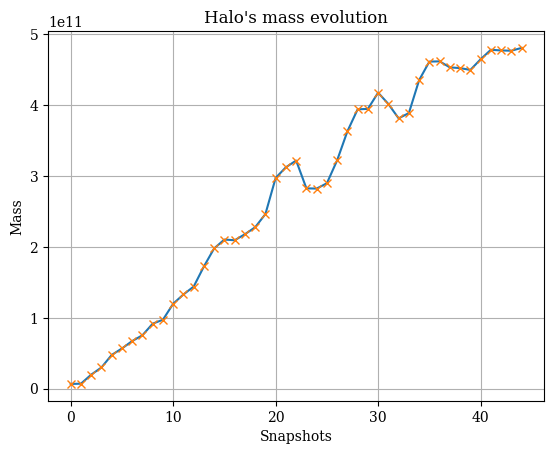

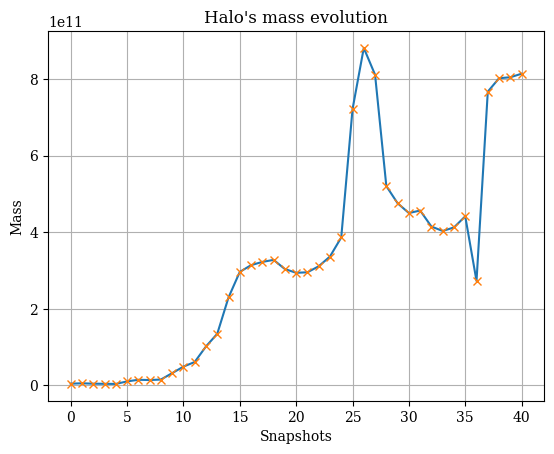

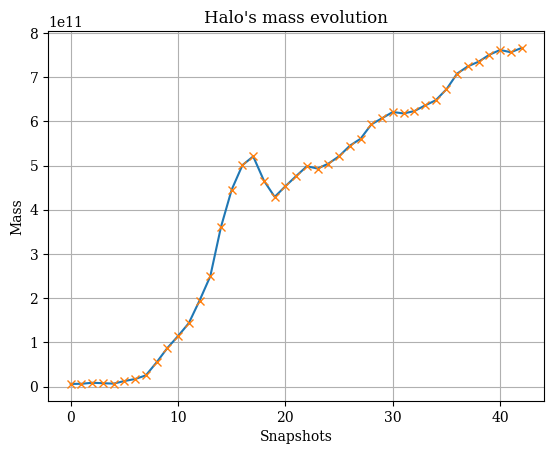

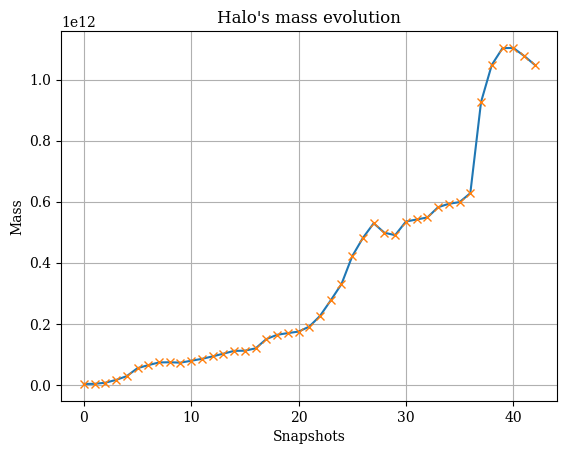

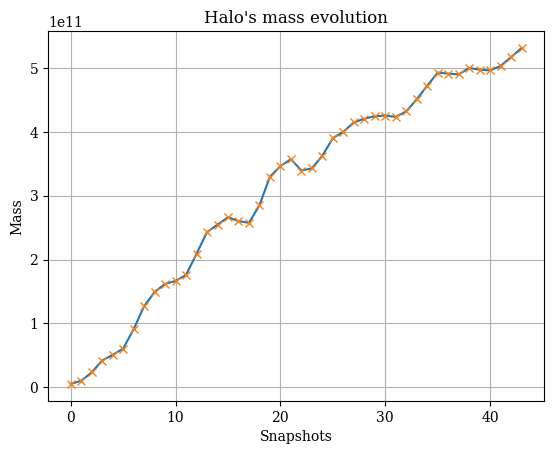

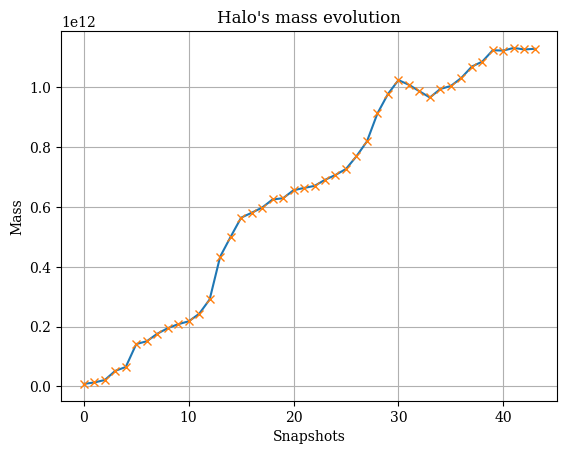

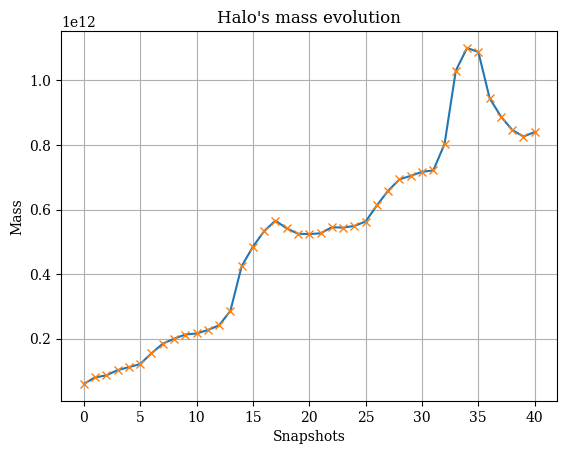

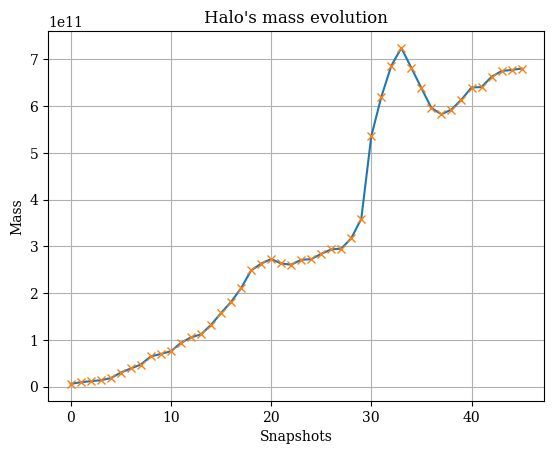

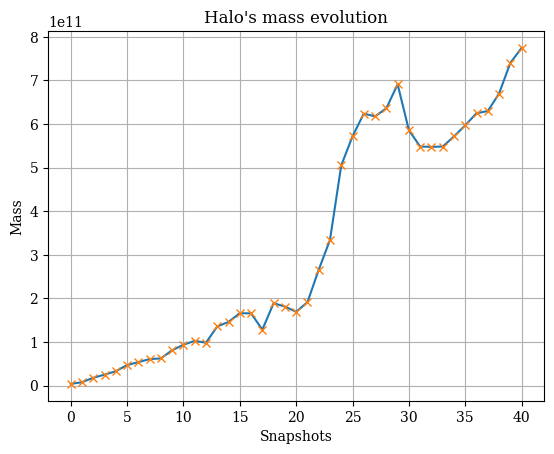

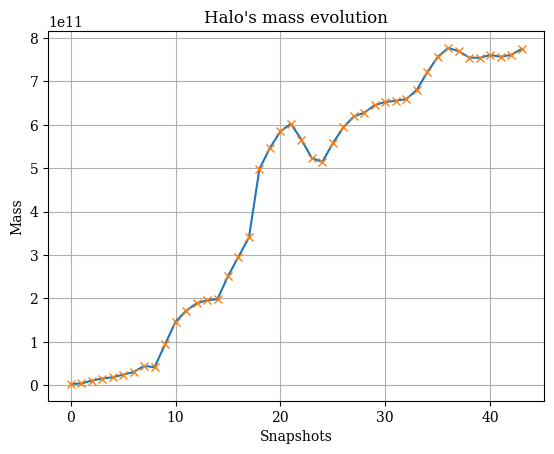

In [12]:
for i in range(10) :
    
    masses = mass_tree[i]
    
    plt.plot(masses[::-1], lw=1.5)
    
    plt.plot(masses[::-1], lw=0, marker='x')
    
    plt.title("Halo's mass evolution")
    plt.xlabel("Snapshots")
    plt.ylabel("Mass")
    plt.grid()
    plt.show()

#### Rebuild the trees for selected halos and save them in a .h5 file

In [13]:
ID_z0 = [int(ID_tree[i][0]) for i in range(len(ID_tree))]
NTrees = len(ID_z0ID_z0 = np.array([grp.attrs['z0_id'] for grp in f.values()])
)

print ("NTrees:", NTrees)
print("Memory used", psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2, " MB")

NTrees: 3458
Memory used 398.0703125  MB


### calculate the fraction of haloes and pairs for which progenitors exist to snap 12.


In [14]:
index_MW = []
index_M31 = []

for id_mw, id_m31 in zip(ID_MW, ID_M31):
    try:
        idx_mw = np.where(ID_z0 == id_mw)[0][0]
        idx_m31 = np.where(ID_z0 == id_m31)[0][0]
        index_MW.append(idx_mw)
        index_M31.append(idx_m31)
    except IndexError:
        continue

index_MW = np.array(index_MW, dtype=int)
index_M31 = np.array(index_M31, dtype=int)

N_LG = len(index_MW)
print(f"{N_LG} LG found in {matched_tree_file}")

N_prog_MW = np.array([len(snapnum_tree[i]) for i in index_MW])
N_prog_M31 = np.array([len(snapnum_tree[i]) for i in index_M31])

selection_MW = np.where(N_prog_MW > 38)[0]
selection_M31 = np.where(N_prog_M31 > 38)[0]

selection_LG = list (set(selection_MW) & set(selection_M31))

#print (snapnum_tree[index_MW[selection_MW[0:100]]])

print ("len sel MW", len(selection_MW))
print ("len sel M31", len(selection_M31))
print ("len sel", len(selection_LG))

print ("fraction MW matched", len(selection_MW) / N_LG)
print ("fraction M31 matched", len(selection_M31) / N_LG)
print ("fraction both matched", len(selection_LG) / N_LG)

1729 LG found in trees2.h5
len sel MW 1624
len sel M31 1617
len sel 1517
fraction MW matched 0.9392712550607287
fraction M31 matched 0.9352226720647774
fraction both matched 0.8773857721226143


### run savgol filters on the orbits, select LG analogues that match the broad criteria, and compute the TA values.

This takes around 15 minutes on puhti. There may be some warnings from the optimisation.

In [15]:
list_M_TA = []
list_a_TA = []
list_e_TA = []
list_eta_TA = []
list_solver_TA = []

list_M_MW = []
list_M_M31 = []

list_r = []
list_vr = []
list_vt = []

list_N_prog = []

list_index_MW = []
list_index_M31 = []

list_x_MW = []
list_y_MW = []
list_z_MW = []

list_x_M31 = []
list_y_M31 = []
list_z_M31 = []

selection = []  # which of the LG analogues will contain a calculated orbit

N_solved = 0
N_try = 0

for i in tqdm(selection_LG): 
    
    # count the number of progenitors:
    N_prog_MW = len(snapnum_tree[index_MW[i]])
    N_prog_M31 = len(snapnum_tree[index_M31[i]])
    
    N_prog = min(N_prog_MW, N_prog_M31)
        
    # extract the data from the tree.
    # do the calculations in physical coordinates.
    
    x_MW = x_tree[index_MW[i]][0:N_prog] * scale[0:N_prog] / hubble
    y_MW = y_tree[index_MW[i]][0:N_prog] * scale[0:N_prog] / hubble
    z_MW = z_tree[index_MW[i]][0:N_prog] * scale[0:N_prog] / hubble
    
    x_M31 = x_tree[index_M31[i]][0:N_prog] * scale[0:N_prog] / hubble
    y_M31 = y_tree[index_M31[i]][0:N_prog] * scale[0:N_prog] / hubble
    z_M31 = z_tree[index_M31[i]][0:N_prog] * scale[0:N_prog] / hubble
    
    vx_MW = vx_tree[index_MW[i]][0:N_prog] 
    vy_MW = vy_tree[index_MW[i]][0:N_prog] 
    vz_MW = vz_tree[index_MW[i]][0:N_prog] 
    
    vx_M31 = vx_tree[index_M31[i]][0:N_prog] 
    vy_M31 = vy_tree[index_M31[i]][0:N_prog] 
    vz_M31 = vz_tree[index_M31[i]][0:N_prog] 
     
    radius =  np.sqrt ((x_MW - x_M31 )**2. + (y_MW - y_M31 )**2. + (z_MW - z_M31 )**2.)

    vtot =  np.sqrt ((vx_MW - vx_M31 )**2. + (vy_MW - vy_M31 )**2. + (vz_MW - vz_M31 )**2.)

    vr = ( (vx_MW - vx_M31) * (x_MW - x_M31) +  (vy_MW - vy_M31) * (y_MW - y_M31) +  (vz_MW - vz_M31) * (z_MW - z_M31) ) / radius

    vt = np.sqrt (vtot**2 - vr**2)

    Hubble_flow = cosmo.H(1/scale[0:N_prog] - 1).value

    vr = vr + radius * Hubble_flow
    
    # we smooth the r, vr and vt values using a savgol filter
    
    radius = savgol_filter(radius,  window_length=10, polyorder=2)
    vr = savgol_filter(vr,  window_length=10, polyorder=2)
    vt = savgol_filter(vt,  window_length=10, polyorder=2)

    # check if there are sensible values and at least 38 values.
    # check if the LG meets the 'broad' selection criteria.
    
    if ((len(radius) > 38) & (radius[0] > r_min_broad) & (radius[0] < r_max_broad) & (vr[0] > vr_min_broad) & (vr[0] < vr_max_broad) & (vt[0] < vt_max_broad) & (np.all(radius[0:38] < 1e7)) & (np.all(vr[0:38] < 1e7)) & (np.all(vt[0:38] < 1e7))):
        
        selection.append(i)
    
        list_r.append(radius)
        list_vr.append(vr)
        list_vt.append(vt)

        list_M_MW.append(mass_tree[index_MW[i]][0:N_prog] / hubble )
        list_M_M31.append(mass_tree[index_M31[i]][0:N_prog] / hubble )
        
        list_N_prog.append(N_prog)
        
        list_index_MW.append(index_MW[i])
        list_index_M31.append(index_M31[i])

        # Compute the TA mass:

        M_TA = []
        a_TA = []
        e_TA = []
        eta_TA = []
        solver_TA = []
        
        for j in range(N_prog):
            
            if j == 0:                     # initialising. Here, vr < 0 due to the selection at z=0
                amax = 10 # in Mpc
                amin = 0
                bounds = [(np.pi, 2*np.pi - 1.e-5)] # bounds on eta for slsqp solver
                etaguess = 4.
            else:                          # during the orbit
                amax = a * 1.5 # in Mpc
                amin = a * .5
                
                if vr[j] < 0:              
                    bounds =  [(np.pi, np.pi*2 - 1.e-5)] # bounds on eta for slsqp solver
                else:
                    bounds =  [(min(eta_TA[j-1] -.2, np.pi - 1.e-5), max(np.pi,eta_TA[j-1] + .2))]  # bounds are in a narrow range around
                                                                                # the previous value
                etaguess = eta_TA[j-1]
                
            N_try = N_try + 1
            
            age = cosmo.age(1/scale[j] - 1).value    
            data = (radius[j]*1000, vr[j], np.abs(vt[j]), age)
            
            eta_slsqp = optimize.minimize(EtaEquation, [etaguess], data, bounds=bounds, method='SLSQP',
                                 options={'maxiter':5e4, 'ftol':1.e-13})
            
            residual_eta = eta_slsqp.fun
                        
            if residual_eta > 1.e-6: # if no minimum is found near the previous value, we progressively extend the range.

                delta_eta = 0.2
                
                while ((residual_eta > 1.e-6) & (delta_eta < 1.4)) : 
                    
                    delta_eta = delta_eta + 0.1
                    
                    if j > 0:
                        bounds = [(min(eta_TA[j-1] - delta_eta, np.pi - 1.e-4), max(np.pi, eta_TA[j-1] + delta_eta))]
                    else:
                        bounds = [(np.pi, 2*np.pi - 1.e-5)]
                
                    eta_slsqp = optimize.minimize(EtaEquation, [etaguess], data, bounds=bounds, method='SLSQP',
                                     options={'maxiter':5e4, 'ftol':1.e-13})
        
                    residual_eta = eta_slsqp.fun
                        
            eta = eta_slsqp.x[0]
            
            e = (np.sin(eta)*np.sin(eta) * vt[j]**2 / vr[j]**2 + 1)**(-.5)
            a = radius[j]*1000 / (1 - e * np.cos(eta) ) / 1000.                # Mpc
            M = a**3. / (G * age**2.) * (eta - e * np.sin(eta) )**2 * 1.e9     # 10^12 Msun
    
            residual =  evalTA ([a,e,eta,M], *data)
            
            if (residual < max_residual and a < amax and a > amin) :
                N_solved = N_solved + 1
            
                M_TA.append(M*1.e12)  # 10^12 
                a_TA.append(a*1000)   # kpc
                e_TA.append(e)
                eta_TA.append(eta)
                solver_TA.append(0)
            
            else: # optimisation failed, we use previous value, if available
                if j > 0:
                    M_TA.append(M_TA[j-1])
                    eta_TA.append(eta_TA[j-1])
                    a_TA.append(a_TA[j-1])
                    e_TA.append(e_TA[j-1])
                else:
                    print ("failed at z=0 (this should not happen due to selection)")
                    M_TA.append(0.)
                    eta_TA.append(0.)
                    a_TA.append(0.)
                    e_TA.append(0.)
                    
                solver_TA.append(1)
        
        M_TA = np.array(M_TA) 
        a_TA = np.array(a_TA) 
        e_TA = np.array(e_TA) 
        eta_TA = np.array(eta_TA) 
        solver_TA = np.array(solver_TA) 
        
        list_M_TA.append(M_TA)
        list_a_TA.append(a_TA) 
        list_e_TA.append(e_TA) 
        list_eta_TA.append(eta_TA) 
        list_solver_TA.append(solver_TA) 
        
        # these are not physical, as they will be used at different snapshots
        list_x_MW.append(x_tree[index_MW[i]][0:N_prog]) 
        list_y_MW.append(y_tree[index_MW[i]][0:N_prog])
        list_z_MW.append(z_tree[index_MW[i]][0:N_prog])
        
        list_x_M31.append(x_tree[index_M31[i]][0:N_prog])
        list_y_M31.append(y_tree[index_M31[i]][0:N_prog])
        list_z_M31.append(z_tree[index_M31[i]][0:N_prog])

print ("Done calculating")

print ("Ntry:", N_try, " solved:", N_solved)

print ("len of list", len(list_M_TA))

  6%|▌         | 89/1517 [00:13<03:35,  6.63it/s]/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
 10%|█         | 157/1517 [00:24<03:11,  7.11it/s]/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
100%|██████████| 1517/1517 [03:50<00:00,  6.59it/s]

Done calculating
Ntry: 63374  solved: 58998
len of list 1514


### Save the data to file.

In [16]:
orbit_data_file = 'orbits_savgol.npz'

np.savez(orbit_data_file, allow_pickle = True,
         list_M_TA = np.array(list_M_TA, dtype=object),
         list_a_TA = np.array(list_a_TA, dtype=object),
         list_e_TA = np.array(list_e_TA, dtype=object),
         list_eta_TA = np.array(list_eta_TA, dtype=object),
         list_solver_TA = np.array(list_solver_TA, dtype=object),
         list_r = np.array(list_r, dtype=object),
         list_vr = np.array(list_vr, dtype=object),
         list_vt = np.array(list_vt, dtype=object),
         list_M_MW = np.array(list_M_MW, dtype=object),
         list_M_M31 = np.array(list_M_M31, dtype=object),
         list_N_prog = np.array(list_N_prog, dtype=object),
         list_index_MW = np.array(list_index_MW, dtype=int),
         list_index_M31 = np.array(list_index_M31, dtype=int),
         selection = np.array(selection, dtype=object),
         #indices_tree_ID_MW = np.array(indices_tree_ID_MW, dtype=int),
         #indices_tree_ID_M31 = np.array(indices_tree_ID_M31, dtype=int)
        )

print ("written calculation data to file")

written calculation data to file


In [17]:
print ("selection:", selection[-10:-1])

selection: [1718, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727]


### save the positions of the selected LG analogues to file (this will be used for reading the particle data)

In [18]:
matched_tree_file_bis = 'particle_tree.npz'

np.savez(matched_tree_file_bis, 
         list_x_MW=np.array(list_x_MW, dtype=object), list_y_MW=np.array(list_y_MW, dtype=object), list_z_MW=np.array(list_z_MW, dtype=object),
         list_x_M31=np.array(list_x_M31, dtype=object), list_y_M31=np.array(list_y_M31, dtype=object), list_z_M31=np.array(list_z_M31, dtype=object))

'''np.savez(matched_tree_file_bis, allow_pickle = True,
        list_x_MW = list_x_MW, list_y_MW = list_y_MW, list_z_MW = list_z_MW,
        list_x_M31 = list_x_M31, list_y_M31 = list_y_M31, list_z_M31 = list_z_M31
        )
'''
print ("saved particle tree file")

saved particle tree file


### The rest of this notebook is just for validation.

In [19]:
# count problems:

count_problems = list (np.sum(list_solver_TA[i][0:38]) for i in range (len(list_solver_TA))) 
count_problems = np.array(count_problems)

# at most five snapshots where there was no direct

few_problems = np.where(count_problems < 6)[0]

print ("Number with few problems:", len(few_problems))

Number with few problems: 1205


### restore the calculation data

In [20]:
with np.load(orbit_data_file, allow_pickle=True) as calculationdata:
    list_M_TA = calculationdata['list_M_TA']
    list_a_TA = calculationdata['list_a_TA']
    list_e_TA = calculationdata['list_e_TA']
    list_eta_TA = calculationdata['list_eta_TA']
    list_solver_TA = calculationdata['list_solver_TA']
    list_r = calculationdata['list_r']
    list_vr = calculationdata['list_vr']
    list_vt = calculationdata['list_vt']
    list_M_MW = calculationdata['list_M_MW']
    list_M_M31 = calculationdata['list_M_M31']
    list_N_prog = calculationdata['list_N_prog']
    selection_orbits = calculationdata['selection']
    
print ("read orbit calculation data from file")


read orbit calculation data from file


### Check that including or excluding orbits with gaps in the TA evaluation has no significant effect. Plot is similar to _Figure 1_ of the paper.

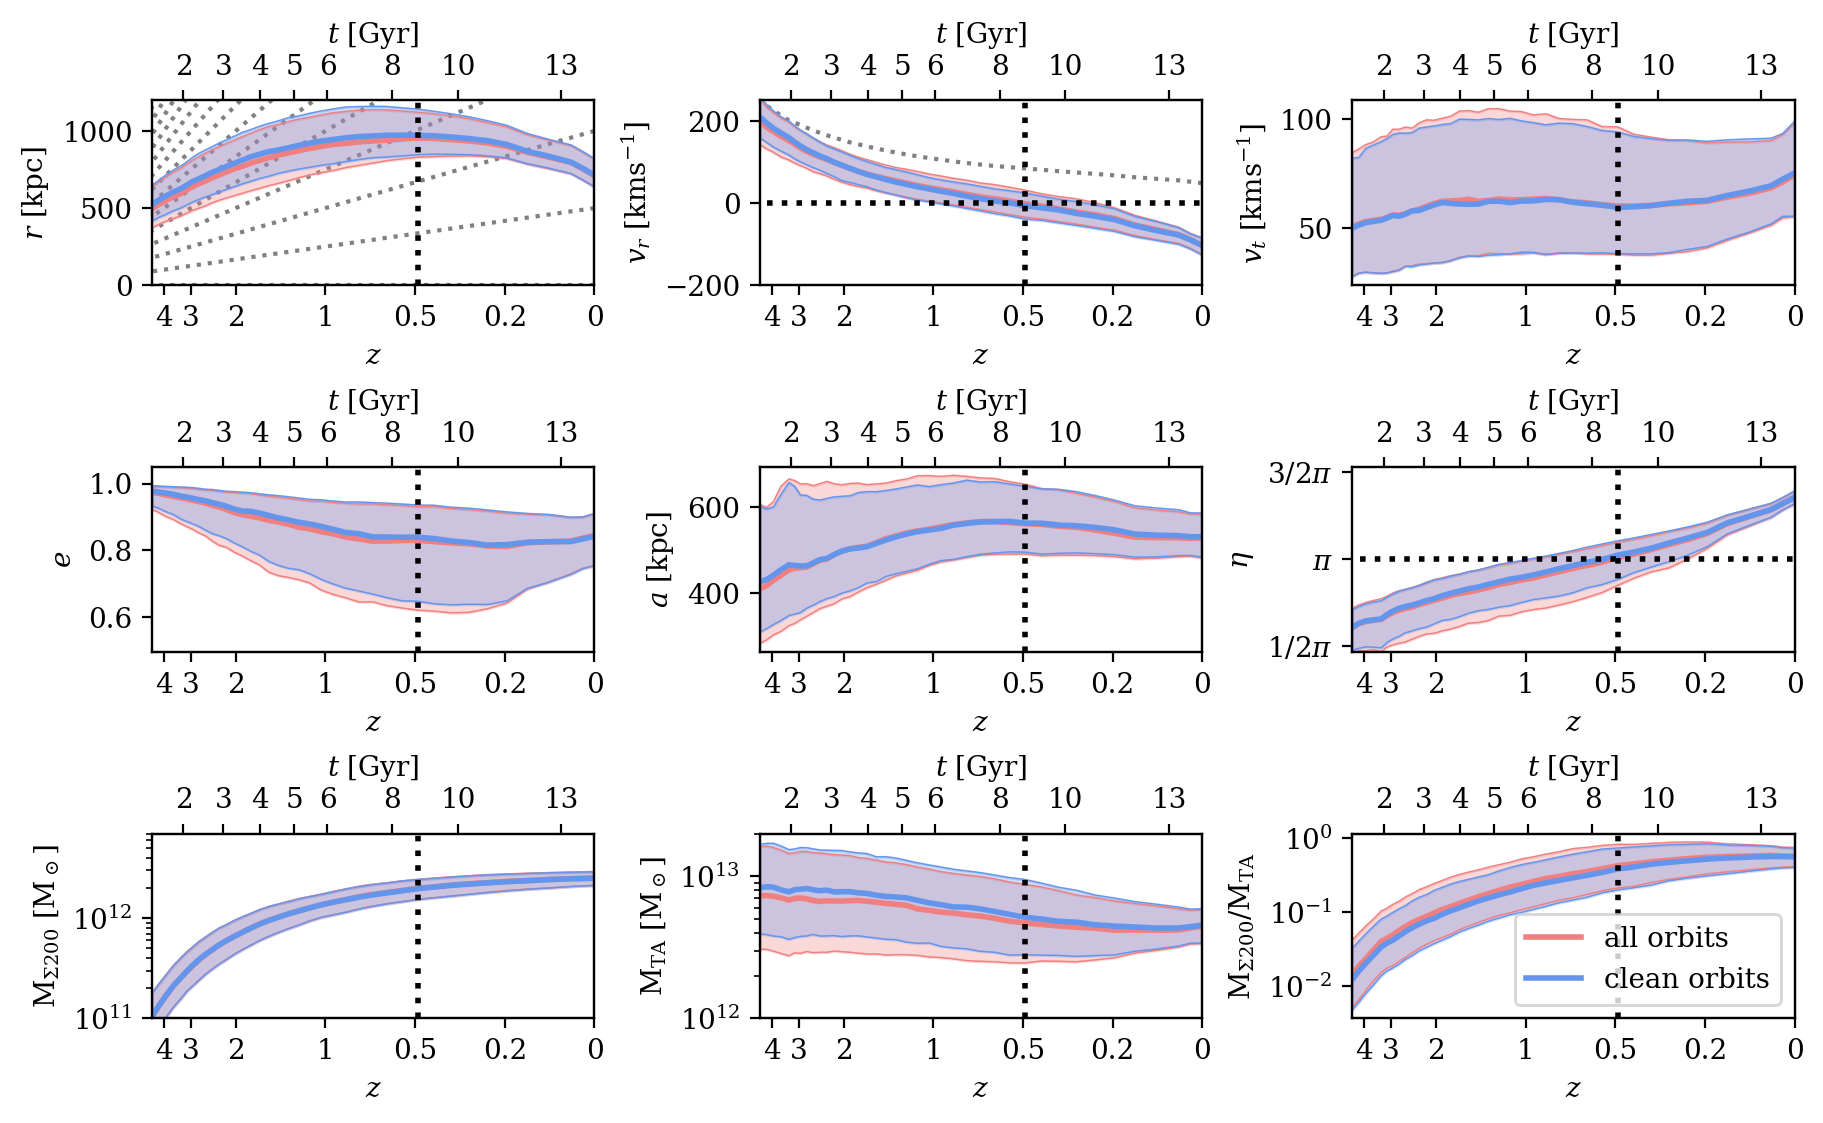

In [21]:
mask_strict = few_problems

list_M_TA_s = list_M_TA[mask_strict]
list_a_TA_s = list_a_TA[mask_strict]
list_e_TA_s = list_e_TA[mask_strict]
list_eta_TA_s = list_eta_TA[mask_strict]
list_solver_TA_s = list_solver_TA[mask_strict]
list_r_s = list_r[mask_strict]
list_vr_s = list_vr[mask_strict]
list_vt_s = list_vt[mask_strict]
list_M_MW_s = list_M_MW[mask_strict]
list_M_M31_s = list_M_M31[mask_strict]
list_N_prog_s = list_N_prog[mask_strict]
selection_orbits_s = mask_strict

list_M_TA_l = list_M_TA
list_a_TA_l = list_a_TA
list_e_TA_l = list_e_TA
list_eta_TA_l = list_eta_TA
list_solver_TA_l = list_solver_TA
list_r_l = list_r
list_vr_l = list_vr
list_vt_l = list_vt
list_M_MW_l = list_M_MW
list_M_M31_l = list_M_M31
list_N_prog_l = list_N_prog
selection_orbits_l = np.arange(len(list_M_TA))

# radii:

r_med = []
r_plus1 = []
r_minus1 = []


for idx, snap in enumerate(fine_index):
    r = np.array([list_r_s[i][idx] for i in range(len(selection_orbits_s))]) * 1000.
    r_med.append(np.percentile(r,50))
    r_plus1.append(np.percentile(r,84))
    r_minus1.append(np.percentile(r,16))
        
# vr:

vr_med = []
vr_plus1 = []
vr_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vr = np.array([list_vr_s[i][idx] for i in range(len(selection_orbits_s))]) 
    vr_med.append(np.percentile(vr,50))
    vr_plus1.append(np.percentile(vr,84))
    vr_minus1.append(np.percentile(vr,16))
    
# vt:

vt_med = []
vt_plus1 = []
vt_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vt = np.array([list_vt_s[i][idx] for i in range(len(selection_orbits_s))]) 
    vt_med.append(np.percentile(vt,50))
    vt_plus1.append(np.percentile(vt,84))
    vt_minus1.append(np.percentile(vt,16))
          
# M:

M_med = []
M_plus1 = []
M_minus1 = []

for idx, snap in enumerate(fine_index):
    
    M = np.array([list_M_MW_s[i][idx] + list_M_M31_s[i][idx] for i in range(len(selection_orbits_s))]) 
    M_med.append(np.percentile(M,50))
    M_plus1.append(np.percentile(M,84))
    M_minus1.append(np.percentile(M,16))
        
# M_TA:

M_TA_med = []
M_TA_plus1 = []
M_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    M = np.array([list_M_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    M_TA_med.append(np.percentile(M,50))
    M_TA_plus1.append(np.percentile(M,84))
    M_TA_minus1.append(np.percentile(M,16))

# M by M_TA

M_by_M_TA_med = []
M_by_M_TA_plus1 = []
M_by_M_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    M = np.array([ (list_M_MW_s[i][idx] + list_M_M31_s[i][idx]) / list_M_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    M_by_M_TA_med.append(np.percentile(M,50))
    M_by_M_TA_plus1.append(np.percentile(M,84))
    M_by_M_TA_minus1.append(np.percentile(M,16))

# eccentricity, e
e_TA_med = []
e_TA_plus1 = []
e_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    e = np.array([list_e_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    e_TA_med.append(np.percentile(e,50))
    e_TA_plus1.append(np.percentile(e,84))
    e_TA_minus1.append(np.percentile(e,16))

# semimajor axis, a
a_TA_med = []
a_TA_plus1 = []
a_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    a = np.array([list_a_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    a_TA_med.append(np.percentile(a,50))
    a_TA_plus1.append(np.percentile(a,84))
    a_TA_minus1.append(np.percentile(a,16))

# phase, eta
eta_TA_med = []
eta_TA_plus1 = []
eta_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    eta = np.array([list_eta_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    eta_TA_med.append(np.percentile(eta,50))
    eta_TA_plus1.append(np.percentile(eta,84))
    eta_TA_minus1.append(np.percentile(eta,16))
    

var_med_s = [r_med, vr_med, vt_med, e_TA_med, a_TA_med, eta_TA_med, M_med, M_TA_med, M_by_M_TA_med]
var_plus1_s = [r_plus1, vr_plus1, vt_plus1, e_TA_plus1, a_TA_plus1, eta_TA_plus1, M_plus1, M_TA_plus1, M_by_M_TA_plus1]
var_minus1_s = [r_minus1, vr_minus1, vt_minus1, e_TA_minus1, a_TA_minus1, eta_TA_minus1, M_minus1, M_TA_minus1, M_by_M_TA_minus1]



# LOOSE


# radii:

r_med = []
r_plus1 = []
r_minus1 = []

for idx, snap in enumerate(fine_index):
    
    r = np.array([list_r_l[i][idx] for i in range(len(selection_orbits_l))]) * 1000.
    r_med.append(np.percentile(r,50))
    r_plus1.append(np.percentile(r,84))
    r_minus1.append(np.percentile(r,16))
        
# vr:

vr_med = []
vr_plus1 = []
vr_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vr = np.array([list_vr_l[i][idx] for i in range(len(selection_orbits_l))]) 
    vr_med.append(np.percentile(vr,50))
    vr_plus1.append(np.percentile(vr,84))
    vr_minus1.append(np.percentile(vr,16))
       
# vt:

vt_med = []
vt_plus1 = []
vt_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vt = np.array([list_vt_l[i][idx] for i in range(len(selection_orbits_l))]) 
    vt_med.append(np.percentile(vt,50))
    vt_plus1.append(np.percentile(vt,84))
    vt_minus1.append(np.percentile(vt,16))
             
# M:

M_med = []
M_plus1 = []
M_minus1 = []

for idx, snap in enumerate(fine_index):
    
    M = np.array([list_M_MW_l[i][idx] + list_M_M31_l[i][idx] for i in range(len(selection_orbits_l))]) 
    M_med.append(np.percentile(M,50))
    M_plus1.append(np.percentile(M,84))
    M_minus1.append(np.percentile(M,16))
        
# M_TA:

M_TA_med = []
M_TA_plus1 = []
M_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    M = np.array([list_M_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    M_TA_med.append(np.percentile(M,50))
    M_TA_plus1.append(np.percentile(M,84))
    M_TA_minus1.append(np.percentile(M,16))

#M / M_TA

M_by_M_TA_med = []
M_by_M_TA_plus1 = []
M_by_M_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    M = np.array([ (list_M_MW_l[i][idx] + list_M_M31_l[i][idx]) / list_M_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    M_by_M_TA_med.append(np.percentile(M,50))
    M_by_M_TA_plus1.append(np.percentile(M,84))
    M_by_M_TA_minus1.append(np.percentile(M,16))

# eccentricity, e
e_TA_med = []
e_TA_plus1 = []
e_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    e = np.array([list_e_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    e_TA_med.append(np.percentile(e,50))
    e_TA_plus1.append(np.percentile(e,84))
    e_TA_minus1.append(np.percentile(e,16))

# semimajor axis, a
a_TA_med = []
a_TA_plus1 = []
a_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    a = np.array([list_a_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    
    a_TA_med.append(np.percentile(a,50))
    a_TA_plus1.append(np.percentile(a,84))
    a_TA_minus1.append(np.percentile(a,16))
    
# phase, eta
eta_TA_med = []
eta_TA_plus1 = []
eta_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    eta = np.array([list_eta_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    eta_TA_med.append(np.percentile(eta,50))
    eta_TA_plus1.append(np.percentile(eta,84))
    eta_TA_minus1.append(np.percentile(eta,16))
    

var_med_l = [r_med, vr_med, vt_med, e_TA_med, a_TA_med, eta_TA_med, M_med, M_TA_med, M_by_M_TA_med]
var_plus1_l = [r_plus1, vr_plus1, vt_plus1, e_TA_plus1, a_TA_plus1, eta_TA_plus1, M_plus1, M_TA_plus1, M_by_M_TA_plus1]
var_minus1_l = [r_minus1, vr_minus1, vt_minus1, e_TA_minus1, a_TA_minus1, eta_TA_minus1, M_minus1, M_TA_minus1, M_by_M_TA_minus1]



# plotting
        
fig, axes = plt.subplots(figsize=(9,5.5), ncols=3, nrows=3, dpi=200, constrained_layout = True)
norm = plt.Normalize(0,1)


for i, ax in enumerate(fig.axes):
    
    ax.fill_between(scale[fine_index], var_minus1_l[i], var_plus1_l[i], color='lightcoral', alpha=.3)
    ax.fill_between(scale[fine_index], var_minus1_s[i], var_plus1_s[i], color='cornflowerblue', alpha=.3)
    
    ax.plot(scale[fine_index], var_med_l[i], c='lightcoral', lw=2., ls='solid', zorder=2, label = 'all orbits')
    ax.plot(scale[fine_index], var_plus1_l[i], c='lightcoral', lw=.5, ls='solid', zorder=2)
    ax.plot(scale[fine_index], var_minus1_l[i], c='lightcoral', lw=.5, ls='solid', zorder=2)

    ax.plot(scale[fine_index], var_med_s[i], c='cornflowerblue', lw=2., ls='solid', zorder=2, label = 'clean orbits')
    ax.plot(scale[fine_index], var_plus1_s[i], c='cornflowerblue', lw=.5, ls='solid', zorder=2)
    ax.plot(scale[fine_index], var_minus1_s[i], c='cornflowerblue', lw=.5, ls='solid', zorder=2)

# Format and label the axes

for i, ax in enumerate(fig.axes):
        
    ax.axvline(scale[10], ls='dotted', c='black', lw=2)

    ax.set_xticks(label_scales)
    ax.set_xticklabels(label_redshifts_str)
    
    ax.set_xlabel(r'$z$')

    ax2 = ax.twiny() # ax1 and ax2 share y-axis
    ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])
    ax.set_xlim(min(scale[fine_index]),1)
    ax2.set_xlim(min(scale[fine_index]),1)

axes[0,1].plot([0,1],[0,0], ls='dotted', c='black', lw=2)

axes[0,0].set_ylim(bottom=0)
axes[2,0].set_ylim(bottom = 1e11, top=7e12)
axes[2,1].set_ylim(bottom = 1e12, top=2e13)

axes[0,0].set_ylabel(r'$r \ [\mathrm{kpc}]$')
axes[0,1].set_ylabel(r'$v_r \ [\mathrm{kms^{-1}}]$')
axes[0,2].set_ylabel(r'$v_t \ [\mathrm{kms^{-1}}]$')

axes[1,0].set_ylabel(r'$e$')
axes[1,1].set_ylabel(r'$a  \ [\mathrm{kpc}]$')
axes[1,2].set_ylabel(r'$\eta$')

axes[2,0].set_ylabel(r'$\mathrm{M_{\Sigma 200} \ [M_\odot]}$')
axes[2,1].set_ylabel(r'$\mathrm{M_{TA} \ [M_\odot]}$')
axes[2,2].set_ylabel(r'$\mathrm{M_{\Sigma 200} / M_{TA}}$')

axes[2,0].set_yscale('log')
axes[2,1].set_yscale('log')
axes[2,2].set_yscale('log')
axes[2,2].minorticks_off()


ages = np.array([13, 10, 8, 6, 5, 4, 3, 2, 1])*u.Gyr
ageticks = [1 / (1 + z_at_value(cosmo.age, age)) for age in ages]

# units of pi
axes[1,2].plot([0,1],[3.1415,3.1415], ls='dotted', c='black', lw=2)

axes[1,2].set_yticks(np.arange(0, 2*np.pi+0.01, np.pi/2))
#Change axis labels:
labels = ['$0$', r'$1/2 \pi$', r'$\pi$', r'$3/2\pi$', r'$2\pi$']
axes[1,2].set_yticklabels(labels)
axes[1,2].set_ylim(np.pi / 2 - .1, 3*np.pi / 2 + .1)

axes[0,2].autoscale_view(True,True,True)

# overplot expansion of the universe:
for i in range (50):
    axes[0,0].plot(scale, i*500*scale, c = 'grey', ls = 'dotted', lw=1.5, zorder=-1)
    
# for the hubble expansion speed, we use the median separation
    
Hubble_flow = cosmo.H(1/scale - 1).value # value is km/s / Mpc
axes[0,1].plot(scale[fine_index], Hubble_flow[fine_index] * r_med / 1000., c = 'grey', ls = 'dotted', lw=1.5, zorder=-1)

axes[0,1].set_ylim(-200,250)
axes[1,0].set_ylim(0.495,1.05)

axes[2,2].legend()

plt.savefig('evolution_problems.pdf')

In [22]:
# Make a 2D-Matrix (1 line for each MW/M31 analogue, 1 column for each snapshot)
# It's an array of array where np.vstack changes that in lines [[...],[...]] => [[...] 
#                                                                                [...]]

m_MW = np.vstack([np.array(list_M_MW_l[i])[fine_index] for i in range(len(selection_orbits_l))])
m_M31 = np.vstack([np.array(list_M_M31_l[i])[fine_index] for i in range(len(selection_orbits_l))])

# Find the indix corresponding to z = 0 (i.e. a = 1) to find the current mass
idx_z0 = np.argmin(np.abs(scale[fine_index] - 1.0))

# Normalise for each MW/M31 analogue by its own final mass
m_MW_norm  = m_MW  / m_MW[:, idx_z0][:, None]
m_M31_norm = m_M31 / m_M31[:, idx_z0][:, None]

# Computing stastistical datas (med, sigma)
def stats(arr):
    return (np.percentile(arr, 50, axis=0), np.percentile(arr, 84, axis=0), np.percentile(arr, 16, axis=0))

m_MW_med, m_MW_plus1, m_MW_minus1 = stats(m_MW)
m_M31_med, m_M31_plus1, m_M31_minus1 = stats(m_M31)

m_MW_med_norm, m_MW_plus1_norm, m_MW_minus1_norm = stats(m_MW_norm)
m_M31_med_norm, m_M31_plus1_norm, m_M31_minus1_norm = stats(m_M31_norm)

print("Computation done.")

Computation done.


## Ploting MW and M31 mass evolution

### We first compute everything needed for the following plots - with and without normalisation

In [23]:
np.savez(
    "MW_M31_in_LG_mass_stats.npz",
    scale=scale[fine_index],

    m_MW=m_MW,
    m_M31=m_M31,
    m_MW_norm=m_MW_norm,
    m_M31_norm=m_M31_norm,

    m_MW_med=m_MW_med,
    m_MW_plus1=m_MW_plus1,
    m_MW_minus1=m_MW_minus1,
    m_MW_med_norm=m_MW_med_norm,
    m_MW_plus1_norm=m_MW_plus1_norm,
    m_MW_minus1_norm=m_MW_minus1_norm,

    m_M31_med=m_M31_med,
    m_M31_plus1=m_M31_plus1,
    m_M31_minus1=m_M31_minus1,
    m_M31_med_norm=m_M31_med_norm,
    m_M31_plus1_norm=m_M31_plus1_norm,
    m_M31_minus1_norm=m_M31_minus1_norm,
)

print("Data saved.")

Data saved.


### We plot the MW and M31 mass evolution without normalisation on two separated graphs

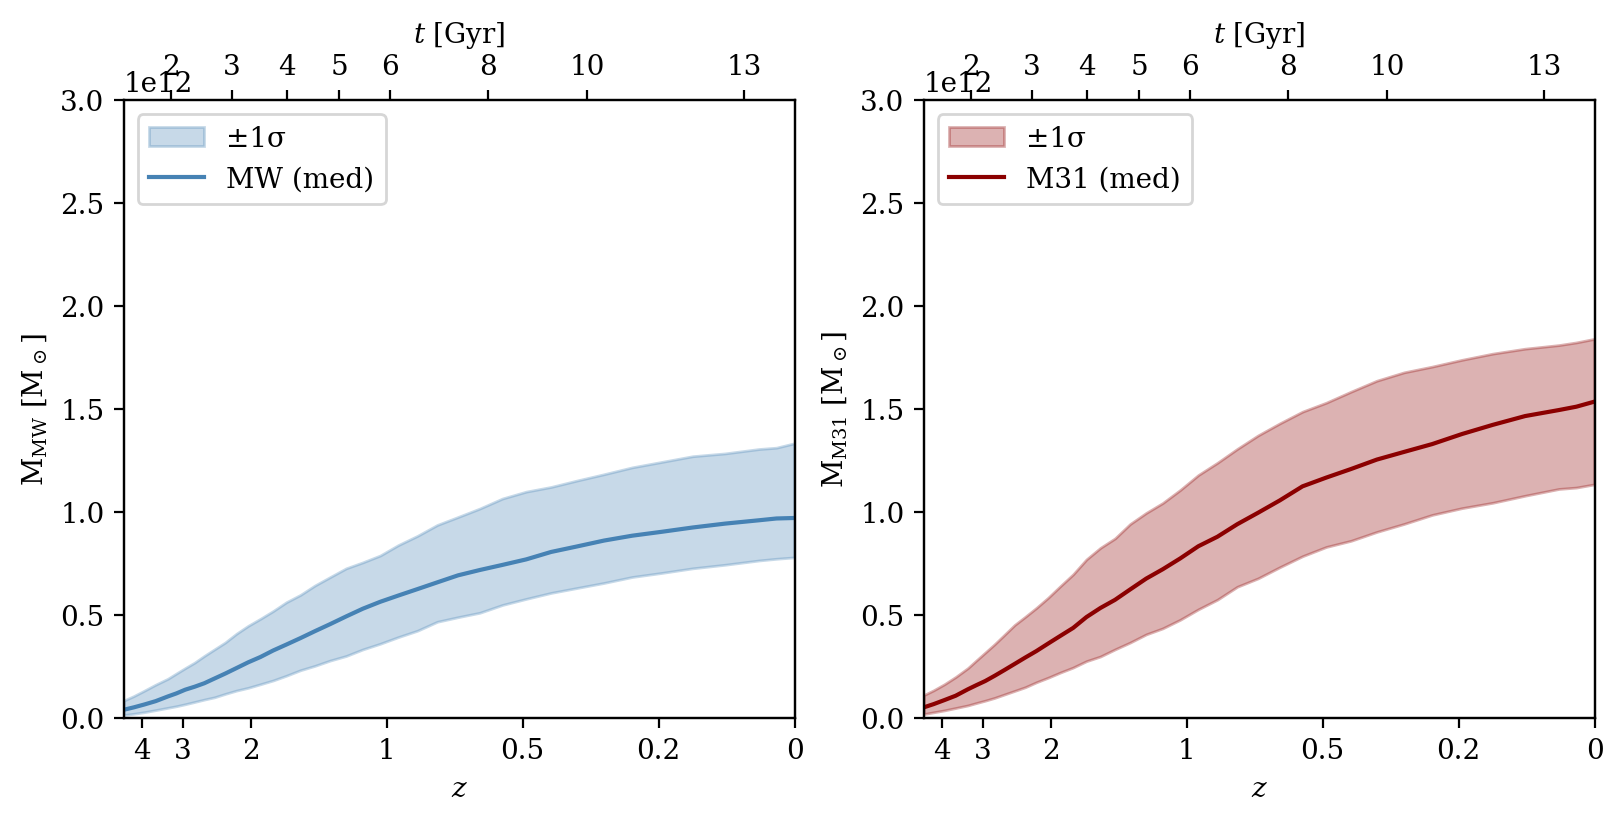

In [24]:
# Ploting

fig, axes = plt.subplots(figsize=(8,4), ncols=2, nrows=1, dpi=200, constrained_layout=True)
plot_style = {'color': 'r', 'linewidth': 0.5, 'linestyle': 'solid'}

ax_MW = axes[0]
ax_MW.fill_between(scale[fine_index], m_MW_minus1, m_MW_plus1, color='steelblue', alpha=0.3, label='±1σ')
ax_MW.plot(scale[fine_index], m_MW_med, color='steelblue', lw=1.5, label='MW (med)')
ax_MW.legend(loc='upper left')

ax_M31 = axes[1]
ax_M31.fill_between(scale[fine_index], m_M31_minus1, m_M31_plus1, color='darkred', alpha=0.3, label='±1σ')
ax_M31.plot(scale[fine_index], m_M31_med, color='darkred', lw=1.5, label='M31 (med)')
ax_M31.legend(loc='upper left')

# Axes

for ax in axes:

    ax.set_xticks(label_scales)
    ax.set_xticklabels(label_redshifts_str)
    ax.set_xlabel(r'$z$')

    ax2 = ax.twiny()
    ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])

    ax.set_xlim(min(scale[fine_index]), 1)
    ax.set_ylim(0, 3e12)
    ax2.set_xlim(min(scale[fine_index]), 1)
    ax2.set_ylim(0, 3e12)

axes[0].set_ylabel(r'$\mathrm{M_{MW} \ [M_\odot]}$')
axes[1].set_ylabel(r'$\mathrm{M_{M31} \ [M_\odot]}$')



# Save plot
plt.savefig('MW_M31_LG_2_plots_evolution_mass.png')
plt.show()

### Same plot with normalisation

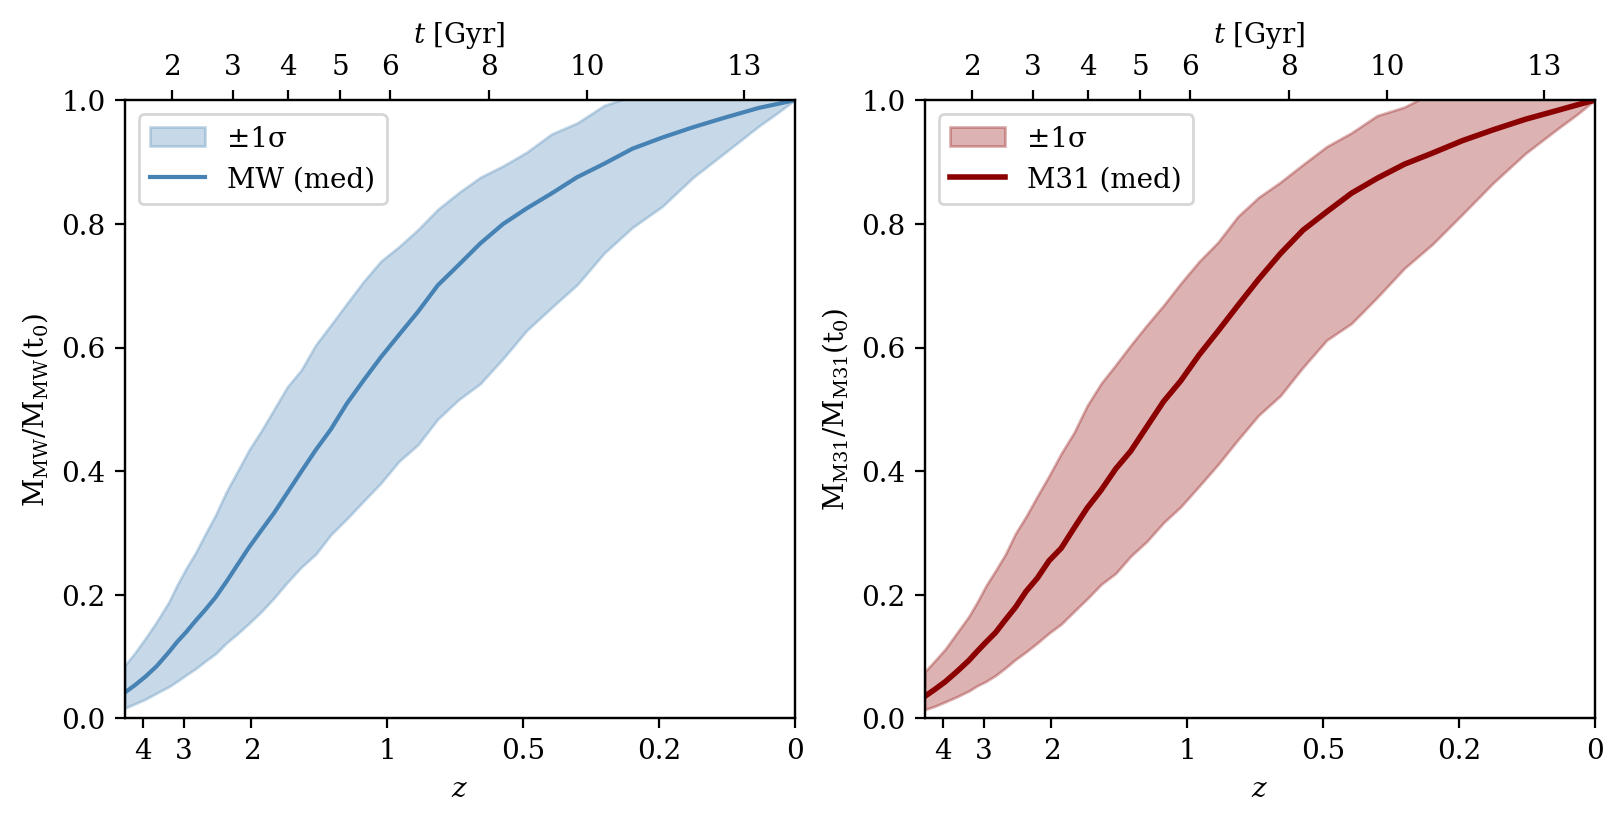

In [25]:
'''
# Normalisation factors are different for MW and M31
norm_MW = m_MW_med[idx_z0]
norm_M31 = m_M31_med[idx_z0]

# Mormalisation
m_MW_med_norm = m_MW_med / norm_MW
m_MW_plus1_norm = m_MW_plus1 / norm_MW
m_MW_minus1_norm = m_MW_minus1 / norm_MW

m_M31_med_norm = m_M31_med / norm_M31
m_M31_plus1_norm = m_M31_plus1 / norm_M31
m_M31_minus1_norm = m_M31_minus1 / norm_M31'''


# Ploting

fig, axes = plt.subplots(figsize=(8,4), ncols=2, nrows=1, dpi=200, constrained_layout=True)
plot_style = {'color': 'r', 'linewidth': 0.5, 'linestyle': 'solid'}

ax_MW = axes[0]
ax_MW.fill_between(scale[fine_index], m_MW_minus1_norm, m_MW_plus1_norm, color='steelblue', alpha=0.3, label='±1σ')
ax_MW.plot(scale[fine_index], m_MW_med_norm, color='steelblue', lw=1.5, label='MW (med)')
ax_MW.legend(loc='upper left')

ax_M31 = axes[1]
ax_M31.fill_between(scale[fine_index], m_M31_minus1_norm, m_M31_plus1_norm, color='darkred', alpha=0.3, label='±1σ')
ax_M31.plot(scale[fine_index], m_M31_med_norm, color='darkred', lw=2, label='M31 (med)')
ax_M31.legend(loc='upper left')

# Axes

for ax in axes:

    ax.set_xticks(label_scales)
    ax.set_xticklabels(label_redshifts_str)
    ax.set_xlabel(r'$z$')

    ax2 = ax.twiny()
    ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])

    ax.set_xlim(min(scale[fine_index]), 1)
    ax.set_ylim(0, 1)
    ax2.set_xlim(min(scale[fine_index]), 1)
    ax2.set_ylim(0, 1)

axes[0].set_ylabel(r'$\mathrm{M_{MW}/M_{MW}(t_0)}$')
axes[1].set_ylabel(r'$\mathrm{M_{M31}/M_{M31}(t_0)}$')


# Save plot
plt.savefig('MW_M31_LG_2_plots_normalised_evolution_mass.png')
plt.show()

### We superpose the two plots without normalisation

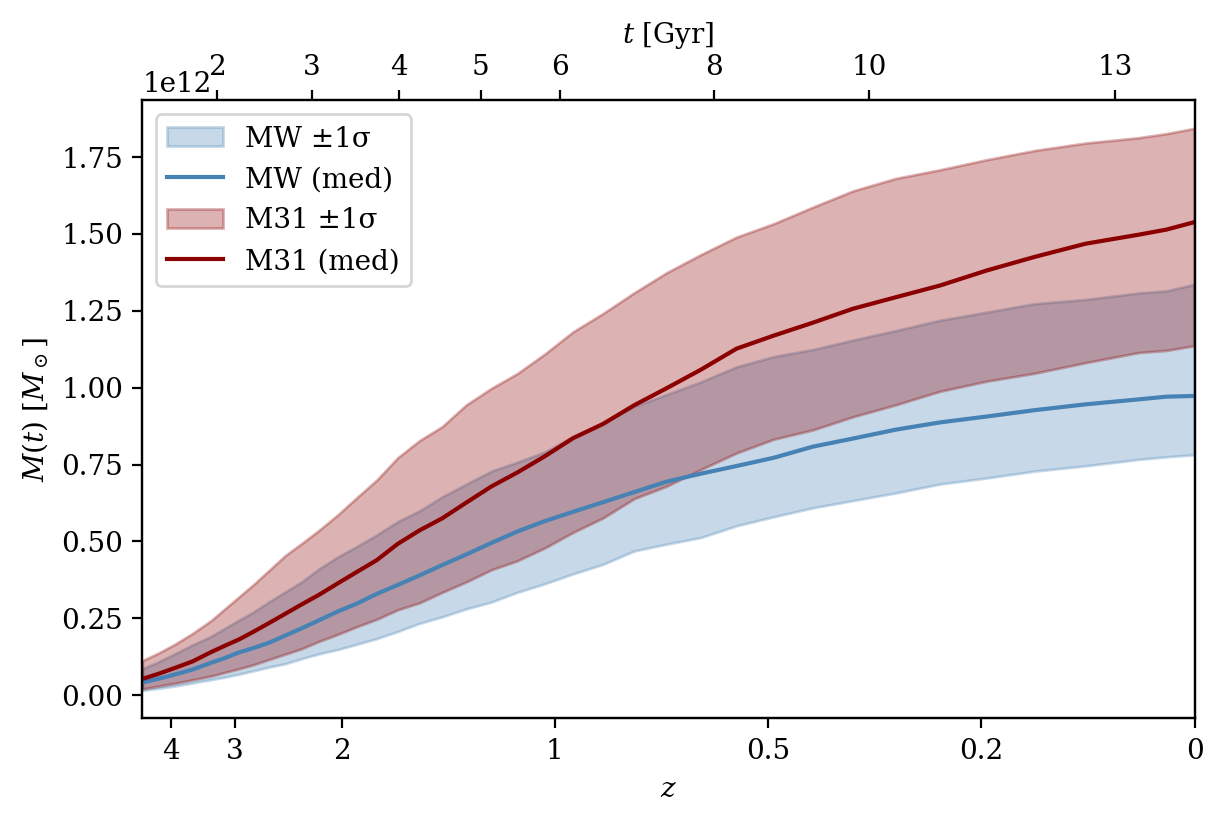

In [26]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200, constrained_layout=True)

# Tracé pour la Voie Lactée (MW)
ax.fill_between(scale[fine_index],
                m_MW_minus1, m_MW_plus1,
                color='steelblue', alpha=0.3,
                label='MW ±1σ')
ax.plot(scale[fine_index], m_MW_med, color='steelblue', lw=1.5, label='MW (med)')

# Tracé pour M31
ax.fill_between(scale[fine_index], m_M31_minus1, m_M31_plus1, color='darkred', alpha=0.3, label='M31 ±1σ')
ax.plot(scale[fine_index], m_M31_med, color='darkred', lw=1.5, label='M31 (med)')

ax.set_xticks(label_scales)
ax.set_xticklabels(label_redshifts_str)
ax.set_xlabel(r'$z$')
ax.set_xlim(min(scale[fine_index]), 1)

ax.set_ylabel(r'$M(t)\ [M_\odot]$')

ax2 = ax.twiny()
ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
ax2.set_xticks(ageticks)
ax2.set_xticklabels([f'{age:g}' for age in ages.value])
ax2.set_xlim(min(scale[fine_index]), 1)

ax.legend(loc='upper left')
plt.savefig('MW_M31_LG_superposed_evolution_mass.png')
plt.show()


### Same plot with normalisation

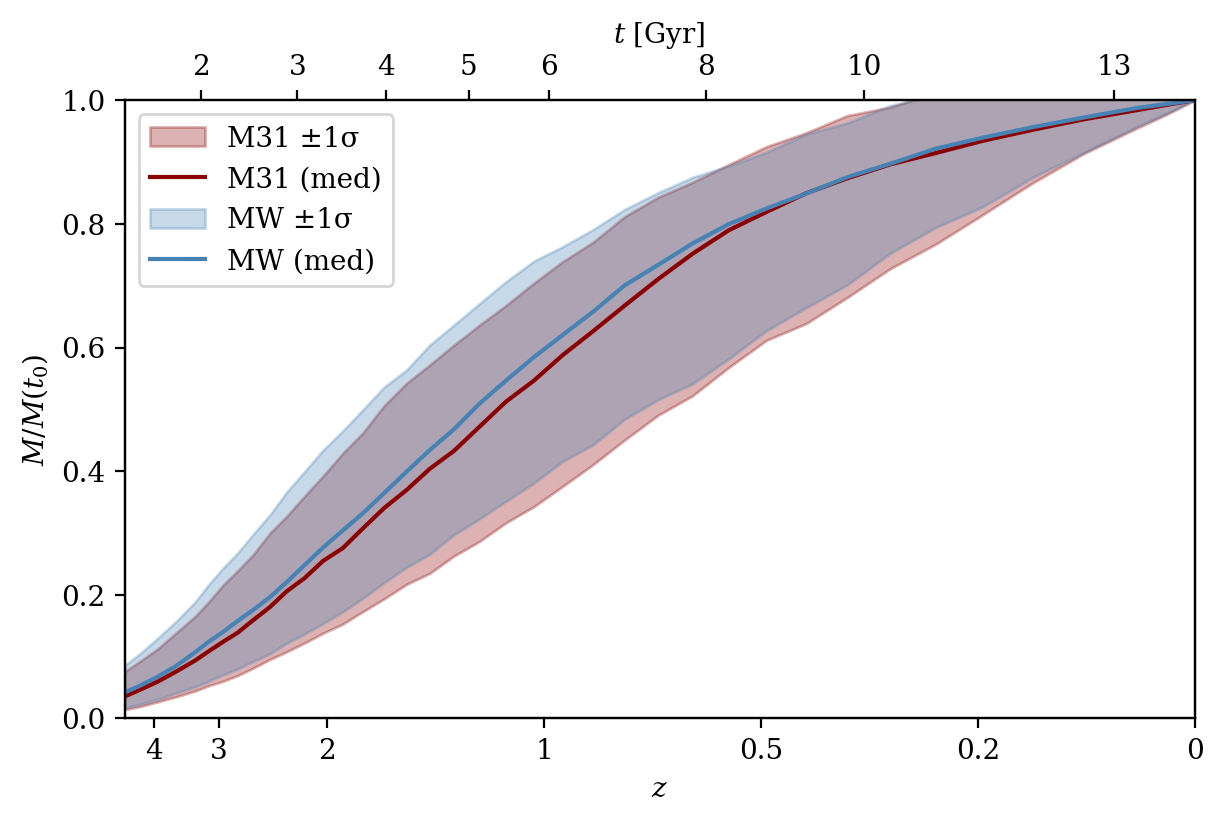

In [27]:
# Ploting

fig, ax = plt.subplots(figsize=(6,4), dpi=200, constrained_layout=True)

ax.fill_between(scale[fine_index], m_M31_minus1_norm, m_M31_plus1_norm, color='darkred', alpha=0.3, label='M31 ±1σ')
ax.plot(scale[fine_index], m_M31_med_norm, color='darkred', lw=1.5, label='M31 (med)')

ax.fill_between(scale[fine_index], m_MW_minus1_norm, m_MW_plus1_norm, color='steelblue', alpha=0.3, label='MW ±1σ')
ax.plot(scale[fine_index], m_MW_med_norm, color='steelblue', lw=1.5, label='MW (med)')

#------------
# Axes
#------------

# Redshift
ax.set_xticks(label_scales)
ax.set_xticklabels(label_redshifts_str)
ax.set_xlabel(r'$z$')
ax.set_xlim(min(scale[fine_index]), 1)

# Time in Gyr
ax2 = ax.twiny()
ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
ax2.set_xticks(ageticks)
ax2.set_xticklabels([f'{age:g}' for age in ages.value])
ax2.set_xlim(min(scale[fine_index]), 1)

# Normalised mass
ax.set_ylim(0, 1)
ax.set_ylabel(r'$M/M(t_0)$')

# Legend
ax.legend(loc='upper left')


plt.savefig('MW_M31_LG_superposed_normalised_evolution_mass.png')
plt.show()
